# Bank Churn Analysis

# 1. Context

### The business
Business Model: banking services through physical agencies and online.

TopBank is an european bank with clients in France, Germany and Spain. The company offers banking services such as banking accounts, investment portfolios and insurances. The main product is the banking account, where clients can make transfers, deposits, withdraws and other movements. This product is free of charge and is valid up to 1 year, after that the client needs to renew their membership for another 12 months. TopBank is available to its costumers online and as a physical business. The company has a database with clients' information regarding their demographic caractheristics and their activities in the bank.

According to the Analytics Team, TopBank profits 15% of a customer's estimated salary if the salary is is equal or less than the average salary of TopBank's clients. When the estimated salary is higher than the average, TopBank profits 20% of the estimated salary.



### The problem
TopBank noticed an increase of clients not renewing their contract or cancelling the contract before the end date, in other words they noticed an increase in the churn rate. The churn rate is also known as attrition rate and in this context it is defined as the rate at which customers stop doing business with an entity. A high churn rate can affect profits and growth. 

Churn can happen for several motives. The number 1 reason why customers leave a bank institution is due to poor service. Service can be influenced by rates, fees, communication and service quality and wait times, location sites, available mix of products and availability of digital tools. 

There are other important reasons to consider such as death, displacement and divorces.

Ref: https://thefinancialbrand.com/55772/banking-customer-attrition-analysis/; https://www.qualtrics.com/blog/customer-churn-banking/

### Business Needs
TopBank needs to understand why the churn rate is increasing and which actions are recommended to reduce this number. They ask your help to create an action plan to reduce customer churn (either avoid a client to cancel the subscription prior the end date and avoid the non contract renovation). In order to complete this task you need to develop a model to predict the probability of customer's churn.

The Analytics Team and the CEO also asked:
- What is TopBank current churn rate? How does it varies monthly?
- What is your model performance in classifying clients in churn?
- What is the expected revenue if TopBank uses your model to avoid client's churn?
- If you offer any type of financial incentive to avoid churn, which should be its value to maximize the company's ROI? You can surpass R$10.000/client in incentives.

### Solution
- Model to predict client's churn probability and answer TopBank questions.


# 2. Imports

## 2.1 Libraries

In [36]:
# utilities
import pickle
import inflection
#from general_utils.GeneralUtils import GeneralUtils
from IPython.display import HTML
from IPython.display import Image
import warnings
#from collections import Counter

# data manipulation
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from IPython.display import IFrame

# preprocessing
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

# feature selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.decomposition import PCA

# machine learning
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.model_selection import cross_val_score

# algorithms
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

# metrics
import sklearn.metrics   as m
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_validate, cross_val_predict, RandomizedSearchCV
import scikitplot as skplt


## 2.2 Helper Functions

In [37]:
warnings.filterwarnings('ignore')

# sets seaborn default style
sns.set()

# sets matplolit inline
%matplotlib inline

# sets to display unlimited number of columns
pd.options.display.max_columns = 70

# setting the title and axis labels
def set_plots_features(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    
# cramér V
def cramer_v(var_x, var_y):
    # builds contigency matrix (or confusion matrix)
    confusion_matrix = pd.crosstab(var_x, var_y).values
    
    # gets the sum of all values in the matrix
    n = confusion_matrix.sum()
    
    # gets the rows, cols
    r, k = confusion_matrix.shape
    
    # gets the chi-squared
    chi2 = chi2_contingency(confusion_matrix)[0]
    
    # makes the bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    # returns cramér V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

In [38]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 40
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', -1)
    pd.set_option( 'display.expand_frame_repr', False ) 
    pd.options.display.float_format = '{:,.6f}'.format
    sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [39]:
# Model's performance function
def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring,return_train_score=True)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

In [40]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = m.balanced_accuracy_score(y_true, y_pred)
    precision = m.precision_score(y_true, y_pred)
    recall = m.recall_score(y_true, y_pred)
    f1 = m.f1_score(y_true, y_pred)
    kappa = m.cohen_kappa_score(y_true, y_pred)
    roc_auc_score = m.roc_auc_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'ROC_AUC': np.round(roc_auc_score, 3),
                         'Kappa': np.round(kappa, 3)}, index=[model_name])

In [41]:
def performance_test(model_name, model, x_test, y_test):
    # predcitions
    yhat = model.predict(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    roc_auc = roc_auc_score(y_test, yhat)
    mcc = matthews_corrcoef(y_test, yhat)

    # Performance dataframe
    performance_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1, 
                               'roc_auc_score': roc_auc, 'mcc': mcc}, index=[model_name])

    # confusion matrix
    cm = confusion_matrix(y_test, yhat)

    # dataframe for heatmap
    cm_df = pd.DataFrame(cm, columns=['predicted_not_churn', 'predicted_churn'], 
                         index=['actual_not_churn', 'actual_churn'])
    
    return performance_df, c

# 3. Data Description

## 3.1 Metadata

The company provided some metadata:

| Variable | Description  | Data Type |
|--|--|--|
| RowNumber | Row number | numerical discrete |
| CustomerID | Unique customer identifier | numerical discrete |
| Surname | Customer's surname | categorical nominal |
| CreditScore | Customer's market credit score | numerical discrete |
| Geography | Customer's local of residence | categorical nominal |
| Gender | Customer's gender | numerical nominal |
| Age | Customer's age | numerical discrete |
| Tenure | Total number of years customer has been an active bank client | numerical discrete |
| Balance | Total customer's bank account balance | numerical continuous |
| NumOfProducts | Total number of products bought by the customer |  numerical discrete |
| HasCrCard | Flag variable - indicates if the customer has a credit card or not | binary |
| IsActiveMember | Flag variable - indicates if the customer made any bank transaction in the last 12 months | binary |
| EstimateSalary | Customer's estimated month salary | numerical continuos |
| Exited | Flag variable - indicates if the customer has churn or not | binary target |

## 3.2 Load Dataset

In [42]:
df = pd.read_csv('../database/churn.csv')
df.head()

# Data source: https://www.kaggle.com/mervetorkan/churndataset

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure        Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited
0  1          15634602    Hargrave  619          France    Female  42   2      0.000000        1              1          1              101,348.880000    1     
1  2          15647311    Hill      608          Spain     Female  41   1      83,807.860000   1              0          1              112,542.580000    0     
2  3          15619304    Onio      502          France    Female  42   8      159,660.800000  3              1          0              113,931.570000    1     
3  4          15701354    Boni      699          France    Female  39   1      0.000000        2              0          0              93,826.630000     0     
4  5          15737888    Mitchell  850          Spain     Female  43   2      125,510.820000  1              1          1              79,084.100000     0

In [43]:
cols_old = df.columns.to_list()
snakecase = lambda x: inflection.underscore(x)
cols_new = list (map(snakecase,cols_old))
df.columns=cols_new

## 3.3 Data Dimension

In [44]:
print ('Number of rows: {}'.format (df.shape[0]))
print ('Number of columns: {}'.format (df.shape[1]))

Number of rows: 10000
Number of columns: 14


## 3.4 Data Types

In [45]:
df.dtypes

row_number          int64  
customer_id         int64  
surname             object 
credit_score        int64  
geography           object 
gender              object 
age                 int64  
tenure              int64  
balance             float64
num_of_products     int64  
has_cr_card         int64  
is_active_member    int64  
estimated_salary    float64
exited              int64  
dtype: object

## 3.5 NA Values

In [46]:
df.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 3.6 Split train and test data

In [47]:
from sklearn.model_selection import StratifiedShuffleSplit

# Apply stratified sampling in order to keep target variable proportion in the train and test sets 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_valid_index in split.split(df, df['exited']):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_valid_index]

In [48]:
df['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

In [49]:
train_set['exited'].value_counts()

0    6370
1    1630
Name: exited, dtype: int64

In [50]:
test_set['exited'].value_counts()

0    1593
1    407 
Name: exited, dtype: int64

## 3.7 Descriptive Statistics

In [51]:
num_attributes_train = train_set.select_dtypes( include = ['int64', 'float64','int32'])
cat_attributes_train = train_set.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]','int32'])

### 3.6.1 Numerical Variables

#### 3.6.1.1 Visualizations

In [52]:
d1=num_attributes_train.describe().T

In [53]:
k=pd.DataFrame(num_attributes_train.kurtosis()).T
s=pd.DataFrame(num_attributes_train.skew()).T
d2 = pd.concat([k,s]).T.reset_index()
d2.columns = ['variable','kurtosis', 'skew']

In [54]:
ds_num = d2.join (d1,on='variable')
ds_num

variable  kurtosis      skew        count              mean           std               min               25%               50%               75%               max
0   row_number       -1.209629 0.002629  8,000.000000 4,990.432875      2,896.482331  1.000000          2,461.750000      4,987.500000      7,509.500000      10,000.000000    
1   customer_id      -1.196055 0.006936  8,000.000000 15,690,877.680750 71,936.185838 15,565,701.000000 15,628,691.250000 15,689,954.000000 15,753,269.000000 15,815,690.000000
2   credit_score     -0.418624 -0.079540 8,000.000000 650.752500        96.596432     350.000000        584.000000        652.000000        717.000000        850.000000       
3   age              1.459448  1.035706  8,000.000000 38.946625         10.526876     18.000000         32.000000         37.000000         44.000000         92.000000        
4   tenure           -1.172842 0.013124  8,000.000000 5.016625          2.896791      0.000000          3.000000          5.000000          8.000000          10.000000        
5   balance          -1.492209 -0.141721 8,000.000000 76,381.207499     62,302.053597 0.000000          0.000000          97,055.145000     127,633.195000    238,387.560000   
6   num_of_products  0.636943  0.755984  8,000.000000 1.529500          0.581741      1.000000          1.000000          1.000000          2.000000          4.000000         
7   has_cr_card      -1.155561 -0.919091 8,000.000000 0.708750          0.454367      0.000000          0.000000          1.000000          1.000000          1.000000         
8   is_active_member -1.996955 -0.059538 8,000.000000 0.514875          0.499810      0.000000          0.000000          1.000000          1.000000          1.000000         
9   estimated_salary -1.174789 0.007126  8,000.000000 99,730.811581     57,335.116540 11.580000         50,691.817500     99,446.940000     148,527.730000    199,992.480000   
10  exited           0.164715  1.471283  8,000.000000 0.203750          0.402810      0.000000          0.000000          0.000000          0.000000          1.000000

In [55]:
plt.subplot(2, 2, 1)
ax = sns.distplot(train_set['credit_score'])

plt.subplot(2, 2, 2)
ax = sns.distplot(train_set['age'])

plt.subplot(2, 2, 3)
ax = sns.distplot(train_set['balance'])

plt.subplot(2, 2, 4)
ax = sns.distplot(train_set['estimated_salary'])

plt.show()

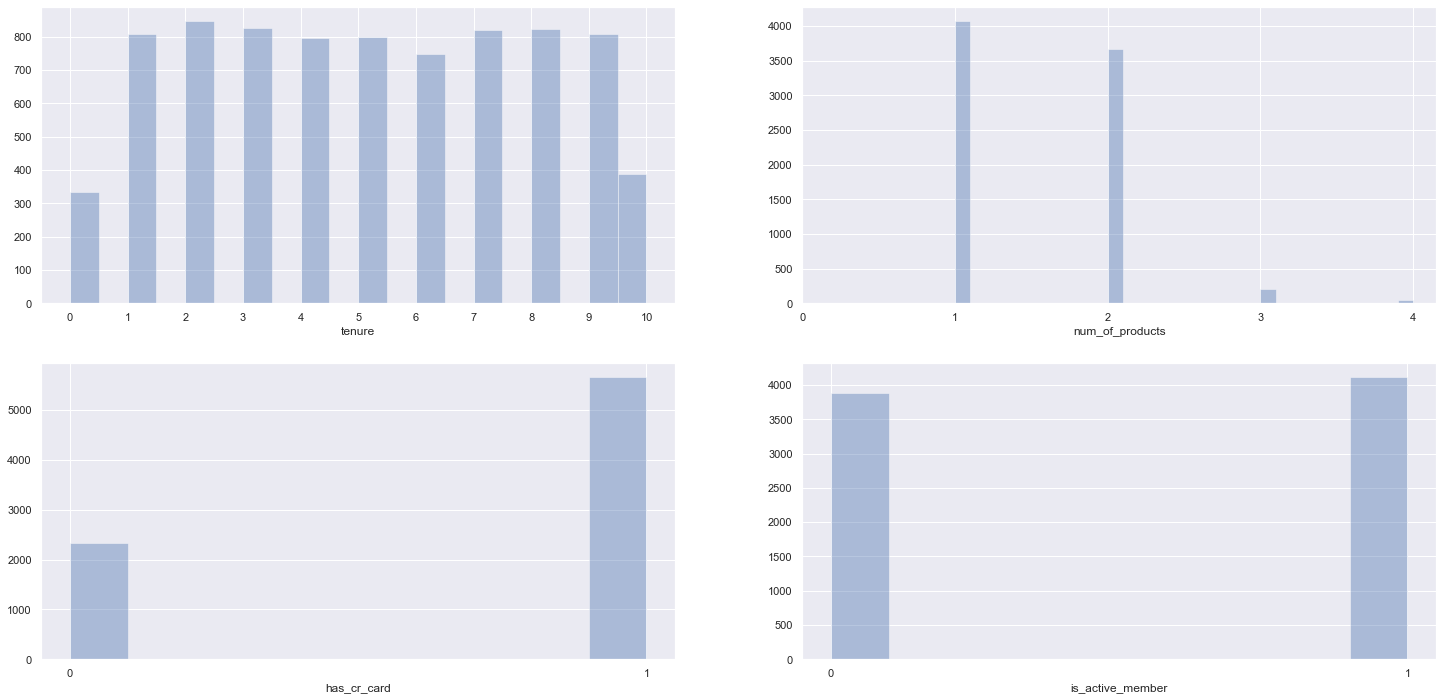

In [56]:
plt.subplot(2, 2, 1)
ax = sns.distplot(train_set['tenure'],kde=False)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.subplot(2, 2, 2)
ax = sns.distplot(train_set['num_of_products'],kde=False)
plt.xticks([0, 1, 2, 3, 4])

plt.subplot(2, 2, 3)
ax = sns.distplot(train_set['has_cr_card'],kde=False)
plt.xticks([0, 1])

plt.subplot(2, 2, 4)
ax = sns.distplot(train_set['is_active_member'],kde=False)
plt.xticks([0, 1]);

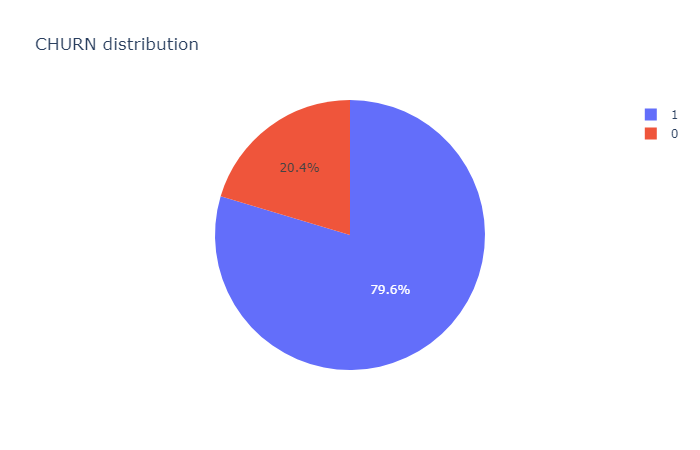

In [57]:
import plotly.graph_objects as go

data_ex = dict(type='pie', 
            labels=train_set['exited'].unique(),
            values=train_set['exited'].value_counts()
           )

layout = dict(title=dict(text='CHURN distribution'))
fig=go.Figure(data=data_ex, layout=layout)
fig.show(renderer='png')


#### 3.6.1.2 Conclusions

**credit_score**: TopBank uses FICO score scale to determine customer's Credit Score. This scale goes from 300 to 850 and defines customers as: <br>
&nbsp; Score &nbsp;&nbsp;| Classification <br>
300-629 | Bad <br>
630-689 | Fair <br>
690-719 | Good <br>
720-850 | Excelent <br>
<br>
All credit scores are in between the FICO range, from 350 to 850. The mean of scores is 650 +- 96 (Bad and Fair). The skew and kurtosis for this variable is very close to 0, so we can consider we have a normal distribution. However by evaluating the histogram, we can see that in the end we have a peak of clients with the highest credit scores. 75% of the clients are Good or below and more than half are Fair or below.

**age**: Client's age range from 18 to 92. It doesn't seem to be any entry errors in this variable. As there is some older clients, we may have to check if they churn due to their death. The average customer's age is 39 +- 10 years. The skew and kurtosis are positivewith a tendency of the tail ranging slight more to the right (older clients). This can be explained by the fact that clients must be 18 or older to have a bank account, therefore the maximum age is "farther" from the mean. It is also interesting to note that 75% of customers have 44 or less years and 50% of clients have between 32 to 44 years.

**tenure**: Up to half of costumers are clients with TopBank for 5 years. Tenure varies from 0 to 10 years and the mean is 5 +- 2.

**balance**: We have at least 25% of clients with balance = 0. We need to further investigate this because it may come from clients that already churn, or it may be some type of entry error, or the balance is indeed zero. Many clients that will close the bank account may withdraw all money in the account before leaving. With the quantity of zero account balances in mind, it makes sense that the kurtosis is negative. However, if we disconsider the zeros, we have a normal distribution. Most client's balance is less than 100,000 and the average balance is 76.485 +- 62.397. Again, the excessive number of zeros in this variable can cause some distortion.

**num_of_Products**: The number of products a client can acquire ranges from 1 to 4. At least half of the clients have only one product acquired, and most costumers have 1 to 2 products in their portfolio.

**has_cr_card**: Around 70% of customers do have a credit car.

**is_active_member**: A little more than half of the clients performed a transaction in the last 12 months.

**estimated_salary**: Client's estimated salary is quite balanced. The mean is 100,090.23 +- 57,510.49. We have to look further to understand the monthly salaries that are very low, as the minimum salary 11.58, that is way below the minimum salary in France, Germany and Spain.

**CLIENTS CURRENT IN CHURN**: 20.4%

Skewness is a measure of symmetry.
A positive skewness means that the mean/median is higher than the mode and it is skewed to the right.
A symmetrical distribution has the same mean, mode and median.
A negative skewness means that the mode is higher than the mean/median and it is skewed to the left.

Kurtosis is related to the distribution of tails.
A positive kurtosis shows a peak in the distriburion (heavy-tailed).
A negative kurtosis shows a flatten curve (light-tailed).

Outliers can affect kurtosis and skewness. A higher value of kurtosis/skewness usually means you have outliers.

### 3.6.2 Categorical Variables

#### 3.6.2.1 Visualizations

In [59]:
cat_attributes_train.describe()

surname geography gender
count   8000    8000      8000 
unique  2620    3         2    
top     Smith   France    Male 
freq    26      3993      4387

In [62]:
cat_attributes_train['geography'].value_counts(normalize=True)*100

France    49.912500
Germany   25.062500
Spain     25.025000
Name: geography, dtype: float64

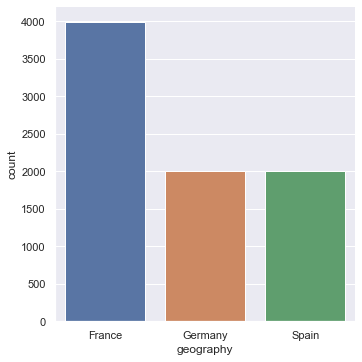

In [88]:
sns.catplot(x="geography", kind="count", data=train_set);

In [66]:
cat_attributes_train['gender'].value_counts(normalize=True)*100

Male     54.837500
Female   45.162500
Name: gender, dtype: float64

In [89]:
sns.catplot(x="gender", kind="count", data=train_set);

#### 3.6.2.2 Conclusions

Most of our clients are from France (nearly 50%). 

Our clients are mostly males (around 55% of the total).

The surname variable is not going to be used in the model as it doesn't add any relevant information.

# 4. Feature Engineering

In [67]:
train_set_1=train_set.copy()
test_set_1=test_set.copy()

## 4.1 Hypothesis

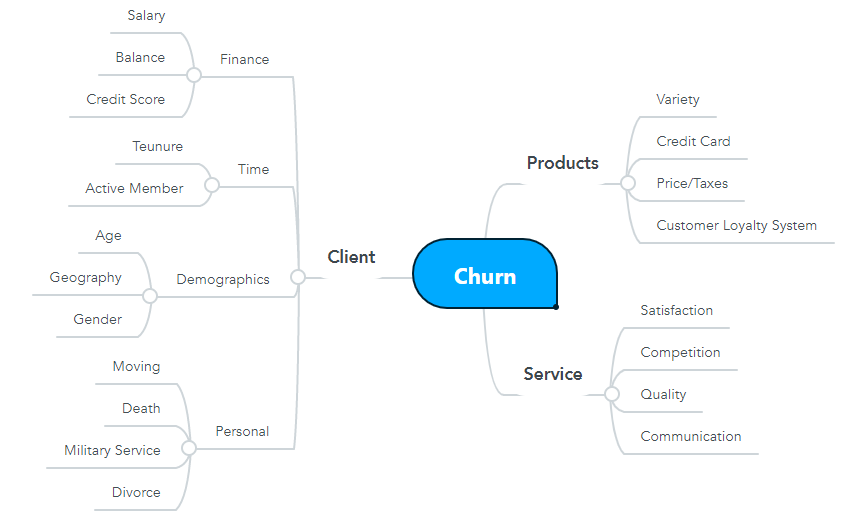

In [68]:
Image(filename='../images/hipoteses_pa003.png')

## 4.2 Feature Engineering

In [69]:
train_set_1['tenure_year'] = train_set['tenure']+1
train_set_1['balance_vs_salary'] = train_set['balance']/train_set['estimated_salary']
train_set_1['tenure_vs_products'] = train_set['tenure']/train_set['num_of_products']
train_set_1['age_class'] = train_set['age'].apply(lambda x: 'Young Adult' if x < 30 else ('Adult' if x>=30 and x<50 else ('Middle Age' if x>=50 and x<75 else 'Old')))
train_set_1['score_class'] = train_set['credit_score'].apply(lambda x: 'Bad' if x < 630 else('Fair' if x>=630 and x<690 else ('Good' if x>=690 and x<720 else 'Excelent')))
train_set_1['credit_vs_tenure']=train_set['credit_score']/train_set_1['tenure_year']
train_set_1['balance_vs_tenure']=train_set['balance']/train_set_1['tenure_year']
train_set_1['has_product_card']=train_set['num_of_products']*train_set['has_cr_card']

test_set_1['tenure_year'] = test_set['tenure']+1
test_set_1['balance_vs_salary'] = test_set['balance']/test_set['estimated_salary']
test_set_1['tenure_vs_products'] = test_set['tenure']/test_set['num_of_products']
test_set_1['age_class'] = test_set['age'].apply(lambda x: 'Young Adult' if x < 30 else ('Adult' if x>=30 and x<50 else ('Middle Age' if x>=50 and x<75 else 'Old')))
test_set_1['score_class'] = test_set['credit_score'].apply(lambda x: 'Bad' if x < 630 else('Fair' if x>=630 and x<690 else ('Good' if x>=690 and x<720 else 'Excelent')))
test_set_1['credit_vs_tenure']=test_set['credit_score']/test_set_1['tenure_year']
test_set_1['balance_vs_tenure']=test_set['balance']/test_set_1['tenure_year']
test_set_1['has_product_card']=test_set['num_of_products']*test_set['has_cr_card']

# 5. Filtering Variables

In [70]:
train_set_2 = train_set_1.copy()
test_set_2 = test_set_1.copy()

pyc_set = train_set_2.copy()

# We are dropping the following columns as they do not add value to the model
drop_columns = ['row_number','customer_id','surname']
train_set_2 =train_set_2.drop(columns=drop_columns,axis=1)
test_set_2 =test_set_2.drop(columns=drop_columns,axis=1)

# 6. Exploratory Data Analysis

In [71]:
train_set_3=train_set_2.copy()
test_set_3=test_set_2.copy()

num_attributes_train = train_set_3.select_dtypes( include = ['int64', 'float64','int32'])
cat_attributes_train = train_set_3.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]','int32'])

## 6.1 Target Variable

**We have unbalanced classes.**

In [37]:
aux1 = train_set_3.groupby('exited').count().reset_index()
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='exited', y='age', data=aux1).set_title('Churn count');
ax.set_ylabel('count')
ax.set_xticklabels(['No Churn','Churn']);

In [38]:
aux1 = train_set_3[['tenure', 'exited']].groupby('tenure').sum().reset_index()
plt.subplots(figsize=(12,8))
sns.barplot(x='tenure', y='exited', data=aux1, color='grey').set_title('Exited per tenure');



In [39]:
total_churn = train_set_3[train_set_3['exited']==1].shape[0]
total_no_churn = train_set_3[train_set_3['exited']==0].shape[0]
total = train_set_3.shape[0]

print(f'Number of Churn: {total_churn} ({round(total_churn/total, 2)*100}% of the total)')
print(f'Number of No Churn: {total_no_churn} ({round(total_no_churn/total, 2)*100}% of the total)')

Number of Churn: 1630 (20.0% of the total)
Number of No Churn: 6370 (80.0% of the total)


Tenure is higher for clients with 1 and 9 years of tenure.

## 6.2 Univariate Analysis

Here we evaluate if the variable itself brings important information to the target variable.<br>
We can see that some created features do not seem very useful and there's probably correlation between some variables. <br>
Also, we should evaluate the impact of zeros in balance and incoherent values in the estimated salary.

### 6.2.1 Numerical variables

In [78]:
plt.rcParams['figure.figsize'] = [30, 50]
num_yes = train_set_3[train_set_3['exited'] == 1]
num_no = train_set_3[train_set_3['exited'] == 0]
columns = num_attributes_train.columns.tolist()
j=1

for column in columns:
    plt.subplot(8, 2, j)
    sns.distplot(num_yes[column], color='orange', kde=True, label='churn')
    sns.distplot(num_no[column], kde=True, label='no churn')
    #plt.title(column);
    plt.legend()
    j += 1


In [41]:
#Plot histogram with target variable

#exited_num = train_set_3[['exited','credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']]
num_churn = train_set_3[train_set_3['exited'] == 1]
num_n_churn = train_set_3[train_set_3['exited'] == 0]

fig, ax = plt.subplots(3,2, figsize=(18,12))

ax[0,0].hist(num_n_churn['credit_score'], bins=80, alpha = 0.5, label='not churn') 
ax[0,0].hist(num_churn['credit_score'], bins=80, alpha = 0.7, label='churn') 
ax[0,0].legend() 
ax[0,0].set_title('credit_score')

ax[0,1].hist(num_n_churn['age'], bins=80, alpha = 0.5, label='not churn') 
ax[0,1].hist(num_churn['age'], bins=80, alpha = 0.7, label='churn') 
ax[0,1].legend() 
ax[0,1].set_title('age')

ax[1,0].hist(num_n_churn['tenure'], bins=80, alpha = 0.5, label='not churn') 
ax[1,0].hist(num_churn['tenure'], bins=80, alpha = 0.7, label='churn')
ax[1,0].legend() 
ax[1,0].set_title('tenure')

num_n_churn_z = num_n_churn[num_n_churn['balance'] != 0] #only the non zero values
num_churn_z = num_churn[num_churn['balance'] != 0]
ax[1,1].hist(num_n_churn_z['balance'], bins=80, alpha = 0.5, label='not churn') 
ax[1,1].hist(num_churn_z['balance'], bins=80, alpha = 0.7, label='churn') 
ax[1,1].legend() 
ax[1,1].set_title('balance')

ax[2,0].hist(num_n_churn['num_of_products'], bins=80, alpha = 0.5, label='not churn') 
ax[2,0].hist(num_churn['num_of_products'], bins=80, alpha = 0.7, label='churn')
ax[2,0].legend() 
ax[2,0].set_title('num_of_products')

ax[2,1].hist(num_n_churn['estimated_salary'], bins=80, alpha = 0.5, label='not churn') 
ax[2,1].hist(num_churn['estimated_salary'], bins=80, alpha = 0.7, label='churn')
ax[2,1].set_title('estimated_salary');

Credit Score: no much difference can be noticed between the credit score for clients that churn or not, however we should analyze an aparently trend in clients with lower credit score to churn a little more.

Age: there's a clear tendency of clients over 35-40 years to chun more.

Tenure: do not seem to impact much on churn

Balance: there's an increase in chur for costumers with balance between 100000 and 150000

Num of Products: Clients with 2 products seem to churn much less. Clients with 3 or 4 products show higher churn, but we need to remember that the amount of samples is small.

Has Credit Card: Churn seems to happen more when the client has credit card, but most clients with it do not churn.

Is Active Member: Churn seems to happen more when the client is not active. 

Estimated salary: There's no clear trend but we can investigate cases when churn happen for salaries over 170000

### 6.2.2 Categorical variables

In [91]:
sns.catplot(x="gender", kind="count", hue="exited", data=train_set_3);

In [92]:
pd.crosstab(train_set_3['gender'], train_set_3['exited'],normalize='index').round(4)*100

exited         0         1
gender                    
Female 74.920000 25.080000
Male   83.500000 16.500000

In [93]:
pd.crosstab(train_set_3['exited'], train_set_3['gender'],normalize='index').round(4)*100

gender    Female      Male
exited                    
0      42.500000 57.500000
1      55.580000 44.420000

Conclusions: <br>
Our clients are mostly males (around 55% of the total), with churn rate of 16,5%.  <br>
The churn rate for female is 25% and they represent 45% of clients in churn.<br>
 <br>

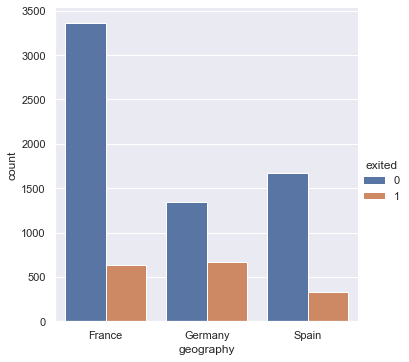

In [95]:
sns.catplot(x="geography", kind="count", hue="exited", data=train_set_3);

In [96]:
pd.crosstab(train_set_3['geography'], train_set_3['exited'],normalize='index').round(4)*100

exited            0         1
geography                    
France    84.100000 15.900000
Germany   66.930000 33.070000
Spain     83.420000 16.580000

In [97]:
pd.crosstab(train_set_3['exited'], train_set_3['geography'],normalize='index').round(4)*100

geography    France   Germany     Spain
exited                                 
0         52.720000 21.070000 26.220000
1         38.960000 40.670000 20.370000

Spain and France churn rates are similar (16-17%). 
However, the churn in Germany is higher than 32%, and it is the place where our market is smaller. Only 25% of clients are from Germany and they represent more than 40% of our total clients in churn! In comparison, French cliets represent 50% of all of our customers and 39% of clients in churn.

## 6.2 Bivariate Analysis - Hypothesis Validation

In [42]:
# create auxiliary dataframes
aux1 = train_set_3[train_set_3['exited']==0]
aux2 = train_set_3[train_set_3['exited']==1]

aux_country_median = train_set_3.groupby("geography").median().reset_index()
aux_country_mean = train_set_3.groupby("geography").mean().reset_index()

aux_ge = train_set_3[train_set_3['geography']=='Germany'].reset_index()
aux_fr = train_set_3[train_set_3['geography']=='France'].reset_index()
aux_sp = train_set_3[train_set_3['geography']=='Spain'].reset_index()

#### H1.1 Clients with higher estimated salary churn less.

FALSE. When the estimated salary is higher than 100,000 there is a tendency to churn more. Indeed, the average salary for clients that churn is higher than no churn, with highlight to salaries over 170000.

In [43]:
sal1=(aux1['estimated_salary'].mean())
sal2=(aux2['estimated_salary'].mean())


print(f'No churn estimated salary mean: {round(sal1, 2)}')
print(f'Churn estimated salary mean: {round(sal2, 2)}')

No churn estimated salary mean: 99143.25
Churn estimated salary mean: 102026.98


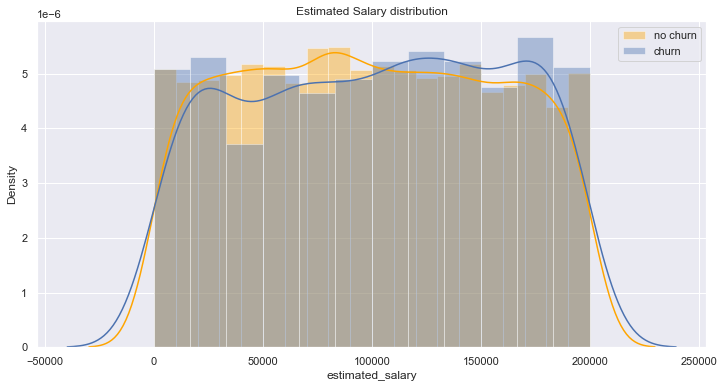

In [43]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['estimated_salary'], color='orange', kde=True, label='no churn')
sns.distplot(aux2['estimated_salary'], kde=True, label='churn')
plt.title('Estimated Salary distribution');
plt.legend();

In [87]:
plt.rcParams['figure.figsize'] = [8, 6]
sns.boxplot(x='exited', y='estimated_salary', data=train_set_3) ;

#### H1.2 Clients from Germany have higher salaries and churn more.

TRUE. As we can see from the normalized histogram, Germany has more clients in the last salary bin and less clients in the first salary bin. When we compare mean and median, the 3 countries show a similar value, with Germany being always the highest one. Churn was analyzed in the Descriptive Statistics

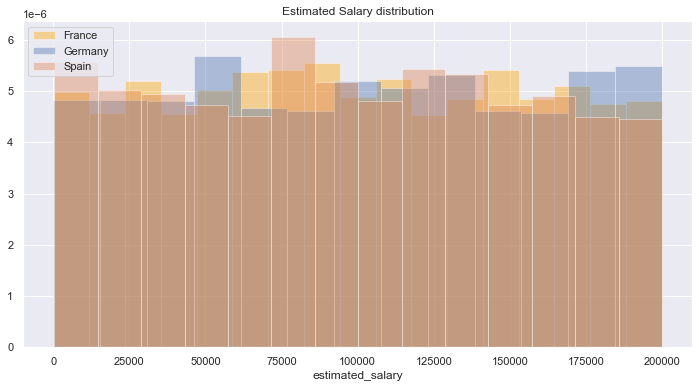

In [44]:
plt.figure(figsize=(12,6))
sns.distplot(aux_fr['estimated_salary'], color='orange', kde=False, label='France',norm_hist=True)
sns.distplot(aux_ge['estimated_salary'], kde=False, label='Germany',norm_hist=True)
sns.distplot(aux_sp['estimated_salary'], kde=False, label='Spain',norm_hist=True)
plt.title('Estimated Salary distribution');
plt.legend();

In [45]:
plt.figure(figsize=(12,6))
sns.distplot(aux_fr['estimated_salary'], color='orange', kde=False, label='France',norm_hist=True,bins=5)
sns.distplot(aux_ge['estimated_salary'], kde=False, label='Germany',norm_hist=True,bins=5)
sns.distplot(aux_sp['estimated_salary'], kde=False, label='Spain',norm_hist=True,bins=5)
plt.title('Estimated Salary distribution');
plt.legend();

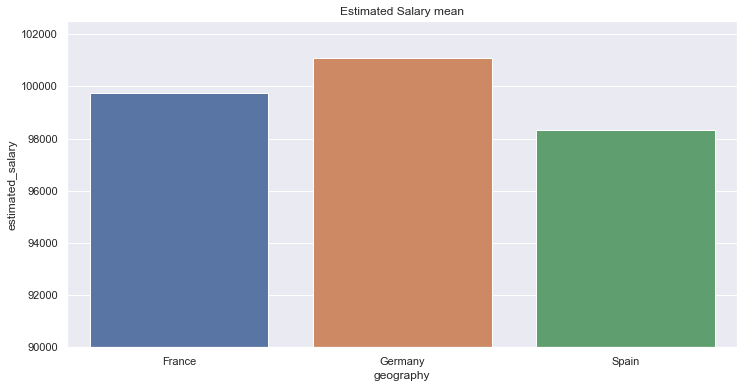

In [46]:
plt.figure(figsize=(12,6))
sns.barplot(x='geography',y='estimated_salary',data=aux_country_mean)
plt.ylim(90000, 102500)
plt.title('Estimated Salary mean');

In [47]:
plt.figure(figsize=(12,6))
sns.barplot(x='geography',y='estimated_salary',data=aux_country_median)
plt.ylim(90000, 102500)
plt.title('Estimated Salary median');

#### H1.3 Clients with higher salaries and lower balance churn more.

TRUE. There isn't a clear relationship between high salary and low balance. However, the ratio balance/estimated_salary is usually much lower for no churned clients.

In [48]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='estimated_salary',y='balance',hue='exited',data=train_set_3)

<AxesSubplot:xlabel='estimated_salary', ylabel='balance'>

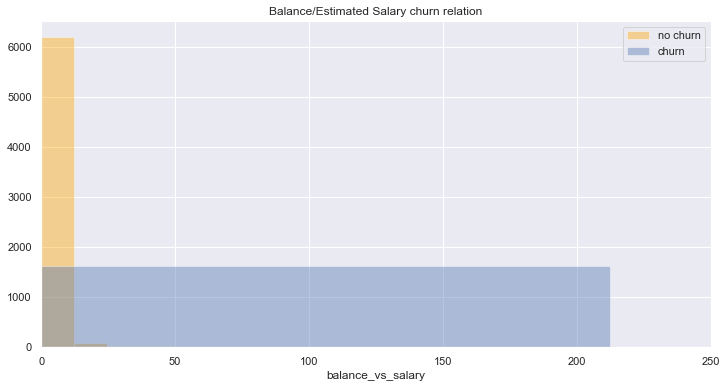

In [49]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['balance_vs_salary'], color='orange', kde=False, label='no churn')
sns.distplot(aux2['balance_vs_salary'], kde=False, label='churn')
plt.title('Balance/Estimated Salary churn relation');
plt.xlim(0,250)
plt.legend();

#### H1.4 Clients with lower credit score churn more.

TRUE. Even if we consider the gross number, the percentage of each class and the normalized histogram, it is possible to notice that clients with lower credit score slighly churn more. It is very important to notice that around 40% of our clients are in the Bad score zone. <br>

In [50]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['credit_score'], color='orange', kde=False, label='no churn',norm_hist=True)
sns.distplot(aux2['credit_score'], kde=False, label='churn',norm_hist=True)
plt.title('credit_score distribution');
plt.legend();

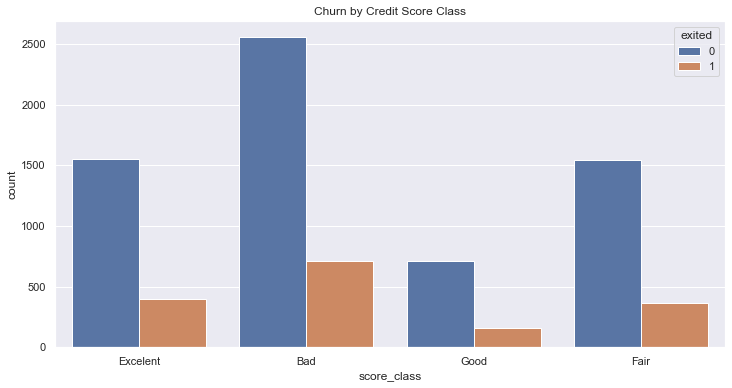

In [51]:
plt.figure(figsize=(12,6))
sns.countplot(x='score_class',hue='exited',data=train_set_3)
plt.title('Churn by Credit Score Class');



In [52]:
pd.crosstab(train_set_3['score_class'], train_set_3['exited']).apply(lambda r: round((r/r.sum()*100),2), axis=1)

exited              0         1
score_class                    
Bad         78.190000 21.810000
Excelent    79.760000 20.240000
Fair        80.870000 19.130000
Good        81.990000 18.010000

In [53]:
data=train_set_3['score_class'].value_counts(normalize=True)*100
plt.figure(figsize=(12,6))
sns.barplot(x=data.index, y=data);
plt.ylabel('%');
plt.title('Credit Score Class distribution');

#### H1.4 Younger clients have worst median credit score.

FALSE. Middle Age customers have the worst median credit score and the lowest credit scores in the dataset. Until 50 yo clients present a wide range of credit score. From 60 yo, the minimum credit score is around 500; from 75 yo it is around 600.

<AxesSubplot:xlabel='age', ylabel='credit_score'>

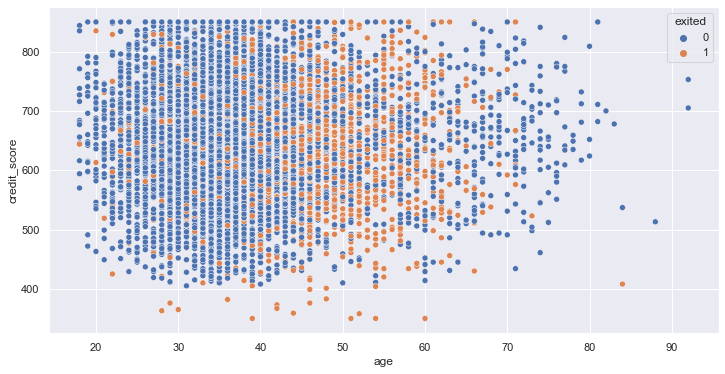

In [54]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='age',y='credit_score',data=train_set_3,hue='exited')

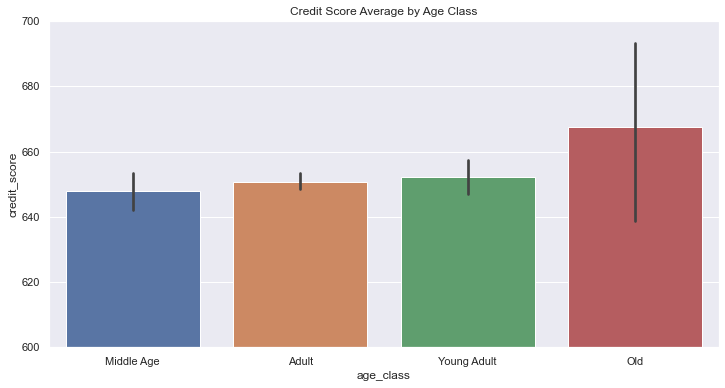

In [55]:
plt.figure(figsize=(12,6))
sns.barplot(y='credit_score',x='age_class',data=train_set_3)
plt.ylim(600, 700)
plt.title('Credit Score Average by Age Class');

#### H1.5 Clients over 75yo churn more.

FALSE. Actually, we do not have any clients churning over 75yo. The group that churns the most is Middle Age, with almost half of people churning. Adults is also an interesting group to analyse, as it represents 70% of all clients and the churn rate is around 18%. We should pay attention to clients from 40-75 years.

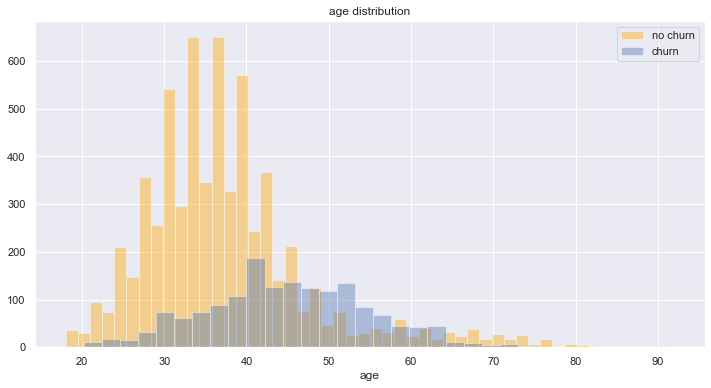

In [56]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['age'], color='orange', kde=False, label='no churn')
sns.distplot(aux2['age'], kde=False, label='churn')
plt.title('age distribution');
plt.legend();

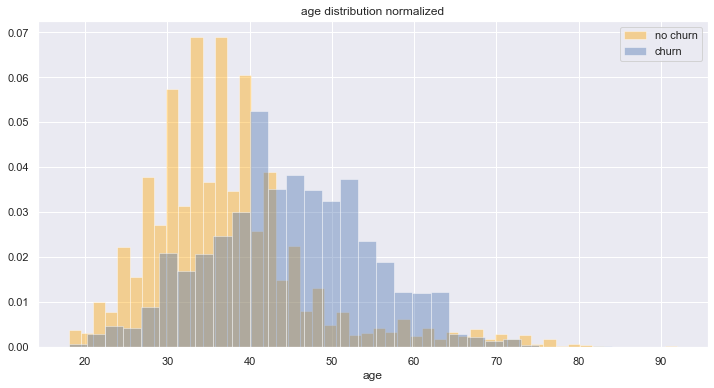

In [57]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['age'], color='orange', kde=False, label='no churn',norm_hist=True)
sns.distplot(aux2['age'], kde=False, label='churn',norm_hist=True)
plt.title('age distribution normalized');
plt.legend();

In [58]:
pd.crosstab(train_set_3['age_class'], train_set_3['exited']).apply(lambda r: round((r/r.sum()*100),2), axis=1)

exited              0         1
age_class                      
Adult       81.740000 18.260000
Middle Age  52.870000 47.130000
Old         97.780000 2.220000 
Young Adult 92.060000 7.940000

In [59]:
data=train_set_3['age_class'].value_counts(normalize=True)*100
plt.figure(figsize=(12,6))
sns.barplot(x=data.index, y=data);
plt.ylabel('%');
plt.title('Geography percentage');

#### H1.6 Clients with tenure less than 5 years churn 30% more than the rest

FALSE. Clients churn approximatly the same and 10% of them churn after the 1st year with the company.

In [60]:
pd.crosstab(train_set_3['tenure'], train_set_3['exited']).apply(lambda r: round((r/r.sum()*100),2), axis=1)

exited         0         1
tenure                    
0      77.010000 22.990000
1      77.750000 22.250000
2      81.460000 18.540000
3      79.300000 20.700000
4      80.150000 19.850000
5      79.880000 20.120000
6      79.520000 20.480000
7      82.300000 17.700000
8      80.340000 19.660000
9      78.000000 22.000000
10     77.320000 22.680000

In [61]:
aux_tenure_mean = train_set_3.groupby("tenure").mean().reset_index()
aux_tenure_mean['Percentage'] = 100 * aux_tenure_mean['exited']  / aux_tenure_mean['exited'].sum()
aux_tenure_mean['Percentage']

0    10.126622
1    9.802631 
2    8.166480 
3    9.120838 
4    8.745058 
5    8.866548 
6    9.023801 
7    7.800147 
8    8.661767 
9    9.693713 
10   9.992396 
Name: Percentage, dtype: float64

#### H1.6 Tenure varies with credit score

FALSE. The aaverage tenure for all credit scores is 5 years.

In [62]:
plt.figure(figsize=(12,6))
sns.barplot(y='credit_score',x='tenure',data=train_set_3)

<AxesSubplot:xlabel='tenure', ylabel='credit_score'>

<AxesSubplot:xlabel='score_class', ylabel='tenure'>

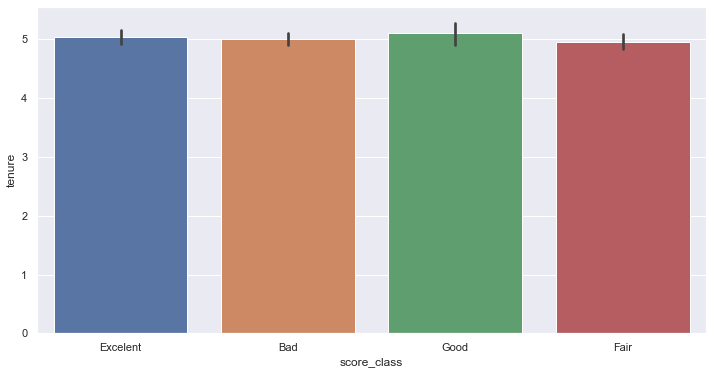

In [63]:
plt.figure(figsize=(12,6))
sns.barplot(y='tenure',x='score_class',data=train_set_3)

#### H1.6 Balance influences churn

TRUE. Clients with balance higher than 100000 churn more, specially between 100000 and 1500000.

In [64]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['balance'], color='orange', kde=False, label='no churn',norm_hist=True)
sns.distplot(aux2['balance'], kde=False, label='churn',norm_hist=True)
plt.title('balance distribution');
plt.legend();

#### H1.7 Clients with less products churn more and the number of products is affected by client's age, balance and salary.

There is a tendency that clients with more products churn more, however, the sample of customers that acquired 3 and 4 products is small. Regarding age, the average age of clients with 3 and 4 products is higher. The mean balance of clients with 2 products is much lower and clients with 2 products are the ones that churn less. On the other hand, the balance mean of clients with 1 product is the highest and clients with 1 product have a considerable churn. The estimated salary doesn't seem to have much influence in the number of products. However, for both balance and salary, the variance of values for 4 products is higher.

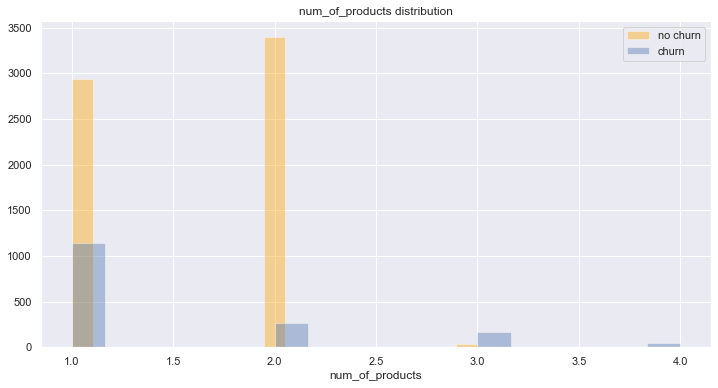

In [65]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['num_of_products'], color='orange', kde=False, label='no churn')
sns.distplot(aux2['num_of_products'], kde=False, label='churn')
plt.title('num_of_products distribution');
plt.legend();

<AxesSubplot:xlabel='num_of_products', ylabel='age'>

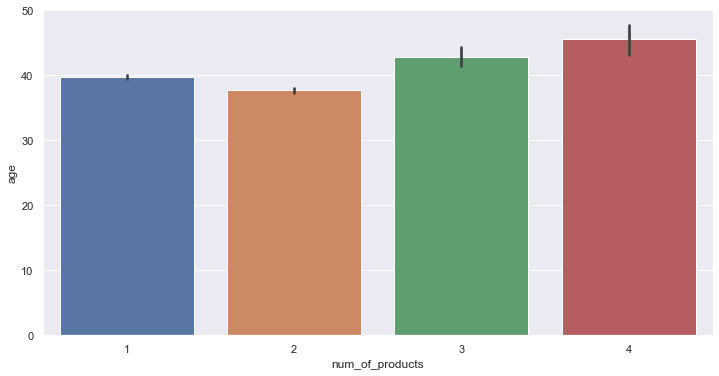

In [66]:
plt.figure(figsize=(12,6))
sns.barplot(y='age',x='num_of_products',data=train_set_3)



<AxesSubplot:xlabel='num_of_products', ylabel='balance'>

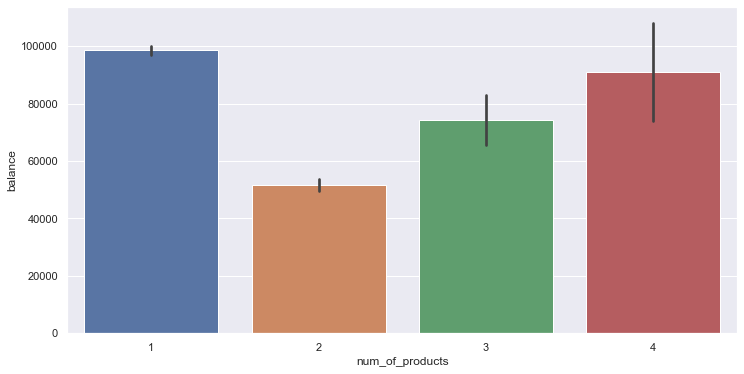

In [67]:
plt.figure(figsize=(12,6))
sns.barplot(y='balance',x='num_of_products',data=train_set_3)

<AxesSubplot:xlabel='num_of_products', ylabel='estimated_salary'>

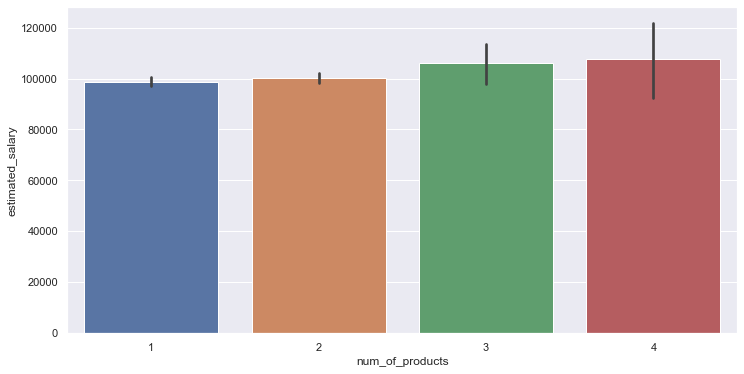

In [68]:
plt.figure(figsize=(12,6))
sns.barplot(y='estimated_salary',x='num_of_products',data=train_set_3)

#### H1.7 Clients with credit card churn more

FALSE. When comparing the churn between groups with or without credit card, we see the churn rate is very similar. However, we have almost the double of clients with credit card, meaning up to 70% of customers in churn having a credit card.

In [81]:
pd.crosstab(train_set_3['has_cr_card'], train_set_3['exited'],normalize='index').round(4)*100

exited              0         1
has_cr_card                    
0           78.710000 21.290000
1           80.000000 20.000000

In [83]:
train_set_3[['has_cr_card']].value_counts()




has_cr_card
1              5670
0              2330
dtype: int64

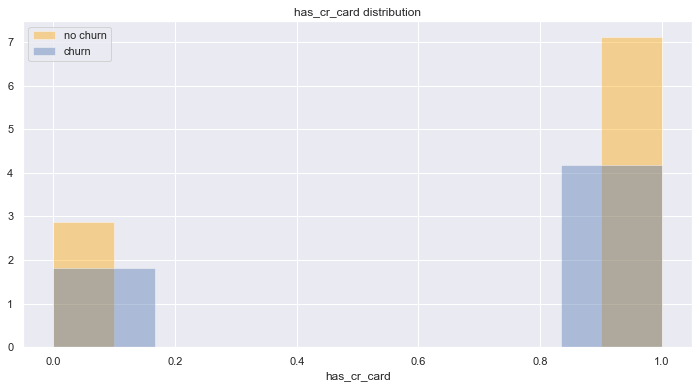

In [69]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['has_cr_card'], color='orange', kde=False, label='no churn',norm_hist=True)
sns.distplot(aux2['has_cr_card'], kde=False, label='churn',norm_hist=True)
plt.title('has_cr_card distribution');
plt.legend();

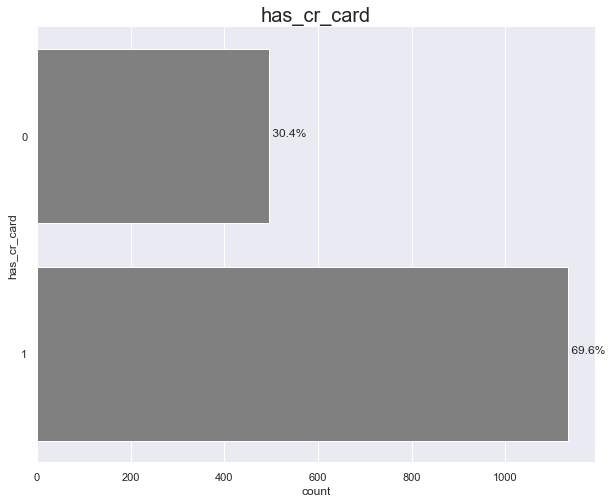

In [86]:
plt.figure(figsize(10,8))
aux1 = train_set_3[train_set_3['exited'] == 1 ]

ax = sns.countplot(y='has_cr_card', data=aux1, color='grey')
plt.title('has_cr_card', size =20)
sns.despine( bottom=True, left=True)
total = aux1['exited'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

#### H1.8 Inactive clients approximately churn more than active

TRUE. Actually, inactive clients churn almost the double than active clients

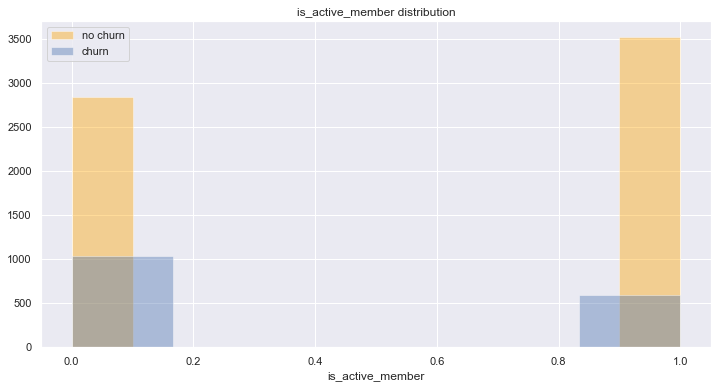

In [71]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['is_active_member'], color='orange', kde=False, label='no churn')
sns.distplot(aux2['is_active_member'], kde=False, label='churn')
plt.title('is_active_member distribution');
plt.legend();

<AxesSubplot:xlabel='is_active_member', ylabel='exited'>

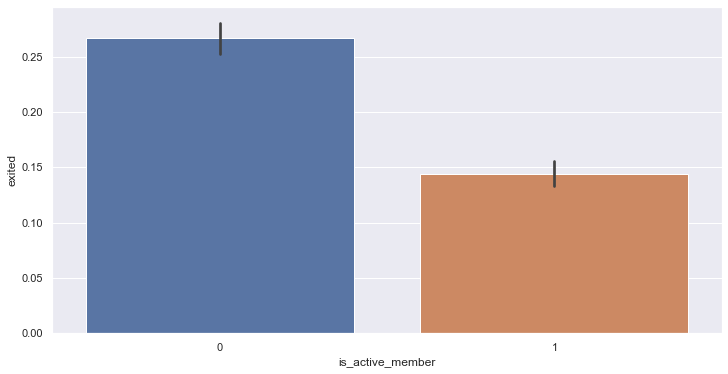

In [72]:
plt.figure(figsize=(12,6))
sns.barplot(y='exited',x='is_active_member',data=train_set_3)




In [73]:
pd.crosstab(train_set_3['is_active_member'], train_set_3['exited']).apply(lambda r: round((r/r.sum()*100),2), axis=1)

exited                   0         1
is_active_member                    
0                73.310000 26.690000
1                85.580000 14.420000

In [74]:
aux_active_mean = train_set_3.groupby("is_active_member").mean().reset_index()
aux_active_mean['Percentage'] = 100 * aux_active_mean['exited'] / aux_active_mean['exited'].sum()
aux_active_mean['Percentage']

0   64.925377
1   35.074623
Name: Percentage, dtype: float64

## 6.2.1 Hypothesis Summary

In [75]:
summary = pd.DataFrame({'Hypothesis':['Clients with higher estimated salary churn less.',
                                      'Clients from Germany have higher salaries and churn more.',
                                      'Clients with higher salaries and lower balance churn more.',
                                      'Clients with lower credit score churn more.',
                                      'Younger clients have worst median credit score.',
                                      'Clients over 75yo churn more.',
                                      'Clients with tenure less than 5 years churn 30% more than the rest',
                                      'Tenure varies with credit score',
                                      'Balance influences churn.',
                                      "Clients with less products churn more and the number of products is affected by client's age, balance and salary.",
                                      'Clients with credit card churn 20% more',
                                      'Inactive clients approximately churn more than active'
                                     ],
                        'True / False':['False', 'True', 'True', 'True', 'False', 'False', 'False', 'False', 'True', 'True',
                                        'False','True'], 
                        'Relevance':['Low', 'High', 'Medium', 'Low', 'Low', 'High', 'Low', 'Low', 'Low', 'High', 
                                     'Low','High']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
summary

Hypothesis True / False Relevance
1   Clients with higher estimated salary churn less.                                                                   False        Low     
2   Clients from Germany have higher salaries and churn more.                                                          True         High    
3   Clients with higher salaries and lower balance churn more.                                                         True         Medium  
4   Clients with lower credit score churn more.                                                                        True         Low     
5   Younger clients have worst median credit score.                                                                    False        Low     
6   Clients over 75yo churn more.                                                                                      False        High    
7   Clients with tenure less than 5 years churn 30% more than the rest                                                 False        Low     
8   Tenure varies with credit score                                                                                    False        Low     
9   Balance influences churn.                                                                                          True         Low     
10  Clients with less products churn more and the number of products is affected by client's age, balance and salary.  True         High    
11  Clients with credit card churn 20% more                                                                            False        Low     
12  Inactive clients approximately churn more than active                                                              True         High

## 6.3 Multivariate Analysis - Correlation

In [76]:
num_attributes = train_set_3.select_dtypes( include = ['int64', 'float64','int32'])
cat_attributes = train_set_3.select_dtypes( include = 'object')

## 6.3.1 Numerical Variables

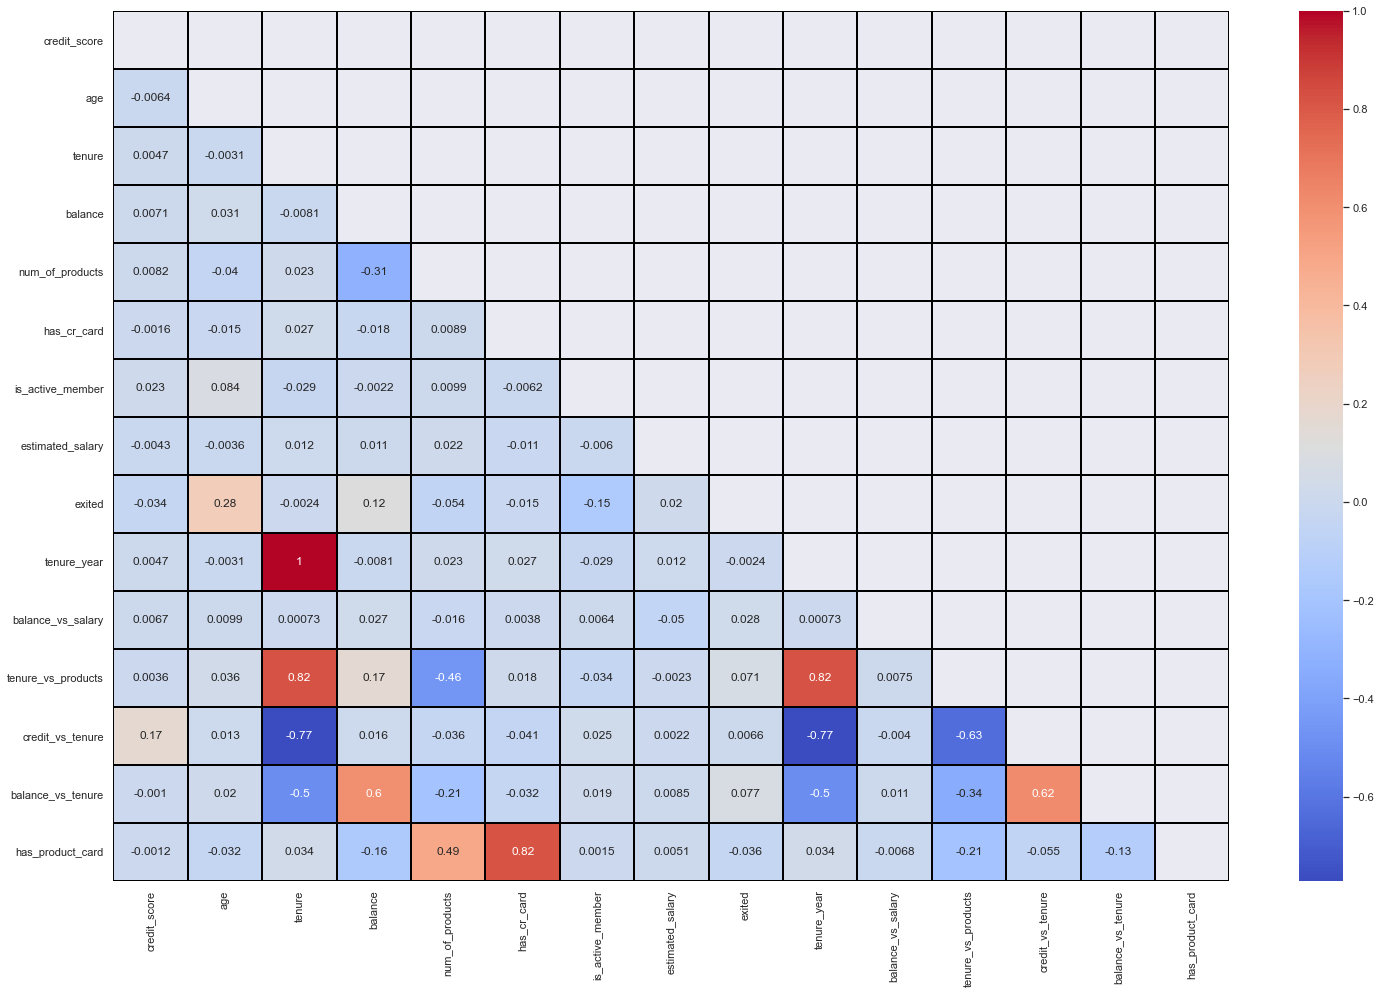

In [77]:
# gets the correlation between the numerical variables
correlation = num_attributes.corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 16)

# plots the heatmap
matrix = np.triu(correlation)

sns.heatmap(correlation, annot=True, cmap='coolwarm',linewidths=1, linecolor='black',mask=matrix)

# displays the plot
plt.show()

## 6.3.2 Categorical Variables

In [78]:
cat_attributes['has_cr_card_cat'] = train_set_3['has_cr_card'].apply(lambda x: 'Yes' if x == 1 else 'No')
cat_attributes['is_active_member_cat'] = train_set_3['is_active_member'].apply(lambda x: 'Yes' if x == 1 else 'No')
cat_attributes

geography  gender   age_class score_class has_cr_card_cat is_active_member_cat
2151  France    Male    Middle Age  Excelent    Yes             No                 
8392  Germany   Male    Adult       Excelent    Yes             No                 
5006  Germany   Female  Adult       Excelent    Yes             Yes                
4117  France    Male    Adult       Bad         Yes             No                 
7182  Germany   Male    Adult       Good        No              Yes                
...       ...    ...      ...        ...        ..              ...                
4555  Spain     Female  Adult       Fair        Yes             No                 
4644  Spain     Male    Middle Age  Good        No              No                 
8942  France    Female  Adult       Fair        Yes             Yes                
2935  Spain     Male    Adult       Fair        Yes             No                 
6206  Spain     Male    Middle Age  Excelent    No              Yes                

[8000 rows x 6 columns]

In [79]:
from scipy.stats import chi2_contingency

a1 = cramer_v(cat_attributes['geography'], cat_attributes['geography'])
a2 = cramer_v(cat_attributes['geography'], cat_attributes['gender'])
a3 = cramer_v(cat_attributes['geography'], cat_attributes['age_class'])
a4 = cramer_v(cat_attributes['geography'], cat_attributes['score_class'])
a5 = cramer_v(cat_attributes['geography'], cat_attributes['has_cr_card_cat'])
a6 = cramer_v(cat_attributes['geography'], cat_attributes['is_active_member_cat'])

a7 = cramer_v(cat_attributes['gender'], cat_attributes['geography'])
a8 = cramer_v(cat_attributes['gender'], cat_attributes['gender'])
a9 = cramer_v(cat_attributes['gender'], cat_attributes['age_class'])
a10 = cramer_v(cat_attributes['gender'], cat_attributes['score_class'])
a11 = cramer_v(cat_attributes['gender'], cat_attributes['has_cr_card_cat'])
a12 = cramer_v(cat_attributes['gender'], cat_attributes['is_active_member_cat'])

a13 = cramer_v(cat_attributes['age_class'], cat_attributes['geography'])
a14 = cramer_v(cat_attributes['age_class'], cat_attributes['gender'])
a15 = cramer_v(cat_attributes['age_class'], cat_attributes['age_class'])
a16 = cramer_v(cat_attributes['age_class'], cat_attributes['score_class'])
a17 = cramer_v(cat_attributes['age_class'], cat_attributes['has_cr_card_cat'])
a18 = cramer_v(cat_attributes['age_class'], cat_attributes['is_active_member_cat'])

a19 = cramer_v(cat_attributes['score_class'], cat_attributes['geography'])
a20 = cramer_v(cat_attributes['score_class'], cat_attributes['gender'])
a21 = cramer_v(cat_attributes['score_class'], cat_attributes['age_class'])
a22 = cramer_v(cat_attributes['score_class'], cat_attributes['score_class'])
a23 = cramer_v(cat_attributes['score_class'], cat_attributes['has_cr_card_cat'])
a24 = cramer_v(cat_attributes['score_class'], cat_attributes['is_active_member_cat'])

a25 = cramer_v(cat_attributes['has_cr_card_cat'], cat_attributes['geography'])
a26 = cramer_v(cat_attributes['has_cr_card_cat'], cat_attributes['gender'])
a27 = cramer_v(cat_attributes['has_cr_card_cat'], cat_attributes['age_class'])
a28 = cramer_v(cat_attributes['has_cr_card_cat'], cat_attributes['score_class'])
a29 = cramer_v(cat_attributes['has_cr_card_cat'], cat_attributes['has_cr_card_cat'])
a30 = cramer_v(cat_attributes['has_cr_card_cat'], cat_attributes['is_active_member_cat'])

a31 = cramer_v(cat_attributes['is_active_member_cat'], cat_attributes['geography'])
a32 = cramer_v(cat_attributes['is_active_member_cat'], cat_attributes['gender'])
a33 = cramer_v(cat_attributes['is_active_member_cat'], cat_attributes['age_class'])
a34 = cramer_v(cat_attributes['is_active_member_cat'], cat_attributes['score_class'])
a35 = cramer_v(cat_attributes['is_active_member_cat'], cat_attributes['has_cr_card_cat'])
a36 = cramer_v(cat_attributes['is_active_member_cat'], cat_attributes['is_active_member_cat'])

# builds the dataset to make the correlations
d = pd.DataFrame({'geography': [a1, a2, a3, a4, a5, a6],
                  'gender': [a7, a8, a9, a10, a11, a12],
                  'age_class': [a13, a14, a15, a16, a17, a18],
                  'score_class': [a19, a20, a21, a22, a23, a24],
                  'has_cr_card_cat': [a25, a26, a27, a28, a29, a30],
                  'is_active_member_cat': [a31, a32, a33, a34, a35, a36]
             })

# sets index equal to columns
d = d.set_index(d.columns)
d


geography   gender  age_class  score_class  has_cr_card_cat  is_active_member_cat
geography            1.000125   0.026415 0.034370   0.021925     0.013952         0.026819             
gender               0.026415   0.999810 0.015463   0.015145     0.002880         0.028017             
age_class            0.034370   0.015463 1.000188   0.017441     0.016970         0.113412             
score_class          0.021925   0.015145 0.017441   1.000188     0.003486         0.017406             
has_cr_card_cat      0.013952   0.002880 0.016970   0.003486     0.999760         0.005967             
is_active_member_cat 0.026819   0.028017 0.113412   0.017406     0.005967         0.999812

## 6.4 Conclusions

Numerical: remove tenure_year, credit_vs_tenure
Categorical: do not remove any feature

In [80]:
df3_drop_columns = ['tenure_year','credit_vs_tenure']
train_set_3 =train_set_3.drop(columns=df3_drop_columns,axis=1)
test_set_3 =test_set_3.drop(columns=df3_drop_columns,axis=1)

# 7. Data Preparation

In [81]:
train_set_4 = train_set_3.copy()
test_set_4 = test_set_3.copy()

In [82]:
test_set_4.sample(19)

credit_score geography  gender  age  tenure        balance  num_of_products  has_cr_card  is_active_member  estimated_salary  exited  balance_vs_salary  tenure_vs_products    age_class score_class  balance_vs_tenure  has_product_card
4900  735           France    Male    41   7      179,904.000000  1                1            1                137,180.950000     0      1.311436           7.000000             Adult        Excelent   22,488.000000       1               
9093  527           France    Male    31   4      0.000000        1                1            0                169,361.890000     0      0.000000           4.000000             Adult        Bad        0.000000            1               
3786  710           Germany   Female  41   9      149,155.530000  2                1            0                42,131.260000      1      3.540258           4.500000             Adult        Good       14,915.553000       2               
4263  746           Spain     Male    24   10     68,781.820000   1                0            1                47,997.390000      0      1.433033           10.000000            Young Adult  Excelent   6,252.892727        0               
5227  701           France    Male    23   3      0.000000        2                1            0                38,960.590000      0      0.000000           1.500000             Young Adult  Good       0.000000            2               
1443  556           France    Female  43   6      0.000000        3                0            0                125,154.570000     1      0.000000           2.000000             Adult        Bad        0.000000            0               
6699  709           France    Female  41   3      150,300.650000  2                1            0                71,672.860000      0      2.097037           1.500000             Adult        Good       37,575.162500       2               
3500  850           France    Female  32   5      106,290.640000  1                1            0                121,982.730000     0      0.871358           5.000000             Adult        Excelent   17,715.106667       1               
7552  636           Spain     Male    76   9      126,534.600000  1                1            1                39,789.620000      0      3.180091           9.000000             Old          Fair       12,653.460000       1               
4290  650           Spain     Female  23   5      0.000000        1                1            1                180,622.430000     0      0.000000           5.000000             Young Adult  Fair       0.000000            1               
1787  669           France    Male    25   1      157,848.530000  1                0            0                37,543.930000      1      4.204369           1.000000             Young Adult  Fair       78,924.265000       0               
9076  666           France    Female  27   1      85,225.210000   1                0            1                64,511.440000      0      1.321087           1.000000             Young Adult  Fair       42,612.605000       0               
778   754           France    Male    28   8      0.000000        2                1            1                52,615.620000      0      0.000000           4.000000             Young Adult  Excelent   0.000000            2               
3757  593           Spain     Female  45   6      79,259.750000   1                1            0                55,347.280000      0      1.432044           6.000000             Adult        Bad        11,322.821429       1               
3938  483           Germany   Male    41   1      118,334.440000  1                0            0                163,147.990000     1      0.725320           1.000000             Adult        Bad        59,167.220000       0               
7566  574           Spain     Male    36   4      77,967.500000   1                1            0                167,066.950000     1      0.466684           4.000000

## 7.1 Encoding Variables

In [83]:
# geography
train_set_4 = pd.get_dummies(train_set_4, columns = ['geography'])
test_set_4 = pd.get_dummies(test_set_4, columns = ['geography'])

# gender
train_set_4 = pd.get_dummies(train_set_4, columns = ['gender'],drop_first=True)
test_set_4 = pd.get_dummies(test_set_4, columns = ['gender'],drop_first=True)

# age_class
from sklearn.preprocessing import OrdinalEncoder
orde = OrdinalEncoder(categories=[['Young Adult','Adult','Middle Age','Old']])
train_set_4['age_class_encod'] = orde.fit_transform(train_set_4[['age_class']]).astype('int')
test_set_4['age_class_encod'] = orde.fit_transform(test_set_4[['age_class']]).astype('int')

# score_class
orde2 = OrdinalEncoder(categories=[['Bad','Fair','Good','Excelent']])
train_set_4['score_class_encod'] = orde2.fit_transform(train_set_4[['score_class']]).astype('int')
test_set_4['score_class_encod'] = orde2.fit_transform(test_set_4[['score_class']]).astype('int')

## 7.2 Creating Balanced Dataset

In [84]:
test_set_4_smt = test_set_4.copy()
from imblearn   import combine         as c

df4_drop_columns = ['age_class','score_class']
train_set_4 =train_set_4.drop(columns=df4_drop_columns,axis=1)
test_set_4 =test_set_4.drop(columns=df4_drop_columns,axis=1)
test_set_4_smt =test_set_4_smt.drop(columns=df4_drop_columns,axis=1)


# define sampler
smt = c.SMOTETomek( sampling_strategy='all', random_state=32, n_jobs=-1 )

# apply sampler
X_smt, y_smt = smt.fit_resample( train_set_4, train_set_4['exited'] )

In [85]:
X_smt.dtypes

credit_score          int64  
age                   int64  
tenure                int64  
balance               float64
num_of_products       int64  
has_cr_card           int64  
is_active_member      int64  
estimated_salary      float64
exited                int64  
balance_vs_salary     float64
tenure_vs_products    float64
balance_vs_tenure     float64
has_product_card      int64  
geography_France      uint8  
geography_Germany     uint8  
geography_Spain       uint8  
gender_Male           uint8  
age_class_encod       int32  
score_class_encod     int32  
dtype: object

## 7.3 Scalling Variables

In [86]:
rs = RobustScaler()
mms = MinMaxScaler()
ss =StandardScaler()

### 7.3.1 Balanced Dataset

In [87]:
X_smt['credit_score'] = ss.fit_transform( X_smt[['credit_score']].values )
test_set_4_smt['credit_score'] = ss.transform( test_set_4_smt[['credit_score']].values )

X_smt['num_of_products'] = ss.fit_transform( X_smt[['num_of_products']].values )
test_set_4_smt['num_of_products'] = ss.transform( test_set_4_smt[['num_of_products']].values )

X_smt['age'] = mms.fit_transform( X_smt[['age']].values )
test_set_4_smt['age'] = mms.transform( test_set_4_smt[['age']].values )

X_smt['tenure'] = mms.fit_transform( X_smt[['tenure']].values )
test_set_4_smt['tenure'] = mms.transform( test_set_4_smt[['tenure']].values )

X_smt['balance'] = rs.fit_transform( X_smt[['balance']].values )
test_set_4_smt['balance'] = rs.transform( test_set_4_smt[['balance']].values )

X_smt['estimated_salary'] = rs.fit_transform( X_smt[['estimated_salary']].values )
test_set_4_smt['estimated_salary'] = rs.transform( test_set_4_smt[['estimated_salary']].values )

X_smt['balance_vs_salary'] = rs.fit_transform( X_smt[['balance_vs_salary']].values )
test_set_4_smt['balance_vs_salary'] = rs.transform( test_set_4_smt[['balance_vs_salary']].values )

X_smt['tenure_vs_products'] = rs.fit_transform( X_smt[['tenure_vs_products']].values )
test_set_4_smt['tenure_vs_products'] = rs.transform( test_set_4_smt[['tenure_vs_products']].values )

X_smt['tenure'] = mms.fit_transform( X_smt[['tenure']].values )
test_set_4_smt['tenure'] = mms.transform( test_set_4_smt[['tenure']].values )

X_smt['balance_vs_tenure'] = rs.fit_transform( X_smt[['balance_vs_tenure']].values )
test_set_4_smt['balance_vs_tenure'] = rs.transform( test_set_4_smt[['balance_vs_tenure']].values )


### 7.3.2 Imbalanced Dataset

In [88]:
train_set_4['credit_score'] = ss.fit_transform( train_set_4[['credit_score']].values )
test_set_4['credit_score'] = ss.transform( test_set_4[['credit_score']].values )

train_set_4['num_of_products'] = ss.fit_transform( train_set_4[['num_of_products']].values )
test_set_4['num_of_products'] = ss.transform( test_set_4[['num_of_products']].values )

train_set_4['age'] = mms.fit_transform( train_set_4[['age']].values )
test_set_4['age'] = mms.transform( test_set_4[['age']].values )

train_set_4['tenure'] = mms.fit_transform( train_set_4[['tenure']].values )
test_set_4['tenure'] = mms.transform( test_set_4[['tenure']].values )
train_set_4
train_set_4['balance'] = rs.fit_transform( train_set_4[['balance']].values )
test_set_4['balance'] = rs.transform( test_set_4[['balance']].values )

train_set_4['estimated_salary'] = rs.fit_transform( train_set_4[['estimated_salary']].values )
test_set_4['estimated_salary'] = rs.transform( test_set_4[['estimated_salary']].values )

train_set_4['balance_vs_salary'] = rs.fit_transform( train_set_4[['balance_vs_salary']].values )
test_set_4['balance_vs_salary'] = rs.transform( test_set_4[['balance_vs_salary']].values )

train_set_4['tenure_vs_products'] = rs.fit_transform( train_set_4[['tenure_vs_products']].values )
test_set_4['tenure_vs_products'] = rs.transform( test_set_4[['tenure_vs_products']].values )

train_set_4['tenure'] = mms.fit_transform( train_set_4[['tenure']].values )
test_set_4['tenure'] = mms.transform( test_set_4[['tenure']].values )

train_set_4['balance_vs_tenure'] = rs.fit_transform( train_set_4[['balance_vs_tenure']].values )
test_set_4['balance_vs_tenure'] = rs.transform( test_set_4[['balance_vs_tenure']].values )


## 7.4 Final Datasets

In [89]:
X_smt=X_smt.drop(columns='exited',axis=1)
#y_smt
X_test_smt=test_set_4_smt.drop(columns='exited',axis=1)
y_test_smt=test_set_4_smt['exited']

X_train_imb = train_set_4.drop(columns='exited',axis=1)
y_train_imb = train_set_4['exited']
X_test_imb =test_set_4.drop(columns='exited',axis=1)
y_test_imb =test_set_4['exited']


X_smt.sample(10)

credit_score      age   tenure   balance  num_of_products  has_cr_card  is_active_member  estimated_salary  balance_vs_salary  tenure_vs_products  balance_vs_tenure  has_product_card  geography_France  geography_Germany  geography_Spain  gender_Male  age_class_encod  score_class_encod
3393 -0.591595     0.270270 0.500000 -0.152189 -0.724355         1            1                0.235217          -0.090674          0.398136            -0.010690           1                 0                 1                  0                0            1                0                
2331 0.269775      0.216216 0.100000 0.168090  2.760166          0            1                -0.257185         0.500801           -0.840510           1.937074            0                 0                 1                  0                0            1                1                
286  -0.268581     0.121622 0.400000 0.117049  -0.724355         0            0                0.409177          0.008477           0.132712            0.377788            0                 1                 0                  0                1            0                0                
2710 0.194405      0.756757 0.700000 -0.001869 -0.724355         1            1                -0.567942         0.877156           0.928984            -0.055473           1                 0                 1                  0                1            2                1                
6490 -0.354718     0.067568 0.400000 -0.813078 1.017905          1            0                0.961929          -0.506922          -0.398136           -0.574629           2                 1                 0                  0                0            0                0                
3622 0.603556      0.175676 0.500000 0.206387  2.760166          1            1                -0.483439         0.967391           -0.486611           0.295284            3                 1                 0                  0                1            1                2                
621  1.464925      0.405405 0.700000 -0.813078 1.017905          1            1                0.820792          -0.506922          0.000000            -0.574629           2                 0                 0                  1                1            1                3                
209  -0.376252     0.108108 0.400000 -0.037805 -0.724355         0            1                0.485346          -0.098812          0.132712            0.219223            0                 1                 0                  0                1            0                0                
1339 0.215939      0.135135 0.400000 0.013867  -0.724355         1            0                0.926737          -0.169411          0.132712            0.272133            1                 1                 0                  0                1            0                1                
6983 0.162104      0.324324 0.500000 -0.116514 -0.724355         1            1                -0.232078         0.186205           0.398136            0.019752            1                 0                 1                  0                1            1                1

# 8. Feature Selection

## 8.1 Boruta Feature Selection

### 8.1.1 Imbalanced Dataset

In [90]:
X_boruta_imb = X_train_imb.values
y_boruta_imb = y_train_imb.values.ravel()

In [91]:
rf = RandomForestClassifier()

boruta = BorutaPy(rf, n_estimators='auto')
boruta.fit(X_boruta_imb, y_boruta_imb)
cols_selected_boruta = boruta.support_.tolist()
columns_selected = X_smt.loc[:, cols_selected_boruta].columns.tolist() 

In [92]:
columns_selected #['age', 'balance', 'num_of_products', 'estimated_salary']

['age', 'balance', 'num_of_products', 'estimated_salary']

### 8.1.2 Balanced Dataset

In [93]:
X_boruta_bal = X_smt.values
y_boruta_bal = y_smt.values.ravel()

In [94]:
rf = RandomForestClassifier()

boruta = BorutaPy(rf, n_estimators='auto')
boruta.fit(X_boruta_bal, y_boruta_bal)
cols_selected_boruta = boruta.support_.tolist()
columns_selected = X_train_imb.loc[:, cols_selected_boruta].columns.tolist() 

In [95]:
columns_selected
#['credit_score', 'age', 'balance', 'num_of_products', 'is_active_member', 'estimated_salary', 'balance_vs_salary', 'tenure_vs_products', 'balance_vs_tenure', 'has_product_card', 'geography_France', 'geography_Spain', 'gender_Male']

['credit_score',
 'age',
 'balance',
 'num_of_products',
 'is_active_member',
 'estimated_salary',
 'balance_vs_salary',
 'tenure_vs_products',
 'balance_vs_tenure',
 'has_product_card',
 'geography_France',
 'geography_Spain',
 'gender_Male']

## 8.2 Random Forest Feature Importance

In [100]:
rf = RandomForestClassifier()
rf.fit(X_smt,y_smt)
rf.feature_importances_

rf2 = RandomForestClassifier()
rf2.fit(X_train_imb,y_train_imb)
rf2.feature_importances_

array([0.09605222, 0.17923737, 0.04185377, 0.08443924, 0.08852452,
       0.01096409, 0.04490597, 0.09738125, 0.0690761 , 0.04952502,
       0.07156683, 0.04887978, 0.01096388, 0.0210585 , 0.00996141,
       0.01724945, 0.03405212, 0.02430847])

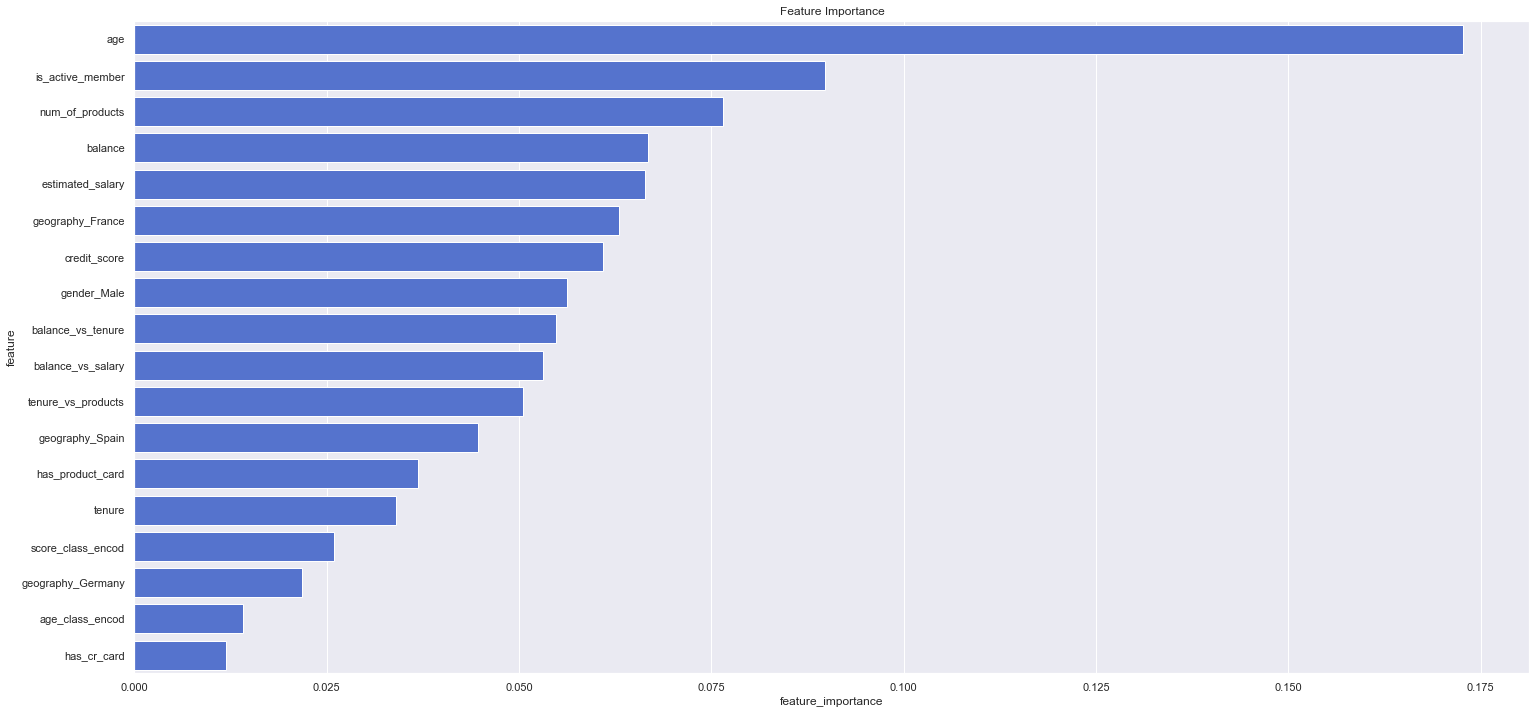

In [101]:
feat_imp = pd.DataFrame({'feature': X_smt.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)

sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

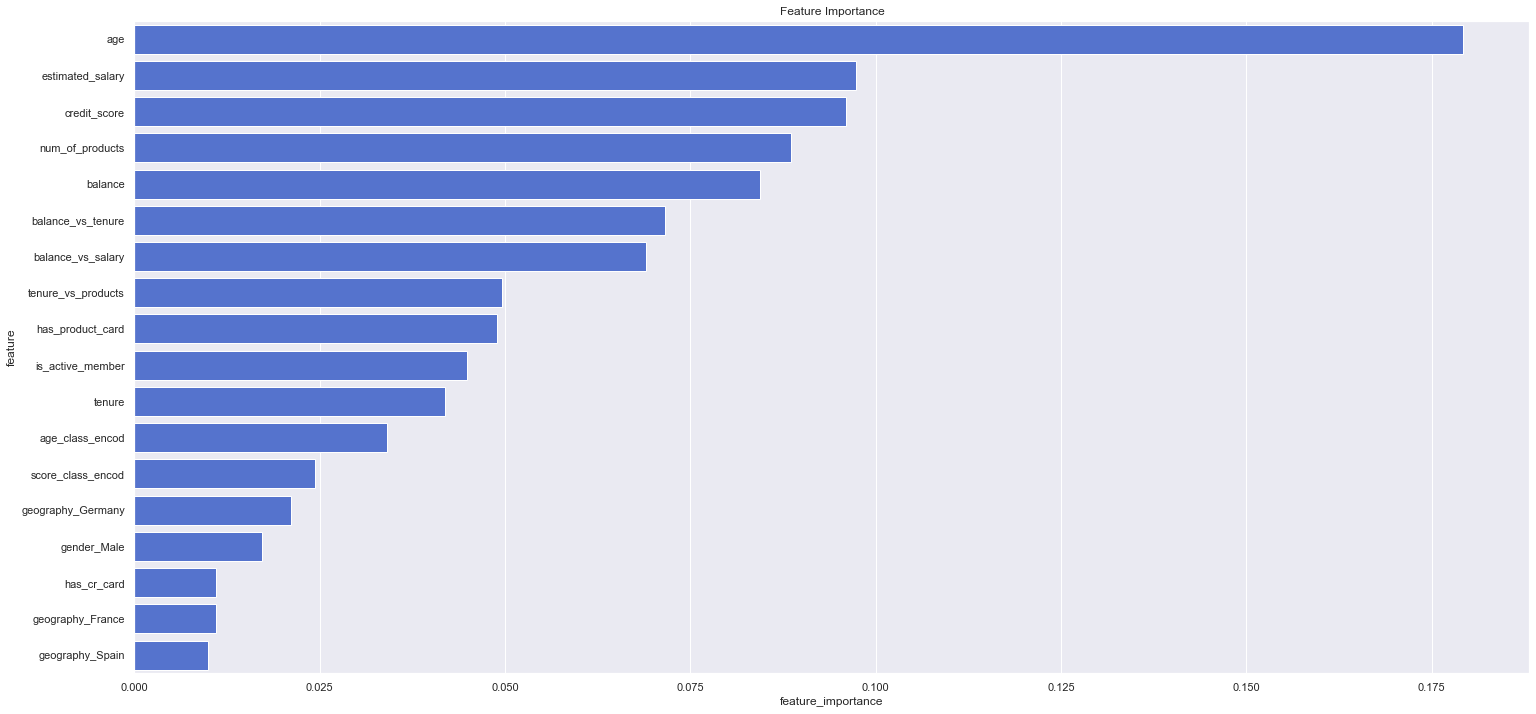

In [102]:
feat_imp = pd.DataFrame({'feature': X_train_imb.columns,
                        'feature_importance': rf2.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)

sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

## 8.3 XGBoost

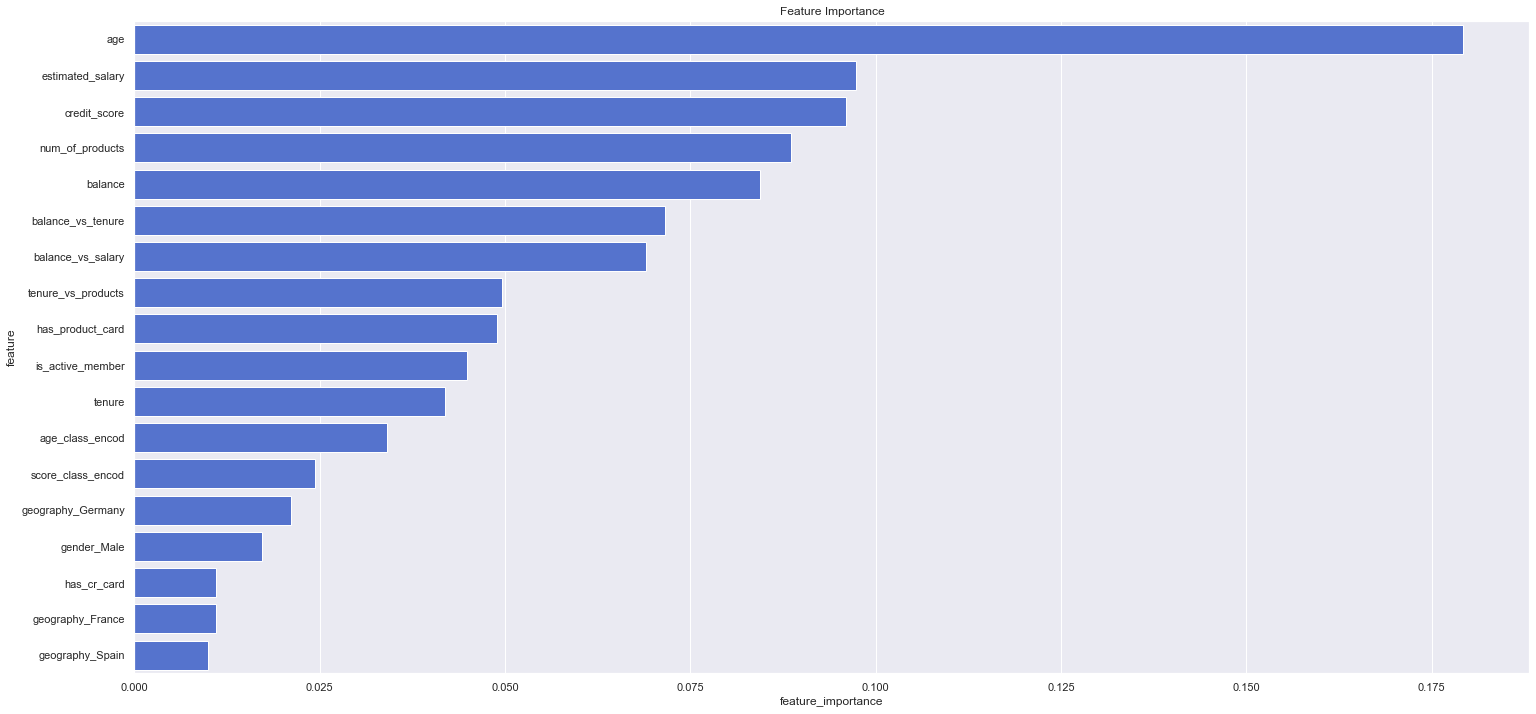

In [505]:
clf = XGBClassifier()
clf.fit(X_smt, y_smt)
features = (clf.feature_importances_)
feat_importances = pd.DataFrame({'feature importance': features, 'feature': X_smt.columns}).sort_values('feature importance',ascending=False).reset_index(drop=True)
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

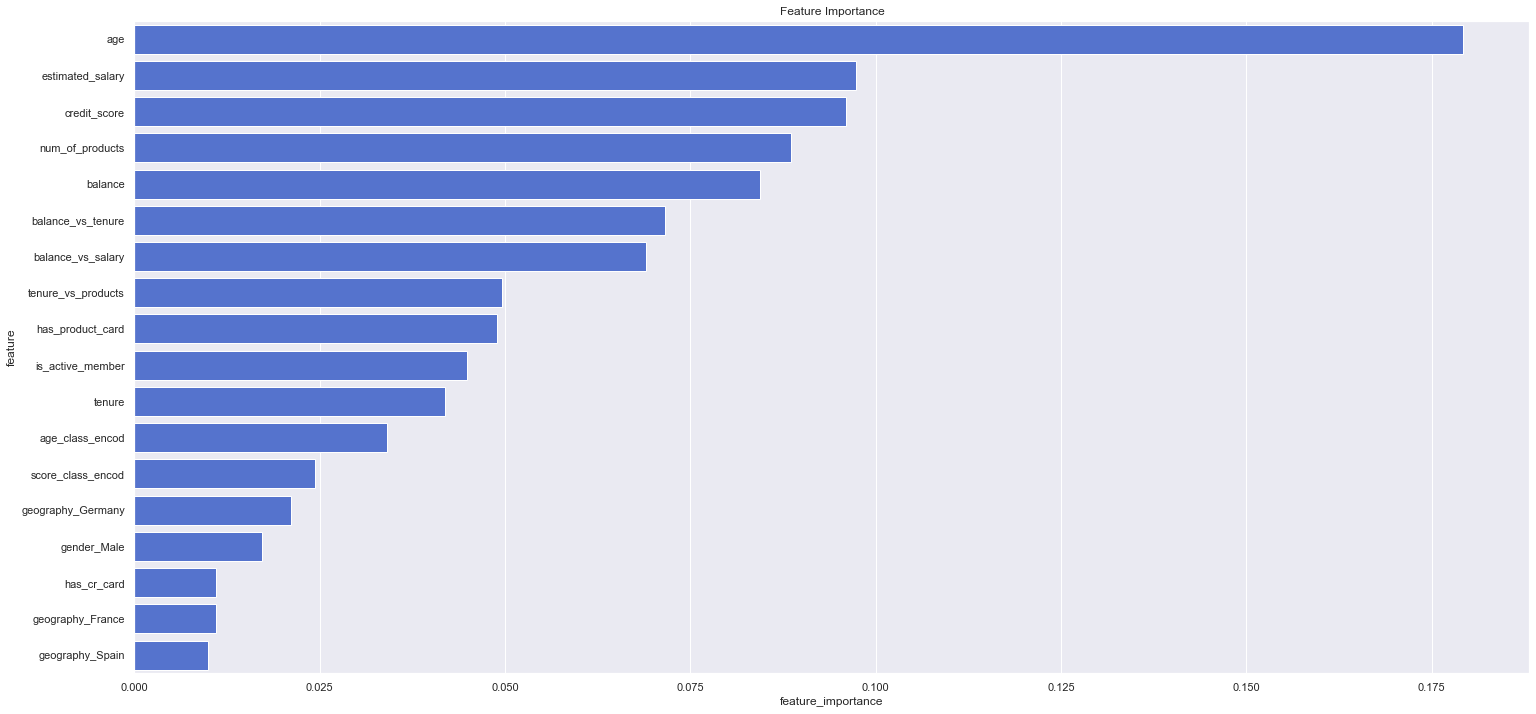

In [512]:
clf = XGBClassifier()
clf.fit(X_train_imb, y_train_imb)
features = (clf.feature_importances_)
feat_importances = pd.DataFrame({'feature importance': features, 'feature': X_train_imb.columns}).sort_values('feature importance',ascending=False).reset_index(drop=True)
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

# 9. Machine Learning Models

Datasets: balanced: X_smt, y_smt
          imbalanced: X_train_imb, y_train_imb

In [90]:
columns_selected = ['credit_score',
 'age',
 'balance',
 'num_of_products',
 'is_active_member',
 'geography_France',
 'geography_Spain',
 'gender_Male']


In [91]:
X_train_selected = X_smt[columns_selected]
X_test_selected = X_test_smt[columns_selected]

X_train_selected_2 = X_train_imb[columns_selected]
X_test_selected_2 = X_test_imb[columns_selected]

## 9.1 Baseline Model

In [92]:
bl = DummyClassifier()
bl.fit(X_train_selected, y_smt)
y_pred_bl = bl.predict(X_train_selected)
bl_results = ml_scores('Baseline', y_smt, y_pred_bl)
bl_results

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
Baseline 0.503000           0.503000   0.497000 0.500000 0.503000 0.006000

In [93]:
bl_cv_bal = performance(bl,X_train_selected,y_smt)
bl_cv_bal

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.501587       0.502389        0.501705        0.502380         0.502824     0.502428      0.501994       0.502393        0.501588            0.502389             0.003180  0.004779

''

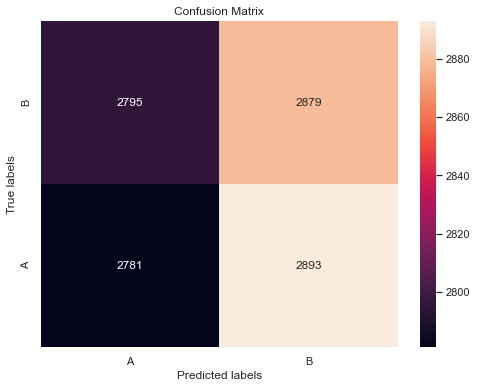

In [94]:
y_pred_bl_cv_bal = cross_val_predict(bl, X_train_selected, y_smt, cv=10)
cm = confusion_matrix(y_smt, y_pred_bl_cv_bal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

In [95]:
bl2 = DummyClassifier()
bl2.fit(X_train_selected_2, y_train_imb)
y_pred_bl2 = bl2.predict(X_train_selected_2)
bl_results2 = ml_scores('Baseline', y_train_imb, y_pred_bl2)
bl_results2

Balanced Accuracy  Precision   Recall       F1  ROC_AUC     Kappa
Baseline 0.499000           0.202000   0.208000 0.205000 0.499000 -0.002000

In [96]:
bl_cv_imb = performance(bl2,X_train_selected_2,y_train_imb)
bl_cv_imb

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.673500       0.676069        0.201432        0.206242         0.202454     0.206953      0.201577       0.206555        0.498244            0.501532             -0.003280 0.003088

''

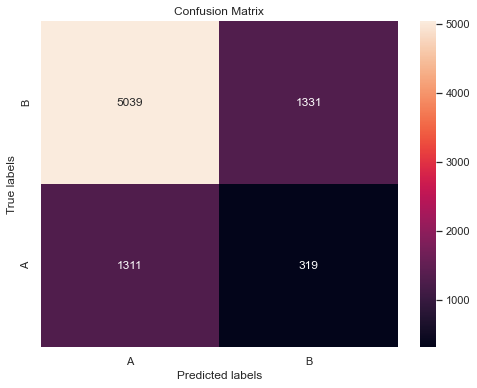

In [97]:
y_pred_bl_cv_imbal = cross_val_predict(bl, X_train_selected_2, y_train_imb, cv=10)
cm = confusion_matrix(y_train_imb, y_pred_bl_cv_imbal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

## Logistic Regression

In [98]:
lg = LogisticRegression()
lg.fit(X_train_selected, y_smt)
y_pred_lg = lg.predict(X_train_selected)
lg_results = ml_scores('Logistic Regression', y_smt, y_pred_lg)
lg_results

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
Logistic Regression 0.804000           0.809000   0.797000 0.803000 0.804000 0.608000

In [99]:
lr_cv_bal = performance(lg,X_train_selected,y_smt)
lr_cv_bal

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.802706       0.804606        0.804109        0.809269         0.793012     0.797048      0.793294       0.803110        0.802749            0.804606             0.610694  0.609283

''

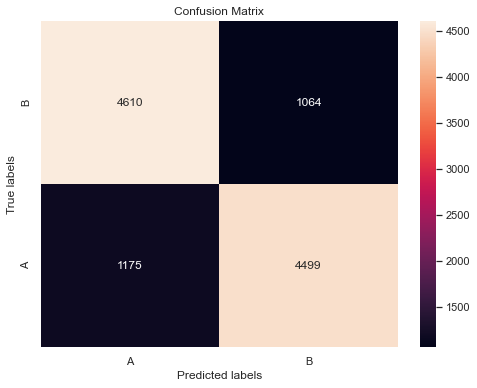

In [100]:
y_pred_lg_cv_bal = cross_val_predict(lg, X_train_selected, y_smt, cv=10)
cm = confusion_matrix(y_smt, y_pred_lg_cv_bal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

In [101]:
lg2 = LogisticRegression()
lg2.fit(X_train_selected_2, y_train_imb)
y_pred_lg2 = lg2.predict(X_train_selected_2)
lg_results2 = ml_scores('Logistic Regression', y_train_imb, y_pred_lg2)
lg_results2

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
Logistic Regression 0.587000           0.615000   0.207000 0.310000 0.587000 0.231000

In [102]:
lr_cv_imb = performance(lg2,X_train_selected_2,y_train_imb)
lr_cv_imb

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.811625       0.812250        0.613970        0.616525         0.205521     0.207839      0.307454       0.310858        0.586120            0.587375             0.275092  0.278292

''

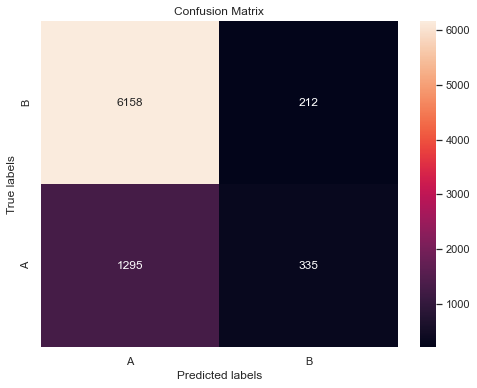

In [103]:
y_pred_lg_cv_imbal = cross_val_predict(lg2, X_train_selected_2, y_train_imb, cv=10)
cm = confusion_matrix(y_train_imb, y_pred_lg_cv_imbal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

## 9.3 KNN

In [104]:
knn = KNeighborsClassifier()
knn.fit(X_train_selected, y_smt)
y_pred_knn = knn.predict(X_train_selected)
knn_results = ml_scores('K Nearest Neighbors', y_smt, y_pred_knn)
knn_results

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
K Nearest Neighbors 0.878000           0.878000   0.879000 0.878000 0.878000 0.756000

In [105]:
knn_cv_bal = performance(knn,X_train_selected,y_smt)
knn_cv_bal

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.830991       0.877443        0.831441        0.877558         0.827353     0.877277      0.826846       0.877408        0.831023            0.877443             0.665252  0.754902

''

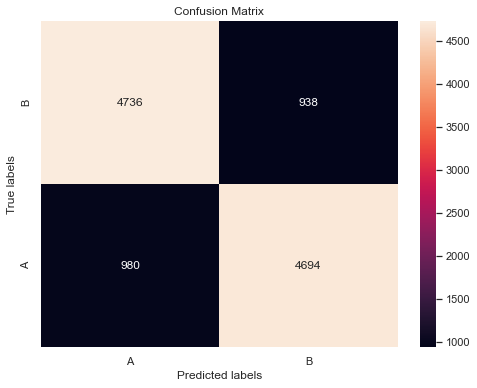

In [106]:
y_pred_knn_cv_bal = cross_val_predict(knn, X_train_selected, y_smt, cv=10)
cm = confusion_matrix(y_smt, y_pred_knn_cv_bal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

In [107]:
knn2 = KNeighborsClassifier()
knn2.fit(X_train_selected_2, y_train_imb)
y_pred_knn2 = knn2.predict(X_train_selected_2)
knn_results2 = ml_scores('K Nearest Neighbors',y_train_imb, y_pred_knn2)
knn_results2

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
K Nearest Neighbors 0.757000           0.797000   0.549000 0.650000 0.757000 0.580000

In [108]:
knn_cv_imb = performance(knn2,X_train_selected_2,y_train_imb)
knn_cv_imb 

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.832375       0.878583        0.636681        0.795275         0.413497     0.544240      0.500230       0.646190        0.676529            0.754189             0.419401  0.591123

''

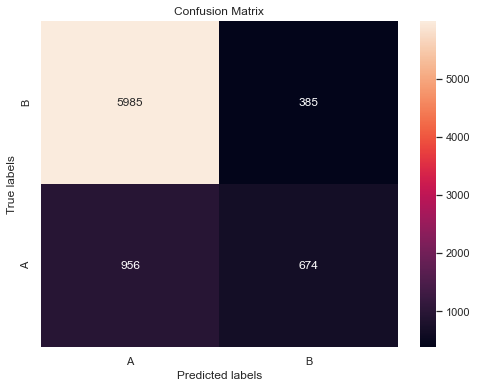

In [109]:
y_pred_knn_cv_imbal = cross_val_predict(knn2, X_train_selected_2, y_train_imb, cv=10)
cm = confusion_matrix(y_train_imb, y_pred_knn_cv_imbal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

## 9.4 SVM

In [110]:
svm = SVC()
svm.fit(X_train_selected, y_smt)
y_pred_svm = svm.predict(X_train_selected)
svm_results = ml_scores('SVM', y_smt, y_pred_svm)
svm_results

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
SVM 0.838000           0.851000   0.818000 0.835000 0.838000 0.676000

In [111]:
svm_cv_bal = performance(svm,X_train_selected,y_smt)
svm_cv_bal

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.830462       0.836927        0.842056        0.850110         0.809560     0.818118      0.822043       0.833802        0.830497            0.836927             0.664959  0.674339

''

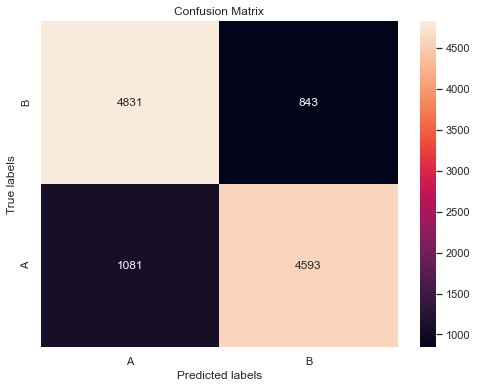

In [112]:
y_pred_svm_cv_bal = cross_val_predict(svm, X_train_selected, y_smt, cv=10)
cm = confusion_matrix(y_smt, y_pred_svm_cv_bal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

In [113]:
svm2 = SVC()
svm2.fit(X_train_selected_2, y_train_imb)
y_pred_svm2 = svm.predict(X_train_selected_2)
svm_results2 = ml_scores('SVM', y_train_imb, y_pred_svm2)
svm_results2

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
SVM 0.740000           0.516000   0.631000 0.568000 0.740000 0.443000

In [114]:
svm_cv_imb = performance(svm2,X_train_selected_2,y_train_imb)
svm_cv_imb

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.845750       0.850264        0.798635        0.814045         0.325767     0.343626      0.461766       0.483202        0.652287            0.661766             0.444078  0.464764

''

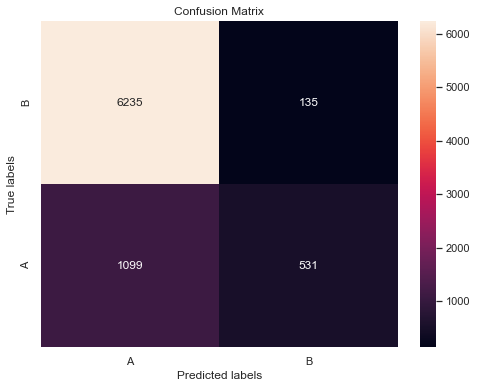

In [115]:
y_pred_svm_cv_imbal = cross_val_predict(svm2, X_train_selected_2, y_train_imb, cv=10)
cm = confusion_matrix(y_train_imb, y_pred_svm_cv_imbal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

## 9.5 XGBoost

In [116]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_selected, y_smt)
y_pred_xgb = xgb.predict(X_train_selected)
xgb_results = ml_scores('XGB', y_smt, y_pred_xgb)
xgb_results

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
XGB 0.929000           0.931000   0.926000 0.929000 0.929000 0.858000

In [117]:
xgb_cv_bal = performance(xgb,X_train_selected,y_smt)

''

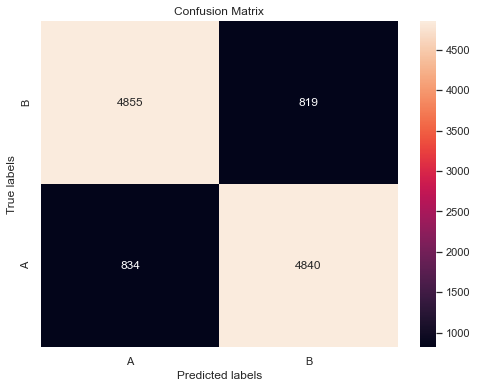

In [118]:
y_pred_xgb_cv_bal = cross_val_predict(xgb, X_train_selected, y_smt, cv=10)
cm = confusion_matrix(y_smt, y_pred_xgb_cv_bal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

In [119]:
xgb2 = XGBClassifier(random_state=42)
xgb2.fit(X_train_selected_2, y_train_imb)
y_pred_xgb2 = xgb2.predict(X_train_selected_2)
xgb_results2 = ml_scores('XGB', y_train_imb, y_pred_xgb2)
xgb_results2

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
XGB 0.865000           0.946000   0.740000 0.831000 0.865000 0.794000

In [120]:
xgb_cv_imb = performance(xgb2,X_train_selected_2,y_train_imb)
xgb_cv_imb

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.851250       0.939667        0.696809        0.944016         0.479141     0.748262      0.567057       0.834775        0.712804            0.868453             0.493783  0.806571

''

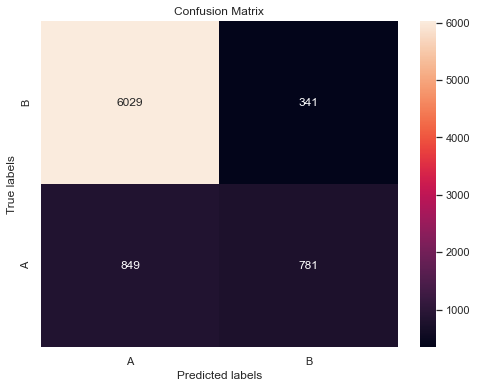

In [121]:
y_pred_xgb_cv_imbal = cross_val_predict(xgb2, X_train_selected_2, y_train_imb, cv=10)
cm = confusion_matrix(y_train_imb, y_pred_xgb_cv_imbal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

## 9.6 Random Florest

In [122]:
rf = RandomForestClassifier()
rf.fit(X_train_selected, y_smt)
y_pred_rf = rf.predict(X_train_selected)
rf_results = ml_scores('Random Forest', y_smt, y_pred_rf)
rf_results

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
Random Forest 0.999000           0.999000   0.999000 0.999000 0.999000 0.999000

In [123]:
rf_cv_bal = performance(rf,X_train_selected,y_smt)
rf_cv_bal

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.851257       0.999481        0.855938        0.999706         0.842332     0.999256      0.846727       0.999481        0.851287            0.999481             0.705607  0.998962

''

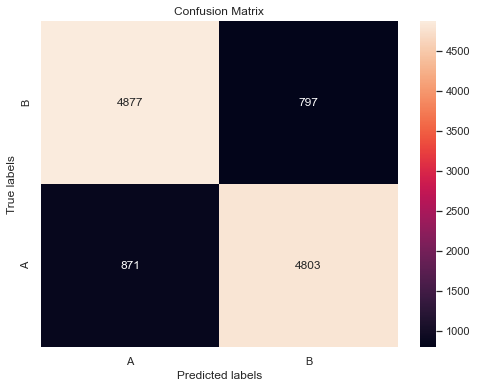

In [124]:
y_pred_rf_cv_bal = cross_val_predict(rf, X_train_selected, y_smt, cv=10)
cm = confusion_matrix(y_smt, y_pred_rf_cv_bal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

In [125]:
rf2 = RandomForestClassifier()
rf2.fit(X_train_selected_2, y_train_imb)
y_pred_rf2 = rf2.predict(X_train_selected_2)
rf_results2 = ml_scores('Random Forest', y_train_imb, y_pred_rf2)
rf_results2

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
Random Forest 0.999000           1.000000   0.998000 0.999000 0.999000 0.999000

In [126]:
rf_cv_imb = performance(rf2,X_train_selected_2,y_train_imb)
rf_cv_imb 

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.856750       0.999597        0.721354        0.999591         0.487117     0.998432      0.580294       0.999011        0.719225            0.999164             0.512600  0.998759

''

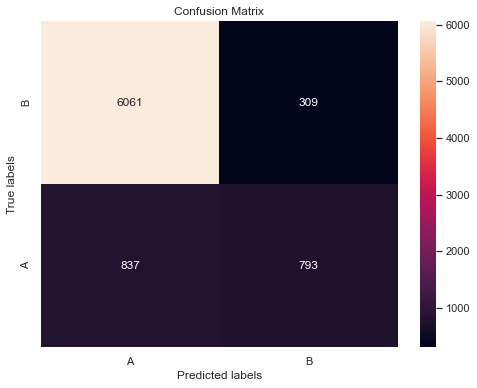

In [127]:
y_pred_rf_cv_imbal = cross_val_predict(rf2, X_train_selected_2, y_train_imb, cv=10)
cm = confusion_matrix(y_train_imb, y_pred_rf_cv_imbal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

## 9.7 CatBoost

In [128]:
cat = CatBoostClassifier()
cat.fit(X_train_selected, y_smt)
y_pred_cat = cat.predict(X_train_selected)
cat_results = ml_scores('CatBoost', y_smt, y_pred_cat)
cat_results

Learning rate set to 0.029066
0:	learn: 0.6731766	total: 94.1ms	remaining: 1m 34s
1:	learn: 0.6531190	total: 111ms	remaining: 55.4s
2:	learn: 0.6352314	total: 141ms	remaining: 46.7s
3:	learn: 0.6175810	total: 160ms	remaining: 39.7s
4:	learn: 0.6023201	total: 176ms	remaining: 34.9s
5:	learn: 0.5886518	total: 192ms	remaining: 31.8s
6:	learn: 0.5748287	total: 212ms	remaining: 30.1s
7:	learn: 0.5627388	total: 230ms	remaining: 28.5s
8:	learn: 0.5517456	total: 249ms	remaining: 27.4s
9:	learn: 0.5411808	total: 266ms	remaining: 26.4s
10:	learn: 0.5314317	total: 286ms	remaining: 25.7s
11:	learn: 0.5226302	total: 304ms	remaining: 25s
12:	learn: 0.5138483	total: 320ms	remaining: 24.3s
13:	learn: 0.5052730	total: 337ms	remaining: 23.7s
14:	learn: 0.4972668	total: 354ms	remaining: 23.3s
15:	learn: 0.4894980	total: 376ms	remaining: 23.1s
16:	learn: 0.4834623	total: 396ms	remaining: 22.9s
17:	learn: 0.4772370	total: 414ms	remaining: 22.6s
18:	learn: 0.4712388	total: 430ms	remaining: 22.2s
19:	learn: 

165:	learn: 0.3358182	total: 3.34s	remaining: 16.8s
166:	learn: 0.3356352	total: 3.36s	remaining: 16.8s
167:	learn: 0.3355407	total: 3.38s	remaining: 16.7s
168:	learn: 0.3353439	total: 3.4s	remaining: 16.7s
169:	learn: 0.3352540	total: 3.42s	remaining: 16.7s
170:	learn: 0.3351019	total: 3.44s	remaining: 16.7s
171:	learn: 0.3348592	total: 3.46s	remaining: 16.7s
172:	learn: 0.3347411	total: 3.48s	remaining: 16.6s
173:	learn: 0.3346395	total: 3.51s	remaining: 16.6s
174:	learn: 0.3345140	total: 3.53s	remaining: 16.6s
175:	learn: 0.3343046	total: 3.55s	remaining: 16.6s
176:	learn: 0.3341145	total: 3.58s	remaining: 16.6s
177:	learn: 0.3339450	total: 3.6s	remaining: 16.6s
178:	learn: 0.3338170	total: 3.62s	remaining: 16.6s
179:	learn: 0.3335579	total: 3.63s	remaining: 16.6s
180:	learn: 0.3334496	total: 3.65s	remaining: 16.5s
181:	learn: 0.3332590	total: 3.67s	remaining: 16.5s
182:	learn: 0.3331581	total: 3.69s	remaining: 16.5s
183:	learn: 0.3330174	total: 3.71s	remaining: 16.5s
184:	learn: 0.

329:	learn: 0.3162603	total: 6.31s	remaining: 12.8s
330:	learn: 0.3161551	total: 6.33s	remaining: 12.8s
331:	learn: 0.3160597	total: 6.35s	remaining: 12.8s
332:	learn: 0.3159237	total: 6.37s	remaining: 12.8s
333:	learn: 0.3158629	total: 6.39s	remaining: 12.7s
334:	learn: 0.3157145	total: 6.42s	remaining: 12.7s
335:	learn: 0.3156076	total: 6.43s	remaining: 12.7s
336:	learn: 0.3155153	total: 6.45s	remaining: 12.7s
337:	learn: 0.3154146	total: 6.47s	remaining: 12.7s
338:	learn: 0.3153170	total: 6.49s	remaining: 12.6s
339:	learn: 0.3152084	total: 6.5s	remaining: 12.6s
340:	learn: 0.3151174	total: 6.53s	remaining: 12.6s
341:	learn: 0.3150402	total: 6.54s	remaining: 12.6s
342:	learn: 0.3149360	total: 6.57s	remaining: 12.6s
343:	learn: 0.3148150	total: 6.58s	remaining: 12.6s
344:	learn: 0.3147142	total: 6.6s	remaining: 12.5s
345:	learn: 0.3145813	total: 6.62s	remaining: 12.5s
346:	learn: 0.3144879	total: 6.64s	remaining: 12.5s
347:	learn: 0.3144064	total: 6.66s	remaining: 12.5s
348:	learn: 0.

493:	learn: 0.3004653	total: 9.23s	remaining: 9.46s
494:	learn: 0.3003829	total: 9.25s	remaining: 9.44s
495:	learn: 0.3002927	total: 9.27s	remaining: 9.42s
496:	learn: 0.3002139	total: 9.28s	remaining: 9.4s
497:	learn: 0.3001002	total: 9.3s	remaining: 9.38s
498:	learn: 0.3000727	total: 9.32s	remaining: 9.35s
499:	learn: 0.3000188	total: 9.33s	remaining: 9.33s
500:	learn: 0.2999746	total: 9.35s	remaining: 9.31s
501:	learn: 0.2998888	total: 9.36s	remaining: 9.29s
502:	learn: 0.2997787	total: 9.38s	remaining: 9.27s
503:	learn: 0.2996525	total: 9.39s	remaining: 9.24s
504:	learn: 0.2995485	total: 9.41s	remaining: 9.22s
505:	learn: 0.2994780	total: 9.43s	remaining: 9.2s
506:	learn: 0.2993924	total: 9.44s	remaining: 9.18s
507:	learn: 0.2992988	total: 9.46s	remaining: 9.16s
508:	learn: 0.2992084	total: 9.48s	remaining: 9.14s
509:	learn: 0.2991245	total: 9.49s	remaining: 9.12s
510:	learn: 0.2990699	total: 9.51s	remaining: 9.1s
511:	learn: 0.2990057	total: 9.53s	remaining: 9.08s
512:	learn: 0.29

658:	learn: 0.2874730	total: 12.4s	remaining: 6.39s
659:	learn: 0.2873807	total: 12.4s	remaining: 6.37s
660:	learn: 0.2873554	total: 12.4s	remaining: 6.35s
661:	learn: 0.2873181	total: 12.4s	remaining: 6.33s
662:	learn: 0.2871935	total: 12.4s	remaining: 6.31s
663:	learn: 0.2871033	total: 12.4s	remaining: 6.29s
664:	learn: 0.2870424	total: 12.5s	remaining: 6.28s
665:	learn: 0.2869917	total: 12.5s	remaining: 6.26s
666:	learn: 0.2869329	total: 12.5s	remaining: 6.24s
667:	learn: 0.2868666	total: 12.5s	remaining: 6.22s
668:	learn: 0.2868091	total: 12.5s	remaining: 6.2s
669:	learn: 0.2867385	total: 12.6s	remaining: 6.18s
670:	learn: 0.2866508	total: 12.6s	remaining: 6.16s
671:	learn: 0.2865683	total: 12.6s	remaining: 6.14s
672:	learn: 0.2864919	total: 12.6s	remaining: 6.13s
673:	learn: 0.2863766	total: 12.6s	remaining: 6.11s
674:	learn: 0.2862665	total: 12.6s	remaining: 6.09s
675:	learn: 0.2861992	total: 12.7s	remaining: 6.07s
676:	learn: 0.2861417	total: 12.7s	remaining: 6.05s
677:	learn: 0

819:	learn: 0.2764194	total: 15.1s	remaining: 3.31s
820:	learn: 0.2763689	total: 15.1s	remaining: 3.29s
821:	learn: 0.2763250	total: 15.1s	remaining: 3.27s
822:	learn: 0.2762881	total: 15.1s	remaining: 3.25s
823:	learn: 0.2762013	total: 15.2s	remaining: 3.24s
824:	learn: 0.2761276	total: 15.2s	remaining: 3.22s
825:	learn: 0.2760907	total: 15.2s	remaining: 3.2s
826:	learn: 0.2760305	total: 15.2s	remaining: 3.18s
827:	learn: 0.2759981	total: 15.2s	remaining: 3.16s
828:	learn: 0.2759347	total: 15.2s	remaining: 3.14s
829:	learn: 0.2758472	total: 15.2s	remaining: 3.12s
830:	learn: 0.2757654	total: 15.3s	remaining: 3.1s
831:	learn: 0.2757264	total: 15.3s	remaining: 3.08s
832:	learn: 0.2756791	total: 15.3s	remaining: 3.06s
833:	learn: 0.2756436	total: 15.3s	remaining: 3.04s
834:	learn: 0.2755642	total: 15.3s	remaining: 3.03s
835:	learn: 0.2754992	total: 15.3s	remaining: 3.01s
836:	learn: 0.2754299	total: 15.4s	remaining: 2.99s
837:	learn: 0.2753944	total: 15.4s	remaining: 2.97s
838:	learn: 0.

978:	learn: 0.2669238	total: 17.6s	remaining: 379ms
979:	learn: 0.2668723	total: 17.7s	remaining: 361ms
980:	learn: 0.2668350	total: 17.7s	remaining: 343ms
981:	learn: 0.2667707	total: 17.7s	remaining: 324ms
982:	learn: 0.2667098	total: 17.7s	remaining: 306ms
983:	learn: 0.2666703	total: 17.7s	remaining: 288ms
984:	learn: 0.2666349	total: 17.8s	remaining: 270ms
985:	learn: 0.2665929	total: 17.8s	remaining: 252ms
986:	learn: 0.2664776	total: 17.8s	remaining: 234ms
987:	learn: 0.2664132	total: 17.8s	remaining: 216ms
988:	learn: 0.2663377	total: 17.8s	remaining: 198ms
989:	learn: 0.2663112	total: 17.8s	remaining: 180ms
990:	learn: 0.2662497	total: 17.9s	remaining: 162ms
991:	learn: 0.2661856	total: 17.9s	remaining: 144ms
992:	learn: 0.2661154	total: 17.9s	remaining: 126ms
993:	learn: 0.2660636	total: 17.9s	remaining: 108ms
994:	learn: 0.2660386	total: 17.9s	remaining: 90ms
995:	learn: 0.2659458	total: 17.9s	remaining: 72ms
996:	learn: 0.2658986	total: 17.9s	remaining: 54ms
997:	learn: 0.2

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
CatBoost 0.892000           0.896000   0.888000 0.892000 0.892000 0.785000

In [129]:
cat_cv_bal = performance(cat,X_train_selected,y_smt)
cat_cv_bal

Learning rate set to 0.027787
0:	learn: 0.6708092	total: 20ms	remaining: 20s
1:	learn: 0.6494429	total: 34.2ms	remaining: 17.1s
2:	learn: 0.6302593	total: 49.9ms	remaining: 16.6s
3:	learn: 0.6125752	total: 65.6ms	remaining: 16.3s
4:	learn: 0.5974238	total: 79ms	remaining: 15.7s
5:	learn: 0.5827263	total: 94.6ms	remaining: 15.7s
6:	learn: 0.5683157	total: 110ms	remaining: 15.6s
7:	learn: 0.5558541	total: 126ms	remaining: 15.6s
8:	learn: 0.5430910	total: 141ms	remaining: 15.5s
9:	learn: 0.5323724	total: 156ms	remaining: 15.5s
10:	learn: 0.5209406	total: 172ms	remaining: 15.4s
11:	learn: 0.5104955	total: 189ms	remaining: 15.6s
12:	learn: 0.5024885	total: 205ms	remaining: 15.5s
13:	learn: 0.4936207	total: 220ms	remaining: 15.5s
14:	learn: 0.4856710	total: 235ms	remaining: 15.4s
15:	learn: 0.4783685	total: 250ms	remaining: 15.4s
16:	learn: 0.4716883	total: 265ms	remaining: 15.3s
17:	learn: 0.4650411	total: 281ms	remaining: 15.3s
18:	learn: 0.4583423	total: 296ms	remaining: 15.3s
19:	learn: 

163:	learn: 0.3151941	total: 2.74s	remaining: 14s
164:	learn: 0.3150322	total: 2.76s	remaining: 14s
165:	learn: 0.3148467	total: 2.77s	remaining: 13.9s
166:	learn: 0.3146680	total: 2.79s	remaining: 13.9s
167:	learn: 0.3144193	total: 2.8s	remaining: 13.9s
168:	learn: 0.3142812	total: 2.82s	remaining: 13.9s
169:	learn: 0.3141438	total: 2.83s	remaining: 13.8s
170:	learn: 0.3139591	total: 2.85s	remaining: 13.8s
171:	learn: 0.3138254	total: 2.86s	remaining: 13.8s
172:	learn: 0.3137266	total: 2.88s	remaining: 13.7s
173:	learn: 0.3136241	total: 2.89s	remaining: 13.7s
174:	learn: 0.3135094	total: 2.91s	remaining: 13.7s
175:	learn: 0.3133800	total: 2.92s	remaining: 13.7s
176:	learn: 0.3132506	total: 2.94s	remaining: 13.7s
177:	learn: 0.3130735	total: 2.96s	remaining: 13.7s
178:	learn: 0.3129408	total: 2.97s	remaining: 13.6s
179:	learn: 0.3126224	total: 2.99s	remaining: 13.6s
180:	learn: 0.3125689	total: 3s	remaining: 13.6s
181:	learn: 0.3123806	total: 3.02s	remaining: 13.6s
182:	learn: 0.312187

323:	learn: 0.2959039	total: 5.48s	remaining: 11.4s
324:	learn: 0.2958441	total: 5.49s	remaining: 11.4s
325:	learn: 0.2957754	total: 5.51s	remaining: 11.4s
326:	learn: 0.2956619	total: 5.53s	remaining: 11.4s
327:	learn: 0.2955952	total: 5.55s	remaining: 11.4s
328:	learn: 0.2954628	total: 5.57s	remaining: 11.4s
329:	learn: 0.2953442	total: 5.58s	remaining: 11.3s
330:	learn: 0.2952658	total: 5.6s	remaining: 11.3s
331:	learn: 0.2951789	total: 5.62s	remaining: 11.3s
332:	learn: 0.2951034	total: 5.63s	remaining: 11.3s
333:	learn: 0.2950241	total: 5.65s	remaining: 11.3s
334:	learn: 0.2949506	total: 5.67s	remaining: 11.3s
335:	learn: 0.2948405	total: 5.69s	remaining: 11.3s
336:	learn: 0.2947661	total: 5.71s	remaining: 11.2s
337:	learn: 0.2947049	total: 5.74s	remaining: 11.2s
338:	learn: 0.2945850	total: 5.76s	remaining: 11.2s
339:	learn: 0.2945189	total: 5.79s	remaining: 11.2s
340:	learn: 0.2943847	total: 5.8s	remaining: 11.2s
341:	learn: 0.2942911	total: 5.84s	remaining: 11.2s
342:	learn: 0.

488:	learn: 0.2806376	total: 8.43s	remaining: 8.8s
489:	learn: 0.2805027	total: 8.44s	remaining: 8.79s
490:	learn: 0.2804245	total: 8.46s	remaining: 8.77s
491:	learn: 0.2802973	total: 8.47s	remaining: 8.74s
492:	learn: 0.2802161	total: 8.48s	remaining: 8.72s
493:	learn: 0.2801114	total: 8.5s	remaining: 8.71s
494:	learn: 0.2799930	total: 8.51s	remaining: 8.69s
495:	learn: 0.2799177	total: 8.53s	remaining: 8.67s
496:	learn: 0.2798398	total: 8.55s	remaining: 8.65s
497:	learn: 0.2797509	total: 8.56s	remaining: 8.63s
498:	learn: 0.2796552	total: 8.58s	remaining: 8.61s
499:	learn: 0.2795889	total: 8.59s	remaining: 8.59s
500:	learn: 0.2794567	total: 8.61s	remaining: 8.57s
501:	learn: 0.2793639	total: 8.62s	remaining: 8.55s
502:	learn: 0.2792790	total: 8.64s	remaining: 8.54s
503:	learn: 0.2791555	total: 8.65s	remaining: 8.52s
504:	learn: 0.2790153	total: 8.67s	remaining: 8.5s
505:	learn: 0.2789290	total: 8.69s	remaining: 8.48s
506:	learn: 0.2788367	total: 8.7s	remaining: 8.46s
507:	learn: 0.27

651:	learn: 0.2669409	total: 11s	remaining: 5.85s
652:	learn: 0.2668402	total: 11s	remaining: 5.83s
653:	learn: 0.2668205	total: 11s	remaining: 5.81s
654:	learn: 0.2667313	total: 11s	remaining: 5.8s
655:	learn: 0.2666585	total: 11s	remaining: 5.78s
656:	learn: 0.2666048	total: 11s	remaining: 5.76s
657:	learn: 0.2665645	total: 11.1s	remaining: 5.74s
658:	learn: 0.2664762	total: 11.1s	remaining: 5.72s
659:	learn: 0.2663903	total: 11.1s	remaining: 5.71s
660:	learn: 0.2663132	total: 11.1s	remaining: 5.7s
661:	learn: 0.2662530	total: 11.1s	remaining: 5.68s
662:	learn: 0.2661732	total: 11.1s	remaining: 5.66s
663:	learn: 0.2660946	total: 11.2s	remaining: 5.65s
664:	learn: 0.2660080	total: 11.2s	remaining: 5.63s
665:	learn: 0.2659211	total: 11.2s	remaining: 5.61s
666:	learn: 0.2658609	total: 11.2s	remaining: 5.6s
667:	learn: 0.2657865	total: 11.2s	remaining: 5.58s
668:	learn: 0.2656982	total: 11.2s	remaining: 5.56s
669:	learn: 0.2656492	total: 11.3s	remaining: 5.55s
670:	learn: 0.2655735	total

817:	learn: 0.2552291	total: 13.6s	remaining: 3.02s
818:	learn: 0.2551689	total: 13.6s	remaining: 3.01s
819:	learn: 0.2550999	total: 13.6s	remaining: 2.99s
820:	learn: 0.2550750	total: 13.6s	remaining: 2.97s
821:	learn: 0.2550028	total: 13.6s	remaining: 2.96s
822:	learn: 0.2549643	total: 13.7s	remaining: 2.94s
823:	learn: 0.2549174	total: 13.7s	remaining: 2.92s
824:	learn: 0.2548090	total: 13.7s	remaining: 2.9s
825:	learn: 0.2547374	total: 13.7s	remaining: 2.89s
826:	learn: 0.2547054	total: 13.7s	remaining: 2.87s
827:	learn: 0.2546119	total: 13.7s	remaining: 2.85s
828:	learn: 0.2545015	total: 13.8s	remaining: 2.84s
829:	learn: 0.2544259	total: 13.8s	remaining: 2.82s
830:	learn: 0.2543826	total: 13.8s	remaining: 2.8s
831:	learn: 0.2543397	total: 13.8s	remaining: 2.79s
832:	learn: 0.2542353	total: 13.8s	remaining: 2.77s
833:	learn: 0.2541800	total: 13.8s	remaining: 2.75s
834:	learn: 0.2540645	total: 13.8s	remaining: 2.74s
835:	learn: 0.2540242	total: 13.9s	remaining: 2.72s
836:	learn: 0.

981:	learn: 0.2442912	total: 16.3s	remaining: 299ms
982:	learn: 0.2442517	total: 16.3s	remaining: 283ms
983:	learn: 0.2442106	total: 16.4s	remaining: 266ms
984:	learn: 0.2441657	total: 16.4s	remaining: 249ms
985:	learn: 0.2441195	total: 16.4s	remaining: 233ms
986:	learn: 0.2440527	total: 16.4s	remaining: 216ms
987:	learn: 0.2440012	total: 16.4s	remaining: 199ms
988:	learn: 0.2439051	total: 16.4s	remaining: 183ms
989:	learn: 0.2438414	total: 16.5s	remaining: 166ms
990:	learn: 0.2437709	total: 16.5s	remaining: 150ms
991:	learn: 0.2436686	total: 16.5s	remaining: 133ms
992:	learn: 0.2436154	total: 16.5s	remaining: 116ms
993:	learn: 0.2435686	total: 16.5s	remaining: 99.7ms
994:	learn: 0.2435188	total: 16.5s	remaining: 83.1ms
995:	learn: 0.2434280	total: 16.5s	remaining: 66.5ms
996:	learn: 0.2433636	total: 16.6s	remaining: 49.8ms
997:	learn: 0.2432826	total: 16.6s	remaining: 33.2ms
998:	learn: 0.2432108	total: 16.6s	remaining: 16.6ms
999:	learn: 0.2431122	total: 16.6s	remaining: 0us
Learning

151:	learn: 0.3170685	total: 2.81s	remaining: 15.7s
152:	learn: 0.3169280	total: 2.83s	remaining: 15.6s
153:	learn: 0.3167928	total: 2.84s	remaining: 15.6s
154:	learn: 0.3166425	total: 2.86s	remaining: 15.6s
155:	learn: 0.3164804	total: 2.88s	remaining: 15.6s
156:	learn: 0.3163140	total: 2.9s	remaining: 15.6s
157:	learn: 0.3161846	total: 2.91s	remaining: 15.5s
158:	learn: 0.3159463	total: 2.93s	remaining: 15.5s
159:	learn: 0.3157128	total: 2.95s	remaining: 15.5s
160:	learn: 0.3155908	total: 2.96s	remaining: 15.5s
161:	learn: 0.3154322	total: 2.98s	remaining: 15.4s
162:	learn: 0.3152625	total: 3s	remaining: 15.4s
163:	learn: 0.3150383	total: 3.01s	remaining: 15.4s
164:	learn: 0.3149792	total: 3.03s	remaining: 15.3s
165:	learn: 0.3147615	total: 3.05s	remaining: 15.3s
166:	learn: 0.3145890	total: 3.06s	remaining: 15.3s
167:	learn: 0.3144705	total: 3.08s	remaining: 15.2s
168:	learn: 0.3143142	total: 3.09s	remaining: 15.2s
169:	learn: 0.3141819	total: 3.11s	remaining: 15.2s
170:	learn: 0.31

319:	learn: 0.2956780	total: 5.57s	remaining: 11.8s
320:	learn: 0.2955791	total: 5.58s	remaining: 11.8s
321:	learn: 0.2955118	total: 5.6s	remaining: 11.8s
322:	learn: 0.2954412	total: 5.61s	remaining: 11.8s
323:	learn: 0.2953464	total: 5.63s	remaining: 11.7s
324:	learn: 0.2952576	total: 5.64s	remaining: 11.7s
325:	learn: 0.2951221	total: 5.66s	remaining: 11.7s
326:	learn: 0.2950786	total: 5.68s	remaining: 11.7s
327:	learn: 0.2950171	total: 5.7s	remaining: 11.7s
328:	learn: 0.2948546	total: 5.71s	remaining: 11.7s
329:	learn: 0.2947948	total: 5.73s	remaining: 11.6s
330:	learn: 0.2947541	total: 5.74s	remaining: 11.6s
331:	learn: 0.2946832	total: 5.76s	remaining: 11.6s
332:	learn: 0.2945626	total: 5.77s	remaining: 11.6s
333:	learn: 0.2944727	total: 5.79s	remaining: 11.5s
334:	learn: 0.2943767	total: 5.8s	remaining: 11.5s
335:	learn: 0.2943034	total: 5.82s	remaining: 11.5s
336:	learn: 0.2941906	total: 5.83s	remaining: 11.5s
337:	learn: 0.2940799	total: 5.85s	remaining: 11.5s
338:	learn: 0.2

482:	learn: 0.2805760	total: 8.96s	remaining: 9.59s
483:	learn: 0.2804981	total: 8.98s	remaining: 9.57s
484:	learn: 0.2803964	total: 8.99s	remaining: 9.55s
485:	learn: 0.2803059	total: 9.02s	remaining: 9.54s
486:	learn: 0.2802250	total: 9.04s	remaining: 9.52s
487:	learn: 0.2801470	total: 9.07s	remaining: 9.51s
488:	learn: 0.2800612	total: 9.09s	remaining: 9.5s
489:	learn: 0.2800128	total: 9.11s	remaining: 9.48s
490:	learn: 0.2799516	total: 9.13s	remaining: 9.46s
491:	learn: 0.2798908	total: 9.15s	remaining: 9.44s
492:	learn: 0.2798298	total: 9.17s	remaining: 9.43s
493:	learn: 0.2797273	total: 9.19s	remaining: 9.41s
494:	learn: 0.2796749	total: 9.21s	remaining: 9.4s
495:	learn: 0.2795388	total: 9.23s	remaining: 9.38s
496:	learn: 0.2794444	total: 9.25s	remaining: 9.36s
497:	learn: 0.2793574	total: 9.27s	remaining: 9.34s
498:	learn: 0.2792790	total: 9.29s	remaining: 9.32s
499:	learn: 0.2792433	total: 9.3s	remaining: 9.3s
500:	learn: 0.2791672	total: 9.32s	remaining: 9.29s
501:	learn: 0.27

647:	learn: 0.2675093	total: 12.1s	remaining: 6.56s
648:	learn: 0.2673990	total: 12.1s	remaining: 6.55s
649:	learn: 0.2673569	total: 12.1s	remaining: 6.53s
650:	learn: 0.2673009	total: 12.1s	remaining: 6.51s
651:	learn: 0.2672546	total: 12.2s	remaining: 6.49s
652:	learn: 0.2672243	total: 12.2s	remaining: 6.47s
653:	learn: 0.2671262	total: 12.2s	remaining: 6.45s
654:	learn: 0.2670919	total: 12.2s	remaining: 6.43s
655:	learn: 0.2670092	total: 12.2s	remaining: 6.41s
656:	learn: 0.2668912	total: 12.2s	remaining: 6.39s
657:	learn: 0.2667788	total: 12.2s	remaining: 6.37s
658:	learn: 0.2666635	total: 12.3s	remaining: 6.35s
659:	learn: 0.2665309	total: 12.3s	remaining: 6.33s
660:	learn: 0.2664393	total: 12.3s	remaining: 6.31s
661:	learn: 0.2663354	total: 12.3s	remaining: 6.29s
662:	learn: 0.2662699	total: 12.3s	remaining: 6.26s
663:	learn: 0.2662322	total: 12.3s	remaining: 6.25s
664:	learn: 0.2661710	total: 12.4s	remaining: 6.22s
665:	learn: 0.2660660	total: 12.4s	remaining: 6.2s
666:	learn: 0

809:	learn: 0.2553654	total: 15.2s	remaining: 3.58s
810:	learn: 0.2552896	total: 15.3s	remaining: 3.56s
811:	learn: 0.2552546	total: 15.3s	remaining: 3.54s
812:	learn: 0.2551659	total: 15.3s	remaining: 3.53s
813:	learn: 0.2551163	total: 15.4s	remaining: 3.51s
814:	learn: 0.2550618	total: 15.4s	remaining: 3.49s
815:	learn: 0.2549526	total: 15.4s	remaining: 3.47s
816:	learn: 0.2548647	total: 15.4s	remaining: 3.45s
817:	learn: 0.2547903	total: 15.4s	remaining: 3.43s
818:	learn: 0.2547037	total: 15.4s	remaining: 3.41s
819:	learn: 0.2546457	total: 15.5s	remaining: 3.4s
820:	learn: 0.2545793	total: 15.5s	remaining: 3.38s
821:	learn: 0.2544750	total: 15.5s	remaining: 3.36s
822:	learn: 0.2544134	total: 15.5s	remaining: 3.34s
823:	learn: 0.2543464	total: 15.5s	remaining: 3.32s
824:	learn: 0.2542790	total: 15.6s	remaining: 3.3s
825:	learn: 0.2542240	total: 15.6s	remaining: 3.28s
826:	learn: 0.2541402	total: 15.6s	remaining: 3.26s
827:	learn: 0.2540514	total: 15.6s	remaining: 3.25s
828:	learn: 0.

974:	learn: 0.2447592	total: 18.4s	remaining: 472ms
975:	learn: 0.2447193	total: 18.4s	remaining: 454ms
976:	learn: 0.2446000	total: 18.5s	remaining: 435ms
977:	learn: 0.2445541	total: 18.5s	remaining: 416ms
978:	learn: 0.2444986	total: 18.5s	remaining: 397ms
979:	learn: 0.2443975	total: 18.5s	remaining: 378ms
980:	learn: 0.2443325	total: 18.5s	remaining: 359ms
981:	learn: 0.2442109	total: 18.6s	remaining: 340ms
982:	learn: 0.2441761	total: 18.6s	remaining: 321ms
983:	learn: 0.2441504	total: 18.6s	remaining: 302ms
984:	learn: 0.2440500	total: 18.6s	remaining: 283ms
985:	learn: 0.2439934	total: 18.6s	remaining: 264ms
986:	learn: 0.2439256	total: 18.6s	remaining: 246ms
987:	learn: 0.2438486	total: 18.7s	remaining: 227ms
988:	learn: 0.2438008	total: 18.7s	remaining: 208ms
989:	learn: 0.2437305	total: 18.7s	remaining: 189ms
990:	learn: 0.2436512	total: 18.7s	remaining: 170ms
991:	learn: 0.2435981	total: 18.7s	remaining: 151ms
992:	learn: 0.2435402	total: 18.8s	remaining: 132ms
993:	learn: 

140:	learn: 0.3375590	total: 2.79s	remaining: 17s
141:	learn: 0.3373340	total: 2.81s	remaining: 17s
142:	learn: 0.3370510	total: 2.83s	remaining: 17s
143:	learn: 0.3369240	total: 2.85s	remaining: 17s
144:	learn: 0.3367306	total: 2.87s	remaining: 16.9s
145:	learn: 0.3364172	total: 2.9s	remaining: 17s
146:	learn: 0.3361976	total: 2.92s	remaining: 16.9s
147:	learn: 0.3360538	total: 2.95s	remaining: 17s
148:	learn: 0.3358443	total: 2.97s	remaining: 17s
149:	learn: 0.3356494	total: 3s	remaining: 17s
150:	learn: 0.3354223	total: 3.02s	remaining: 17s
151:	learn: 0.3353058	total: 3.04s	remaining: 17s
152:	learn: 0.3350749	total: 3.06s	remaining: 17s
153:	learn: 0.3349524	total: 3.08s	remaining: 16.9s
154:	learn: 0.3348006	total: 3.1s	remaining: 16.9s
155:	learn: 0.3346666	total: 3.13s	remaining: 16.9s
156:	learn: 0.3345491	total: 3.14s	remaining: 16.9s
157:	learn: 0.3343777	total: 3.16s	remaining: 16.9s
158:	learn: 0.3341630	total: 3.18s	remaining: 16.8s
159:	learn: 0.3340104	total: 3.2s	remai

305:	learn: 0.3154800	total: 5.94s	remaining: 13.5s
306:	learn: 0.3153639	total: 5.96s	remaining: 13.4s
307:	learn: 0.3153300	total: 5.97s	remaining: 13.4s
308:	learn: 0.3152428	total: 5.98s	remaining: 13.4s
309:	learn: 0.3151098	total: 6s	remaining: 13.4s
310:	learn: 0.3149884	total: 6.01s	remaining: 13.3s
311:	learn: 0.3149471	total: 6.03s	remaining: 13.3s
312:	learn: 0.3148753	total: 6.05s	remaining: 13.3s
313:	learn: 0.3147911	total: 6.06s	remaining: 13.2s
314:	learn: 0.3146693	total: 6.08s	remaining: 13.2s
315:	learn: 0.3146199	total: 6.09s	remaining: 13.2s
316:	learn: 0.3144873	total: 6.11s	remaining: 13.2s
317:	learn: 0.3143286	total: 6.12s	remaining: 13.1s
318:	learn: 0.3142153	total: 6.14s	remaining: 13.1s
319:	learn: 0.3141404	total: 6.15s	remaining: 13.1s
320:	learn: 0.3140765	total: 6.17s	remaining: 13.1s
321:	learn: 0.3139856	total: 6.19s	remaining: 13s
322:	learn: 0.3138991	total: 6.2s	remaining: 13s
323:	learn: 0.3138185	total: 6.22s	remaining: 13s
324:	learn: 0.3137101	

471:	learn: 0.2996295	total: 8.66s	remaining: 9.68s
472:	learn: 0.2995414	total: 8.67s	remaining: 9.66s
473:	learn: 0.2994732	total: 8.69s	remaining: 9.64s
474:	learn: 0.2993911	total: 8.7s	remaining: 9.62s
475:	learn: 0.2993451	total: 8.72s	remaining: 9.6s
476:	learn: 0.2992539	total: 8.73s	remaining: 9.57s
477:	learn: 0.2992038	total: 8.75s	remaining: 9.55s
478:	learn: 0.2991632	total: 8.76s	remaining: 9.53s
479:	learn: 0.2991038	total: 8.78s	remaining: 9.51s
480:	learn: 0.2990309	total: 8.79s	remaining: 9.49s
481:	learn: 0.2989497	total: 8.81s	remaining: 9.47s
482:	learn: 0.2988646	total: 8.82s	remaining: 9.45s
483:	learn: 0.2988069	total: 8.84s	remaining: 9.43s
484:	learn: 0.2986698	total: 8.86s	remaining: 9.4s
485:	learn: 0.2985667	total: 8.87s	remaining: 9.38s
486:	learn: 0.2985048	total: 8.89s	remaining: 9.36s
487:	learn: 0.2984062	total: 8.9s	remaining: 9.34s
488:	learn: 0.2983704	total: 8.92s	remaining: 9.32s
489:	learn: 0.2982794	total: 8.94s	remaining: 9.3s
490:	learn: 0.298

632:	learn: 0.2861221	total: 11.3s	remaining: 6.53s
633:	learn: 0.2860487	total: 11.3s	remaining: 6.51s
634:	learn: 0.2859337	total: 11.3s	remaining: 6.49s
635:	learn: 0.2858801	total: 11.3s	remaining: 6.47s
636:	learn: 0.2857898	total: 11.3s	remaining: 6.46s
637:	learn: 0.2856740	total: 11.4s	remaining: 6.44s
638:	learn: 0.2856181	total: 11.4s	remaining: 6.42s
639:	learn: 0.2855537	total: 11.4s	remaining: 6.41s
640:	learn: 0.2855073	total: 11.4s	remaining: 6.39s
641:	learn: 0.2854571	total: 11.4s	remaining: 6.37s
642:	learn: 0.2854063	total: 11.4s	remaining: 6.35s
643:	learn: 0.2853387	total: 11.5s	remaining: 6.33s
644:	learn: 0.2852813	total: 11.5s	remaining: 6.31s
645:	learn: 0.2852195	total: 11.5s	remaining: 6.29s
646:	learn: 0.2851146	total: 11.5s	remaining: 6.27s
647:	learn: 0.2850524	total: 11.5s	remaining: 6.25s
648:	learn: 0.2849785	total: 11.5s	remaining: 6.24s
649:	learn: 0.2848822	total: 11.5s	remaining: 6.22s
650:	learn: 0.2847964	total: 11.6s	remaining: 6.2s
651:	learn: 0

799:	learn: 0.2739878	total: 14s	remaining: 3.51s
800:	learn: 0.2739377	total: 14.1s	remaining: 3.49s
801:	learn: 0.2738031	total: 14.1s	remaining: 3.47s
802:	learn: 0.2737202	total: 14.1s	remaining: 3.46s
803:	learn: 0.2736494	total: 14.1s	remaining: 3.44s
804:	learn: 0.2735719	total: 14.1s	remaining: 3.42s
805:	learn: 0.2735005	total: 14.1s	remaining: 3.4s
806:	learn: 0.2734396	total: 14.2s	remaining: 3.39s
807:	learn: 0.2733424	total: 14.2s	remaining: 3.37s
808:	learn: 0.2732886	total: 14.2s	remaining: 3.35s
809:	learn: 0.2731928	total: 14.2s	remaining: 3.33s
810:	learn: 0.2731507	total: 14.2s	remaining: 3.32s
811:	learn: 0.2730671	total: 14.3s	remaining: 3.3s
812:	learn: 0.2730419	total: 14.3s	remaining: 3.28s
813:	learn: 0.2729234	total: 14.3s	remaining: 3.27s
814:	learn: 0.2728523	total: 14.3s	remaining: 3.25s
815:	learn: 0.2727932	total: 14.3s	remaining: 3.23s
816:	learn: 0.2727534	total: 14.3s	remaining: 3.21s
817:	learn: 0.2727040	total: 14.4s	remaining: 3.19s
818:	learn: 0.27

960:	learn: 0.2631598	total: 17s	remaining: 691ms
961:	learn: 0.2631131	total: 17s	remaining: 673ms
962:	learn: 0.2630690	total: 17.1s	remaining: 655ms
963:	learn: 0.2630192	total: 17.1s	remaining: 637ms
964:	learn: 0.2629296	total: 17.1s	remaining: 620ms
965:	learn: 0.2628868	total: 17.1s	remaining: 602ms
966:	learn: 0.2628617	total: 17.1s	remaining: 585ms
967:	learn: 0.2628152	total: 17.1s	remaining: 567ms
968:	learn: 0.2627487	total: 17.2s	remaining: 549ms
969:	learn: 0.2626984	total: 17.2s	remaining: 531ms
970:	learn: 0.2626347	total: 17.2s	remaining: 514ms
971:	learn: 0.2625938	total: 17.2s	remaining: 496ms
972:	learn: 0.2624163	total: 17.2s	remaining: 478ms
973:	learn: 0.2623695	total: 17.3s	remaining: 461ms
974:	learn: 0.2623273	total: 17.3s	remaining: 443ms
975:	learn: 0.2622084	total: 17.3s	remaining: 425ms
976:	learn: 0.2621664	total: 17.3s	remaining: 408ms
977:	learn: 0.2621504	total: 17.3s	remaining: 390ms
978:	learn: 0.2620856	total: 17.4s	remaining: 373ms
979:	learn: 0.26

124:	learn: 0.3512376	total: 2.4s	remaining: 16.8s
125:	learn: 0.3509461	total: 2.42s	remaining: 16.8s
126:	learn: 0.3506995	total: 2.44s	remaining: 16.8s
127:	learn: 0.3505039	total: 2.46s	remaining: 16.7s
128:	learn: 0.3501766	total: 2.47s	remaining: 16.7s
129:	learn: 0.3499560	total: 2.49s	remaining: 16.6s
130:	learn: 0.3497161	total: 2.5s	remaining: 16.6s
131:	learn: 0.3495531	total: 2.52s	remaining: 16.6s
132:	learn: 0.3493339	total: 2.53s	remaining: 16.5s
133:	learn: 0.3491342	total: 2.57s	remaining: 16.6s
134:	learn: 0.3489645	total: 2.58s	remaining: 16.6s
135:	learn: 0.3486032	total: 2.6s	remaining: 16.5s
136:	learn: 0.3483152	total: 2.62s	remaining: 16.5s
137:	learn: 0.3480848	total: 2.63s	remaining: 16.5s
138:	learn: 0.3478602	total: 2.65s	remaining: 16.4s
139:	learn: 0.3476884	total: 2.67s	remaining: 16.4s
140:	learn: 0.3474768	total: 2.69s	remaining: 16.4s
141:	learn: 0.3472503	total: 2.71s	remaining: 16.4s
142:	learn: 0.3470608	total: 2.72s	remaining: 16.3s
143:	learn: 0.3

290:	learn: 0.3272411	total: 5.12s	remaining: 12.5s
291:	learn: 0.3272027	total: 5.13s	remaining: 12.4s
292:	learn: 0.3270954	total: 5.15s	remaining: 12.4s
293:	learn: 0.3270094	total: 5.16s	remaining: 12.4s
294:	learn: 0.3268397	total: 5.18s	remaining: 12.4s
295:	learn: 0.3267676	total: 5.2s	remaining: 12.4s
296:	learn: 0.3266866	total: 5.21s	remaining: 12.3s
297:	learn: 0.3265999	total: 5.22s	remaining: 12.3s
298:	learn: 0.3264070	total: 5.24s	remaining: 12.3s
299:	learn: 0.3263150	total: 5.26s	remaining: 12.3s
300:	learn: 0.3261681	total: 5.27s	remaining: 12.2s
301:	learn: 0.3260323	total: 5.29s	remaining: 12.2s
302:	learn: 0.3259485	total: 5.3s	remaining: 12.2s
303:	learn: 0.3259092	total: 5.32s	remaining: 12.2s
304:	learn: 0.3255904	total: 5.33s	remaining: 12.2s
305:	learn: 0.3254368	total: 5.35s	remaining: 12.1s
306:	learn: 0.3253374	total: 5.37s	remaining: 12.1s
307:	learn: 0.3252492	total: 5.38s	remaining: 12.1s
308:	learn: 0.3251902	total: 5.4s	remaining: 12.1s
309:	learn: 0.3

455:	learn: 0.3113706	total: 7.84s	remaining: 9.36s
456:	learn: 0.3112279	total: 7.86s	remaining: 9.34s
457:	learn: 0.3111810	total: 7.88s	remaining: 9.33s
458:	learn: 0.3110882	total: 7.9s	remaining: 9.31s
459:	learn: 0.3109875	total: 7.92s	remaining: 9.3s
460:	learn: 0.3108763	total: 7.94s	remaining: 9.29s
461:	learn: 0.3107363	total: 7.96s	remaining: 9.27s
462:	learn: 0.3106892	total: 7.98s	remaining: 9.25s
463:	learn: 0.3106038	total: 8s	remaining: 9.24s
464:	learn: 0.3104946	total: 8.02s	remaining: 9.23s
465:	learn: 0.3104273	total: 8.04s	remaining: 9.21s
466:	learn: 0.3103618	total: 8.06s	remaining: 9.2s
467:	learn: 0.3101904	total: 8.08s	remaining: 9.18s
468:	learn: 0.3100653	total: 8.11s	remaining: 9.18s
469:	learn: 0.3099934	total: 8.13s	remaining: 9.16s
470:	learn: 0.3099095	total: 8.14s	remaining: 9.15s
471:	learn: 0.3098529	total: 8.16s	remaining: 9.13s
472:	learn: 0.3097501	total: 8.19s	remaining: 9.12s
473:	learn: 0.3096983	total: 8.21s	remaining: 9.11s
474:	learn: 0.3096

621:	learn: 0.2969561	total: 10.6s	remaining: 6.43s
622:	learn: 0.2968541	total: 10.6s	remaining: 6.42s
623:	learn: 0.2967800	total: 10.6s	remaining: 6.4s
624:	learn: 0.2967378	total: 10.6s	remaining: 6.38s
625:	learn: 0.2966207	total: 10.6s	remaining: 6.36s
626:	learn: 0.2965544	total: 10.7s	remaining: 6.34s
627:	learn: 0.2964685	total: 10.7s	remaining: 6.32s
628:	learn: 0.2964318	total: 10.7s	remaining: 6.31s
629:	learn: 0.2963673	total: 10.7s	remaining: 6.29s
630:	learn: 0.2963393	total: 10.7s	remaining: 6.27s
631:	learn: 0.2962840	total: 10.7s	remaining: 6.25s
632:	learn: 0.2962529	total: 10.7s	remaining: 6.23s
633:	learn: 0.2961581	total: 10.8s	remaining: 6.21s
634:	learn: 0.2961107	total: 10.8s	remaining: 6.2s
635:	learn: 0.2959999	total: 10.8s	remaining: 6.18s
636:	learn: 0.2959219	total: 10.8s	remaining: 6.16s
637:	learn: 0.2958227	total: 10.8s	remaining: 6.14s
638:	learn: 0.2957838	total: 10.8s	remaining: 6.12s
639:	learn: 0.2956989	total: 10.9s	remaining: 6.11s
640:	learn: 0.

788:	learn: 0.2845635	total: 13.3s	remaining: 3.56s
789:	learn: 0.2844626	total: 13.3s	remaining: 3.55s
790:	learn: 0.2843792	total: 13.4s	remaining: 3.53s
791:	learn: 0.2843195	total: 13.4s	remaining: 3.51s
792:	learn: 0.2842385	total: 13.4s	remaining: 3.5s
793:	learn: 0.2841412	total: 13.4s	remaining: 3.48s
794:	learn: 0.2841108	total: 13.4s	remaining: 3.46s
795:	learn: 0.2840674	total: 13.4s	remaining: 3.44s
796:	learn: 0.2840293	total: 13.5s	remaining: 3.43s
797:	learn: 0.2839584	total: 13.5s	remaining: 3.41s
798:	learn: 0.2838928	total: 13.5s	remaining: 3.39s
799:	learn: 0.2837384	total: 13.5s	remaining: 3.38s
800:	learn: 0.2836341	total: 13.5s	remaining: 3.36s
801:	learn: 0.2835181	total: 13.5s	remaining: 3.34s
802:	learn: 0.2835023	total: 13.6s	remaining: 3.33s
803:	learn: 0.2834497	total: 13.6s	remaining: 3.31s
804:	learn: 0.2832264	total: 13.6s	remaining: 3.29s
805:	learn: 0.2831403	total: 13.6s	remaining: 3.27s
806:	learn: 0.2830668	total: 13.6s	remaining: 3.26s
807:	learn: 0

956:	learn: 0.2734465	total: 16.1s	remaining: 722ms
957:	learn: 0.2733901	total: 16.1s	remaining: 706ms
958:	learn: 0.2733305	total: 16.1s	remaining: 689ms
959:	learn: 0.2732404	total: 16.1s	remaining: 672ms
960:	learn: 0.2731646	total: 16.2s	remaining: 656ms
961:	learn: 0.2731042	total: 16.2s	remaining: 639ms
962:	learn: 0.2730326	total: 16.2s	remaining: 622ms
963:	learn: 0.2729744	total: 16.2s	remaining: 606ms
964:	learn: 0.2729231	total: 16.2s	remaining: 589ms
965:	learn: 0.2728739	total: 16.3s	remaining: 572ms
966:	learn: 0.2728004	total: 16.3s	remaining: 555ms
967:	learn: 0.2727146	total: 16.3s	remaining: 538ms
968:	learn: 0.2726311	total: 16.3s	remaining: 521ms
969:	learn: 0.2725729	total: 16.3s	remaining: 505ms
970:	learn: 0.2725100	total: 16.3s	remaining: 488ms
971:	learn: 0.2724649	total: 16.4s	remaining: 471ms
972:	learn: 0.2724222	total: 16.4s	remaining: 454ms
973:	learn: 0.2723444	total: 16.4s	remaining: 437ms
974:	learn: 0.2722792	total: 16.4s	remaining: 421ms
975:	learn: 

120:	learn: 0.3501202	total: 2.26s	remaining: 16.4s
121:	learn: 0.3497661	total: 2.29s	remaining: 16.5s
122:	learn: 0.3494764	total: 2.31s	remaining: 16.4s
123:	learn: 0.3491670	total: 2.33s	remaining: 16.4s
124:	learn: 0.3489730	total: 2.34s	remaining: 16.4s
125:	learn: 0.3486414	total: 2.37s	remaining: 16.4s
126:	learn: 0.3483858	total: 2.39s	remaining: 16.4s
127:	learn: 0.3481950	total: 2.42s	remaining: 16.5s
128:	learn: 0.3479739	total: 2.44s	remaining: 16.5s
129:	learn: 0.3476781	total: 2.46s	remaining: 16.5s
130:	learn: 0.3474263	total: 2.48s	remaining: 16.5s
131:	learn: 0.3471377	total: 2.5s	remaining: 16.4s
132:	learn: 0.3468674	total: 2.52s	remaining: 16.4s
133:	learn: 0.3465609	total: 2.53s	remaining: 16.4s
134:	learn: 0.3462732	total: 2.55s	remaining: 16.3s
135:	learn: 0.3460643	total: 2.57s	remaining: 16.3s
136:	learn: 0.3458167	total: 2.59s	remaining: 16.3s
137:	learn: 0.3456082	total: 2.6s	remaining: 16.3s
138:	learn: 0.3454190	total: 2.62s	remaining: 16.2s
139:	learn: 0.

282:	learn: 0.3245523	total: 5.53s	remaining: 14s
283:	learn: 0.3244382	total: 5.54s	remaining: 14s
284:	learn: 0.3243288	total: 5.56s	remaining: 14s
285:	learn: 0.3242265	total: 5.58s	remaining: 13.9s
286:	learn: 0.3241119	total: 5.6s	remaining: 13.9s
287:	learn: 0.3240075	total: 5.61s	remaining: 13.9s
288:	learn: 0.3238989	total: 5.63s	remaining: 13.8s
289:	learn: 0.3236804	total: 5.64s	remaining: 13.8s
290:	learn: 0.3235322	total: 5.66s	remaining: 13.8s
291:	learn: 0.3234663	total: 5.68s	remaining: 13.8s
292:	learn: 0.3233309	total: 5.69s	remaining: 13.7s
293:	learn: 0.3232392	total: 5.71s	remaining: 13.7s
294:	learn: 0.3231576	total: 5.73s	remaining: 13.7s
295:	learn: 0.3230184	total: 5.75s	remaining: 13.7s
296:	learn: 0.3229154	total: 5.76s	remaining: 13.6s
297:	learn: 0.3228110	total: 5.78s	remaining: 13.6s
298:	learn: 0.3227677	total: 5.8s	remaining: 13.6s
299:	learn: 0.3226899	total: 5.83s	remaining: 13.6s
300:	learn: 0.3225780	total: 5.85s	remaining: 13.6s
301:	learn: 0.322439

442:	learn: 0.3090916	total: 8.27s	remaining: 10.4s
443:	learn: 0.3090271	total: 8.28s	remaining: 10.4s
444:	learn: 0.3089699	total: 8.3s	remaining: 10.4s
445:	learn: 0.3088679	total: 8.31s	remaining: 10.3s
446:	learn: 0.3087832	total: 8.33s	remaining: 10.3s
447:	learn: 0.3087338	total: 8.35s	remaining: 10.3s
448:	learn: 0.3086539	total: 8.37s	remaining: 10.3s
449:	learn: 0.3085559	total: 8.39s	remaining: 10.3s
450:	learn: 0.3084681	total: 8.4s	remaining: 10.2s
451:	learn: 0.3083719	total: 8.42s	remaining: 10.2s
452:	learn: 0.3083038	total: 8.44s	remaining: 10.2s
453:	learn: 0.3081528	total: 8.46s	remaining: 10.2s
454:	learn: 0.3080545	total: 8.48s	remaining: 10.2s
455:	learn: 0.3079725	total: 8.49s	remaining: 10.1s
456:	learn: 0.3078526	total: 8.51s	remaining: 10.1s
457:	learn: 0.3077676	total: 8.53s	remaining: 10.1s
458:	learn: 0.3076607	total: 8.55s	remaining: 10.1s
459:	learn: 0.3075710	total: 8.57s	remaining: 10.1s
460:	learn: 0.3075088	total: 8.58s	remaining: 10s
461:	learn: 0.30

602:	learn: 0.2939650	total: 11s	remaining: 7.24s
603:	learn: 0.2939435	total: 11s	remaining: 7.22s
604:	learn: 0.2938970	total: 11s	remaining: 7.2s
605:	learn: 0.2938236	total: 11s	remaining: 7.18s
606:	learn: 0.2937764	total: 11.1s	remaining: 7.16s
607:	learn: 0.2936886	total: 11.1s	remaining: 7.14s
608:	learn: 0.2936077	total: 11.1s	remaining: 7.12s
609:	learn: 0.2935469	total: 11.1s	remaining: 7.1s
610:	learn: 0.2934659	total: 11.1s	remaining: 7.08s
611:	learn: 0.2933766	total: 11.1s	remaining: 7.07s
612:	learn: 0.2933094	total: 11.2s	remaining: 7.05s
613:	learn: 0.2932731	total: 11.2s	remaining: 7.03s
614:	learn: 0.2931866	total: 11.2s	remaining: 7s
615:	learn: 0.2931220	total: 11.2s	remaining: 6.99s
616:	learn: 0.2930232	total: 11.2s	remaining: 6.97s
617:	learn: 0.2929342	total: 11.2s	remaining: 6.95s
618:	learn: 0.2928591	total: 11.3s	remaining: 6.93s
619:	learn: 0.2927814	total: 11.3s	remaining: 6.91s
620:	learn: 0.2926757	total: 11.3s	remaining: 6.89s
621:	learn: 0.2926132	tot

763:	learn: 0.2816108	total: 13.7s	remaining: 4.24s
764:	learn: 0.2815501	total: 13.8s	remaining: 4.22s
765:	learn: 0.2814910	total: 13.8s	remaining: 4.21s
766:	learn: 0.2814386	total: 13.8s	remaining: 4.19s
767:	learn: 0.2813470	total: 13.8s	remaining: 4.17s
768:	learn: 0.2812787	total: 13.8s	remaining: 4.15s
769:	learn: 0.2811936	total: 13.8s	remaining: 4.14s
770:	learn: 0.2811453	total: 13.9s	remaining: 4.12s
771:	learn: 0.2810512	total: 13.9s	remaining: 4.1s
772:	learn: 0.2810034	total: 13.9s	remaining: 4.08s
773:	learn: 0.2809135	total: 13.9s	remaining: 4.07s
774:	learn: 0.2807959	total: 13.9s	remaining: 4.05s
775:	learn: 0.2807273	total: 14s	remaining: 4.03s
776:	learn: 0.2806891	total: 14s	remaining: 4.01s
777:	learn: 0.2806225	total: 14s	remaining: 4s
778:	learn: 0.2805560	total: 14s	remaining: 3.98s
779:	learn: 0.2804881	total: 14s	remaining: 3.96s
780:	learn: 0.2803798	total: 14.1s	remaining: 3.94s
781:	learn: 0.2803087	total: 14.1s	remaining: 3.92s
782:	learn: 0.2802254	tota

929:	learn: 0.2700274	total: 16.8s	remaining: 1.27s
930:	learn: 0.2698850	total: 16.9s	remaining: 1.25s
931:	learn: 0.2697988	total: 16.9s	remaining: 1.23s
932:	learn: 0.2697421	total: 16.9s	remaining: 1.21s
933:	learn: 0.2696738	total: 16.9s	remaining: 1.19s
934:	learn: 0.2695720	total: 16.9s	remaining: 1.18s
935:	learn: 0.2695285	total: 16.9s	remaining: 1.16s
936:	learn: 0.2694566	total: 16.9s	remaining: 1.14s
937:	learn: 0.2694163	total: 17s	remaining: 1.12s
938:	learn: 0.2693471	total: 17s	remaining: 1.1s
939:	learn: 0.2692937	total: 17s	remaining: 1.08s
940:	learn: 0.2692363	total: 17s	remaining: 1.07s
941:	learn: 0.2691815	total: 17s	remaining: 1.05s
942:	learn: 0.2691448	total: 17s	remaining: 1.03s
943:	learn: 0.2690870	total: 17.1s	remaining: 1.01s
944:	learn: 0.2690203	total: 17.1s	remaining: 994ms
945:	learn: 0.2689406	total: 17.1s	remaining: 976ms
946:	learn: 0.2688958	total: 17.1s	remaining: 958ms
947:	learn: 0.2688385	total: 17.1s	remaining: 940ms
948:	learn: 0.2687715	tot

92:	learn: 0.3579706	total: 1.66s	remaining: 16.2s
93:	learn: 0.3575827	total: 1.68s	remaining: 16.2s
94:	learn: 0.3573132	total: 1.7s	remaining: 16.1s
95:	learn: 0.3569698	total: 1.71s	remaining: 16.1s
96:	learn: 0.3564932	total: 1.73s	remaining: 16.1s
97:	learn: 0.3560309	total: 1.75s	remaining: 16.1s
98:	learn: 0.3557450	total: 1.77s	remaining: 16.1s
99:	learn: 0.3554249	total: 1.78s	remaining: 16s
100:	learn: 0.3548291	total: 1.8s	remaining: 16s
101:	learn: 0.3544643	total: 1.82s	remaining: 16s
102:	learn: 0.3542472	total: 1.84s	remaining: 16s
103:	learn: 0.3538786	total: 1.85s	remaining: 16s
104:	learn: 0.3536165	total: 1.87s	remaining: 16s
105:	learn: 0.3532533	total: 1.89s	remaining: 15.9s
106:	learn: 0.3529829	total: 1.9s	remaining: 15.9s
107:	learn: 0.3526705	total: 1.92s	remaining: 15.9s
108:	learn: 0.3523468	total: 1.94s	remaining: 15.8s
109:	learn: 0.3520910	total: 1.95s	remaining: 15.8s
110:	learn: 0.3517486	total: 1.97s	remaining: 15.8s
111:	learn: 0.3514686	total: 1.99s	

253:	learn: 0.3277596	total: 4.43s	remaining: 13s
254:	learn: 0.3276703	total: 4.44s	remaining: 13s
255:	learn: 0.3273555	total: 4.46s	remaining: 13s
256:	learn: 0.3272747	total: 4.48s	remaining: 12.9s
257:	learn: 0.3271577	total: 4.49s	remaining: 12.9s
258:	learn: 0.3271524	total: 4.5s	remaining: 12.9s
259:	learn: 0.3270507	total: 4.51s	remaining: 12.9s
260:	learn: 0.3270020	total: 4.53s	remaining: 12.8s
261:	learn: 0.3269047	total: 4.55s	remaining: 12.8s
262:	learn: 0.3268021	total: 4.56s	remaining: 12.8s
263:	learn: 0.3266945	total: 4.58s	remaining: 12.8s
264:	learn: 0.3265878	total: 4.59s	remaining: 12.7s
265:	learn: 0.3264983	total: 4.61s	remaining: 12.7s
266:	learn: 0.3263735	total: 4.63s	remaining: 12.7s
267:	learn: 0.3262999	total: 4.64s	remaining: 12.7s
268:	learn: 0.3261994	total: 4.66s	remaining: 12.7s
269:	learn: 0.3260449	total: 4.68s	remaining: 12.6s
270:	learn: 0.3260209	total: 4.69s	remaining: 12.6s
271:	learn: 0.3259554	total: 4.71s	remaining: 12.6s
272:	learn: 0.32582

422:	learn: 0.3112476	total: 7.17s	remaining: 9.78s
423:	learn: 0.3111111	total: 7.18s	remaining: 9.76s
424:	learn: 0.3110236	total: 7.2s	remaining: 9.74s
425:	learn: 0.3109787	total: 7.22s	remaining: 9.73s
426:	learn: 0.3109044	total: 7.24s	remaining: 9.72s
427:	learn: 0.3108270	total: 7.26s	remaining: 9.7s
428:	learn: 0.3107270	total: 7.28s	remaining: 9.69s
429:	learn: 0.3106418	total: 7.3s	remaining: 9.68s
430:	learn: 0.3105052	total: 7.32s	remaining: 9.66s
431:	learn: 0.3103660	total: 7.33s	remaining: 9.64s
432:	learn: 0.3102173	total: 7.36s	remaining: 9.63s
433:	learn: 0.3100516	total: 7.38s	remaining: 9.62s
434:	learn: 0.3099597	total: 7.39s	remaining: 9.6s
435:	learn: 0.3098423	total: 7.41s	remaining: 9.58s
436:	learn: 0.3097868	total: 7.43s	remaining: 9.57s
437:	learn: 0.3096766	total: 7.44s	remaining: 9.55s
438:	learn: 0.3095872	total: 7.46s	remaining: 9.53s
439:	learn: 0.3095031	total: 7.47s	remaining: 9.51s
440:	learn: 0.3094254	total: 7.49s	remaining: 9.49s
441:	learn: 0.30

591:	learn: 0.2964890	total: 10.1s	remaining: 6.97s
592:	learn: 0.2963861	total: 10.1s	remaining: 6.96s
593:	learn: 0.2963111	total: 10.2s	remaining: 6.94s
594:	learn: 0.2961928	total: 10.2s	remaining: 6.92s
595:	learn: 0.2960507	total: 10.2s	remaining: 6.91s
596:	learn: 0.2959973	total: 10.2s	remaining: 6.89s
597:	learn: 0.2959262	total: 10.2s	remaining: 6.87s
598:	learn: 0.2958555	total: 10.2s	remaining: 6.86s
599:	learn: 0.2957512	total: 10.3s	remaining: 6.84s
600:	learn: 0.2956286	total: 10.3s	remaining: 6.82s
601:	learn: 0.2955360	total: 10.3s	remaining: 6.8s
602:	learn: 0.2954791	total: 10.3s	remaining: 6.79s
603:	learn: 0.2954004	total: 10.3s	remaining: 6.77s
604:	learn: 0.2952699	total: 10.3s	remaining: 6.75s
605:	learn: 0.2952206	total: 10.4s	remaining: 6.73s
606:	learn: 0.2951573	total: 10.4s	remaining: 6.71s
607:	learn: 0.2950763	total: 10.4s	remaining: 6.7s
608:	learn: 0.2949636	total: 10.4s	remaining: 6.68s
609:	learn: 0.2948942	total: 10.4s	remaining: 6.66s
610:	learn: 0.

751:	learn: 0.2837545	total: 13.1s	remaining: 4.32s
752:	learn: 0.2836839	total: 13.1s	remaining: 4.3s
753:	learn: 0.2836462	total: 13.1s	remaining: 4.29s
754:	learn: 0.2836029	total: 13.2s	remaining: 4.27s
755:	learn: 0.2835440	total: 13.2s	remaining: 4.25s
756:	learn: 0.2834783	total: 13.2s	remaining: 4.24s
757:	learn: 0.2834233	total: 13.2s	remaining: 4.22s
758:	learn: 0.2833660	total: 13.2s	remaining: 4.2s
759:	learn: 0.2833345	total: 13.3s	remaining: 4.19s
760:	learn: 0.2832641	total: 13.3s	remaining: 4.17s
761:	learn: 0.2831846	total: 13.3s	remaining: 4.15s
762:	learn: 0.2831254	total: 13.3s	remaining: 4.14s
763:	learn: 0.2830306	total: 13.3s	remaining: 4.12s
764:	learn: 0.2829594	total: 13.4s	remaining: 4.1s
765:	learn: 0.2828776	total: 13.4s	remaining: 4.09s
766:	learn: 0.2828185	total: 13.4s	remaining: 4.07s
767:	learn: 0.2827316	total: 13.4s	remaining: 4.05s
768:	learn: 0.2826785	total: 13.4s	remaining: 4.03s
769:	learn: 0.2825321	total: 13.4s	remaining: 4.01s
770:	learn: 0.2

919:	learn: 0.2726603	total: 15.9s	remaining: 1.38s
920:	learn: 0.2725425	total: 15.9s	remaining: 1.36s
921:	learn: 0.2724520	total: 15.9s	remaining: 1.34s
922:	learn: 0.2723966	total: 15.9s	remaining: 1.33s
923:	learn: 0.2723524	total: 15.9s	remaining: 1.31s
924:	learn: 0.2723021	total: 15.9s	remaining: 1.29s
925:	learn: 0.2722230	total: 16s	remaining: 1.27s
926:	learn: 0.2721730	total: 16s	remaining: 1.26s
927:	learn: 0.2721102	total: 16s	remaining: 1.24s
928:	learn: 0.2720391	total: 16s	remaining: 1.22s
929:	learn: 0.2719440	total: 16s	remaining: 1.21s
930:	learn: 0.2718894	total: 16s	remaining: 1.19s
931:	learn: 0.2718178	total: 16.1s	remaining: 1.17s
932:	learn: 0.2717662	total: 16.1s	remaining: 1.15s
933:	learn: 0.2716842	total: 16.1s	remaining: 1.14s
934:	learn: 0.2715922	total: 16.1s	remaining: 1.12s
935:	learn: 0.2715319	total: 16.1s	remaining: 1.1s
936:	learn: 0.2714900	total: 16.1s	remaining: 1.08s
937:	learn: 0.2713727	total: 16.2s	remaining: 1.07s
938:	learn: 0.2712785	tot

86:	learn: 0.3629800	total: 1.51s	remaining: 15.8s
87:	learn: 0.3627524	total: 1.52s	remaining: 15.8s
88:	learn: 0.3622872	total: 1.54s	remaining: 15.7s
89:	learn: 0.3618011	total: 1.55s	remaining: 15.7s
90:	learn: 0.3613204	total: 1.57s	remaining: 15.7s
91:	learn: 0.3607810	total: 1.59s	remaining: 15.7s
92:	learn: 0.3603975	total: 1.6s	remaining: 15.7s
93:	learn: 0.3600236	total: 1.62s	remaining: 15.6s
94:	learn: 0.3596564	total: 1.64s	remaining: 15.6s
95:	learn: 0.3591408	total: 1.65s	remaining: 15.6s
96:	learn: 0.3585608	total: 1.67s	remaining: 15.6s
97:	learn: 0.3582364	total: 1.69s	remaining: 15.5s
98:	learn: 0.3577792	total: 1.7s	remaining: 15.5s
99:	learn: 0.3574394	total: 1.72s	remaining: 15.5s
100:	learn: 0.3570976	total: 1.74s	remaining: 15.5s
101:	learn: 0.3567469	total: 1.75s	remaining: 15.4s
102:	learn: 0.3563673	total: 1.77s	remaining: 15.4s
103:	learn: 0.3559807	total: 1.78s	remaining: 15.4s
104:	learn: 0.3557210	total: 1.8s	remaining: 15.4s
105:	learn: 0.3553145	total: 

252:	learn: 0.3298480	total: 4.24s	remaining: 12.5s
253:	learn: 0.3294742	total: 4.26s	remaining: 12.5s
254:	learn: 0.3293566	total: 4.27s	remaining: 12.5s
255:	learn: 0.3292187	total: 4.29s	remaining: 12.5s
256:	learn: 0.3290996	total: 4.31s	remaining: 12.4s
257:	learn: 0.3289628	total: 4.32s	remaining: 12.4s
258:	learn: 0.3287913	total: 4.34s	remaining: 12.4s
259:	learn: 0.3286029	total: 4.36s	remaining: 12.4s
260:	learn: 0.3285087	total: 4.38s	remaining: 12.4s
261:	learn: 0.3284116	total: 4.39s	remaining: 12.4s
262:	learn: 0.3282988	total: 4.41s	remaining: 12.4s
263:	learn: 0.3281244	total: 4.43s	remaining: 12.3s
264:	learn: 0.3280900	total: 4.44s	remaining: 12.3s
265:	learn: 0.3280588	total: 4.45s	remaining: 12.3s
266:	learn: 0.3279403	total: 4.47s	remaining: 12.3s
267:	learn: 0.3278463	total: 4.49s	remaining: 12.3s
268:	learn: 0.3277362	total: 4.5s	remaining: 12.2s
269:	learn: 0.3276239	total: 4.52s	remaining: 12.2s
270:	learn: 0.3275574	total: 4.54s	remaining: 12.2s
271:	learn: 0

419:	learn: 0.3127688	total: 7s	remaining: 9.67s
420:	learn: 0.3126968	total: 7.02s	remaining: 9.65s
421:	learn: 0.3125811	total: 7.04s	remaining: 9.64s
422:	learn: 0.3124879	total: 7.06s	remaining: 9.63s
423:	learn: 0.3123602	total: 7.07s	remaining: 9.61s
424:	learn: 0.3122341	total: 7.09s	remaining: 9.59s
425:	learn: 0.3121232	total: 7.1s	remaining: 9.57s
426:	learn: 0.3120426	total: 7.12s	remaining: 9.55s
427:	learn: 0.3119832	total: 7.14s	remaining: 9.54s
428:	learn: 0.3118541	total: 7.15s	remaining: 9.52s
429:	learn: 0.3116815	total: 7.17s	remaining: 9.5s
430:	learn: 0.3115141	total: 7.18s	remaining: 9.48s
431:	learn: 0.3114061	total: 7.2s	remaining: 9.47s
432:	learn: 0.3112948	total: 7.22s	remaining: 9.45s
433:	learn: 0.3111144	total: 7.24s	remaining: 9.44s
434:	learn: 0.3110069	total: 7.25s	remaining: 9.42s
435:	learn: 0.3109416	total: 7.27s	remaining: 9.4s
436:	learn: 0.3108391	total: 7.28s	remaining: 9.38s
437:	learn: 0.3107254	total: 7.3s	remaining: 9.36s
438:	learn: 0.310676

580:	learn: 0.2978398	total: 9.74s	remaining: 7.03s
581:	learn: 0.2977627	total: 9.76s	remaining: 7.01s
582:	learn: 0.2977223	total: 9.78s	remaining: 7s
583:	learn: 0.2976664	total: 9.8s	remaining: 6.98s
584:	learn: 0.2975643	total: 9.82s	remaining: 6.96s
585:	learn: 0.2975057	total: 9.83s	remaining: 6.95s
586:	learn: 0.2974401	total: 9.86s	remaining: 6.93s
587:	learn: 0.2973765	total: 9.87s	remaining: 6.92s
588:	learn: 0.2972975	total: 9.89s	remaining: 6.9s
589:	learn: 0.2972177	total: 9.91s	remaining: 6.89s
590:	learn: 0.2971278	total: 9.94s	remaining: 6.88s
591:	learn: 0.2970813	total: 9.96s	remaining: 6.86s
592:	learn: 0.2970486	total: 9.98s	remaining: 6.85s
593:	learn: 0.2970175	total: 9.99s	remaining: 6.83s
594:	learn: 0.2969743	total: 10s	remaining: 6.82s
595:	learn: 0.2968714	total: 10s	remaining: 6.8s
596:	learn: 0.2967659	total: 10.1s	remaining: 6.79s
597:	learn: 0.2967088	total: 10.1s	remaining: 6.78s
598:	learn: 0.2966372	total: 10.1s	remaining: 6.76s
599:	learn: 0.2965844	

750:	learn: 0.2848162	total: 12.7s	remaining: 4.2s
751:	learn: 0.2847526	total: 12.7s	remaining: 4.19s
752:	learn: 0.2846892	total: 12.7s	remaining: 4.17s
753:	learn: 0.2846083	total: 12.7s	remaining: 4.15s
754:	learn: 0.2845468	total: 12.7s	remaining: 4.13s
755:	learn: 0.2844504	total: 12.8s	remaining: 4.12s
756:	learn: 0.2843765	total: 12.8s	remaining: 4.1s
757:	learn: 0.2842848	total: 12.8s	remaining: 4.08s
758:	learn: 0.2841992	total: 12.8s	remaining: 4.07s
759:	learn: 0.2840722	total: 12.8s	remaining: 4.05s
760:	learn: 0.2840029	total: 12.8s	remaining: 4.03s
761:	learn: 0.2838703	total: 12.9s	remaining: 4.01s
762:	learn: 0.2837640	total: 12.9s	remaining: 4s
763:	learn: 0.2837215	total: 12.9s	remaining: 3.98s
764:	learn: 0.2836110	total: 12.9s	remaining: 3.96s
765:	learn: 0.2835013	total: 12.9s	remaining: 3.95s
766:	learn: 0.2834335	total: 12.9s	remaining: 3.93s
767:	learn: 0.2833443	total: 12.9s	remaining: 3.91s
768:	learn: 0.2832710	total: 13s	remaining: 3.89s
769:	learn: 0.28320

917:	learn: 0.2733048	total: 15.4s	remaining: 1.38s
918:	learn: 0.2732242	total: 15.4s	remaining: 1.36s
919:	learn: 0.2731599	total: 15.4s	remaining: 1.34s
920:	learn: 0.2731049	total: 15.5s	remaining: 1.33s
921:	learn: 0.2730251	total: 15.5s	remaining: 1.31s
922:	learn: 0.2729601	total: 15.5s	remaining: 1.29s
923:	learn: 0.2729066	total: 15.5s	remaining: 1.28s
924:	learn: 0.2728414	total: 15.5s	remaining: 1.26s
925:	learn: 0.2727557	total: 15.5s	remaining: 1.24s
926:	learn: 0.2726833	total: 15.6s	remaining: 1.23s
927:	learn: 0.2726095	total: 15.6s	remaining: 1.21s
928:	learn: 0.2725520	total: 15.6s	remaining: 1.19s
929:	learn: 0.2725142	total: 15.6s	remaining: 1.17s
930:	learn: 0.2724766	total: 15.6s	remaining: 1.16s
931:	learn: 0.2723998	total: 15.6s	remaining: 1.14s
932:	learn: 0.2723391	total: 15.7s	remaining: 1.12s
933:	learn: 0.2722751	total: 15.7s	remaining: 1.11s
934:	learn: 0.2722195	total: 15.7s	remaining: 1.09s
935:	learn: 0.2721918	total: 15.7s	remaining: 1.07s
936:	learn: 

78:	learn: 0.3676913	total: 1.32s	remaining: 15.4s
79:	learn: 0.3671653	total: 1.34s	remaining: 15.4s
80:	learn: 0.3665747	total: 1.35s	remaining: 15.4s
81:	learn: 0.3661709	total: 1.37s	remaining: 15.3s
82:	learn: 0.3657058	total: 1.39s	remaining: 15.3s
83:	learn: 0.3652240	total: 1.4s	remaining: 15.3s
84:	learn: 0.3646985	total: 1.42s	remaining: 15.2s
85:	learn: 0.3641458	total: 1.43s	remaining: 15.2s
86:	learn: 0.3635940	total: 1.45s	remaining: 15.2s
87:	learn: 0.3631882	total: 1.46s	remaining: 15.1s
88:	learn: 0.3625209	total: 1.48s	remaining: 15.1s
89:	learn: 0.3620564	total: 1.49s	remaining: 15.1s
90:	learn: 0.3617176	total: 1.51s	remaining: 15.1s
91:	learn: 0.3612546	total: 1.53s	remaining: 15.1s
92:	learn: 0.3608914	total: 1.54s	remaining: 15.1s
93:	learn: 0.3604889	total: 1.56s	remaining: 15s
94:	learn: 0.3600770	total: 1.58s	remaining: 15s
95:	learn: 0.3597162	total: 1.6s	remaining: 15s
96:	learn: 0.3593240	total: 1.61s	remaining: 15s
97:	learn: 0.3589229	total: 1.63s	remaini

248:	learn: 0.3305224	total: 4.07s	remaining: 12.3s
249:	learn: 0.3304218	total: 4.09s	remaining: 12.3s
250:	learn: 0.3301138	total: 4.1s	remaining: 12.2s
251:	learn: 0.3300200	total: 4.12s	remaining: 12.2s
252:	learn: 0.3299504	total: 4.14s	remaining: 12.2s
253:	learn: 0.3298743	total: 4.15s	remaining: 12.2s
254:	learn: 0.3297915	total: 4.17s	remaining: 12.2s
255:	learn: 0.3296691	total: 4.19s	remaining: 12.2s
256:	learn: 0.3294911	total: 4.21s	remaining: 12.2s
257:	learn: 0.3294331	total: 4.23s	remaining: 12.2s
258:	learn: 0.3292924	total: 4.25s	remaining: 12.1s
259:	learn: 0.3291749	total: 4.27s	remaining: 12.2s
260:	learn: 0.3291009	total: 4.29s	remaining: 12.1s
261:	learn: 0.3289271	total: 4.32s	remaining: 12.2s
262:	learn: 0.3287986	total: 4.33s	remaining: 12.1s
263:	learn: 0.3286792	total: 4.35s	remaining: 12.1s
264:	learn: 0.3285249	total: 4.37s	remaining: 12.1s
265:	learn: 0.3284181	total: 4.39s	remaining: 12.1s
266:	learn: 0.3283308	total: 4.41s	remaining: 12.1s
267:	learn: 0

413:	learn: 0.3130308	total: 6.83s	remaining: 9.66s
414:	learn: 0.3129567	total: 6.84s	remaining: 9.64s
415:	learn: 0.3128884	total: 6.86s	remaining: 9.63s
416:	learn: 0.3127969	total: 6.87s	remaining: 9.61s
417:	learn: 0.3127310	total: 6.89s	remaining: 9.59s
418:	learn: 0.3126623	total: 6.9s	remaining: 9.57s
419:	learn: 0.3125737	total: 6.92s	remaining: 9.56s
420:	learn: 0.3124610	total: 6.94s	remaining: 9.54s
421:	learn: 0.3124176	total: 6.95s	remaining: 9.52s
422:	learn: 0.3123201	total: 6.97s	remaining: 9.5s
423:	learn: 0.3121976	total: 6.98s	remaining: 9.49s
424:	learn: 0.3120940	total: 7s	remaining: 9.47s
425:	learn: 0.3120207	total: 7.01s	remaining: 9.45s
426:	learn: 0.3119102	total: 7.03s	remaining: 9.43s
427:	learn: 0.3118278	total: 7.04s	remaining: 9.42s
428:	learn: 0.3117527	total: 7.06s	remaining: 9.4s
429:	learn: 0.3116751	total: 7.08s	remaining: 9.38s
430:	learn: 0.3115072	total: 7.09s	remaining: 9.36s
431:	learn: 0.3113805	total: 7.11s	remaining: 9.34s
432:	learn: 0.3112

575:	learn: 0.2982273	total: 9.6s	remaining: 7.07s
576:	learn: 0.2981772	total: 9.62s	remaining: 7.05s
577:	learn: 0.2981569	total: 9.63s	remaining: 7.03s
578:	learn: 0.2980773	total: 9.65s	remaining: 7.02s
579:	learn: 0.2979226	total: 9.67s	remaining: 7s
580:	learn: 0.2978134	total: 9.68s	remaining: 6.98s
581:	learn: 0.2977377	total: 9.7s	remaining: 6.97s
582:	learn: 0.2976571	total: 9.72s	remaining: 6.95s
583:	learn: 0.2975839	total: 9.74s	remaining: 6.93s
584:	learn: 0.2975130	total: 9.75s	remaining: 6.92s
585:	learn: 0.2974043	total: 9.77s	remaining: 6.9s
586:	learn: 0.2973154	total: 9.79s	remaining: 6.89s
587:	learn: 0.2972346	total: 9.81s	remaining: 6.87s
588:	learn: 0.2971687	total: 9.83s	remaining: 6.86s
589:	learn: 0.2970774	total: 9.85s	remaining: 6.84s
590:	learn: 0.2970085	total: 9.87s	remaining: 6.83s
591:	learn: 0.2969613	total: 9.88s	remaining: 6.81s
592:	learn: 0.2968865	total: 9.91s	remaining: 6.8s
593:	learn: 0.2968058	total: 9.93s	remaining: 6.78s
594:	learn: 0.29674

740:	learn: 0.2851232	total: 12.3s	remaining: 4.31s
741:	learn: 0.2850508	total: 12.3s	remaining: 4.29s
742:	learn: 0.2849304	total: 12.4s	remaining: 4.28s
743:	learn: 0.2848516	total: 12.4s	remaining: 4.26s
744:	learn: 0.2847929	total: 12.4s	remaining: 4.24s
745:	learn: 0.2846906	total: 12.4s	remaining: 4.22s
746:	learn: 0.2846232	total: 12.4s	remaining: 4.21s
747:	learn: 0.2845488	total: 12.4s	remaining: 4.19s
748:	learn: 0.2845134	total: 12.5s	remaining: 4.17s
749:	learn: 0.2844173	total: 12.5s	remaining: 4.16s
750:	learn: 0.2843789	total: 12.5s	remaining: 4.14s
751:	learn: 0.2843219	total: 12.5s	remaining: 4.12s
752:	learn: 0.2841949	total: 12.5s	remaining: 4.11s
753:	learn: 0.2841121	total: 12.5s	remaining: 4.09s
754:	learn: 0.2840162	total: 12.5s	remaining: 4.07s
755:	learn: 0.2839346	total: 12.6s	remaining: 4.05s
756:	learn: 0.2838402	total: 12.6s	remaining: 4.04s
757:	learn: 0.2838065	total: 12.6s	remaining: 4.02s
758:	learn: 0.2837517	total: 12.6s	remaining: 4s
759:	learn: 0.2

903:	learn: 0.2733675	total: 14.9s	remaining: 1.58s
904:	learn: 0.2732839	total: 14.9s	remaining: 1.56s
905:	learn: 0.2732442	total: 14.9s	remaining: 1.55s
906:	learn: 0.2731979	total: 14.9s	remaining: 1.53s
907:	learn: 0.2731319	total: 14.9s	remaining: 1.51s
908:	learn: 0.2730560	total: 15s	remaining: 1.5s
909:	learn: 0.2729985	total: 15s	remaining: 1.48s
910:	learn: 0.2729416	total: 15s	remaining: 1.46s
911:	learn: 0.2728859	total: 15s	remaining: 1.45s
912:	learn: 0.2728007	total: 15s	remaining: 1.43s
913:	learn: 0.2727589	total: 15s	remaining: 1.42s
914:	learn: 0.2726950	total: 15.1s	remaining: 1.4s
915:	learn: 0.2726456	total: 15.1s	remaining: 1.38s
916:	learn: 0.2725964	total: 15.1s	remaining: 1.36s
917:	learn: 0.2725390	total: 15.1s	remaining: 1.35s
918:	learn: 0.2724928	total: 15.1s	remaining: 1.33s
919:	learn: 0.2724657	total: 15.1s	remaining: 1.31s
920:	learn: 0.2724428	total: 15.1s	remaining: 1.3s
921:	learn: 0.2724097	total: 15.2s	remaining: 1.28s
922:	learn: 0.2723400	total

65:	learn: 0.3797365	total: 1.12s	remaining: 15.9s
66:	learn: 0.3787896	total: 1.14s	remaining: 15.9s
67:	learn: 0.3780887	total: 1.16s	remaining: 15.9s
68:	learn: 0.3770744	total: 1.18s	remaining: 15.9s
69:	learn: 0.3763510	total: 1.2s	remaining: 15.9s
70:	learn: 0.3757354	total: 1.21s	remaining: 15.8s
71:	learn: 0.3751111	total: 1.23s	remaining: 15.8s
72:	learn: 0.3741712	total: 1.24s	remaining: 15.8s
73:	learn: 0.3737280	total: 1.26s	remaining: 15.8s
74:	learn: 0.3731790	total: 1.28s	remaining: 15.7s
75:	learn: 0.3722569	total: 1.29s	remaining: 15.7s
76:	learn: 0.3717631	total: 1.31s	remaining: 15.7s
77:	learn: 0.3710979	total: 1.33s	remaining: 15.7s
78:	learn: 0.3705901	total: 1.34s	remaining: 15.6s
79:	learn: 0.3701077	total: 1.36s	remaining: 15.6s
80:	learn: 0.3694958	total: 1.37s	remaining: 15.6s
81:	learn: 0.3690563	total: 1.39s	remaining: 15.6s
82:	learn: 0.3684379	total: 1.41s	remaining: 15.5s
83:	learn: 0.3676577	total: 1.42s	remaining: 15.5s
84:	learn: 0.3673498	total: 1.44

232:	learn: 0.3345132	total: 3.85s	remaining: 12.7s
233:	learn: 0.3344008	total: 3.87s	remaining: 12.7s
234:	learn: 0.3343053	total: 3.88s	remaining: 12.6s
235:	learn: 0.3342260	total: 3.9s	remaining: 12.6s
236:	learn: 0.3340995	total: 3.92s	remaining: 12.6s
237:	learn: 0.3339927	total: 3.94s	remaining: 12.6s
238:	learn: 0.3339164	total: 3.95s	remaining: 12.6s
239:	learn: 0.3338946	total: 3.97s	remaining: 12.6s
240:	learn: 0.3337901	total: 3.99s	remaining: 12.6s
241:	learn: 0.3336935	total: 4s	remaining: 12.5s
242:	learn: 0.3336352	total: 4.02s	remaining: 12.5s
243:	learn: 0.3335387	total: 4.04s	remaining: 12.5s
244:	learn: 0.3334234	total: 4.05s	remaining: 12.5s
245:	learn: 0.3332161	total: 4.07s	remaining: 12.5s
246:	learn: 0.3330871	total: 4.08s	remaining: 12.5s
247:	learn: 0.3330059	total: 4.1s	remaining: 12.4s
248:	learn: 0.3328698	total: 4.12s	remaining: 12.4s
249:	learn: 0.3327498	total: 4.13s	remaining: 12.4s
250:	learn: 0.3325723	total: 4.15s	remaining: 12.4s
251:	learn: 0.332

398:	learn: 0.3169166	total: 6.61s	remaining: 9.95s
399:	learn: 0.3168452	total: 6.63s	remaining: 9.95s
400:	learn: 0.3167769	total: 6.65s	remaining: 9.94s
401:	learn: 0.3166940	total: 6.67s	remaining: 9.92s
402:	learn: 0.3166349	total: 6.69s	remaining: 9.91s
403:	learn: 0.3164758	total: 6.71s	remaining: 9.89s
404:	learn: 0.3163352	total: 6.73s	remaining: 9.88s
405:	learn: 0.3162650	total: 6.74s	remaining: 9.87s
406:	learn: 0.3161584	total: 6.76s	remaining: 9.86s
407:	learn: 0.3160324	total: 6.78s	remaining: 9.84s
408:	learn: 0.3159732	total: 6.81s	remaining: 9.84s
409:	learn: 0.3159017	total: 6.83s	remaining: 9.82s
410:	learn: 0.3157944	total: 6.85s	remaining: 9.81s
411:	learn: 0.3156518	total: 6.87s	remaining: 9.8s
412:	learn: 0.3156007	total: 6.89s	remaining: 9.79s
413:	learn: 0.3154893	total: 6.91s	remaining: 9.78s
414:	learn: 0.3154099	total: 6.93s	remaining: 9.77s
415:	learn: 0.3153440	total: 6.95s	remaining: 9.76s
416:	learn: 0.3152692	total: 6.97s	remaining: 9.74s
417:	learn: 0

564:	learn: 0.3017794	total: 9.72s	remaining: 7.48s
565:	learn: 0.3017189	total: 9.73s	remaining: 7.46s
566:	learn: 0.3016452	total: 9.75s	remaining: 7.45s
567:	learn: 0.3015623	total: 9.77s	remaining: 7.43s
568:	learn: 0.3015208	total: 9.78s	remaining: 7.41s
569:	learn: 0.3014230	total: 9.8s	remaining: 7.39s
570:	learn: 0.3013391	total: 9.81s	remaining: 7.37s
571:	learn: 0.3012437	total: 9.83s	remaining: 7.36s
572:	learn: 0.3012133	total: 9.85s	remaining: 7.34s
573:	learn: 0.3011600	total: 9.86s	remaining: 7.32s
574:	learn: 0.3010451	total: 9.88s	remaining: 7.3s
575:	learn: 0.3010069	total: 9.9s	remaining: 7.28s
576:	learn: 0.3009183	total: 9.91s	remaining: 7.27s
577:	learn: 0.3008256	total: 9.93s	remaining: 7.25s
578:	learn: 0.3007547	total: 9.95s	remaining: 7.23s
579:	learn: 0.3006998	total: 9.96s	remaining: 7.21s
580:	learn: 0.3005959	total: 9.98s	remaining: 7.2s
581:	learn: 0.3004761	total: 10s	remaining: 7.18s
582:	learn: 0.3003999	total: 10s	remaining: 7.16s
583:	learn: 0.300259

731:	learn: 0.2879787	total: 12.5s	remaining: 4.57s
732:	learn: 0.2879157	total: 12.5s	remaining: 4.55s
733:	learn: 0.2878359	total: 12.5s	remaining: 4.53s
734:	learn: 0.2877648	total: 12.5s	remaining: 4.51s
735:	learn: 0.2876846	total: 12.5s	remaining: 4.5s
736:	learn: 0.2876313	total: 12.6s	remaining: 4.48s
737:	learn: 0.2874950	total: 12.6s	remaining: 4.46s
738:	learn: 0.2874097	total: 12.6s	remaining: 4.45s
739:	learn: 0.2873000	total: 12.6s	remaining: 4.43s
740:	learn: 0.2872587	total: 12.6s	remaining: 4.41s
741:	learn: 0.2872187	total: 12.6s	remaining: 4.39s
742:	learn: 0.2871149	total: 12.7s	remaining: 4.38s
743:	learn: 0.2870713	total: 12.7s	remaining: 4.36s
744:	learn: 0.2869231	total: 12.7s	remaining: 4.34s
745:	learn: 0.2868070	total: 12.7s	remaining: 4.33s
746:	learn: 0.2867541	total: 12.7s	remaining: 4.31s
747:	learn: 0.2866843	total: 12.7s	remaining: 4.29s
748:	learn: 0.2866215	total: 12.8s	remaining: 4.27s
749:	learn: 0.2865610	total: 12.8s	remaining: 4.26s
750:	learn: 0

897:	learn: 0.2759671	total: 15.2s	remaining: 1.73s
898:	learn: 0.2759120	total: 15.2s	remaining: 1.71s
899:	learn: 0.2758092	total: 15.2s	remaining: 1.69s
900:	learn: 0.2757111	total: 15.2s	remaining: 1.68s
901:	learn: 0.2756781	total: 15.3s	remaining: 1.66s
902:	learn: 0.2755704	total: 15.3s	remaining: 1.64s
903:	learn: 0.2755230	total: 15.3s	remaining: 1.62s
904:	learn: 0.2754715	total: 15.3s	remaining: 1.61s
905:	learn: 0.2753771	total: 15.3s	remaining: 1.59s
906:	learn: 0.2753093	total: 15.3s	remaining: 1.57s
907:	learn: 0.2752525	total: 15.4s	remaining: 1.56s
908:	learn: 0.2752063	total: 15.4s	remaining: 1.54s
909:	learn: 0.2751261	total: 15.4s	remaining: 1.52s
910:	learn: 0.2750704	total: 15.4s	remaining: 1.5s
911:	learn: 0.2750268	total: 15.4s	remaining: 1.49s
912:	learn: 0.2749755	total: 15.4s	remaining: 1.47s
913:	learn: 0.2748671	total: 15.5s	remaining: 1.45s
914:	learn: 0.2747927	total: 15.5s	remaining: 1.44s
915:	learn: 0.2747395	total: 15.5s	remaining: 1.42s
916:	learn: 0

64:	learn: 0.3784704	total: 1.15s	remaining: 16.5s
65:	learn: 0.3776490	total: 1.16s	remaining: 16.4s
66:	learn: 0.3766718	total: 1.18s	remaining: 16.4s
67:	learn: 0.3756999	total: 1.19s	remaining: 16.4s
68:	learn: 0.3751692	total: 1.21s	remaining: 16.3s
69:	learn: 0.3740629	total: 1.23s	remaining: 16.3s
70:	learn: 0.3735206	total: 1.24s	remaining: 16.3s
71:	learn: 0.3729673	total: 1.26s	remaining: 16.2s
72:	learn: 0.3722652	total: 1.27s	remaining: 16.2s
73:	learn: 0.3713915	total: 1.29s	remaining: 16.2s
74:	learn: 0.3708347	total: 1.31s	remaining: 16.2s
75:	learn: 0.3700923	total: 1.33s	remaining: 16.1s
76:	learn: 0.3695876	total: 1.34s	remaining: 16.1s
77:	learn: 0.3690208	total: 1.36s	remaining: 16.1s
78:	learn: 0.3686178	total: 1.37s	remaining: 16s
79:	learn: 0.3680304	total: 1.39s	remaining: 16s
80:	learn: 0.3672020	total: 1.41s	remaining: 16s
81:	learn: 0.3667305	total: 1.42s	remaining: 15.9s
82:	learn: 0.3662762	total: 1.44s	remaining: 15.9s
83:	learn: 0.3656459	total: 1.45s	rem

229:	learn: 0.3320063	total: 3.89s	remaining: 13s
230:	learn: 0.3319412	total: 3.91s	remaining: 13s
231:	learn: 0.3318544	total: 3.93s	remaining: 13s
232:	learn: 0.3317431	total: 3.94s	remaining: 13s
233:	learn: 0.3316302	total: 3.96s	remaining: 13s
234:	learn: 0.3314667	total: 3.98s	remaining: 12.9s
235:	learn: 0.3313956	total: 4s	remaining: 12.9s
236:	learn: 0.3312586	total: 4.01s	remaining: 12.9s
237:	learn: 0.3311332	total: 4.03s	remaining: 12.9s
238:	learn: 0.3310414	total: 4.05s	remaining: 12.9s
239:	learn: 0.3310139	total: 4.07s	remaining: 12.9s
240:	learn: 0.3309126	total: 4.08s	remaining: 12.9s
241:	learn: 0.3308235	total: 4.1s	remaining: 12.8s
242:	learn: 0.3307392	total: 4.11s	remaining: 12.8s
243:	learn: 0.3306600	total: 4.13s	remaining: 12.8s
244:	learn: 0.3304830	total: 4.14s	remaining: 12.8s
245:	learn: 0.3303779	total: 4.16s	remaining: 12.8s
246:	learn: 0.3303023	total: 4.18s	remaining: 12.7s
247:	learn: 0.3301930	total: 4.19s	remaining: 12.7s
248:	learn: 0.3300570	tota

396:	learn: 0.3147966	total: 6.81s	remaining: 10.3s
397:	learn: 0.3147492	total: 6.82s	remaining: 10.3s
398:	learn: 0.3146405	total: 6.84s	remaining: 10.3s
399:	learn: 0.3145246	total: 6.86s	remaining: 10.3s
400:	learn: 0.3144253	total: 6.87s	remaining: 10.3s
401:	learn: 0.3143231	total: 6.89s	remaining: 10.2s
402:	learn: 0.3142154	total: 6.9s	remaining: 10.2s
403:	learn: 0.3140887	total: 6.92s	remaining: 10.2s
404:	learn: 0.3139766	total: 6.94s	remaining: 10.2s
405:	learn: 0.3138454	total: 6.96s	remaining: 10.2s
406:	learn: 0.3137678	total: 6.97s	remaining: 10.2s
407:	learn: 0.3136758	total: 7s	remaining: 10.2s
408:	learn: 0.3135657	total: 7.01s	remaining: 10.1s
409:	learn: 0.3134905	total: 7.03s	remaining: 10.1s
410:	learn: 0.3134349	total: 7.04s	remaining: 10.1s
411:	learn: 0.3133327	total: 7.06s	remaining: 10.1s
412:	learn: 0.3132268	total: 7.08s	remaining: 10.1s
413:	learn: 0.3131085	total: 7.09s	remaining: 10s
414:	learn: 0.3129909	total: 7.11s	remaining: 10s
415:	learn: 0.312827

563:	learn: 0.2991123	total: 9.53s	remaining: 7.37s
564:	learn: 0.2990146	total: 9.54s	remaining: 7.35s
565:	learn: 0.2989377	total: 9.56s	remaining: 7.33s
566:	learn: 0.2988718	total: 9.57s	remaining: 7.31s
567:	learn: 0.2987808	total: 9.59s	remaining: 7.29s
568:	learn: 0.2987047	total: 9.61s	remaining: 7.28s
569:	learn: 0.2986533	total: 9.62s	remaining: 7.26s
570:	learn: 0.2985727	total: 9.64s	remaining: 7.24s
571:	learn: 0.2984821	total: 9.65s	remaining: 7.22s
572:	learn: 0.2983988	total: 9.67s	remaining: 7.21s
573:	learn: 0.2983001	total: 9.69s	remaining: 7.19s
574:	learn: 0.2982408	total: 9.7s	remaining: 7.17s
575:	learn: 0.2981790	total: 9.72s	remaining: 7.15s
576:	learn: 0.2981026	total: 9.73s	remaining: 7.13s
577:	learn: 0.2979575	total: 9.75s	remaining: 7.12s
578:	learn: 0.2978360	total: 9.77s	remaining: 7.1s
579:	learn: 0.2977743	total: 9.78s	remaining: 7.08s
580:	learn: 0.2977293	total: 9.8s	remaining: 7.07s
581:	learn: 0.2976262	total: 9.81s	remaining: 7.05s
582:	learn: 0.2

727:	learn: 0.2862913	total: 12.1s	remaining: 4.51s
728:	learn: 0.2862332	total: 12.1s	remaining: 4.5s
729:	learn: 0.2861511	total: 12.1s	remaining: 4.48s
730:	learn: 0.2861126	total: 12.1s	remaining: 4.46s
731:	learn: 0.2860464	total: 12.1s	remaining: 4.45s
732:	learn: 0.2859966	total: 12.2s	remaining: 4.43s
733:	learn: 0.2859401	total: 12.2s	remaining: 4.41s
734:	learn: 0.2858579	total: 12.2s	remaining: 4.4s
735:	learn: 0.2857629	total: 12.2s	remaining: 4.38s
736:	learn: 0.2856726	total: 12.2s	remaining: 4.36s
737:	learn: 0.2856013	total: 12.2s	remaining: 4.35s
738:	learn: 0.2855091	total: 12.3s	remaining: 4.33s
739:	learn: 0.2854424	total: 12.3s	remaining: 4.31s
740:	learn: 0.2853682	total: 12.3s	remaining: 4.29s
741:	learn: 0.2852860	total: 12.3s	remaining: 4.28s
742:	learn: 0.2851736	total: 12.3s	remaining: 4.26s
743:	learn: 0.2851102	total: 12.3s	remaining: 4.24s
744:	learn: 0.2849947	total: 12.3s	remaining: 4.23s
745:	learn: 0.2848858	total: 12.4s	remaining: 4.21s
746:	learn: 0.

892:	learn: 0.2751445	total: 14.6s	remaining: 1.75s
893:	learn: 0.2750917	total: 14.7s	remaining: 1.74s
894:	learn: 0.2750353	total: 14.7s	remaining: 1.72s
895:	learn: 0.2749248	total: 14.7s	remaining: 1.71s
896:	learn: 0.2748738	total: 14.7s	remaining: 1.69s
897:	learn: 0.2748453	total: 14.7s	remaining: 1.67s
898:	learn: 0.2747710	total: 14.7s	remaining: 1.66s
899:	learn: 0.2746520	total: 14.8s	remaining: 1.64s
900:	learn: 0.2745990	total: 14.8s	remaining: 1.62s
901:	learn: 0.2745421	total: 14.8s	remaining: 1.61s
902:	learn: 0.2744815	total: 14.8s	remaining: 1.59s
903:	learn: 0.2744051	total: 14.8s	remaining: 1.57s
904:	learn: 0.2743042	total: 14.8s	remaining: 1.56s
905:	learn: 0.2742348	total: 14.9s	remaining: 1.54s
906:	learn: 0.2741819	total: 14.9s	remaining: 1.52s
907:	learn: 0.2741177	total: 14.9s	remaining: 1.51s
908:	learn: 0.2740316	total: 14.9s	remaining: 1.49s
909:	learn: 0.2739698	total: 14.9s	remaining: 1.48s
910:	learn: 0.2739063	total: 14.9s	remaining: 1.46s
911:	learn: 

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.857425       0.894274        0.858403        0.897753         0.853777     0.889888      0.854360       0.893798        0.857450            0.894274             0.717175  0.788588

Learning rate set to 0.027787
0:	learn: 0.6708092	total: 24.4ms	remaining: 24.4s
1:	learn: 0.6494429	total: 38.4ms	remaining: 19.2s
2:	learn: 0.6302593	total: 53.9ms	remaining: 17.9s
3:	learn: 0.6125752	total: 68.8ms	remaining: 17.1s
4:	learn: 0.5974238	total: 83.3ms	remaining: 16.6s
5:	learn: 0.5827263	total: 98.6ms	remaining: 16.3s
6:	learn: 0.5683157	total: 114ms	remaining: 16.2s
7:	learn: 0.5558541	total: 130ms	remaining: 16.1s
8:	learn: 0.5430910	total: 145ms	remaining: 16s
9:	learn: 0.5323724	total: 160ms	remaining: 15.8s
10:	learn: 0.5209406	total: 176ms	remaining: 15.8s
11:	learn: 0.5104955	total: 192ms	remaining: 15.8s
12:	learn: 0.5024885	total: 209ms	remaining: 15.9s
13:	learn: 0.4936207	total: 226ms	remaining: 15.9s
14:	learn: 0.4856710	total: 243ms	remaining: 16s
15:	learn: 0.4783685	total: 259ms	remaining: 15.9s
16:	learn: 0.4716883	total: 276ms	remaining: 16s
17:	learn: 0.4650411	total: 294ms	remaining: 16s
18:	learn: 0.4583423	total: 310ms	remaining: 16s
19:	learn: 0.45

166:	learn: 0.3146680	total: 2.96s	remaining: 14.8s
167:	learn: 0.3144193	total: 2.98s	remaining: 14.7s
168:	learn: 0.3142812	total: 3s	remaining: 14.7s
169:	learn: 0.3141438	total: 3.01s	remaining: 14.7s
170:	learn: 0.3139591	total: 3.03s	remaining: 14.7s
171:	learn: 0.3138254	total: 3.05s	remaining: 14.7s
172:	learn: 0.3137266	total: 3.06s	remaining: 14.6s
173:	learn: 0.3136241	total: 3.08s	remaining: 14.6s
174:	learn: 0.3135094	total: 3.1s	remaining: 14.6s
175:	learn: 0.3133800	total: 3.12s	remaining: 14.6s
176:	learn: 0.3132506	total: 3.14s	remaining: 14.6s
177:	learn: 0.3130735	total: 3.15s	remaining: 14.6s
178:	learn: 0.3129408	total: 3.17s	remaining: 14.5s
179:	learn: 0.3126224	total: 3.19s	remaining: 14.5s
180:	learn: 0.3125689	total: 3.2s	remaining: 14.5s
181:	learn: 0.3123806	total: 3.21s	remaining: 14.4s
182:	learn: 0.3121872	total: 3.23s	remaining: 14.4s
183:	learn: 0.3121443	total: 3.24s	remaining: 14.4s
184:	learn: 0.3120613	total: 3.26s	remaining: 14.4s
185:	learn: 0.311

331:	learn: 0.2951789	total: 5.95s	remaining: 12s
332:	learn: 0.2951034	total: 5.97s	remaining: 12s
333:	learn: 0.2950241	total: 5.99s	remaining: 11.9s
334:	learn: 0.2949506	total: 6s	remaining: 11.9s
335:	learn: 0.2948405	total: 6.02s	remaining: 11.9s
336:	learn: 0.2947661	total: 6.04s	remaining: 11.9s
337:	learn: 0.2947049	total: 6.06s	remaining: 11.9s
338:	learn: 0.2945850	total: 6.08s	remaining: 11.8s
339:	learn: 0.2945189	total: 6.09s	remaining: 11.8s
340:	learn: 0.2943847	total: 6.11s	remaining: 11.8s
341:	learn: 0.2942911	total: 6.13s	remaining: 11.8s
342:	learn: 0.2941822	total: 6.15s	remaining: 11.8s
343:	learn: 0.2941230	total: 6.16s	remaining: 11.8s
344:	learn: 0.2940117	total: 6.18s	remaining: 11.7s
345:	learn: 0.2939504	total: 6.2s	remaining: 11.7s
346:	learn: 0.2938426	total: 6.22s	remaining: 11.7s
347:	learn: 0.2937342	total: 6.24s	remaining: 11.7s
348:	learn: 0.2936162	total: 6.26s	remaining: 11.7s
349:	learn: 0.2935518	total: 6.27s	remaining: 11.7s
350:	learn: 0.293465

501:	learn: 0.2793639	total: 8.68s	remaining: 8.61s
502:	learn: 0.2792790	total: 8.7s	remaining: 8.59s
503:	learn: 0.2791555	total: 8.71s	remaining: 8.57s
504:	learn: 0.2790153	total: 8.73s	remaining: 8.55s
505:	learn: 0.2789290	total: 8.74s	remaining: 8.54s
506:	learn: 0.2788367	total: 8.76s	remaining: 8.52s
507:	learn: 0.2787853	total: 8.77s	remaining: 8.5s
508:	learn: 0.2786778	total: 8.79s	remaining: 8.48s
509:	learn: 0.2786224	total: 8.8s	remaining: 8.46s
510:	learn: 0.2785446	total: 8.82s	remaining: 8.44s
511:	learn: 0.2784811	total: 8.83s	remaining: 8.42s
512:	learn: 0.2783718	total: 8.85s	remaining: 8.4s
513:	learn: 0.2782391	total: 8.86s	remaining: 8.38s
514:	learn: 0.2781483	total: 8.88s	remaining: 8.36s
515:	learn: 0.2780368	total: 8.89s	remaining: 8.34s
516:	learn: 0.2779907	total: 8.91s	remaining: 8.32s
517:	learn: 0.2779274	total: 8.93s	remaining: 8.3s
518:	learn: 0.2778375	total: 8.94s	remaining: 8.29s
519:	learn: 0.2777383	total: 8.96s	remaining: 8.27s
520:	learn: 0.277

663:	learn: 0.2660946	total: 11.3s	remaining: 5.7s
664:	learn: 0.2660080	total: 11.3s	remaining: 5.68s
665:	learn: 0.2659211	total: 11.3s	remaining: 5.66s
666:	learn: 0.2658609	total: 11.3s	remaining: 5.64s
667:	learn: 0.2657865	total: 11.3s	remaining: 5.62s
668:	learn: 0.2656982	total: 11.3s	remaining: 5.61s
669:	learn: 0.2656492	total: 11.3s	remaining: 5.59s
670:	learn: 0.2655735	total: 11.4s	remaining: 5.57s
671:	learn: 0.2655171	total: 11.4s	remaining: 5.55s
672:	learn: 0.2654345	total: 11.4s	remaining: 5.54s
673:	learn: 0.2653855	total: 11.4s	remaining: 5.52s
674:	learn: 0.2653134	total: 11.4s	remaining: 5.5s
675:	learn: 0.2652457	total: 11.4s	remaining: 5.48s
676:	learn: 0.2651675	total: 11.5s	remaining: 5.47s
677:	learn: 0.2650612	total: 11.5s	remaining: 5.45s
678:	learn: 0.2649376	total: 11.5s	remaining: 5.43s
679:	learn: 0.2649028	total: 11.5s	remaining: 5.41s
680:	learn: 0.2647754	total: 11.5s	remaining: 5.39s
681:	learn: 0.2646751	total: 11.5s	remaining: 5.38s
682:	learn: 0.

826:	learn: 0.2547054	total: 14.2s	remaining: 2.96s
827:	learn: 0.2546119	total: 14.2s	remaining: 2.95s
828:	learn: 0.2545015	total: 14.2s	remaining: 2.93s
829:	learn: 0.2544259	total: 14.2s	remaining: 2.91s
830:	learn: 0.2543826	total: 14.2s	remaining: 2.9s
831:	learn: 0.2543397	total: 14.3s	remaining: 2.88s
832:	learn: 0.2542353	total: 14.3s	remaining: 2.86s
833:	learn: 0.2541800	total: 14.3s	remaining: 2.84s
834:	learn: 0.2540645	total: 14.3s	remaining: 2.83s
835:	learn: 0.2540242	total: 14.3s	remaining: 2.81s
836:	learn: 0.2539275	total: 14.3s	remaining: 2.79s
837:	learn: 0.2538426	total: 14.4s	remaining: 2.77s
838:	learn: 0.2537676	total: 14.4s	remaining: 2.76s
839:	learn: 0.2536781	total: 14.4s	remaining: 2.74s
840:	learn: 0.2535866	total: 14.4s	remaining: 2.72s
841:	learn: 0.2534950	total: 14.4s	remaining: 2.71s
842:	learn: 0.2534180	total: 14.4s	remaining: 2.69s
843:	learn: 0.2533311	total: 14.5s	remaining: 2.67s
844:	learn: 0.2532269	total: 14.5s	remaining: 2.65s
845:	learn: 0

986:	learn: 0.2440527	total: 16.9s	remaining: 223ms
987:	learn: 0.2440012	total: 16.9s	remaining: 206ms
988:	learn: 0.2439051	total: 16.9s	remaining: 189ms
989:	learn: 0.2438414	total: 17s	remaining: 171ms
990:	learn: 0.2437709	total: 17s	remaining: 154ms
991:	learn: 0.2436686	total: 17s	remaining: 137ms
992:	learn: 0.2436154	total: 17s	remaining: 120ms
993:	learn: 0.2435686	total: 17s	remaining: 103ms
994:	learn: 0.2435188	total: 17.1s	remaining: 85.7ms
995:	learn: 0.2434280	total: 17.1s	remaining: 68.5ms
996:	learn: 0.2433636	total: 17.1s	remaining: 51.4ms
997:	learn: 0.2432826	total: 17.1s	remaining: 34.3ms
998:	learn: 0.2432108	total: 17.1s	remaining: 17.1ms
999:	learn: 0.2431122	total: 17.1s	remaining: 0us
Learning rate set to 0.027787
0:	learn: 0.6707630	total: 17.8ms	remaining: 17.8s
1:	learn: 0.6495795	total: 33.2ms	remaining: 16.6s
2:	learn: 0.6316317	total: 47.8ms	remaining: 15.9s
3:	learn: 0.6139343	total: 70.2ms	remaining: 17.5s
4:	learn: 0.5974487	total: 87.5ms	remaining: 

152:	learn: 0.3169280	total: 3.04s	remaining: 16.8s
153:	learn: 0.3167928	total: 3.06s	remaining: 16.8s
154:	learn: 0.3166425	total: 3.08s	remaining: 16.8s
155:	learn: 0.3164804	total: 3.1s	remaining: 16.8s
156:	learn: 0.3163140	total: 3.13s	remaining: 16.8s
157:	learn: 0.3161846	total: 3.14s	remaining: 16.8s
158:	learn: 0.3159463	total: 3.16s	remaining: 16.7s
159:	learn: 0.3157128	total: 3.18s	remaining: 16.7s
160:	learn: 0.3155908	total: 3.2s	remaining: 16.7s
161:	learn: 0.3154322	total: 3.22s	remaining: 16.7s
162:	learn: 0.3152625	total: 3.24s	remaining: 16.6s
163:	learn: 0.3150383	total: 3.26s	remaining: 16.6s
164:	learn: 0.3149792	total: 3.27s	remaining: 16.6s
165:	learn: 0.3147615	total: 3.29s	remaining: 16.5s
166:	learn: 0.3145890	total: 3.31s	remaining: 16.5s
167:	learn: 0.3144705	total: 3.33s	remaining: 16.5s
168:	learn: 0.3143142	total: 3.34s	remaining: 16.4s
169:	learn: 0.3141819	total: 3.37s	remaining: 16.4s
170:	learn: 0.3139773	total: 3.38s	remaining: 16.4s
171:	learn: 0.

319:	learn: 0.2956780	total: 5.99s	remaining: 12.7s
320:	learn: 0.2955791	total: 6.01s	remaining: 12.7s
321:	learn: 0.2955118	total: 6.03s	remaining: 12.7s
322:	learn: 0.2954412	total: 6.04s	remaining: 12.7s
323:	learn: 0.2953464	total: 6.06s	remaining: 12.6s
324:	learn: 0.2952576	total: 6.08s	remaining: 12.6s
325:	learn: 0.2951221	total: 6.09s	remaining: 12.6s
326:	learn: 0.2950786	total: 6.11s	remaining: 12.6s
327:	learn: 0.2950171	total: 6.13s	remaining: 12.6s
328:	learn: 0.2948546	total: 6.14s	remaining: 12.5s
329:	learn: 0.2947948	total: 6.16s	remaining: 12.5s
330:	learn: 0.2947541	total: 6.18s	remaining: 12.5s
331:	learn: 0.2946832	total: 6.2s	remaining: 12.5s
332:	learn: 0.2945626	total: 6.21s	remaining: 12.4s
333:	learn: 0.2944727	total: 6.23s	remaining: 12.4s
334:	learn: 0.2943767	total: 6.24s	remaining: 12.4s
335:	learn: 0.2943034	total: 6.26s	remaining: 12.4s
336:	learn: 0.2941906	total: 6.27s	remaining: 12.3s
337:	learn: 0.2940799	total: 6.29s	remaining: 12.3s
338:	learn: 0

487:	learn: 0.2801470	total: 8.78s	remaining: 9.21s
488:	learn: 0.2800612	total: 8.79s	remaining: 9.19s
489:	learn: 0.2800128	total: 8.81s	remaining: 9.17s
490:	learn: 0.2799516	total: 8.83s	remaining: 9.15s
491:	learn: 0.2798908	total: 8.84s	remaining: 9.13s
492:	learn: 0.2798298	total: 8.86s	remaining: 9.11s
493:	learn: 0.2797273	total: 8.88s	remaining: 9.09s
494:	learn: 0.2796749	total: 8.9s	remaining: 9.08s
495:	learn: 0.2795388	total: 8.91s	remaining: 9.06s
496:	learn: 0.2794444	total: 8.93s	remaining: 9.04s
497:	learn: 0.2793574	total: 8.95s	remaining: 9.02s
498:	learn: 0.2792790	total: 8.97s	remaining: 9s
499:	learn: 0.2792433	total: 8.98s	remaining: 8.98s
500:	learn: 0.2791672	total: 9s	remaining: 8.96s
501:	learn: 0.2790910	total: 9.02s	remaining: 8.95s
502:	learn: 0.2790461	total: 9.03s	remaining: 8.93s
503:	learn: 0.2789493	total: 9.05s	remaining: 8.91s
504:	learn: 0.2788675	total: 9.07s	remaining: 8.89s
505:	learn: 0.2787585	total: 9.09s	remaining: 8.87s
506:	learn: 0.27868

650:	learn: 0.2673009	total: 11.8s	remaining: 6.32s
651:	learn: 0.2672546	total: 11.8s	remaining: 6.3s
652:	learn: 0.2672243	total: 11.8s	remaining: 6.29s
653:	learn: 0.2671262	total: 11.8s	remaining: 6.27s
654:	learn: 0.2670919	total: 11.9s	remaining: 6.25s
655:	learn: 0.2670092	total: 11.9s	remaining: 6.23s
656:	learn: 0.2668912	total: 11.9s	remaining: 6.21s
657:	learn: 0.2667788	total: 11.9s	remaining: 6.19s
658:	learn: 0.2666635	total: 11.9s	remaining: 6.17s
659:	learn: 0.2665309	total: 12s	remaining: 6.16s
660:	learn: 0.2664393	total: 12s	remaining: 6.14s
661:	learn: 0.2663354	total: 12s	remaining: 6.12s
662:	learn: 0.2662699	total: 12s	remaining: 6.1s
663:	learn: 0.2662322	total: 12s	remaining: 6.08s
664:	learn: 0.2661710	total: 12s	remaining: 6.06s
665:	learn: 0.2660660	total: 12.1s	remaining: 6.04s
666:	learn: 0.2660147	total: 12.1s	remaining: 6.03s
667:	learn: 0.2659323	total: 12.1s	remaining: 6.01s
668:	learn: 0.2658260	total: 12.1s	remaining: 5.99s
669:	learn: 0.2657574	tota

817:	learn: 0.2547903	total: 14.5s	remaining: 3.23s
818:	learn: 0.2547037	total: 14.5s	remaining: 3.21s
819:	learn: 0.2546457	total: 14.5s	remaining: 3.19s
820:	learn: 0.2545793	total: 14.6s	remaining: 3.17s
821:	learn: 0.2544750	total: 14.6s	remaining: 3.16s
822:	learn: 0.2544134	total: 14.6s	remaining: 3.14s
823:	learn: 0.2543464	total: 14.6s	remaining: 3.12s
824:	learn: 0.2542790	total: 14.6s	remaining: 3.1s
825:	learn: 0.2542240	total: 14.6s	remaining: 3.08s
826:	learn: 0.2541402	total: 14.7s	remaining: 3.06s
827:	learn: 0.2540514	total: 14.7s	remaining: 3.05s
828:	learn: 0.2540016	total: 14.7s	remaining: 3.03s
829:	learn: 0.2539370	total: 14.7s	remaining: 3.01s
830:	learn: 0.2538615	total: 14.7s	remaining: 2.99s
831:	learn: 0.2537714	total: 14.7s	remaining: 2.98s
832:	learn: 0.2537111	total: 14.8s	remaining: 2.96s
833:	learn: 0.2536582	total: 14.8s	remaining: 2.94s
834:	learn: 0.2536060	total: 14.8s	remaining: 2.92s
835:	learn: 0.2535316	total: 14.8s	remaining: 2.9s
836:	learn: 0.

987:	learn: 0.2438486	total: 17.3s	remaining: 210ms
988:	learn: 0.2438008	total: 17.3s	remaining: 192ms
989:	learn: 0.2437305	total: 17.3s	remaining: 175ms
990:	learn: 0.2436512	total: 17.3s	remaining: 157ms
991:	learn: 0.2435981	total: 17.3s	remaining: 140ms
992:	learn: 0.2435402	total: 17.3s	remaining: 122ms
993:	learn: 0.2434766	total: 17.4s	remaining: 105ms
994:	learn: 0.2434385	total: 17.4s	remaining: 87.3ms
995:	learn: 0.2433994	total: 17.4s	remaining: 69.8ms
996:	learn: 0.2432966	total: 17.4s	remaining: 52.4ms
997:	learn: 0.2432556	total: 17.4s	remaining: 34.9ms
998:	learn: 0.2432182	total: 17.4s	remaining: 17.5ms
999:	learn: 0.2431594	total: 17.4s	remaining: 0us
Learning rate set to 0.027787
0:	learn: 0.6727512	total: 17ms	remaining: 17s
1:	learn: 0.6555388	total: 34.6ms	remaining: 17.3s
2:	learn: 0.6368909	total: 50.8ms	remaining: 16.9s
3:	learn: 0.6200432	total: 68.7ms	remaining: 17.1s
4:	learn: 0.6040401	total: 84.9ms	remaining: 16.9s
5:	learn: 0.5908483	total: 108ms	remaini

151:	learn: 0.3353058	total: 2.87s	remaining: 16s
152:	learn: 0.3350749	total: 2.88s	remaining: 16s
153:	learn: 0.3349524	total: 2.9s	remaining: 15.9s
154:	learn: 0.3348006	total: 2.92s	remaining: 15.9s
155:	learn: 0.3346666	total: 2.94s	remaining: 15.9s
156:	learn: 0.3345491	total: 2.96s	remaining: 15.9s
157:	learn: 0.3343777	total: 2.98s	remaining: 15.9s
158:	learn: 0.3341630	total: 2.99s	remaining: 15.8s
159:	learn: 0.3340104	total: 3.01s	remaining: 15.8s
160:	learn: 0.3337810	total: 3.03s	remaining: 15.8s
161:	learn: 0.3335843	total: 3.05s	remaining: 15.8s
162:	learn: 0.3334476	total: 3.06s	remaining: 15.7s
163:	learn: 0.3333803	total: 3.08s	remaining: 15.7s
164:	learn: 0.3331773	total: 3.1s	remaining: 15.7s
165:	learn: 0.3330548	total: 3.12s	remaining: 15.7s
166:	learn: 0.3329121	total: 3.14s	remaining: 15.6s
167:	learn: 0.3327512	total: 3.15s	remaining: 15.6s
168:	learn: 0.3325446	total: 3.18s	remaining: 15.6s
169:	learn: 0.3323417	total: 3.19s	remaining: 15.6s
170:	learn: 0.3321

311:	learn: 0.3149471	total: 5.62s	remaining: 12.4s
312:	learn: 0.3148753	total: 5.64s	remaining: 12.4s
313:	learn: 0.3147911	total: 5.66s	remaining: 12.4s
314:	learn: 0.3146693	total: 5.67s	remaining: 12.3s
315:	learn: 0.3146199	total: 5.69s	remaining: 12.3s
316:	learn: 0.3144873	total: 5.71s	remaining: 12.3s
317:	learn: 0.3143286	total: 5.72s	remaining: 12.3s
318:	learn: 0.3142153	total: 5.74s	remaining: 12.3s
319:	learn: 0.3141404	total: 5.76s	remaining: 12.2s
320:	learn: 0.3140765	total: 5.78s	remaining: 12.2s
321:	learn: 0.3139856	total: 5.79s	remaining: 12.2s
322:	learn: 0.3138991	total: 5.81s	remaining: 12.2s
323:	learn: 0.3138185	total: 5.83s	remaining: 12.2s
324:	learn: 0.3137101	total: 5.85s	remaining: 12.1s
325:	learn: 0.3136331	total: 5.86s	remaining: 12.1s
326:	learn: 0.3135579	total: 5.88s	remaining: 12.1s
327:	learn: 0.3135114	total: 5.9s	remaining: 12.1s
328:	learn: 0.3133532	total: 5.92s	remaining: 12.1s
329:	learn: 0.3132712	total: 5.93s	remaining: 12s
330:	learn: 0.3

474:	learn: 0.2993911	total: 8.35s	remaining: 9.23s
475:	learn: 0.2993451	total: 8.37s	remaining: 9.21s
476:	learn: 0.2992539	total: 8.39s	remaining: 9.2s
477:	learn: 0.2992038	total: 8.4s	remaining: 9.18s
478:	learn: 0.2991632	total: 8.42s	remaining: 9.16s
479:	learn: 0.2991038	total: 8.45s	remaining: 9.15s
480:	learn: 0.2990309	total: 8.46s	remaining: 9.13s
481:	learn: 0.2989497	total: 8.48s	remaining: 9.12s
482:	learn: 0.2988646	total: 8.5s	remaining: 9.1s
483:	learn: 0.2988069	total: 8.52s	remaining: 9.08s
484:	learn: 0.2986698	total: 8.54s	remaining: 9.06s
485:	learn: 0.2985667	total: 8.55s	remaining: 9.04s
486:	learn: 0.2985048	total: 8.57s	remaining: 9.02s
487:	learn: 0.2984062	total: 8.58s	remaining: 9.01s
488:	learn: 0.2983704	total: 8.6s	remaining: 8.99s
489:	learn: 0.2982794	total: 8.62s	remaining: 8.97s
490:	learn: 0.2981712	total: 8.63s	remaining: 8.95s
491:	learn: 0.2981062	total: 8.65s	remaining: 8.93s
492:	learn: 0.2979881	total: 8.66s	remaining: 8.91s
493:	learn: 0.297

641:	learn: 0.2854571	total: 11.1s	remaining: 6.2s
642:	learn: 0.2854063	total: 11.1s	remaining: 6.18s
643:	learn: 0.2853387	total: 11.1s	remaining: 6.16s
644:	learn: 0.2852813	total: 11.2s	remaining: 6.14s
645:	learn: 0.2852195	total: 11.2s	remaining: 6.12s
646:	learn: 0.2851146	total: 11.2s	remaining: 6.11s
647:	learn: 0.2850524	total: 11.2s	remaining: 6.09s
648:	learn: 0.2849785	total: 11.2s	remaining: 6.07s
649:	learn: 0.2848822	total: 11.2s	remaining: 6.05s
650:	learn: 0.2847964	total: 11.3s	remaining: 6.03s
651:	learn: 0.2847026	total: 11.3s	remaining: 6.02s
652:	learn: 0.2845787	total: 11.3s	remaining: 6s
653:	learn: 0.2844987	total: 11.3s	remaining: 5.98s
654:	learn: 0.2844637	total: 11.3s	remaining: 5.96s
655:	learn: 0.2843353	total: 11.3s	remaining: 5.94s
656:	learn: 0.2842827	total: 11.4s	remaining: 5.93s
657:	learn: 0.2841912	total: 11.4s	remaining: 5.91s
658:	learn: 0.2841274	total: 11.4s	remaining: 5.89s
659:	learn: 0.2840441	total: 11.4s	remaining: 5.87s
660:	learn: 0.28

809:	learn: 0.2731928	total: 13.9s	remaining: 3.25s
810:	learn: 0.2731507	total: 13.9s	remaining: 3.23s
811:	learn: 0.2730671	total: 13.9s	remaining: 3.21s
812:	learn: 0.2730419	total: 13.9s	remaining: 3.2s
813:	learn: 0.2729234	total: 13.9s	remaining: 3.18s
814:	learn: 0.2728523	total: 13.9s	remaining: 3.16s
815:	learn: 0.2727932	total: 13.9s	remaining: 3.15s
816:	learn: 0.2727534	total: 14s	remaining: 3.13s
817:	learn: 0.2727040	total: 14s	remaining: 3.11s
818:	learn: 0.2726635	total: 14s	remaining: 3.09s
819:	learn: 0.2725994	total: 14s	remaining: 3.08s
820:	learn: 0.2725479	total: 14s	remaining: 3.06s
821:	learn: 0.2724826	total: 14s	remaining: 3.04s
822:	learn: 0.2724215	total: 14.1s	remaining: 3.02s
823:	learn: 0.2723267	total: 14.1s	remaining: 3.01s
824:	learn: 0.2722703	total: 14.1s	remaining: 2.99s
825:	learn: 0.2722103	total: 14.1s	remaining: 2.97s
826:	learn: 0.2721261	total: 14.1s	remaining: 2.95s
827:	learn: 0.2720177	total: 14.1s	remaining: 2.94s
828:	learn: 0.2719685	tot

971:	learn: 0.2625938	total: 16.6s	remaining: 478ms
972:	learn: 0.2624163	total: 16.6s	remaining: 461ms
973:	learn: 0.2623695	total: 16.6s	remaining: 444ms
974:	learn: 0.2623273	total: 16.7s	remaining: 427ms
975:	learn: 0.2622084	total: 16.7s	remaining: 410ms
976:	learn: 0.2621664	total: 16.7s	remaining: 393ms
977:	learn: 0.2621504	total: 16.7s	remaining: 376ms
978:	learn: 0.2620856	total: 16.7s	remaining: 359ms
979:	learn: 0.2620152	total: 16.7s	remaining: 342ms
980:	learn: 0.2619816	total: 16.8s	remaining: 325ms
981:	learn: 0.2619465	total: 16.8s	remaining: 308ms
982:	learn: 0.2618760	total: 16.8s	remaining: 291ms
983:	learn: 0.2618173	total: 16.8s	remaining: 274ms
984:	learn: 0.2617769	total: 16.8s	remaining: 256ms
985:	learn: 0.2616922	total: 16.9s	remaining: 239ms
986:	learn: 0.2616631	total: 16.9s	remaining: 222ms
987:	learn: 0.2616284	total: 16.9s	remaining: 205ms
988:	learn: 0.2615362	total: 16.9s	remaining: 188ms
989:	learn: 0.2614996	total: 16.9s	remaining: 171ms
990:	learn: 

135:	learn: 0.3486032	total: 2.5s	remaining: 15.9s
136:	learn: 0.3483152	total: 2.52s	remaining: 15.9s
137:	learn: 0.3480848	total: 2.54s	remaining: 15.9s
138:	learn: 0.3478602	total: 2.56s	remaining: 15.8s
139:	learn: 0.3476884	total: 2.57s	remaining: 15.8s
140:	learn: 0.3474768	total: 2.59s	remaining: 15.8s
141:	learn: 0.3472503	total: 2.61s	remaining: 15.8s
142:	learn: 0.3470608	total: 2.63s	remaining: 15.8s
143:	learn: 0.3468272	total: 2.65s	remaining: 15.7s
144:	learn: 0.3465363	total: 2.66s	remaining: 15.7s
145:	learn: 0.3464274	total: 2.69s	remaining: 15.7s
146:	learn: 0.3461906	total: 2.7s	remaining: 15.7s
147:	learn: 0.3460443	total: 2.72s	remaining: 15.7s
148:	learn: 0.3459240	total: 2.73s	remaining: 15.6s
149:	learn: 0.3456473	total: 2.76s	remaining: 15.6s
150:	learn: 0.3455293	total: 2.77s	remaining: 15.6s
151:	learn: 0.3452253	total: 2.79s	remaining: 15.6s
152:	learn: 0.3450636	total: 2.81s	remaining: 15.6s
153:	learn: 0.3449226	total: 2.84s	remaining: 15.6s
154:	learn: 0.

298:	learn: 0.3264070	total: 5.22s	remaining: 12.2s
299:	learn: 0.3263150	total: 5.23s	remaining: 12.2s
300:	learn: 0.3261681	total: 5.25s	remaining: 12.2s
301:	learn: 0.3260323	total: 5.27s	remaining: 12.2s
302:	learn: 0.3259485	total: 5.28s	remaining: 12.2s
303:	learn: 0.3259092	total: 5.3s	remaining: 12.1s
304:	learn: 0.3255904	total: 5.32s	remaining: 12.1s
305:	learn: 0.3254368	total: 5.33s	remaining: 12.1s
306:	learn: 0.3253374	total: 5.35s	remaining: 12.1s
307:	learn: 0.3252492	total: 5.36s	remaining: 12s
308:	learn: 0.3251902	total: 5.38s	remaining: 12s
309:	learn: 0.3250421	total: 5.39s	remaining: 12s
310:	learn: 0.3249479	total: 5.41s	remaining: 12s
311:	learn: 0.3248445	total: 5.43s	remaining: 12s
312:	learn: 0.3247265	total: 5.44s	remaining: 11.9s
313:	learn: 0.3246806	total: 5.46s	remaining: 11.9s
314:	learn: 0.3245985	total: 5.47s	remaining: 11.9s
315:	learn: 0.3245224	total: 5.49s	remaining: 11.9s
316:	learn: 0.3243515	total: 5.51s	remaining: 11.9s
317:	learn: 0.3242495	t

467:	learn: 0.3101904	total: 7.97s	remaining: 9.05s
468:	learn: 0.3100653	total: 7.98s	remaining: 9.04s
469:	learn: 0.3099934	total: 8s	remaining: 9.02s
470:	learn: 0.3099095	total: 8.01s	remaining: 9s
471:	learn: 0.3098529	total: 8.03s	remaining: 8.98s
472:	learn: 0.3097501	total: 8.05s	remaining: 8.96s
473:	learn: 0.3096983	total: 8.06s	remaining: 8.94s
474:	learn: 0.3096129	total: 8.07s	remaining: 8.93s
475:	learn: 0.3095320	total: 8.09s	remaining: 8.91s
476:	learn: 0.3094168	total: 8.11s	remaining: 8.89s
477:	learn: 0.3093428	total: 8.12s	remaining: 8.87s
478:	learn: 0.3092424	total: 8.14s	remaining: 8.85s
479:	learn: 0.3091819	total: 8.15s	remaining: 8.83s
480:	learn: 0.3090541	total: 8.17s	remaining: 8.81s
481:	learn: 0.3089733	total: 8.18s	remaining: 8.79s
482:	learn: 0.3089140	total: 8.2s	remaining: 8.78s
483:	learn: 0.3087803	total: 8.22s	remaining: 8.76s
484:	learn: 0.3087087	total: 8.23s	remaining: 8.74s
485:	learn: 0.3085989	total: 8.25s	remaining: 8.72s
486:	learn: 0.30851

632:	learn: 0.2962529	total: 10.7s	remaining: 6.19s
633:	learn: 0.2961581	total: 10.7s	remaining: 6.17s
634:	learn: 0.2961107	total: 10.7s	remaining: 6.16s
635:	learn: 0.2959999	total: 10.7s	remaining: 6.15s
636:	learn: 0.2959219	total: 10.8s	remaining: 6.13s
637:	learn: 0.2958227	total: 10.8s	remaining: 6.12s
638:	learn: 0.2957838	total: 10.8s	remaining: 6.1s
639:	learn: 0.2956989	total: 10.8s	remaining: 6.08s
640:	learn: 0.2956284	total: 10.8s	remaining: 6.07s
641:	learn: 0.2955907	total: 10.8s	remaining: 6.05s
642:	learn: 0.2955255	total: 10.9s	remaining: 6.03s
643:	learn: 0.2954270	total: 10.9s	remaining: 6.02s
644:	learn: 0.2953403	total: 10.9s	remaining: 6s
645:	learn: 0.2953064	total: 10.9s	remaining: 5.98s
646:	learn: 0.2952758	total: 10.9s	remaining: 5.96s
647:	learn: 0.2952073	total: 10.9s	remaining: 5.95s
648:	learn: 0.2950994	total: 11s	remaining: 5.93s
649:	learn: 0.2950010	total: 11s	remaining: 5.91s
650:	learn: 0.2949275	total: 11s	remaining: 5.9s
651:	learn: 0.2948388	t

801:	learn: 0.2835181	total: 13.4s	remaining: 3.31s
802:	learn: 0.2835023	total: 13.4s	remaining: 3.3s
803:	learn: 0.2834497	total: 13.5s	remaining: 3.28s
804:	learn: 0.2832264	total: 13.5s	remaining: 3.26s
805:	learn: 0.2831403	total: 13.5s	remaining: 3.25s
806:	learn: 0.2830668	total: 13.5s	remaining: 3.23s
807:	learn: 0.2829889	total: 13.5s	remaining: 3.21s
808:	learn: 0.2829545	total: 13.5s	remaining: 3.19s
809:	learn: 0.2828610	total: 13.5s	remaining: 3.18s
810:	learn: 0.2828125	total: 13.6s	remaining: 3.16s
811:	learn: 0.2827736	total: 13.6s	remaining: 3.14s
812:	learn: 0.2826762	total: 13.6s	remaining: 3.13s
813:	learn: 0.2826384	total: 13.6s	remaining: 3.11s
814:	learn: 0.2825629	total: 13.6s	remaining: 3.09s
815:	learn: 0.2825061	total: 13.6s	remaining: 3.08s
816:	learn: 0.2824225	total: 13.7s	remaining: 3.06s
817:	learn: 0.2823722	total: 13.7s	remaining: 3.04s
818:	learn: 0.2823078	total: 13.7s	remaining: 3.03s
819:	learn: 0.2822732	total: 13.7s	remaining: 3.01s
820:	learn: 0

969:	learn: 0.2725729	total: 16.3s	remaining: 505ms
970:	learn: 0.2725100	total: 16.3s	remaining: 488ms
971:	learn: 0.2724649	total: 16.4s	remaining: 471ms
972:	learn: 0.2724222	total: 16.4s	remaining: 454ms
973:	learn: 0.2723444	total: 16.4s	remaining: 438ms
974:	learn: 0.2722792	total: 16.4s	remaining: 421ms
975:	learn: 0.2722293	total: 16.4s	remaining: 404ms
976:	learn: 0.2721909	total: 16.4s	remaining: 387ms
977:	learn: 0.2720860	total: 16.5s	remaining: 370ms
978:	learn: 0.2720496	total: 16.5s	remaining: 353ms
979:	learn: 0.2719573	total: 16.5s	remaining: 336ms
980:	learn: 0.2718948	total: 16.5s	remaining: 320ms
981:	learn: 0.2718096	total: 16.5s	remaining: 303ms
982:	learn: 0.2717400	total: 16.5s	remaining: 286ms
983:	learn: 0.2716723	total: 16.5s	remaining: 269ms
984:	learn: 0.2715905	total: 16.6s	remaining: 252ms
985:	learn: 0.2715200	total: 16.6s	remaining: 235ms
986:	learn: 0.2714664	total: 16.6s	remaining: 219ms
987:	learn: 0.2714380	total: 16.6s	remaining: 202ms
988:	learn: 

135:	learn: 0.3460643	total: 2.38s	remaining: 15.1s
136:	learn: 0.3458167	total: 2.4s	remaining: 15.1s
137:	learn: 0.3456082	total: 2.42s	remaining: 15.1s
138:	learn: 0.3454190	total: 2.43s	remaining: 15.1s
139:	learn: 0.3452203	total: 2.45s	remaining: 15s
140:	learn: 0.3450370	total: 2.47s	remaining: 15s
141:	learn: 0.3447807	total: 2.48s	remaining: 15s
142:	learn: 0.3446135	total: 2.5s	remaining: 15s
143:	learn: 0.3444083	total: 2.52s	remaining: 15s
144:	learn: 0.3442518	total: 2.54s	remaining: 15s
145:	learn: 0.3441092	total: 2.55s	remaining: 14.9s
146:	learn: 0.3439424	total: 2.57s	remaining: 14.9s
147:	learn: 0.3436442	total: 2.59s	remaining: 14.9s
148:	learn: 0.3434502	total: 2.61s	remaining: 14.9s
149:	learn: 0.3432516	total: 2.62s	remaining: 14.9s
150:	learn: 0.3430075	total: 2.64s	remaining: 14.8s
151:	learn: 0.3428332	total: 2.66s	remaining: 14.8s
152:	learn: 0.3426283	total: 2.67s	remaining: 14.8s
153:	learn: 0.3424455	total: 2.69s	remaining: 14.8s
154:	learn: 0.3420380	tota

298:	learn: 0.3227677	total: 5.13s	remaining: 12s
299:	learn: 0.3226899	total: 5.15s	remaining: 12s
300:	learn: 0.3225780	total: 5.17s	remaining: 12s
301:	learn: 0.3224398	total: 5.19s	remaining: 12s
302:	learn: 0.3223286	total: 5.21s	remaining: 12s
303:	learn: 0.3221839	total: 5.23s	remaining: 12s
304:	learn: 0.3221204	total: 5.25s	remaining: 12s
305:	learn: 0.3220551	total: 5.26s	remaining: 11.9s
306:	learn: 0.3219443	total: 5.28s	remaining: 11.9s
307:	learn: 0.3217998	total: 5.3s	remaining: 11.9s
308:	learn: 0.3216111	total: 5.32s	remaining: 11.9s
309:	learn: 0.3215374	total: 5.33s	remaining: 11.9s
310:	learn: 0.3214055	total: 5.35s	remaining: 11.8s
311:	learn: 0.3212806	total: 5.37s	remaining: 11.8s
312:	learn: 0.3211560	total: 5.38s	remaining: 11.8s
313:	learn: 0.3210573	total: 5.4s	remaining: 11.8s
314:	learn: 0.3208606	total: 5.42s	remaining: 11.8s
315:	learn: 0.3207170	total: 5.44s	remaining: 11.8s
316:	learn: 0.3206481	total: 5.47s	remaining: 11.8s
317:	learn: 0.3205889	total:

457:	learn: 0.3077676	total: 7.88s	remaining: 9.33s
458:	learn: 0.3076607	total: 7.9s	remaining: 9.31s
459:	learn: 0.3075710	total: 7.92s	remaining: 9.29s
460:	learn: 0.3075088	total: 7.93s	remaining: 9.28s
461:	learn: 0.3074343	total: 7.95s	remaining: 9.26s
462:	learn: 0.3073065	total: 7.97s	remaining: 9.24s
463:	learn: 0.3072276	total: 7.99s	remaining: 9.23s
464:	learn: 0.3071540	total: 8s	remaining: 9.21s
465:	learn: 0.3070663	total: 8.02s	remaining: 9.19s
466:	learn: 0.3070244	total: 8.04s	remaining: 9.17s
467:	learn: 0.3069476	total: 8.05s	remaining: 9.15s
468:	learn: 0.3068726	total: 8.07s	remaining: 9.13s
469:	learn: 0.3067629	total: 8.09s	remaining: 9.12s
470:	learn: 0.3066765	total: 8.1s	remaining: 9.1s
471:	learn: 0.3066129	total: 8.12s	remaining: 9.08s
472:	learn: 0.3064931	total: 8.13s	remaining: 9.06s
473:	learn: 0.3064157	total: 8.15s	remaining: 9.04s
474:	learn: 0.3063267	total: 8.16s	remaining: 9.03s
475:	learn: 0.3062354	total: 8.18s	remaining: 9.01s
476:	learn: 0.3060

620:	learn: 0.2926757	total: 10.6s	remaining: 6.48s
621:	learn: 0.2926132	total: 10.6s	remaining: 6.46s
622:	learn: 0.2925512	total: 10.6s	remaining: 6.44s
623:	learn: 0.2924207	total: 10.7s	remaining: 6.43s
624:	learn: 0.2923469	total: 10.7s	remaining: 6.41s
625:	learn: 0.2922938	total: 10.7s	remaining: 6.39s
626:	learn: 0.2922185	total: 10.7s	remaining: 6.37s
627:	learn: 0.2921394	total: 10.7s	remaining: 6.36s
628:	learn: 0.2920839	total: 10.7s	remaining: 6.34s
629:	learn: 0.2919884	total: 10.8s	remaining: 6.32s
630:	learn: 0.2919391	total: 10.8s	remaining: 6.3s
631:	learn: 0.2918665	total: 10.8s	remaining: 6.29s
632:	learn: 0.2917436	total: 10.8s	remaining: 6.27s
633:	learn: 0.2916091	total: 10.8s	remaining: 6.25s
634:	learn: 0.2915622	total: 10.8s	remaining: 6.23s
635:	learn: 0.2914870	total: 10.9s	remaining: 6.21s
636:	learn: 0.2914070	total: 10.9s	remaining: 6.2s
637:	learn: 0.2912659	total: 10.9s	remaining: 6.18s
638:	learn: 0.2912196	total: 10.9s	remaining: 6.16s
639:	learn: 0.

781:	learn: 0.2803087	total: 13.4s	remaining: 3.73s
782:	learn: 0.2802254	total: 13.4s	remaining: 3.71s
783:	learn: 0.2801756	total: 13.4s	remaining: 3.7s
784:	learn: 0.2801187	total: 13.4s	remaining: 3.68s
785:	learn: 0.2800126	total: 13.5s	remaining: 3.66s
786:	learn: 0.2799356	total: 13.5s	remaining: 3.65s
787:	learn: 0.2798708	total: 13.5s	remaining: 3.63s
788:	learn: 0.2797906	total: 13.5s	remaining: 3.61s
789:	learn: 0.2796781	total: 13.5s	remaining: 3.6s
790:	learn: 0.2795917	total: 13.6s	remaining: 3.58s
791:	learn: 0.2794987	total: 13.6s	remaining: 3.56s
792:	learn: 0.2794172	total: 13.6s	remaining: 3.55s
793:	learn: 0.2793075	total: 13.6s	remaining: 3.53s
794:	learn: 0.2792401	total: 13.6s	remaining: 3.51s
795:	learn: 0.2791687	total: 13.6s	remaining: 3.5s
796:	learn: 0.2791034	total: 13.7s	remaining: 3.48s
797:	learn: 0.2790039	total: 13.7s	remaining: 3.46s
798:	learn: 0.2789758	total: 13.7s	remaining: 3.45s
799:	learn: 0.2789207	total: 13.7s	remaining: 3.43s
800:	learn: 0.2

941:	learn: 0.2691815	total: 16.1s	remaining: 993ms
942:	learn: 0.2691448	total: 16.1s	remaining: 976ms
943:	learn: 0.2690870	total: 16.2s	remaining: 958ms
944:	learn: 0.2690203	total: 16.2s	remaining: 941ms
945:	learn: 0.2689406	total: 16.2s	remaining: 924ms
946:	learn: 0.2688958	total: 16.2s	remaining: 907ms
947:	learn: 0.2688385	total: 16.2s	remaining: 890ms
948:	learn: 0.2687715	total: 16.2s	remaining: 872ms
949:	learn: 0.2687282	total: 16.3s	remaining: 855ms
950:	learn: 0.2686550	total: 16.3s	remaining: 838ms
951:	learn: 0.2686028	total: 16.3s	remaining: 821ms
952:	learn: 0.2685353	total: 16.3s	remaining: 804ms
953:	learn: 0.2684822	total: 16.3s	remaining: 787ms
954:	learn: 0.2684295	total: 16.3s	remaining: 770ms
955:	learn: 0.2683427	total: 16.4s	remaining: 753ms
956:	learn: 0.2682485	total: 16.4s	remaining: 736ms
957:	learn: 0.2681529	total: 16.4s	remaining: 719ms
958:	learn: 0.2681169	total: 16.4s	remaining: 701ms
959:	learn: 0.2680952	total: 16.4s	remaining: 684ms
960:	learn: 

101:	learn: 0.3544643	total: 1.75s	remaining: 15.4s
102:	learn: 0.3542472	total: 1.77s	remaining: 15.4s
103:	learn: 0.3538786	total: 1.78s	remaining: 15.4s
104:	learn: 0.3536165	total: 1.81s	remaining: 15.4s
105:	learn: 0.3532533	total: 1.82s	remaining: 15.4s
106:	learn: 0.3529829	total: 1.84s	remaining: 15.4s
107:	learn: 0.3526705	total: 1.86s	remaining: 15.4s
108:	learn: 0.3523468	total: 1.88s	remaining: 15.3s
109:	learn: 0.3520910	total: 1.9s	remaining: 15.3s
110:	learn: 0.3517486	total: 1.91s	remaining: 15.3s
111:	learn: 0.3514686	total: 1.93s	remaining: 15.3s
112:	learn: 0.3510406	total: 1.95s	remaining: 15.3s
113:	learn: 0.3507164	total: 1.97s	remaining: 15.3s
114:	learn: 0.3504912	total: 1.98s	remaining: 15.3s
115:	learn: 0.3501697	total: 2s	remaining: 15.3s
116:	learn: 0.3498486	total: 2.02s	remaining: 15.2s
117:	learn: 0.3496125	total: 2.04s	remaining: 15.2s
118:	learn: 0.3491138	total: 2.06s	remaining: 15.2s
119:	learn: 0.3488296	total: 2.07s	remaining: 15.2s
120:	learn: 0.34

262:	learn: 0.3268021	total: 4.48s	remaining: 12.5s
263:	learn: 0.3266945	total: 4.49s	remaining: 12.5s
264:	learn: 0.3265878	total: 4.51s	remaining: 12.5s
265:	learn: 0.3264983	total: 4.53s	remaining: 12.5s
266:	learn: 0.3263735	total: 4.54s	remaining: 12.5s
267:	learn: 0.3262999	total: 4.56s	remaining: 12.5s
268:	learn: 0.3261994	total: 4.57s	remaining: 12.4s
269:	learn: 0.3260449	total: 4.59s	remaining: 12.4s
270:	learn: 0.3260209	total: 4.61s	remaining: 12.4s
271:	learn: 0.3259554	total: 4.62s	remaining: 12.4s
272:	learn: 0.3258263	total: 4.64s	remaining: 12.3s
273:	learn: 0.3257017	total: 4.66s	remaining: 12.3s
274:	learn: 0.3256621	total: 4.67s	remaining: 12.3s
275:	learn: 0.3255971	total: 4.7s	remaining: 12.3s
276:	learn: 0.3255039	total: 4.71s	remaining: 12.3s
277:	learn: 0.3254024	total: 4.73s	remaining: 12.3s
278:	learn: 0.3252995	total: 4.75s	remaining: 12.3s
279:	learn: 0.3252087	total: 4.77s	remaining: 12.3s
280:	learn: 0.3251243	total: 4.79s	remaining: 12.2s
281:	learn: 0

430:	learn: 0.3105052	total: 7.26s	remaining: 9.58s
431:	learn: 0.3103660	total: 7.28s	remaining: 9.57s
432:	learn: 0.3102173	total: 7.3s	remaining: 9.55s
433:	learn: 0.3100516	total: 7.31s	remaining: 9.54s
434:	learn: 0.3099597	total: 7.33s	remaining: 9.52s
435:	learn: 0.3098423	total: 7.34s	remaining: 9.5s
436:	learn: 0.3097868	total: 7.36s	remaining: 9.48s
437:	learn: 0.3096766	total: 7.38s	remaining: 9.47s
438:	learn: 0.3095872	total: 7.4s	remaining: 9.45s
439:	learn: 0.3095031	total: 7.42s	remaining: 9.44s
440:	learn: 0.3094254	total: 7.46s	remaining: 9.46s
441:	learn: 0.3093413	total: 7.48s	remaining: 9.44s
442:	learn: 0.3092828	total: 7.5s	remaining: 9.43s
443:	learn: 0.3092231	total: 7.51s	remaining: 9.41s
444:	learn: 0.3091094	total: 7.53s	remaining: 9.39s
445:	learn: 0.3090167	total: 7.55s	remaining: 9.38s
446:	learn: 0.3089411	total: 7.57s	remaining: 9.36s
447:	learn: 0.3088822	total: 7.58s	remaining: 9.34s
448:	learn: 0.3087940	total: 7.6s	remaining: 9.33s
449:	learn: 0.308

595:	learn: 0.2960507	total: 9.98s	remaining: 6.77s
596:	learn: 0.2959973	total: 10s	remaining: 6.75s
597:	learn: 0.2959262	total: 10s	remaining: 6.73s
598:	learn: 0.2958555	total: 10s	remaining: 6.71s
599:	learn: 0.2957512	total: 10s	remaining: 6.7s
600:	learn: 0.2956286	total: 10.1s	remaining: 6.68s
601:	learn: 0.2955360	total: 10.1s	remaining: 6.66s
602:	learn: 0.2954791	total: 10.1s	remaining: 6.64s
603:	learn: 0.2954004	total: 10.1s	remaining: 6.63s
604:	learn: 0.2952699	total: 10.1s	remaining: 6.61s
605:	learn: 0.2952206	total: 10.1s	remaining: 6.59s
606:	learn: 0.2951573	total: 10.2s	remaining: 6.58s
607:	learn: 0.2950763	total: 10.2s	remaining: 6.56s
608:	learn: 0.2949636	total: 10.2s	remaining: 6.54s
609:	learn: 0.2948942	total: 10.2s	remaining: 6.52s
610:	learn: 0.2948455	total: 10.2s	remaining: 6.51s
611:	learn: 0.2947407	total: 10.2s	remaining: 6.49s
612:	learn: 0.2946624	total: 10.3s	remaining: 6.47s
613:	learn: 0.2945898	total: 10.3s	remaining: 6.45s
614:	learn: 0.2945176

758:	learn: 0.2833660	total: 12.9s	remaining: 4.09s
759:	learn: 0.2833345	total: 12.9s	remaining: 4.07s
760:	learn: 0.2832641	total: 12.9s	remaining: 4.06s
761:	learn: 0.2831846	total: 12.9s	remaining: 4.04s
762:	learn: 0.2831254	total: 13s	remaining: 4.02s
763:	learn: 0.2830306	total: 13s	remaining: 4s
764:	learn: 0.2829594	total: 13s	remaining: 3.99s
765:	learn: 0.2828776	total: 13s	remaining: 3.97s
766:	learn: 0.2828185	total: 13s	remaining: 3.96s
767:	learn: 0.2827316	total: 13s	remaining: 3.94s
768:	learn: 0.2826785	total: 13.1s	remaining: 3.92s
769:	learn: 0.2825321	total: 13.1s	remaining: 3.9s
770:	learn: 0.2824993	total: 13.1s	remaining: 3.89s
771:	learn: 0.2824411	total: 13.1s	remaining: 3.87s
772:	learn: 0.2823762	total: 13.1s	remaining: 3.85s
773:	learn: 0.2823238	total: 13.1s	remaining: 3.83s
774:	learn: 0.2822571	total: 13.2s	remaining: 3.82s
775:	learn: 0.2821763	total: 13.2s	remaining: 3.8s
776:	learn: 0.2820860	total: 13.2s	remaining: 3.78s
777:	learn: 0.2820212	total: 

917:	learn: 0.2728061	total: 15.5s	remaining: 1.38s
918:	learn: 0.2727423	total: 15.5s	remaining: 1.36s
919:	learn: 0.2726603	total: 15.5s	remaining: 1.35s
920:	learn: 0.2725425	total: 15.5s	remaining: 1.33s
921:	learn: 0.2724520	total: 15.5s	remaining: 1.31s
922:	learn: 0.2723966	total: 15.5s	remaining: 1.3s
923:	learn: 0.2723524	total: 15.6s	remaining: 1.28s
924:	learn: 0.2723021	total: 15.6s	remaining: 1.26s
925:	learn: 0.2722230	total: 15.6s	remaining: 1.25s
926:	learn: 0.2721730	total: 15.6s	remaining: 1.23s
927:	learn: 0.2721102	total: 15.6s	remaining: 1.21s
928:	learn: 0.2720391	total: 15.7s	remaining: 1.2s
929:	learn: 0.2719440	total: 15.7s	remaining: 1.18s
930:	learn: 0.2718894	total: 15.7s	remaining: 1.16s
931:	learn: 0.2718178	total: 15.7s	remaining: 1.15s
932:	learn: 0.2717662	total: 15.7s	remaining: 1.13s
933:	learn: 0.2716842	total: 15.7s	remaining: 1.11s
934:	learn: 0.2715922	total: 15.8s	remaining: 1.09s
935:	learn: 0.2715319	total: 15.8s	remaining: 1.08s
936:	learn: 0.

86:	learn: 0.3629800	total: 1.53s	remaining: 16s
87:	learn: 0.3627524	total: 1.54s	remaining: 16s
88:	learn: 0.3622872	total: 1.56s	remaining: 16s
89:	learn: 0.3618011	total: 1.58s	remaining: 15.9s
90:	learn: 0.3613204	total: 1.59s	remaining: 15.9s
91:	learn: 0.3607810	total: 1.61s	remaining: 15.9s
92:	learn: 0.3603975	total: 1.62s	remaining: 15.8s
93:	learn: 0.3600236	total: 1.64s	remaining: 15.8s
94:	learn: 0.3596564	total: 1.66s	remaining: 15.8s
95:	learn: 0.3591408	total: 1.67s	remaining: 15.8s
96:	learn: 0.3585608	total: 1.69s	remaining: 15.8s
97:	learn: 0.3582364	total: 1.71s	remaining: 15.8s
98:	learn: 0.3577792	total: 1.73s	remaining: 15.7s
99:	learn: 0.3574394	total: 1.75s	remaining: 15.7s
100:	learn: 0.3570976	total: 1.76s	remaining: 15.7s
101:	learn: 0.3567469	total: 1.78s	remaining: 15.7s
102:	learn: 0.3563673	total: 1.8s	remaining: 15.6s
103:	learn: 0.3559807	total: 1.81s	remaining: 15.6s
104:	learn: 0.3557210	total: 1.83s	remaining: 15.6s
105:	learn: 0.3553145	total: 1.85

246:	learn: 0.3306894	total: 4.28s	remaining: 13.1s
247:	learn: 0.3306150	total: 4.29s	remaining: 13s
248:	learn: 0.3304086	total: 4.31s	remaining: 13s
249:	learn: 0.3302566	total: 4.33s	remaining: 13s
250:	learn: 0.3301560	total: 4.34s	remaining: 13s
251:	learn: 0.3299848	total: 4.36s	remaining: 12.9s
252:	learn: 0.3298480	total: 4.38s	remaining: 12.9s
253:	learn: 0.3294742	total: 4.39s	remaining: 12.9s
254:	learn: 0.3293566	total: 4.41s	remaining: 12.9s
255:	learn: 0.3292187	total: 4.42s	remaining: 12.9s
256:	learn: 0.3290996	total: 4.44s	remaining: 12.8s
257:	learn: 0.3289628	total: 4.46s	remaining: 12.8s
258:	learn: 0.3287913	total: 4.47s	remaining: 12.8s
259:	learn: 0.3286029	total: 4.49s	remaining: 12.8s
260:	learn: 0.3285087	total: 4.5s	remaining: 12.8s
261:	learn: 0.3284116	total: 4.52s	remaining: 12.7s
262:	learn: 0.3282988	total: 4.54s	remaining: 12.7s
263:	learn: 0.3281244	total: 4.55s	remaining: 12.7s
264:	learn: 0.3280900	total: 4.57s	remaining: 12.7s
265:	learn: 0.3280588

414:	learn: 0.3132011	total: 7.21s	remaining: 10.2s
415:	learn: 0.3130365	total: 7.23s	remaining: 10.1s
416:	learn: 0.3129828	total: 7.25s	remaining: 10.1s
417:	learn: 0.3129110	total: 7.26s	remaining: 10.1s
418:	learn: 0.3128481	total: 7.28s	remaining: 10.1s
419:	learn: 0.3127688	total: 7.3s	remaining: 10.1s
420:	learn: 0.3126968	total: 7.32s	remaining: 10.1s
421:	learn: 0.3125811	total: 7.33s	remaining: 10s
422:	learn: 0.3124879	total: 7.36s	remaining: 10s
423:	learn: 0.3123602	total: 7.37s	remaining: 10s
424:	learn: 0.3122341	total: 7.39s	remaining: 10s
425:	learn: 0.3121232	total: 7.41s	remaining: 9.99s
426:	learn: 0.3120426	total: 7.43s	remaining: 9.97s
427:	learn: 0.3119832	total: 7.45s	remaining: 9.96s
428:	learn: 0.3118541	total: 7.47s	remaining: 9.94s
429:	learn: 0.3116815	total: 7.49s	remaining: 9.93s
430:	learn: 0.3115141	total: 7.51s	remaining: 9.91s
431:	learn: 0.3114061	total: 7.53s	remaining: 9.9s
432:	learn: 0.3112948	total: 7.54s	remaining: 9.88s
433:	learn: 0.3111144	

579:	learn: 0.2979023	total: 10.2s	remaining: 7.37s
580:	learn: 0.2978398	total: 10.2s	remaining: 7.36s
581:	learn: 0.2977627	total: 10.2s	remaining: 7.34s
582:	learn: 0.2977223	total: 10.2s	remaining: 7.33s
583:	learn: 0.2976664	total: 10.3s	remaining: 7.31s
584:	learn: 0.2975643	total: 10.3s	remaining: 7.29s
585:	learn: 0.2975057	total: 10.3s	remaining: 7.28s
586:	learn: 0.2974401	total: 10.3s	remaining: 7.26s
587:	learn: 0.2973765	total: 10.3s	remaining: 7.24s
588:	learn: 0.2972975	total: 10.4s	remaining: 7.22s
589:	learn: 0.2972177	total: 10.4s	remaining: 7.2s
590:	learn: 0.2971278	total: 10.4s	remaining: 7.19s
591:	learn: 0.2970813	total: 10.4s	remaining: 7.17s
592:	learn: 0.2970486	total: 10.4s	remaining: 7.16s
593:	learn: 0.2970175	total: 10.4s	remaining: 7.14s
594:	learn: 0.2969743	total: 10.5s	remaining: 7.12s
595:	learn: 0.2968714	total: 10.5s	remaining: 7.11s
596:	learn: 0.2967659	total: 10.5s	remaining: 7.09s
597:	learn: 0.2967088	total: 10.5s	remaining: 7.07s
598:	learn: 0

744:	learn: 0.2853212	total: 13.1s	remaining: 4.49s
745:	learn: 0.2852737	total: 13.1s	remaining: 4.47s
746:	learn: 0.2852321	total: 13.2s	remaining: 4.45s
747:	learn: 0.2851281	total: 13.2s	remaining: 4.44s
748:	learn: 0.2850322	total: 13.2s	remaining: 4.42s
749:	learn: 0.2849297	total: 13.2s	remaining: 4.4s
750:	learn: 0.2848162	total: 13.2s	remaining: 4.38s
751:	learn: 0.2847526	total: 13.2s	remaining: 4.36s
752:	learn: 0.2846892	total: 13.2s	remaining: 4.34s
753:	learn: 0.2846083	total: 13.3s	remaining: 4.33s
754:	learn: 0.2845468	total: 13.3s	remaining: 4.31s
755:	learn: 0.2844504	total: 13.3s	remaining: 4.29s
756:	learn: 0.2843765	total: 13.3s	remaining: 4.27s
757:	learn: 0.2842848	total: 13.3s	remaining: 4.25s
758:	learn: 0.2841992	total: 13.3s	remaining: 4.24s
759:	learn: 0.2840722	total: 13.4s	remaining: 4.22s
760:	learn: 0.2840029	total: 13.4s	remaining: 4.2s
761:	learn: 0.2838703	total: 13.4s	remaining: 4.18s
762:	learn: 0.2837640	total: 13.4s	remaining: 4.17s
763:	learn: 0.

909:	learn: 0.2737673	total: 15.9s	remaining: 1.57s
910:	learn: 0.2737135	total: 15.9s	remaining: 1.55s
911:	learn: 0.2736671	total: 15.9s	remaining: 1.54s
912:	learn: 0.2736409	total: 16s	remaining: 1.52s
913:	learn: 0.2735653	total: 16s	remaining: 1.5s
914:	learn: 0.2735018	total: 16s	remaining: 1.49s
915:	learn: 0.2734216	total: 16s	remaining: 1.47s
916:	learn: 0.2733561	total: 16s	remaining: 1.45s
917:	learn: 0.2733048	total: 16s	remaining: 1.43s
918:	learn: 0.2732242	total: 16.1s	remaining: 1.42s
919:	learn: 0.2731599	total: 16.1s	remaining: 1.4s
920:	learn: 0.2731049	total: 16.1s	remaining: 1.38s
921:	learn: 0.2730251	total: 16.1s	remaining: 1.36s
922:	learn: 0.2729601	total: 16.1s	remaining: 1.34s
923:	learn: 0.2729066	total: 16.1s	remaining: 1.33s
924:	learn: 0.2728414	total: 16.2s	remaining: 1.31s
925:	learn: 0.2727557	total: 16.2s	remaining: 1.29s
926:	learn: 0.2726833	total: 16.2s	remaining: 1.27s
927:	learn: 0.2726095	total: 16.2s	remaining: 1.26s
928:	learn: 0.2725520	tota

78:	learn: 0.3676913	total: 1.38s	remaining: 16.1s
79:	learn: 0.3671653	total: 1.4s	remaining: 16.1s
80:	learn: 0.3665747	total: 1.42s	remaining: 16.1s
81:	learn: 0.3661709	total: 1.43s	remaining: 16s
82:	learn: 0.3657058	total: 1.45s	remaining: 16s
83:	learn: 0.3652240	total: 1.47s	remaining: 16s
84:	learn: 0.3646985	total: 1.48s	remaining: 16s
85:	learn: 0.3641458	total: 1.5s	remaining: 16s
86:	learn: 0.3635940	total: 1.52s	remaining: 15.9s
87:	learn: 0.3631882	total: 1.54s	remaining: 15.9s
88:	learn: 0.3625209	total: 1.55s	remaining: 15.9s
89:	learn: 0.3620564	total: 1.57s	remaining: 15.9s
90:	learn: 0.3617176	total: 1.59s	remaining: 15.9s
91:	learn: 0.3612546	total: 1.61s	remaining: 15.9s
92:	learn: 0.3608914	total: 1.62s	remaining: 15.8s
93:	learn: 0.3604889	total: 1.64s	remaining: 15.8s
94:	learn: 0.3600770	total: 1.66s	remaining: 15.8s
95:	learn: 0.3597162	total: 1.68s	remaining: 15.9s
96:	learn: 0.3593240	total: 1.7s	remaining: 15.8s
97:	learn: 0.3589229	total: 1.72s	remaining:

242:	learn: 0.3310776	total: 4.11s	remaining: 12.8s
243:	learn: 0.3310242	total: 4.13s	remaining: 12.8s
244:	learn: 0.3309641	total: 4.15s	remaining: 12.8s
245:	learn: 0.3308036	total: 4.17s	remaining: 12.8s
246:	learn: 0.3307097	total: 4.19s	remaining: 12.8s
247:	learn: 0.3305869	total: 4.2s	remaining: 12.7s
248:	learn: 0.3305224	total: 4.23s	remaining: 12.7s
249:	learn: 0.3304218	total: 4.24s	remaining: 12.7s
250:	learn: 0.3301138	total: 4.27s	remaining: 12.7s
251:	learn: 0.3300200	total: 4.28s	remaining: 12.7s
252:	learn: 0.3299504	total: 4.3s	remaining: 12.7s
253:	learn: 0.3298743	total: 4.32s	remaining: 12.7s
254:	learn: 0.3297915	total: 4.33s	remaining: 12.7s
255:	learn: 0.3296691	total: 4.35s	remaining: 12.6s
256:	learn: 0.3294911	total: 4.36s	remaining: 12.6s
257:	learn: 0.3294331	total: 4.38s	remaining: 12.6s
258:	learn: 0.3292924	total: 4.39s	remaining: 12.6s
259:	learn: 0.3291749	total: 4.41s	remaining: 12.6s
260:	learn: 0.3291009	total: 4.43s	remaining: 12.5s
261:	learn: 0.

407:	learn: 0.3134740	total: 6.83s	remaining: 9.92s
408:	learn: 0.3133344	total: 6.85s	remaining: 9.9s
409:	learn: 0.3132529	total: 6.87s	remaining: 9.88s
410:	learn: 0.3132239	total: 6.88s	remaining: 9.86s
411:	learn: 0.3131623	total: 6.9s	remaining: 9.85s
412:	learn: 0.3131332	total: 6.92s	remaining: 9.83s
413:	learn: 0.3130308	total: 6.93s	remaining: 9.81s
414:	learn: 0.3129567	total: 6.95s	remaining: 9.79s
415:	learn: 0.3128884	total: 6.96s	remaining: 9.78s
416:	learn: 0.3127969	total: 6.98s	remaining: 9.76s
417:	learn: 0.3127310	total: 7s	remaining: 9.74s
418:	learn: 0.3126623	total: 7.02s	remaining: 9.73s
419:	learn: 0.3125737	total: 7.03s	remaining: 9.71s
420:	learn: 0.3124610	total: 7.05s	remaining: 9.7s
421:	learn: 0.3124176	total: 7.07s	remaining: 9.68s
422:	learn: 0.3123201	total: 7.09s	remaining: 9.67s
423:	learn: 0.3121976	total: 7.11s	remaining: 9.65s
424:	learn: 0.3120940	total: 7.12s	remaining: 9.64s
425:	learn: 0.3120207	total: 7.14s	remaining: 9.62s
426:	learn: 0.3119

576:	learn: 0.2981772	total: 9.95s	remaining: 7.3s
577:	learn: 0.2981569	total: 9.97s	remaining: 7.28s
578:	learn: 0.2980773	total: 9.98s	remaining: 7.26s
579:	learn: 0.2979226	total: 10s	remaining: 7.24s
580:	learn: 0.2978134	total: 10s	remaining: 7.22s
581:	learn: 0.2977377	total: 10s	remaining: 7.21s
582:	learn: 0.2976571	total: 10s	remaining: 7.19s
583:	learn: 0.2975839	total: 10.1s	remaining: 7.17s
584:	learn: 0.2975130	total: 10.1s	remaining: 7.15s
585:	learn: 0.2974043	total: 10.1s	remaining: 7.13s
586:	learn: 0.2973154	total: 10.1s	remaining: 7.12s
587:	learn: 0.2972346	total: 10.1s	remaining: 7.1s
588:	learn: 0.2971687	total: 10.2s	remaining: 7.08s
589:	learn: 0.2970774	total: 10.2s	remaining: 7.07s
590:	learn: 0.2970085	total: 10.2s	remaining: 7.05s
591:	learn: 0.2969613	total: 10.2s	remaining: 7.03s
592:	learn: 0.2968865	total: 10.2s	remaining: 7.01s
593:	learn: 0.2968058	total: 10.2s	remaining: 7s
594:	learn: 0.2967424	total: 10.3s	remaining: 6.98s
595:	learn: 0.2966651	tot

742:	learn: 0.2849304	total: 12.7s	remaining: 4.39s
743:	learn: 0.2848516	total: 12.7s	remaining: 4.37s
744:	learn: 0.2847929	total: 12.7s	remaining: 4.35s
745:	learn: 0.2846906	total: 12.7s	remaining: 4.33s
746:	learn: 0.2846232	total: 12.8s	remaining: 4.32s
747:	learn: 0.2845488	total: 12.8s	remaining: 4.3s
748:	learn: 0.2845134	total: 12.8s	remaining: 4.28s
749:	learn: 0.2844173	total: 12.8s	remaining: 4.27s
750:	learn: 0.2843789	total: 12.8s	remaining: 4.25s
751:	learn: 0.2843219	total: 12.8s	remaining: 4.23s
752:	learn: 0.2841949	total: 12.8s	remaining: 4.21s
753:	learn: 0.2841121	total: 12.9s	remaining: 4.2s
754:	learn: 0.2840162	total: 12.9s	remaining: 4.18s
755:	learn: 0.2839346	total: 12.9s	remaining: 4.16s
756:	learn: 0.2838402	total: 12.9s	remaining: 4.15s
757:	learn: 0.2838065	total: 12.9s	remaining: 4.13s
758:	learn: 0.2837517	total: 13s	remaining: 4.11s
759:	learn: 0.2836993	total: 13s	remaining: 4.09s
760:	learn: 0.2836155	total: 13s	remaining: 4.08s
761:	learn: 0.283498

902:	learn: 0.2734548	total: 15.3s	remaining: 1.64s
903:	learn: 0.2733675	total: 15.3s	remaining: 1.62s
904:	learn: 0.2732839	total: 15.3s	remaining: 1.61s
905:	learn: 0.2732442	total: 15.3s	remaining: 1.59s
906:	learn: 0.2731979	total: 15.4s	remaining: 1.57s
907:	learn: 0.2731319	total: 15.4s	remaining: 1.56s
908:	learn: 0.2730560	total: 15.4s	remaining: 1.54s
909:	learn: 0.2729985	total: 15.4s	remaining: 1.52s
910:	learn: 0.2729416	total: 15.4s	remaining: 1.51s
911:	learn: 0.2728859	total: 15.4s	remaining: 1.49s
912:	learn: 0.2728007	total: 15.5s	remaining: 1.47s
913:	learn: 0.2727589	total: 15.5s	remaining: 1.46s
914:	learn: 0.2726950	total: 15.5s	remaining: 1.44s
915:	learn: 0.2726456	total: 15.5s	remaining: 1.42s
916:	learn: 0.2725964	total: 15.5s	remaining: 1.41s
917:	learn: 0.2725390	total: 15.5s	remaining: 1.39s
918:	learn: 0.2724928	total: 15.6s	remaining: 1.37s
919:	learn: 0.2724657	total: 15.6s	remaining: 1.35s
920:	learn: 0.2724428	total: 15.6s	remaining: 1.34s
921:	learn: 

69:	learn: 0.3763510	total: 1.19s	remaining: 15.8s
70:	learn: 0.3757354	total: 1.21s	remaining: 15.8s
71:	learn: 0.3751111	total: 1.23s	remaining: 15.9s
72:	learn: 0.3741712	total: 1.25s	remaining: 15.9s
73:	learn: 0.3737280	total: 1.27s	remaining: 15.9s
74:	learn: 0.3731790	total: 1.28s	remaining: 15.9s
75:	learn: 0.3722569	total: 1.3s	remaining: 15.8s
76:	learn: 0.3717631	total: 1.32s	remaining: 15.8s
77:	learn: 0.3710979	total: 1.34s	remaining: 15.8s
78:	learn: 0.3705901	total: 1.35s	remaining: 15.8s
79:	learn: 0.3701077	total: 1.37s	remaining: 15.8s
80:	learn: 0.3694958	total: 1.39s	remaining: 15.8s
81:	learn: 0.3690563	total: 1.4s	remaining: 15.7s
82:	learn: 0.3684379	total: 1.42s	remaining: 15.7s
83:	learn: 0.3676577	total: 1.44s	remaining: 15.7s
84:	learn: 0.3673498	total: 1.45s	remaining: 15.6s
85:	learn: 0.3668128	total: 1.47s	remaining: 15.6s
86:	learn: 0.3663507	total: 1.49s	remaining: 15.6s
87:	learn: 0.3659344	total: 1.5s	remaining: 15.6s
88:	learn: 0.3655020	total: 1.52s	

232:	learn: 0.3345132	total: 3.93s	remaining: 12.9s
233:	learn: 0.3344008	total: 3.94s	remaining: 12.9s
234:	learn: 0.3343053	total: 3.96s	remaining: 12.9s
235:	learn: 0.3342260	total: 3.98s	remaining: 12.9s
236:	learn: 0.3340995	total: 4s	remaining: 12.9s
237:	learn: 0.3339927	total: 4.01s	remaining: 12.8s
238:	learn: 0.3339164	total: 4.03s	remaining: 12.8s
239:	learn: 0.3338946	total: 4.04s	remaining: 12.8s
240:	learn: 0.3337901	total: 4.06s	remaining: 12.8s
241:	learn: 0.3336935	total: 4.08s	remaining: 12.8s
242:	learn: 0.3336352	total: 4.09s	remaining: 12.8s
243:	learn: 0.3335387	total: 4.11s	remaining: 12.7s
244:	learn: 0.3334234	total: 4.13s	remaining: 12.7s
245:	learn: 0.3332161	total: 4.14s	remaining: 12.7s
246:	learn: 0.3330871	total: 4.17s	remaining: 12.7s
247:	learn: 0.3330059	total: 4.18s	remaining: 12.7s
248:	learn: 0.3328698	total: 4.2s	remaining: 12.7s
249:	learn: 0.3327498	total: 4.22s	remaining: 12.7s
250:	learn: 0.3325723	total: 4.24s	remaining: 12.6s
251:	learn: 0.33

400:	learn: 0.3167769	total: 7.06s	remaining: 10.5s
401:	learn: 0.3166940	total: 7.08s	remaining: 10.5s
402:	learn: 0.3166349	total: 7.1s	remaining: 10.5s
403:	learn: 0.3164758	total: 7.11s	remaining: 10.5s
404:	learn: 0.3163352	total: 7.14s	remaining: 10.5s
405:	learn: 0.3162650	total: 7.15s	remaining: 10.5s
406:	learn: 0.3161584	total: 7.18s	remaining: 10.5s
407:	learn: 0.3160324	total: 7.19s	remaining: 10.4s
408:	learn: 0.3159732	total: 7.22s	remaining: 10.4s
409:	learn: 0.3159017	total: 7.24s	remaining: 10.4s
410:	learn: 0.3157944	total: 7.26s	remaining: 10.4s
411:	learn: 0.3156518	total: 7.27s	remaining: 10.4s
412:	learn: 0.3156007	total: 7.29s	remaining: 10.4s
413:	learn: 0.3154893	total: 7.31s	remaining: 10.3s
414:	learn: 0.3154099	total: 7.34s	remaining: 10.3s
415:	learn: 0.3153440	total: 7.36s	remaining: 10.3s
416:	learn: 0.3152692	total: 7.38s	remaining: 10.3s
417:	learn: 0.3151438	total: 7.4s	remaining: 10.3s
418:	learn: 0.3150616	total: 7.42s	remaining: 10.3s
419:	learn: 0.

569:	learn: 0.3014230	total: 9.96s	remaining: 7.51s
570:	learn: 0.3013391	total: 9.98s	remaining: 7.5s
571:	learn: 0.3012437	total: 9.99s	remaining: 7.48s
572:	learn: 0.3012133	total: 10s	remaining: 7.46s
573:	learn: 0.3011600	total: 10s	remaining: 7.44s
574:	learn: 0.3010451	total: 10s	remaining: 7.42s
575:	learn: 0.3010069	total: 10.1s	remaining: 7.4s
576:	learn: 0.3009183	total: 10.1s	remaining: 7.38s
577:	learn: 0.3008256	total: 10.1s	remaining: 7.36s
578:	learn: 0.3007547	total: 10.1s	remaining: 7.34s
579:	learn: 0.3006998	total: 10.1s	remaining: 7.33s
580:	learn: 0.3005959	total: 10.1s	remaining: 7.31s
581:	learn: 0.3004761	total: 10.1s	remaining: 7.29s
582:	learn: 0.3003999	total: 10.2s	remaining: 7.27s
583:	learn: 0.3002598	total: 10.2s	remaining: 7.25s
584:	learn: 0.3001355	total: 10.2s	remaining: 7.23s
585:	learn: 0.3000496	total: 10.2s	remaining: 7.22s
586:	learn: 0.2999408	total: 10.2s	remaining: 7.2s
587:	learn: 0.2998929	total: 10.2s	remaining: 7.18s
588:	learn: 0.2997712

735:	learn: 0.2876846	total: 12.7s	remaining: 4.55s
736:	learn: 0.2876313	total: 12.7s	remaining: 4.53s
737:	learn: 0.2874950	total: 12.7s	remaining: 4.51s
738:	learn: 0.2874097	total: 12.7s	remaining: 4.49s
739:	learn: 0.2873000	total: 12.7s	remaining: 4.47s
740:	learn: 0.2872587	total: 12.8s	remaining: 4.46s
741:	learn: 0.2872187	total: 12.8s	remaining: 4.44s
742:	learn: 0.2871149	total: 12.8s	remaining: 4.42s
743:	learn: 0.2870713	total: 12.8s	remaining: 4.4s
744:	learn: 0.2869231	total: 12.8s	remaining: 4.38s
745:	learn: 0.2868070	total: 12.8s	remaining: 4.37s
746:	learn: 0.2867541	total: 12.8s	remaining: 4.35s
747:	learn: 0.2866843	total: 12.9s	remaining: 4.33s
748:	learn: 0.2866215	total: 12.9s	remaining: 4.31s
749:	learn: 0.2865610	total: 12.9s	remaining: 4.3s
750:	learn: 0.2865315	total: 12.9s	remaining: 4.28s
751:	learn: 0.2864151	total: 12.9s	remaining: 4.26s
752:	learn: 0.2862907	total: 12.9s	remaining: 4.24s
753:	learn: 0.2861879	total: 13s	remaining: 4.23s
754:	learn: 0.28

902:	learn: 0.2755704	total: 15.4s	remaining: 1.65s
903:	learn: 0.2755230	total: 15.4s	remaining: 1.64s
904:	learn: 0.2754715	total: 15.4s	remaining: 1.62s
905:	learn: 0.2753771	total: 15.5s	remaining: 1.6s
906:	learn: 0.2753093	total: 15.5s	remaining: 1.58s
907:	learn: 0.2752525	total: 15.5s	remaining: 1.57s
908:	learn: 0.2752063	total: 15.5s	remaining: 1.55s
909:	learn: 0.2751261	total: 15.5s	remaining: 1.53s
910:	learn: 0.2750704	total: 15.5s	remaining: 1.52s
911:	learn: 0.2750268	total: 15.5s	remaining: 1.5s
912:	learn: 0.2749755	total: 15.6s	remaining: 1.48s
913:	learn: 0.2748671	total: 15.6s	remaining: 1.47s
914:	learn: 0.2747927	total: 15.6s	remaining: 1.45s
915:	learn: 0.2747395	total: 15.6s	remaining: 1.43s
916:	learn: 0.2747059	total: 15.6s	remaining: 1.41s
917:	learn: 0.2746570	total: 15.6s	remaining: 1.4s
918:	learn: 0.2746289	total: 15.7s	remaining: 1.38s
919:	learn: 0.2745449	total: 15.7s	remaining: 1.36s
920:	learn: 0.2744910	total: 15.7s	remaining: 1.34s
921:	learn: 0.2

65:	learn: 0.3776490	total: 1.17s	remaining: 16.6s
66:	learn: 0.3766718	total: 1.19s	remaining: 16.6s
67:	learn: 0.3756999	total: 1.21s	remaining: 16.5s
68:	learn: 0.3751692	total: 1.23s	remaining: 16.5s
69:	learn: 0.3740629	total: 1.24s	remaining: 16.5s
70:	learn: 0.3735206	total: 1.26s	remaining: 16.5s
71:	learn: 0.3729673	total: 1.27s	remaining: 16.4s
72:	learn: 0.3722652	total: 1.29s	remaining: 16.4s
73:	learn: 0.3713915	total: 1.31s	remaining: 16.3s
74:	learn: 0.3708347	total: 1.32s	remaining: 16.3s
75:	learn: 0.3700923	total: 1.34s	remaining: 16.3s
76:	learn: 0.3695876	total: 1.35s	remaining: 16.2s
77:	learn: 0.3690208	total: 1.37s	remaining: 16.2s
78:	learn: 0.3686178	total: 1.39s	remaining: 16.2s
79:	learn: 0.3680304	total: 1.4s	remaining: 16.1s
80:	learn: 0.3672020	total: 1.42s	remaining: 16.1s
81:	learn: 0.3667305	total: 1.44s	remaining: 16.1s
82:	learn: 0.3662762	total: 1.46s	remaining: 16.1s
83:	learn: 0.3656459	total: 1.48s	remaining: 16.1s
84:	learn: 0.3652339	total: 1.49

230:	learn: 0.3319412	total: 3.95s	remaining: 13.2s
231:	learn: 0.3318544	total: 3.97s	remaining: 13.1s
232:	learn: 0.3317431	total: 3.98s	remaining: 13.1s
233:	learn: 0.3316302	total: 4s	remaining: 13.1s
234:	learn: 0.3314667	total: 4.03s	remaining: 13.1s
235:	learn: 0.3313956	total: 4.05s	remaining: 13.1s
236:	learn: 0.3312586	total: 4.08s	remaining: 13.1s
237:	learn: 0.3311332	total: 4.09s	remaining: 13.1s
238:	learn: 0.3310414	total: 4.11s	remaining: 13.1s
239:	learn: 0.3310139	total: 4.13s	remaining: 13.1s
240:	learn: 0.3309126	total: 4.15s	remaining: 13.1s
241:	learn: 0.3308235	total: 4.17s	remaining: 13.1s
242:	learn: 0.3307392	total: 4.19s	remaining: 13s
243:	learn: 0.3306600	total: 4.21s	remaining: 13s
244:	learn: 0.3304830	total: 4.23s	remaining: 13s
245:	learn: 0.3303779	total: 4.25s	remaining: 13s
246:	learn: 0.3303023	total: 4.26s	remaining: 13s
247:	learn: 0.3301930	total: 4.29s	remaining: 13s
248:	learn: 0.3300570	total: 4.3s	remaining: 13s
249:	learn: 0.3298941	total: 4

395:	learn: 0.3148831	total: 7.24s	remaining: 11s
396:	learn: 0.3147966	total: 7.26s	remaining: 11s
397:	learn: 0.3147492	total: 7.28s	remaining: 11s
398:	learn: 0.3146405	total: 7.29s	remaining: 11s
399:	learn: 0.3145246	total: 7.31s	remaining: 11s
400:	learn: 0.3144253	total: 7.33s	remaining: 10.9s
401:	learn: 0.3143231	total: 7.34s	remaining: 10.9s
402:	learn: 0.3142154	total: 7.36s	remaining: 10.9s
403:	learn: 0.3140887	total: 7.38s	remaining: 10.9s
404:	learn: 0.3139766	total: 7.4s	remaining: 10.9s
405:	learn: 0.3138454	total: 7.42s	remaining: 10.9s
406:	learn: 0.3137678	total: 7.44s	remaining: 10.8s
407:	learn: 0.3136758	total: 7.45s	remaining: 10.8s
408:	learn: 0.3135657	total: 7.47s	remaining: 10.8s
409:	learn: 0.3134905	total: 7.49s	remaining: 10.8s
410:	learn: 0.3134349	total: 7.51s	remaining: 10.8s
411:	learn: 0.3133327	total: 7.53s	remaining: 10.7s
412:	learn: 0.3132268	total: 7.54s	remaining: 10.7s
413:	learn: 0.3131085	total: 7.56s	remaining: 10.7s
414:	learn: 0.3129909	t

561:	learn: 0.2993180	total: 10.2s	remaining: 7.92s
562:	learn: 0.2992457	total: 10.2s	remaining: 7.9s
563:	learn: 0.2991123	total: 10.2s	remaining: 7.88s
564:	learn: 0.2990146	total: 10.2s	remaining: 7.86s
565:	learn: 0.2989377	total: 10.2s	remaining: 7.84s
566:	learn: 0.2988718	total: 10.2s	remaining: 7.82s
567:	learn: 0.2987808	total: 10.3s	remaining: 7.8s
568:	learn: 0.2987047	total: 10.3s	remaining: 7.78s
569:	learn: 0.2986533	total: 10.3s	remaining: 7.76s
570:	learn: 0.2985727	total: 10.3s	remaining: 7.74s
571:	learn: 0.2984821	total: 10.3s	remaining: 7.72s
572:	learn: 0.2983988	total: 10.3s	remaining: 7.7s
573:	learn: 0.2983001	total: 10.4s	remaining: 7.68s
574:	learn: 0.2982408	total: 10.4s	remaining: 7.66s
575:	learn: 0.2981790	total: 10.4s	remaining: 7.64s
576:	learn: 0.2981026	total: 10.4s	remaining: 7.63s
577:	learn: 0.2979575	total: 10.4s	remaining: 7.61s
578:	learn: 0.2978360	total: 10.4s	remaining: 7.59s
579:	learn: 0.2977743	total: 10.4s	remaining: 7.57s
580:	learn: 0.2

727:	learn: 0.2862913	total: 12.9s	remaining: 4.82s
728:	learn: 0.2862332	total: 12.9s	remaining: 4.8s
729:	learn: 0.2861511	total: 12.9s	remaining: 4.78s
730:	learn: 0.2861126	total: 12.9s	remaining: 4.76s
731:	learn: 0.2860464	total: 13s	remaining: 4.75s
732:	learn: 0.2859966	total: 13s	remaining: 4.73s
733:	learn: 0.2859401	total: 13s	remaining: 4.71s
734:	learn: 0.2858579	total: 13s	remaining: 4.69s
735:	learn: 0.2857629	total: 13s	remaining: 4.68s
736:	learn: 0.2856726	total: 13.1s	remaining: 4.66s
737:	learn: 0.2856013	total: 13.1s	remaining: 4.64s
738:	learn: 0.2855091	total: 13.1s	remaining: 4.62s
739:	learn: 0.2854424	total: 13.1s	remaining: 4.61s
740:	learn: 0.2853682	total: 13.1s	remaining: 4.59s
741:	learn: 0.2852860	total: 13.2s	remaining: 4.57s
742:	learn: 0.2851736	total: 13.2s	remaining: 4.55s
743:	learn: 0.2851102	total: 13.2s	remaining: 4.54s
744:	learn: 0.2849947	total: 13.2s	remaining: 4.52s
745:	learn: 0.2848858	total: 13.2s	remaining: 4.5s
746:	learn: 0.2848415	to

890:	learn: 0.2752343	total: 15.9s	remaining: 1.94s
891:	learn: 0.2752151	total: 15.9s	remaining: 1.92s
892:	learn: 0.2751445	total: 15.9s	remaining: 1.91s
893:	learn: 0.2750917	total: 15.9s	remaining: 1.89s
894:	learn: 0.2750353	total: 16s	remaining: 1.87s
895:	learn: 0.2749248	total: 16s	remaining: 1.85s
896:	learn: 0.2748738	total: 16s	remaining: 1.84s
897:	learn: 0.2748453	total: 16s	remaining: 1.82s
898:	learn: 0.2747710	total: 16s	remaining: 1.8s
899:	learn: 0.2746520	total: 16.1s	remaining: 1.78s
900:	learn: 0.2745990	total: 16.1s	remaining: 1.77s
901:	learn: 0.2745421	total: 16.1s	remaining: 1.75s
902:	learn: 0.2744815	total: 16.1s	remaining: 1.73s
903:	learn: 0.2744051	total: 16.1s	remaining: 1.71s
904:	learn: 0.2743042	total: 16.2s	remaining: 1.7s
905:	learn: 0.2742348	total: 16.2s	remaining: 1.68s
906:	learn: 0.2741819	total: 16.2s	remaining: 1.66s
907:	learn: 0.2741177	total: 16.2s	remaining: 1.64s
908:	learn: 0.2740316	total: 16.2s	remaining: 1.62s
909:	learn: 0.2739698	to

''

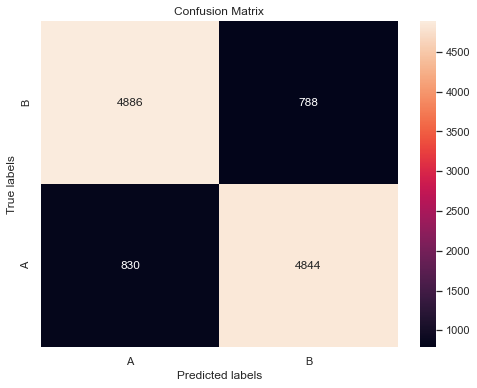

In [130]:
y_pred_cat_cv_bal = cross_val_predict(cat, X_train_selected, y_smt, cv=10)
cm = confusion_matrix(y_smt, y_pred_cat_cv_bal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

In [131]:
cat2 = CatBoostClassifier()
cat2.fit(X_train_selected_2, y_train_imb)
y_pred_cat2 = cat.predict(X_train_selected_2)
cat_results2 = ml_scores('cat', y_train_imb, y_pred_cat2)
cat_results2

Learning rate set to 0.025035
0:	learn: 0.6724984	total: 9.01ms	remaining: 9s
1:	learn: 0.6540392	total: 16.5ms	remaining: 8.22s
2:	learn: 0.6359938	total: 24.1ms	remaining: 8.02s
3:	learn: 0.6191093	total: 38.1ms	remaining: 9.49s
4:	learn: 0.6032965	total: 46.6ms	remaining: 9.27s
5:	learn: 0.5888823	total: 54.7ms	remaining: 9.06s
6:	learn: 0.5748727	total: 63ms	remaining: 8.93s
7:	learn: 0.5610942	total: 72.5ms	remaining: 8.99s
8:	learn: 0.5488338	total: 81.1ms	remaining: 8.93s
9:	learn: 0.5362541	total: 89.4ms	remaining: 8.85s
10:	learn: 0.5264997	total: 98.2ms	remaining: 8.83s
11:	learn: 0.5178541	total: 107ms	remaining: 8.8s
12:	learn: 0.5078577	total: 116ms	remaining: 8.83s
13:	learn: 0.4987026	total: 125ms	remaining: 8.78s
14:	learn: 0.4898632	total: 134ms	remaining: 8.77s
15:	learn: 0.4818672	total: 141ms	remaining: 8.7s
16:	learn: 0.4744186	total: 149ms	remaining: 8.61s
17:	learn: 0.4670862	total: 159ms	remaining: 8.69s
18:	learn: 0.4601888	total: 168ms	remaining: 8.65s
19:	lea

163:	learn: 0.3204417	total: 1.4s	remaining: 7.13s
164:	learn: 0.3203513	total: 1.41s	remaining: 7.13s
165:	learn: 0.3202204	total: 1.42s	remaining: 7.12s
166:	learn: 0.3201066	total: 1.43s	remaining: 7.11s
167:	learn: 0.3199847	total: 1.43s	remaining: 7.1s
168:	learn: 0.3197799	total: 1.44s	remaining: 7.09s
169:	learn: 0.3196252	total: 1.45s	remaining: 7.08s
170:	learn: 0.3194866	total: 1.46s	remaining: 7.08s
171:	learn: 0.3193283	total: 1.47s	remaining: 7.08s
172:	learn: 0.3190785	total: 1.48s	remaining: 7.07s
173:	learn: 0.3188873	total: 1.49s	remaining: 7.06s
174:	learn: 0.3187676	total: 1.49s	remaining: 7.04s
175:	learn: 0.3186164	total: 1.5s	remaining: 7.03s
176:	learn: 0.3184906	total: 1.51s	remaining: 7.03s
177:	learn: 0.3183055	total: 1.52s	remaining: 7.02s
178:	learn: 0.3181550	total: 1.53s	remaining: 7.01s
179:	learn: 0.3180799	total: 1.54s	remaining: 7s
180:	learn: 0.3179667	total: 1.55s	remaining: 7s
181:	learn: 0.3178854	total: 1.56s	remaining: 7s
182:	learn: 0.3177747	to

328:	learn: 0.3032972	total: 2.8s	remaining: 5.71s
329:	learn: 0.3032820	total: 2.81s	remaining: 5.7s
330:	learn: 0.3031607	total: 2.82s	remaining: 5.7s
331:	learn: 0.3030897	total: 2.83s	remaining: 5.69s
332:	learn: 0.3029386	total: 2.83s	remaining: 5.68s
333:	learn: 0.3028187	total: 2.84s	remaining: 5.67s
334:	learn: 0.3027088	total: 2.85s	remaining: 5.66s
335:	learn: 0.3025268	total: 2.86s	remaining: 5.64s
336:	learn: 0.3024262	total: 2.86s	remaining: 5.63s
337:	learn: 0.3023157	total: 2.87s	remaining: 5.62s
338:	learn: 0.3022347	total: 2.88s	remaining: 5.61s
339:	learn: 0.3021267	total: 2.89s	remaining: 5.6s
340:	learn: 0.3020555	total: 2.89s	remaining: 5.59s
341:	learn: 0.3020187	total: 2.9s	remaining: 5.58s
342:	learn: 0.3019063	total: 2.91s	remaining: 5.57s
343:	learn: 0.3018139	total: 2.91s	remaining: 5.56s
344:	learn: 0.3017547	total: 2.92s	remaining: 5.55s
345:	learn: 0.3016789	total: 2.93s	remaining: 5.54s
346:	learn: 0.3015615	total: 2.94s	remaining: 5.53s
347:	learn: 0.301

491:	learn: 0.2890478	total: 4.04s	remaining: 4.17s
492:	learn: 0.2889837	total: 4.05s	remaining: 4.16s
493:	learn: 0.2889149	total: 4.06s	remaining: 4.16s
494:	learn: 0.2888637	total: 4.06s	remaining: 4.15s
495:	learn: 0.2887441	total: 4.07s	remaining: 4.14s
496:	learn: 0.2886635	total: 4.08s	remaining: 4.13s
497:	learn: 0.2885925	total: 4.09s	remaining: 4.12s
498:	learn: 0.2885477	total: 4.09s	remaining: 4.11s
499:	learn: 0.2884769	total: 4.1s	remaining: 4.1s
500:	learn: 0.2883715	total: 4.11s	remaining: 4.09s
501:	learn: 0.2883139	total: 4.12s	remaining: 4.08s
502:	learn: 0.2882233	total: 4.12s	remaining: 4.07s
503:	learn: 0.2881324	total: 4.13s	remaining: 4.07s
504:	learn: 0.2880630	total: 4.14s	remaining: 4.06s
505:	learn: 0.2879748	total: 4.15s	remaining: 4.05s
506:	learn: 0.2879013	total: 4.15s	remaining: 4.04s
507:	learn: 0.2878037	total: 4.16s	remaining: 4.03s
508:	learn: 0.2877034	total: 4.17s	remaining: 4.02s
509:	learn: 0.2876400	total: 4.17s	remaining: 4.01s
510:	learn: 0.

663:	learn: 0.2756346	total: 5.45s	remaining: 2.76s
664:	learn: 0.2755359	total: 5.46s	remaining: 2.75s
665:	learn: 0.2754664	total: 5.47s	remaining: 2.74s
666:	learn: 0.2753827	total: 5.48s	remaining: 2.74s
667:	learn: 0.2753269	total: 5.49s	remaining: 2.73s
668:	learn: 0.2753081	total: 5.5s	remaining: 2.72s
669:	learn: 0.2752154	total: 5.51s	remaining: 2.71s
670:	learn: 0.2751308	total: 5.52s	remaining: 2.71s
671:	learn: 0.2750325	total: 5.53s	remaining: 2.7s
672:	learn: 0.2749544	total: 5.53s	remaining: 2.69s
673:	learn: 0.2748108	total: 5.54s	remaining: 2.68s
674:	learn: 0.2747185	total: 5.55s	remaining: 2.67s
675:	learn: 0.2746666	total: 5.56s	remaining: 2.66s
676:	learn: 0.2745879	total: 5.56s	remaining: 2.65s
677:	learn: 0.2745338	total: 5.57s	remaining: 2.65s
678:	learn: 0.2744865	total: 5.58s	remaining: 2.64s
679:	learn: 0.2744524	total: 5.59s	remaining: 2.63s
680:	learn: 0.2743977	total: 5.59s	remaining: 2.62s
681:	learn: 0.2743567	total: 5.6s	remaining: 2.61s
682:	learn: 0.2

839:	learn: 0.2636578	total: 6.87s	remaining: 1.31s
840:	learn: 0.2635993	total: 6.88s	remaining: 1.3s
841:	learn: 0.2635099	total: 6.89s	remaining: 1.29s
842:	learn: 0.2634391	total: 6.9s	remaining: 1.28s
843:	learn: 0.2634157	total: 6.91s	remaining: 1.28s
844:	learn: 0.2633451	total: 6.91s	remaining: 1.27s
845:	learn: 0.2632919	total: 6.92s	remaining: 1.26s
846:	learn: 0.2632124	total: 6.93s	remaining: 1.25s
847:	learn: 0.2631506	total: 6.93s	remaining: 1.24s
848:	learn: 0.2630602	total: 6.94s	remaining: 1.23s
849:	learn: 0.2630220	total: 6.95s	remaining: 1.23s
850:	learn: 0.2629683	total: 6.96s	remaining: 1.22s
851:	learn: 0.2628748	total: 6.97s	remaining: 1.21s
852:	learn: 0.2628274	total: 6.97s	remaining: 1.2s
853:	learn: 0.2627783	total: 6.98s	remaining: 1.19s
854:	learn: 0.2626939	total: 6.99s	remaining: 1.19s
855:	learn: 0.2626345	total: 7s	remaining: 1.18s
856:	learn: 0.2625663	total: 7s	remaining: 1.17s
857:	learn: 0.2624782	total: 7.01s	remaining: 1.16s
858:	learn: 0.2624162

998:	learn: 0.2539751	total: 8.11s	remaining: 8.12ms
999:	learn: 0.2539030	total: 8.12s	remaining: 0us


Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
cat 0.792000           0.583000   0.715000 0.642000 0.792000 0.539000

In [132]:
cat_cv_imb = performance(cat2,X_train_selected_2,y_train_imb)
cat_cv_imb 

Learning rate set to 0.023934
0:	learn: 0.6732428	total: 10.1ms	remaining: 10.1s
1:	learn: 0.6549315	total: 17.3ms	remaining: 8.65s
2:	learn: 0.6375697	total: 24.6ms	remaining: 8.16s
3:	learn: 0.6205967	total: 33.8ms	remaining: 8.41s
4:	learn: 0.6052728	total: 42.2ms	remaining: 8.39s
5:	learn: 0.5912009	total: 50.6ms	remaining: 8.38s
6:	learn: 0.5775596	total: 59.3ms	remaining: 8.42s
7:	learn: 0.5640480	total: 67.5ms	remaining: 8.37s
8:	learn: 0.5520777	total: 75.2ms	remaining: 8.29s
9:	learn: 0.5396757	total: 82.9ms	remaining: 8.21s
10:	learn: 0.5298841	total: 91ms	remaining: 8.18s
11:	learn: 0.5191633	total: 98.6ms	remaining: 8.12s
12:	learn: 0.5094644	total: 106ms	remaining: 8.08s
13:	learn: 0.5004684	total: 113ms	remaining: 7.97s
14:	learn: 0.4925776	total: 120ms	remaining: 7.87s
15:	learn: 0.4847013	total: 127ms	remaining: 7.79s
16:	learn: 0.4772789	total: 133ms	remaining: 7.71s
17:	learn: 0.4699919	total: 140ms	remaining: 7.64s
18:	learn: 0.4647754	total: 146ms	remaining: 7.52s
1

166:	learn: 0.3196957	total: 1.23s	remaining: 6.14s
167:	learn: 0.3194454	total: 1.24s	remaining: 6.13s
168:	learn: 0.3192117	total: 1.25s	remaining: 6.12s
169:	learn: 0.3190644	total: 1.25s	remaining: 6.11s
170:	learn: 0.3189037	total: 1.26s	remaining: 6.11s
171:	learn: 0.3187420	total: 1.27s	remaining: 6.1s
172:	learn: 0.3186701	total: 1.27s	remaining: 6.09s
173:	learn: 0.3184102	total: 1.28s	remaining: 6.08s
174:	learn: 0.3182665	total: 1.29s	remaining: 6.08s
175:	learn: 0.3181831	total: 1.3s	remaining: 6.07s
176:	learn: 0.3179992	total: 1.3s	remaining: 6.06s
177:	learn: 0.3178776	total: 1.31s	remaining: 6.05s
178:	learn: 0.3177897	total: 1.32s	remaining: 6.04s
179:	learn: 0.3176601	total: 1.32s	remaining: 6.03s
180:	learn: 0.3175650	total: 1.33s	remaining: 6.02s
181:	learn: 0.3174407	total: 1.34s	remaining: 6.01s
182:	learn: 0.3173048	total: 1.34s	remaining: 6s
183:	learn: 0.3172074	total: 1.35s	remaining: 5.99s
184:	learn: 0.3170753	total: 1.36s	remaining: 5.98s
185:	learn: 0.3169

338:	learn: 0.3009793	total: 2.46s	remaining: 4.81s
339:	learn: 0.3008405	total: 2.47s	remaining: 4.8s
340:	learn: 0.3008201	total: 2.48s	remaining: 4.79s
341:	learn: 0.3007442	total: 2.48s	remaining: 4.78s
342:	learn: 0.3006595	total: 2.49s	remaining: 4.77s
343:	learn: 0.3005890	total: 2.5s	remaining: 4.76s
344:	learn: 0.3004745	total: 2.5s	remaining: 4.75s
345:	learn: 0.3003815	total: 2.51s	remaining: 4.75s
346:	learn: 0.3003050	total: 2.52s	remaining: 4.74s
347:	learn: 0.3002118	total: 2.52s	remaining: 4.73s
348:	learn: 0.3001082	total: 2.53s	remaining: 4.72s
349:	learn: 0.2999967	total: 2.54s	remaining: 4.71s
350:	learn: 0.2999475	total: 2.54s	remaining: 4.71s
351:	learn: 0.2998681	total: 2.55s	remaining: 4.7s
352:	learn: 0.2997995	total: 2.56s	remaining: 4.69s
353:	learn: 0.2997530	total: 2.56s	remaining: 4.68s
354:	learn: 0.2996871	total: 2.57s	remaining: 4.67s
355:	learn: 0.2996391	total: 2.58s	remaining: 4.67s
356:	learn: 0.2995056	total: 2.58s	remaining: 4.66s
357:	learn: 0.29

513:	learn: 0.2857891	total: 3.69s	remaining: 3.49s
514:	learn: 0.2857137	total: 3.7s	remaining: 3.48s
515:	learn: 0.2856144	total: 3.71s	remaining: 3.48s
516:	learn: 0.2854859	total: 3.71s	remaining: 3.47s
517:	learn: 0.2854141	total: 3.72s	remaining: 3.46s
518:	learn: 0.2852702	total: 3.73s	remaining: 3.46s
519:	learn: 0.2851927	total: 3.74s	remaining: 3.45s
520:	learn: 0.2850999	total: 3.75s	remaining: 3.44s
521:	learn: 0.2850363	total: 3.75s	remaining: 3.44s
522:	learn: 0.2849490	total: 3.76s	remaining: 3.43s
523:	learn: 0.2848715	total: 3.77s	remaining: 3.42s
524:	learn: 0.2847961	total: 3.77s	remaining: 3.42s
525:	learn: 0.2847090	total: 3.78s	remaining: 3.41s
526:	learn: 0.2846587	total: 3.79s	remaining: 3.4s
527:	learn: 0.2845300	total: 3.79s	remaining: 3.39s
528:	learn: 0.2844712	total: 3.8s	remaining: 3.39s
529:	learn: 0.2843983	total: 3.81s	remaining: 3.38s
530:	learn: 0.2843502	total: 3.82s	remaining: 3.37s
531:	learn: 0.2842745	total: 3.82s	remaining: 3.36s
532:	learn: 0.2

683:	learn: 0.2722177	total: 4.93s	remaining: 2.28s
684:	learn: 0.2721631	total: 4.93s	remaining: 2.27s
685:	learn: 0.2721064	total: 4.94s	remaining: 2.26s
686:	learn: 0.2720620	total: 4.95s	remaining: 2.25s
687:	learn: 0.2719946	total: 4.96s	remaining: 2.25s
688:	learn: 0.2719610	total: 4.96s	remaining: 2.24s
689:	learn: 0.2718994	total: 4.97s	remaining: 2.23s
690:	learn: 0.2718398	total: 4.98s	remaining: 2.23s
691:	learn: 0.2717005	total: 4.99s	remaining: 2.22s
692:	learn: 0.2716374	total: 4.99s	remaining: 2.21s
693:	learn: 0.2715708	total: 5s	remaining: 2.2s
694:	learn: 0.2715108	total: 5.01s	remaining: 2.2s
695:	learn: 0.2714360	total: 5.01s	remaining: 2.19s
696:	learn: 0.2713962	total: 5.02s	remaining: 2.18s
697:	learn: 0.2713286	total: 5.03s	remaining: 2.17s
698:	learn: 0.2711939	total: 5.04s	remaining: 2.17s
699:	learn: 0.2711433	total: 5.04s	remaining: 2.16s
700:	learn: 0.2710881	total: 5.05s	remaining: 2.15s
701:	learn: 0.2710362	total: 5.06s	remaining: 2.15s
702:	learn: 0.270

856:	learn: 0.2599025	total: 6.16s	remaining: 1.03s
857:	learn: 0.2598400	total: 6.17s	remaining: 1.02s
858:	learn: 0.2597483	total: 6.17s	remaining: 1.01s
859:	learn: 0.2596948	total: 6.18s	remaining: 1.01s
860:	learn: 0.2596250	total: 6.19s	remaining: 999ms
861:	learn: 0.2595582	total: 6.2s	remaining: 992ms
862:	learn: 0.2594755	total: 6.2s	remaining: 985ms
863:	learn: 0.2594076	total: 6.21s	remaining: 978ms
864:	learn: 0.2593436	total: 6.22s	remaining: 970ms
865:	learn: 0.2592831	total: 6.22s	remaining: 963ms
866:	learn: 0.2592241	total: 6.23s	remaining: 956ms
867:	learn: 0.2591474	total: 6.24s	remaining: 949ms
868:	learn: 0.2591121	total: 6.25s	remaining: 942ms
869:	learn: 0.2590527	total: 6.25s	remaining: 934ms
870:	learn: 0.2590001	total: 6.26s	remaining: 927ms
871:	learn: 0.2589492	total: 6.27s	remaining: 920ms
872:	learn: 0.2588840	total: 6.27s	remaining: 913ms
873:	learn: 0.2588289	total: 6.28s	remaining: 905ms
874:	learn: 0.2587638	total: 6.29s	remaining: 898ms
875:	learn: 0.

26:	learn: 0.4280273	total: 183ms	remaining: 6.6s
27:	learn: 0.4243947	total: 192ms	remaining: 6.66s
28:	learn: 0.4211432	total: 199ms	remaining: 6.66s
29:	learn: 0.4168240	total: 206ms	remaining: 6.67s
30:	learn: 0.4126947	total: 215ms	remaining: 6.73s
31:	learn: 0.4095578	total: 225ms	remaining: 6.79s
32:	learn: 0.4065786	total: 232ms	remaining: 6.8s
33:	learn: 0.4038772	total: 239ms	remaining: 6.8s
34:	learn: 0.4012398	total: 246ms	remaining: 6.79s
35:	learn: 0.3988919	total: 254ms	remaining: 6.8s
36:	learn: 0.3968896	total: 261ms	remaining: 6.79s
37:	learn: 0.3947302	total: 270ms	remaining: 6.82s
38:	learn: 0.3924623	total: 277ms	remaining: 6.83s
39:	learn: 0.3903819	total: 286ms	remaining: 6.86s
40:	learn: 0.3881866	total: 293ms	remaining: 6.85s
41:	learn: 0.3865150	total: 300ms	remaining: 6.85s
42:	learn: 0.3838542	total: 308ms	remaining: 6.85s
43:	learn: 0.3824095	total: 314ms	remaining: 6.83s
44:	learn: 0.3804236	total: 322ms	remaining: 6.83s
45:	learn: 0.3789871	total: 329ms	r

202:	learn: 0.3161201	total: 1.59s	remaining: 6.26s
203:	learn: 0.3160242	total: 1.6s	remaining: 6.25s
204:	learn: 0.3158829	total: 1.61s	remaining: 6.24s
205:	learn: 0.3157860	total: 1.61s	remaining: 6.23s
206:	learn: 0.3156305	total: 1.62s	remaining: 6.21s
207:	learn: 0.3155212	total: 1.63s	remaining: 6.2s
208:	learn: 0.3154128	total: 1.64s	remaining: 6.19s
209:	learn: 0.3152468	total: 1.64s	remaining: 6.18s
210:	learn: 0.3151491	total: 1.65s	remaining: 6.18s
211:	learn: 0.3150494	total: 1.66s	remaining: 6.17s
212:	learn: 0.3149455	total: 1.67s	remaining: 6.16s
213:	learn: 0.3148722	total: 1.67s	remaining: 6.15s
214:	learn: 0.3147576	total: 1.68s	remaining: 6.14s
215:	learn: 0.3146016	total: 1.69s	remaining: 6.13s
216:	learn: 0.3145344	total: 1.7s	remaining: 6.12s
217:	learn: 0.3144512	total: 1.7s	remaining: 6.11s
218:	learn: 0.3143312	total: 1.71s	remaining: 6.1s
219:	learn: 0.3142572	total: 1.72s	remaining: 6.08s
220:	learn: 0.3140828	total: 1.72s	remaining: 6.08s
221:	learn: 0.313

376:	learn: 0.2987478	total: 2.83s	remaining: 4.67s
377:	learn: 0.2986385	total: 2.84s	remaining: 4.67s
378:	learn: 0.2985338	total: 2.84s	remaining: 4.66s
379:	learn: 0.2984230	total: 2.85s	remaining: 4.65s
380:	learn: 0.2983429	total: 2.86s	remaining: 4.65s
381:	learn: 0.2982185	total: 2.87s	remaining: 4.64s
382:	learn: 0.2980661	total: 2.87s	remaining: 4.63s
383:	learn: 0.2979820	total: 2.88s	remaining: 4.62s
384:	learn: 0.2978767	total: 2.89s	remaining: 4.61s
385:	learn: 0.2977512	total: 2.89s	remaining: 4.6s
386:	learn: 0.2976561	total: 2.9s	remaining: 4.59s
387:	learn: 0.2975517	total: 2.91s	remaining: 4.59s
388:	learn: 0.2974711	total: 2.92s	remaining: 4.58s
389:	learn: 0.2974213	total: 2.92s	remaining: 4.57s
390:	learn: 0.2973835	total: 2.93s	remaining: 4.56s
391:	learn: 0.2973104	total: 2.94s	remaining: 4.55s
392:	learn: 0.2972017	total: 2.94s	remaining: 4.54s
393:	learn: 0.2971536	total: 2.95s	remaining: 4.54s
394:	learn: 0.2970098	total: 2.96s	remaining: 4.53s
395:	learn: 0.

551:	learn: 0.2835152	total: 4.07s	remaining: 3.31s
552:	learn: 0.2834884	total: 4.08s	remaining: 3.3s
553:	learn: 0.2833829	total: 4.09s	remaining: 3.29s
554:	learn: 0.2833352	total: 4.09s	remaining: 3.28s
555:	learn: 0.2832507	total: 4.1s	remaining: 3.27s
556:	learn: 0.2831946	total: 4.11s	remaining: 3.27s
557:	learn: 0.2830982	total: 4.12s	remaining: 3.26s
558:	learn: 0.2830350	total: 4.12s	remaining: 3.25s
559:	learn: 0.2829608	total: 4.13s	remaining: 3.25s
560:	learn: 0.2828300	total: 4.14s	remaining: 3.24s
561:	learn: 0.2827495	total: 4.14s	remaining: 3.23s
562:	learn: 0.2826618	total: 4.15s	remaining: 3.22s
563:	learn: 0.2825519	total: 4.16s	remaining: 3.21s
564:	learn: 0.2825183	total: 4.17s	remaining: 3.21s
565:	learn: 0.2824017	total: 4.17s	remaining: 3.2s
566:	learn: 0.2823434	total: 4.18s	remaining: 3.19s
567:	learn: 0.2822350	total: 4.18s	remaining: 3.18s
568:	learn: 0.2821426	total: 4.19s	remaining: 3.17s
569:	learn: 0.2820949	total: 4.2s	remaining: 3.17s
570:	learn: 0.28

724:	learn: 0.2697657	total: 5.3s	remaining: 2.01s
725:	learn: 0.2696861	total: 5.31s	remaining: 2s
726:	learn: 0.2696050	total: 5.31s	remaining: 2s
727:	learn: 0.2695786	total: 5.32s	remaining: 1.99s
728:	learn: 0.2694648	total: 5.33s	remaining: 1.98s
729:	learn: 0.2693903	total: 5.33s	remaining: 1.97s
730:	learn: 0.2693189	total: 5.34s	remaining: 1.97s
731:	learn: 0.2692401	total: 5.35s	remaining: 1.96s
732:	learn: 0.2691819	total: 5.36s	remaining: 1.95s
733:	learn: 0.2691304	total: 5.36s	remaining: 1.94s
734:	learn: 0.2690502	total: 5.37s	remaining: 1.94s
735:	learn: 0.2689770	total: 5.38s	remaining: 1.93s
736:	learn: 0.2688974	total: 5.38s	remaining: 1.92s
737:	learn: 0.2687516	total: 5.39s	remaining: 1.91s
738:	learn: 0.2686870	total: 5.4s	remaining: 1.91s
739:	learn: 0.2686185	total: 5.4s	remaining: 1.9s
740:	learn: 0.2685677	total: 5.41s	remaining: 1.89s
741:	learn: 0.2684942	total: 5.42s	remaining: 1.88s
742:	learn: 0.2684053	total: 5.42s	remaining: 1.88s
743:	learn: 0.2682643	

899:	learn: 0.2576145	total: 6.54s	remaining: 726ms
900:	learn: 0.2575676	total: 6.54s	remaining: 719ms
901:	learn: 0.2574993	total: 6.55s	remaining: 712ms
902:	learn: 0.2574283	total: 6.56s	remaining: 704ms
903:	learn: 0.2573838	total: 6.57s	remaining: 697ms
904:	learn: 0.2572702	total: 6.57s	remaining: 690ms
905:	learn: 0.2571963	total: 6.58s	remaining: 683ms
906:	learn: 0.2571527	total: 6.59s	remaining: 675ms
907:	learn: 0.2570762	total: 6.59s	remaining: 668ms
908:	learn: 0.2570368	total: 6.6s	remaining: 661ms
909:	learn: 0.2569470	total: 6.61s	remaining: 653ms
910:	learn: 0.2568784	total: 6.61s	remaining: 646ms
911:	learn: 0.2568312	total: 6.62s	remaining: 639ms
912:	learn: 0.2567895	total: 6.63s	remaining: 631ms
913:	learn: 0.2566878	total: 6.63s	remaining: 624ms
914:	learn: 0.2566206	total: 6.64s	remaining: 617ms
915:	learn: 0.2565492	total: 6.65s	remaining: 610ms
916:	learn: 0.2564652	total: 6.65s	remaining: 602ms
917:	learn: 0.2563972	total: 6.66s	remaining: 595ms
918:	learn: 0

61:	learn: 0.3600366	total: 439ms	remaining: 6.64s
62:	learn: 0.3590367	total: 446ms	remaining: 6.63s
63:	learn: 0.3582487	total: 454ms	remaining: 6.63s
64:	learn: 0.3576225	total: 461ms	remaining: 6.63s
65:	learn: 0.3565434	total: 469ms	remaining: 6.63s
66:	learn: 0.3557086	total: 476ms	remaining: 6.63s
67:	learn: 0.3549430	total: 483ms	remaining: 6.62s
68:	learn: 0.3539255	total: 491ms	remaining: 6.62s
69:	learn: 0.3534629	total: 498ms	remaining: 6.61s
70:	learn: 0.3525013	total: 506ms	remaining: 6.62s
71:	learn: 0.3517142	total: 513ms	remaining: 6.61s
72:	learn: 0.3511766	total: 520ms	remaining: 6.61s
73:	learn: 0.3503869	total: 527ms	remaining: 6.6s
74:	learn: 0.3496669	total: 534ms	remaining: 6.59s
75:	learn: 0.3488190	total: 541ms	remaining: 6.58s
76:	learn: 0.3479691	total: 549ms	remaining: 6.58s
77:	learn: 0.3475069	total: 557ms	remaining: 6.58s
78:	learn: 0.3468838	total: 564ms	remaining: 6.58s
79:	learn: 0.3463833	total: 571ms	remaining: 6.57s
80:	learn: 0.3458356	total: 579m

233:	learn: 0.3113782	total: 1.67s	remaining: 5.47s
234:	learn: 0.3112597	total: 1.68s	remaining: 5.46s
235:	learn: 0.3111922	total: 1.69s	remaining: 5.46s
236:	learn: 0.3110969	total: 1.69s	remaining: 5.45s
237:	learn: 0.3110378	total: 1.7s	remaining: 5.44s
238:	learn: 0.3109095	total: 1.71s	remaining: 5.43s
239:	learn: 0.3108385	total: 1.71s	remaining: 5.43s
240:	learn: 0.3107579	total: 1.72s	remaining: 5.42s
241:	learn: 0.3106445	total: 1.73s	remaining: 5.42s
242:	learn: 0.3106006	total: 1.74s	remaining: 5.41s
243:	learn: 0.3105027	total: 1.74s	remaining: 5.4s
244:	learn: 0.3104364	total: 1.75s	remaining: 5.39s
245:	learn: 0.3103436	total: 1.76s	remaining: 5.39s
246:	learn: 0.3101481	total: 1.76s	remaining: 5.38s
247:	learn: 0.3100320	total: 1.77s	remaining: 5.37s
248:	learn: 0.3098883	total: 1.78s	remaining: 5.36s
249:	learn: 0.3098787	total: 1.78s	remaining: 5.35s
250:	learn: 0.3097063	total: 1.79s	remaining: 5.34s
251:	learn: 0.3095811	total: 1.8s	remaining: 5.33s
252:	learn: 0.3

409:	learn: 0.2947068	total: 2.91s	remaining: 4.19s
410:	learn: 0.2946272	total: 2.92s	remaining: 4.18s
411:	learn: 0.2945610	total: 2.92s	remaining: 4.17s
412:	learn: 0.2945079	total: 2.93s	remaining: 4.17s
413:	learn: 0.2944304	total: 2.94s	remaining: 4.16s
414:	learn: 0.2943558	total: 2.94s	remaining: 4.15s
415:	learn: 0.2942971	total: 2.95s	remaining: 4.14s
416:	learn: 0.2941886	total: 2.96s	remaining: 4.14s
417:	learn: 0.2940846	total: 2.97s	remaining: 4.13s
418:	learn: 0.2940100	total: 2.97s	remaining: 4.13s
419:	learn: 0.2939150	total: 2.98s	remaining: 4.12s
420:	learn: 0.2938288	total: 2.99s	remaining: 4.11s
421:	learn: 0.2937001	total: 3s	remaining: 4.1s
422:	learn: 0.2936059	total: 3s	remaining: 4.09s
423:	learn: 0.2935279	total: 3.01s	remaining: 4.09s
424:	learn: 0.2934238	total: 3.02s	remaining: 4.08s
425:	learn: 0.2932837	total: 3.02s	remaining: 4.07s
426:	learn: 0.2931753	total: 3.03s	remaining: 4.06s
427:	learn: 0.2931056	total: 3.04s	remaining: 4.06s
428:	learn: 0.29301

585:	learn: 0.2792251	total: 4.15s	remaining: 2.93s
586:	learn: 0.2791364	total: 4.16s	remaining: 2.93s
587:	learn: 0.2790675	total: 4.17s	remaining: 2.92s
588:	learn: 0.2789981	total: 4.17s	remaining: 2.91s
589:	learn: 0.2789137	total: 4.18s	remaining: 2.91s
590:	learn: 0.2788358	total: 4.19s	remaining: 2.9s
591:	learn: 0.2787746	total: 4.2s	remaining: 2.89s
592:	learn: 0.2786776	total: 4.2s	remaining: 2.88s
593:	learn: 0.2786021	total: 4.21s	remaining: 2.88s
594:	learn: 0.2785385	total: 4.22s	remaining: 2.87s
595:	learn: 0.2784819	total: 4.22s	remaining: 2.86s
596:	learn: 0.2784366	total: 4.23s	remaining: 2.86s
597:	learn: 0.2783627	total: 4.24s	remaining: 2.85s
598:	learn: 0.2782647	total: 4.25s	remaining: 2.84s
599:	learn: 0.2781681	total: 4.25s	remaining: 2.84s
600:	learn: 0.2780420	total: 4.26s	remaining: 2.83s
601:	learn: 0.2779452	total: 4.27s	remaining: 2.82s
602:	learn: 0.2778651	total: 4.27s	remaining: 2.81s
603:	learn: 0.2778146	total: 4.28s	remaining: 2.81s
604:	learn: 0.2

758:	learn: 0.2665753	total: 5.38s	remaining: 1.71s
759:	learn: 0.2665024	total: 5.39s	remaining: 1.7s
760:	learn: 0.2664285	total: 5.4s	remaining: 1.7s
761:	learn: 0.2663459	total: 5.41s	remaining: 1.69s
762:	learn: 0.2662845	total: 5.42s	remaining: 1.68s
763:	learn: 0.2662183	total: 5.42s	remaining: 1.68s
764:	learn: 0.2661276	total: 5.43s	remaining: 1.67s
765:	learn: 0.2660440	total: 5.44s	remaining: 1.66s
766:	learn: 0.2659406	total: 5.44s	remaining: 1.65s
767:	learn: 0.2658946	total: 5.45s	remaining: 1.65s
768:	learn: 0.2658161	total: 5.46s	remaining: 1.64s
769:	learn: 0.2657507	total: 5.47s	remaining: 1.63s
770:	learn: 0.2656815	total: 5.47s	remaining: 1.63s
771:	learn: 0.2656024	total: 5.48s	remaining: 1.62s
772:	learn: 0.2655464	total: 5.49s	remaining: 1.61s
773:	learn: 0.2654919	total: 5.5s	remaining: 1.6s
774:	learn: 0.2654204	total: 5.5s	remaining: 1.6s
775:	learn: 0.2653516	total: 5.51s	remaining: 1.59s
776:	learn: 0.2653025	total: 5.52s	remaining: 1.58s
777:	learn: 0.26523

932:	learn: 0.2547750	total: 6.62s	remaining: 476ms
933:	learn: 0.2547471	total: 6.63s	remaining: 468ms
934:	learn: 0.2546776	total: 6.64s	remaining: 461ms
935:	learn: 0.2545558	total: 6.64s	remaining: 454ms
936:	learn: 0.2544911	total: 6.65s	remaining: 447ms
937:	learn: 0.2544071	total: 6.66s	remaining: 440ms
938:	learn: 0.2543683	total: 6.67s	remaining: 433ms
939:	learn: 0.2543056	total: 6.67s	remaining: 426ms
940:	learn: 0.2542540	total: 6.68s	remaining: 419ms
941:	learn: 0.2541887	total: 6.69s	remaining: 412ms
942:	learn: 0.2541117	total: 6.69s	remaining: 405ms
943:	learn: 0.2540667	total: 6.7s	remaining: 398ms
944:	learn: 0.2540182	total: 6.71s	remaining: 390ms
945:	learn: 0.2539565	total: 6.71s	remaining: 383ms
946:	learn: 0.2538870	total: 6.72s	remaining: 376ms
947:	learn: 0.2538226	total: 6.73s	remaining: 369ms
948:	learn: 0.2537748	total: 6.74s	remaining: 362ms
949:	learn: 0.2537130	total: 6.74s	remaining: 355ms
950:	learn: 0.2536609	total: 6.75s	remaining: 348ms
951:	learn: 0

99:	learn: 0.3389922	total: 706ms	remaining: 6.36s
100:	learn: 0.3386475	total: 713ms	remaining: 6.35s
101:	learn: 0.3381907	total: 720ms	remaining: 6.34s
102:	learn: 0.3379765	total: 727ms	remaining: 6.33s
103:	learn: 0.3375430	total: 734ms	remaining: 6.33s
104:	learn: 0.3373339	total: 741ms	remaining: 6.32s
105:	learn: 0.3370060	total: 748ms	remaining: 6.31s
106:	learn: 0.3366538	total: 755ms	remaining: 6.3s
107:	learn: 0.3364933	total: 761ms	remaining: 6.28s
108:	learn: 0.3360512	total: 768ms	remaining: 6.28s
109:	learn: 0.3358242	total: 774ms	remaining: 6.26s
110:	learn: 0.3355706	total: 783ms	remaining: 6.27s
111:	learn: 0.3352591	total: 791ms	remaining: 6.27s
112:	learn: 0.3350446	total: 800ms	remaining: 6.28s
113:	learn: 0.3345736	total: 807ms	remaining: 6.27s
114:	learn: 0.3343497	total: 815ms	remaining: 6.27s
115:	learn: 0.3339007	total: 823ms	remaining: 6.27s
116:	learn: 0.3336578	total: 831ms	remaining: 6.27s
117:	learn: 0.3333682	total: 839ms	remaining: 6.27s
118:	learn: 0.

258:	learn: 0.3120010	total: 1.94s	remaining: 5.55s
259:	learn: 0.3119599	total: 1.95s	remaining: 5.54s
260:	learn: 0.3117784	total: 1.96s	remaining: 5.54s
261:	learn: 0.3116878	total: 1.97s	remaining: 5.54s
262:	learn: 0.3116183	total: 1.97s	remaining: 5.53s
263:	learn: 0.3115630	total: 1.98s	remaining: 5.52s
264:	learn: 0.3114947	total: 1.99s	remaining: 5.52s
265:	learn: 0.3113948	total: 2s	remaining: 5.51s
266:	learn: 0.3113540	total: 2.01s	remaining: 5.51s
267:	learn: 0.3111995	total: 2.02s	remaining: 5.51s
268:	learn: 0.3110783	total: 2.02s	remaining: 5.5s
269:	learn: 0.3110098	total: 2.03s	remaining: 5.5s
270:	learn: 0.3108964	total: 2.04s	remaining: 5.49s
271:	learn: 0.3107964	total: 2.05s	remaining: 5.48s
272:	learn: 0.3107270	total: 2.06s	remaining: 5.47s
273:	learn: 0.3106492	total: 2.06s	remaining: 5.47s
274:	learn: 0.3105585	total: 2.07s	remaining: 5.46s
275:	learn: 0.3104414	total: 2.08s	remaining: 5.45s
276:	learn: 0.3103447	total: 2.08s	remaining: 5.44s
277:	learn: 0.310

427:	learn: 0.2966643	total: 3.18s	remaining: 4.25s
428:	learn: 0.2966184	total: 3.19s	remaining: 4.24s
429:	learn: 0.2965362	total: 3.19s	remaining: 4.24s
430:	learn: 0.2964925	total: 3.2s	remaining: 4.23s
431:	learn: 0.2963798	total: 3.21s	remaining: 4.22s
432:	learn: 0.2962951	total: 3.22s	remaining: 4.21s
433:	learn: 0.2962101	total: 3.22s	remaining: 4.2s
434:	learn: 0.2960767	total: 3.23s	remaining: 4.2s
435:	learn: 0.2960333	total: 3.24s	remaining: 4.19s
436:	learn: 0.2959744	total: 3.24s	remaining: 4.18s
437:	learn: 0.2958709	total: 3.25s	remaining: 4.17s
438:	learn: 0.2957911	total: 3.26s	remaining: 4.16s
439:	learn: 0.2956794	total: 3.27s	remaining: 4.16s
440:	learn: 0.2955914	total: 3.27s	remaining: 4.15s
441:	learn: 0.2955005	total: 3.28s	remaining: 4.14s
442:	learn: 0.2953755	total: 3.29s	remaining: 4.13s
443:	learn: 0.2952735	total: 3.29s	remaining: 4.12s
444:	learn: 0.2951942	total: 3.3s	remaining: 4.12s
445:	learn: 0.2951108	total: 3.31s	remaining: 4.11s
446:	learn: 0.29

602:	learn: 0.2816868	total: 4.41s	remaining: 2.9s
603:	learn: 0.2816377	total: 4.42s	remaining: 2.9s
604:	learn: 0.2815125	total: 4.42s	remaining: 2.89s
605:	learn: 0.2814558	total: 4.43s	remaining: 2.88s
606:	learn: 0.2813987	total: 4.44s	remaining: 2.87s
607:	learn: 0.2813286	total: 4.45s	remaining: 2.87s
608:	learn: 0.2812569	total: 4.46s	remaining: 2.86s
609:	learn: 0.2811924	total: 4.46s	remaining: 2.85s
610:	learn: 0.2811399	total: 4.47s	remaining: 2.85s
611:	learn: 0.2810792	total: 4.48s	remaining: 2.84s
612:	learn: 0.2809690	total: 4.48s	remaining: 2.83s
613:	learn: 0.2808829	total: 4.49s	remaining: 2.82s
614:	learn: 0.2807546	total: 4.5s	remaining: 2.82s
615:	learn: 0.2806515	total: 4.5s	remaining: 2.81s
616:	learn: 0.2805798	total: 4.51s	remaining: 2.8s
617:	learn: 0.2804842	total: 4.52s	remaining: 2.79s
618:	learn: 0.2803652	total: 4.53s	remaining: 2.79s
619:	learn: 0.2802816	total: 4.53s	remaining: 2.78s
620:	learn: 0.2802146	total: 4.54s	remaining: 2.77s
621:	learn: 0.280

775:	learn: 0.2689444	total: 5.66s	remaining: 1.63s
776:	learn: 0.2688994	total: 5.66s	remaining: 1.63s
777:	learn: 0.2688146	total: 5.67s	remaining: 1.62s
778:	learn: 0.2687592	total: 5.68s	remaining: 1.61s
779:	learn: 0.2686777	total: 5.68s	remaining: 1.6s
780:	learn: 0.2685546	total: 5.69s	remaining: 1.6s
781:	learn: 0.2684360	total: 5.7s	remaining: 1.59s
782:	learn: 0.2683765	total: 5.71s	remaining: 1.58s
783:	learn: 0.2682489	total: 5.71s	remaining: 1.57s
784:	learn: 0.2681730	total: 5.72s	remaining: 1.57s
785:	learn: 0.2681206	total: 5.73s	remaining: 1.56s
786:	learn: 0.2680527	total: 5.74s	remaining: 1.55s
787:	learn: 0.2679688	total: 5.74s	remaining: 1.54s
788:	learn: 0.2679218	total: 5.75s	remaining: 1.54s
789:	learn: 0.2678569	total: 5.76s	remaining: 1.53s
790:	learn: 0.2677979	total: 5.76s	remaining: 1.52s
791:	learn: 0.2677359	total: 5.77s	remaining: 1.51s
792:	learn: 0.2676923	total: 5.78s	remaining: 1.51s
793:	learn: 0.2675939	total: 5.78s	remaining: 1.5s
794:	learn: 0.26

950:	learn: 0.2571941	total: 6.89s	remaining: 355ms
951:	learn: 0.2571356	total: 6.9s	remaining: 348ms
952:	learn: 0.2570746	total: 6.91s	remaining: 341ms
953:	learn: 0.2570159	total: 6.91s	remaining: 333ms
954:	learn: 0.2569825	total: 6.92s	remaining: 326ms
955:	learn: 0.2569107	total: 6.93s	remaining: 319ms
956:	learn: 0.2568353	total: 6.93s	remaining: 312ms
957:	learn: 0.2567476	total: 6.94s	remaining: 304ms
958:	learn: 0.2566800	total: 6.95s	remaining: 297ms
959:	learn: 0.2565855	total: 6.96s	remaining: 290ms
960:	learn: 0.2565351	total: 6.96s	remaining: 283ms
961:	learn: 0.2564473	total: 6.97s	remaining: 275ms
962:	learn: 0.2563912	total: 6.98s	remaining: 268ms
963:	learn: 0.2563314	total: 6.98s	remaining: 261ms
964:	learn: 0.2562662	total: 6.99s	remaining: 254ms
965:	learn: 0.2562009	total: 7s	remaining: 246ms
966:	learn: 0.2561390	total: 7s	remaining: 239ms
967:	learn: 0.2560832	total: 7.01s	remaining: 232ms
968:	learn: 0.2560391	total: 7.02s	remaining: 225ms
969:	learn: 0.25596

120:	learn: 0.3233407	total: 890ms	remaining: 6.47s
121:	learn: 0.3231219	total: 899ms	remaining: 6.47s
122:	learn: 0.3226597	total: 909ms	remaining: 6.48s
123:	learn: 0.3224156	total: 917ms	remaining: 6.48s
124:	learn: 0.3221688	total: 925ms	remaining: 6.48s
125:	learn: 0.3218490	total: 934ms	remaining: 6.48s
126:	learn: 0.3216349	total: 943ms	remaining: 6.48s
127:	learn: 0.3214465	total: 951ms	remaining: 6.48s
128:	learn: 0.3212457	total: 958ms	remaining: 6.47s
129:	learn: 0.3210131	total: 966ms	remaining: 6.46s
130:	learn: 0.3205991	total: 975ms	remaining: 6.47s
131:	learn: 0.3202975	total: 983ms	remaining: 6.47s
132:	learn: 0.3201597	total: 990ms	remaining: 6.46s
133:	learn: 0.3197910	total: 998ms	remaining: 6.45s
134:	learn: 0.3194831	total: 1.01s	remaining: 6.47s
135:	learn: 0.3192542	total: 1.02s	remaining: 6.47s
136:	learn: 0.3191032	total: 1.03s	remaining: 6.47s
137:	learn: 0.3189482	total: 1.03s	remaining: 6.46s
138:	learn: 0.3188052	total: 1.04s	remaining: 6.46s
139:	learn: 

295:	learn: 0.2998611	total: 2.29s	remaining: 5.44s
296:	learn: 0.2997802	total: 2.3s	remaining: 5.44s
297:	learn: 0.2996843	total: 2.31s	remaining: 5.43s
298:	learn: 0.2995742	total: 2.31s	remaining: 5.43s
299:	learn: 0.2994681	total: 2.32s	remaining: 5.42s
300:	learn: 0.2993605	total: 2.33s	remaining: 5.41s
301:	learn: 0.2992569	total: 2.34s	remaining: 5.41s
302:	learn: 0.2991488	total: 2.35s	remaining: 5.4s
303:	learn: 0.2990932	total: 2.35s	remaining: 5.39s
304:	learn: 0.2990671	total: 2.36s	remaining: 5.38s
305:	learn: 0.2989818	total: 2.37s	remaining: 5.37s
306:	learn: 0.2988507	total: 2.38s	remaining: 5.36s
307:	learn: 0.2986773	total: 2.38s	remaining: 5.35s
308:	learn: 0.2985371	total: 2.39s	remaining: 5.35s
309:	learn: 0.2983785	total: 2.4s	remaining: 5.34s
310:	learn: 0.2982758	total: 2.4s	remaining: 5.33s
311:	learn: 0.2981875	total: 2.41s	remaining: 5.32s
312:	learn: 0.2980856	total: 2.42s	remaining: 5.31s
313:	learn: 0.2980130	total: 2.43s	remaining: 5.3s
314:	learn: 0.297

460:	learn: 0.2847802	total: 3.52s	remaining: 4.12s
461:	learn: 0.2846865	total: 3.53s	remaining: 4.11s
462:	learn: 0.2846290	total: 3.53s	remaining: 4.1s
463:	learn: 0.2845267	total: 3.54s	remaining: 4.09s
464:	learn: 0.2844400	total: 3.55s	remaining: 4.08s
465:	learn: 0.2843617	total: 3.56s	remaining: 4.07s
466:	learn: 0.2842838	total: 3.56s	remaining: 4.07s
467:	learn: 0.2842510	total: 3.57s	remaining: 4.06s
468:	learn: 0.2841700	total: 3.58s	remaining: 4.05s
469:	learn: 0.2840729	total: 3.58s	remaining: 4.04s
470:	learn: 0.2840169	total: 3.59s	remaining: 4.03s
471:	learn: 0.2838941	total: 3.6s	remaining: 4.02s
472:	learn: 0.2838319	total: 3.6s	remaining: 4.02s
473:	learn: 0.2837367	total: 3.61s	remaining: 4.01s
474:	learn: 0.2836499	total: 3.62s	remaining: 4s
475:	learn: 0.2835451	total: 3.63s	remaining: 3.99s
476:	learn: 0.2834334	total: 3.63s	remaining: 3.98s
477:	learn: 0.2833261	total: 3.64s	remaining: 3.97s
478:	learn: 0.2831934	total: 3.65s	remaining: 3.97s
479:	learn: 0.2830

637:	learn: 0.2705475	total: 4.76s	remaining: 2.7s
638:	learn: 0.2704723	total: 4.76s	remaining: 2.69s
639:	learn: 0.2704015	total: 4.77s	remaining: 2.68s
640:	learn: 0.2703608	total: 4.78s	remaining: 2.68s
641:	learn: 0.2702772	total: 4.79s	remaining: 2.67s
642:	learn: 0.2701995	total: 4.79s	remaining: 2.66s
643:	learn: 0.2701517	total: 4.8s	remaining: 2.65s
644:	learn: 0.2700930	total: 4.81s	remaining: 2.65s
645:	learn: 0.2700201	total: 4.81s	remaining: 2.64s
646:	learn: 0.2699526	total: 4.82s	remaining: 2.63s
647:	learn: 0.2698763	total: 4.83s	remaining: 2.62s
648:	learn: 0.2697774	total: 4.83s	remaining: 2.61s
649:	learn: 0.2697352	total: 4.84s	remaining: 2.61s
650:	learn: 0.2696468	total: 4.85s	remaining: 2.6s
651:	learn: 0.2695698	total: 4.85s	remaining: 2.59s
652:	learn: 0.2694787	total: 4.86s	remaining: 2.58s
653:	learn: 0.2694369	total: 4.87s	remaining: 2.58s
654:	learn: 0.2693353	total: 4.88s	remaining: 2.57s
655:	learn: 0.2692497	total: 4.88s	remaining: 2.56s
656:	learn: 0.2

810:	learn: 0.2583059	total: 5.99s	remaining: 1.4s
811:	learn: 0.2582617	total: 6s	remaining: 1.39s
812:	learn: 0.2581956	total: 6.01s	remaining: 1.38s
813:	learn: 0.2581292	total: 6.02s	remaining: 1.38s
814:	learn: 0.2580416	total: 6.03s	remaining: 1.37s
815:	learn: 0.2579495	total: 6.03s	remaining: 1.36s
816:	learn: 0.2578604	total: 6.04s	remaining: 1.35s
817:	learn: 0.2577870	total: 6.05s	remaining: 1.34s
818:	learn: 0.2577204	total: 6.05s	remaining: 1.34s
819:	learn: 0.2576409	total: 6.06s	remaining: 1.33s
820:	learn: 0.2575646	total: 6.07s	remaining: 1.32s
821:	learn: 0.2575246	total: 6.08s	remaining: 1.31s
822:	learn: 0.2574823	total: 6.08s	remaining: 1.31s
823:	learn: 0.2574447	total: 6.09s	remaining: 1.3s
824:	learn: 0.2573957	total: 6.1s	remaining: 1.29s
825:	learn: 0.2573375	total: 6.1s	remaining: 1.28s
826:	learn: 0.2572254	total: 6.11s	remaining: 1.28s
827:	learn: 0.2571451	total: 6.12s	remaining: 1.27s
828:	learn: 0.2570900	total: 6.13s	remaining: 1.26s
829:	learn: 0.25702

982:	learn: 0.2469052	total: 7.23s	remaining: 125ms
983:	learn: 0.2468350	total: 7.24s	remaining: 118ms
984:	learn: 0.2467940	total: 7.25s	remaining: 110ms
985:	learn: 0.2467364	total: 7.26s	remaining: 103ms
986:	learn: 0.2466289	total: 7.26s	remaining: 95.7ms
987:	learn: 0.2465702	total: 7.27s	remaining: 88.3ms
988:	learn: 0.2465118	total: 7.28s	remaining: 81ms
989:	learn: 0.2464727	total: 7.29s	remaining: 73.6ms
990:	learn: 0.2464385	total: 7.29s	remaining: 66.2ms
991:	learn: 0.2463888	total: 7.3s	remaining: 58.9ms
992:	learn: 0.2463300	total: 7.31s	remaining: 51.5ms
993:	learn: 0.2462879	total: 7.31s	remaining: 44.1ms
994:	learn: 0.2462173	total: 7.32s	remaining: 36.8ms
995:	learn: 0.2461300	total: 7.33s	remaining: 29.4ms
996:	learn: 0.2460961	total: 7.33s	remaining: 22.1ms
997:	learn: 0.2460210	total: 7.34s	remaining: 14.7ms
998:	learn: 0.2459690	total: 7.35s	remaining: 7.35ms
999:	learn: 0.2458809	total: 7.35s	remaining: 0us
Learning rate set to 0.023934
0:	learn: 0.6737267	total:

147:	learn: 0.3237705	total: 1.07s	remaining: 6.14s
148:	learn: 0.3235330	total: 1.08s	remaining: 6.15s
149:	learn: 0.3233173	total: 1.08s	remaining: 6.14s
150:	learn: 0.3231549	total: 1.09s	remaining: 6.14s
151:	learn: 0.3229572	total: 1.1s	remaining: 6.13s
152:	learn: 0.3227152	total: 1.11s	remaining: 6.13s
153:	learn: 0.3225771	total: 1.11s	remaining: 6.13s
154:	learn: 0.3223508	total: 1.12s	remaining: 6.12s
155:	learn: 0.3222389	total: 1.13s	remaining: 6.12s
156:	learn: 0.3220030	total: 1.14s	remaining: 6.11s
157:	learn: 0.3218078	total: 1.15s	remaining: 6.1s
158:	learn: 0.3217743	total: 1.15s	remaining: 6.09s
159:	learn: 0.3216367	total: 1.16s	remaining: 6.09s
160:	learn: 0.3213589	total: 1.17s	remaining: 6.08s
161:	learn: 0.3212793	total: 1.18s	remaining: 6.08s
162:	learn: 0.3210305	total: 1.18s	remaining: 6.08s
163:	learn: 0.3209144	total: 1.19s	remaining: 6.07s
164:	learn: 0.3206971	total: 1.2s	remaining: 6.07s
165:	learn: 0.3206235	total: 1.21s	remaining: 6.06s
166:	learn: 0.3

327:	learn: 0.3034195	total: 2.46s	remaining: 5.03s
328:	learn: 0.3033127	total: 2.46s	remaining: 5.03s
329:	learn: 0.3032470	total: 2.47s	remaining: 5.02s
330:	learn: 0.3031026	total: 2.48s	remaining: 5.01s
331:	learn: 0.3029687	total: 2.49s	remaining: 5s
332:	learn: 0.3028989	total: 2.49s	remaining: 5s
333:	learn: 0.3027881	total: 2.5s	remaining: 4.99s
334:	learn: 0.3027351	total: 2.51s	remaining: 4.98s
335:	learn: 0.3026278	total: 2.52s	remaining: 4.97s
336:	learn: 0.3025790	total: 2.52s	remaining: 4.96s
337:	learn: 0.3024846	total: 2.53s	remaining: 4.96s
338:	learn: 0.3023351	total: 2.54s	remaining: 4.95s
339:	learn: 0.3022844	total: 2.54s	remaining: 4.94s
340:	learn: 0.3021499	total: 2.55s	remaining: 4.93s
341:	learn: 0.3020769	total: 2.56s	remaining: 4.92s
342:	learn: 0.3020032	total: 2.56s	remaining: 4.91s
343:	learn: 0.3019155	total: 2.57s	remaining: 4.9s
344:	learn: 0.3018560	total: 2.58s	remaining: 4.89s
345:	learn: 0.3017859	total: 2.58s	remaining: 4.89s
346:	learn: 0.301722

501:	learn: 0.2881110	total: 3.69s	remaining: 3.66s
502:	learn: 0.2879738	total: 3.7s	remaining: 3.66s
503:	learn: 0.2878799	total: 3.71s	remaining: 3.65s
504:	learn: 0.2878002	total: 3.72s	remaining: 3.65s
505:	learn: 0.2877316	total: 3.73s	remaining: 3.64s
506:	learn: 0.2876722	total: 3.73s	remaining: 3.63s
507:	learn: 0.2875918	total: 3.74s	remaining: 3.62s
508:	learn: 0.2874985	total: 3.75s	remaining: 3.62s
509:	learn: 0.2874261	total: 3.75s	remaining: 3.61s
510:	learn: 0.2873156	total: 3.76s	remaining: 3.6s
511:	learn: 0.2872156	total: 3.77s	remaining: 3.59s
512:	learn: 0.2870392	total: 3.78s	remaining: 3.58s
513:	learn: 0.2869791	total: 3.78s	remaining: 3.58s
514:	learn: 0.2869255	total: 3.79s	remaining: 3.57s
515:	learn: 0.2868331	total: 3.8s	remaining: 3.56s
516:	learn: 0.2867678	total: 3.8s	remaining: 3.55s
517:	learn: 0.2866980	total: 3.81s	remaining: 3.55s
518:	learn: 0.2866164	total: 3.82s	remaining: 3.54s
519:	learn: 0.2865431	total: 3.82s	remaining: 3.53s
520:	learn: 0.28

676:	learn: 0.2743651	total: 4.93s	remaining: 2.35s
677:	learn: 0.2743033	total: 4.94s	remaining: 2.35s
678:	learn: 0.2742245	total: 4.95s	remaining: 2.34s
679:	learn: 0.2741434	total: 4.95s	remaining: 2.33s
680:	learn: 0.2740932	total: 4.96s	remaining: 2.33s
681:	learn: 0.2740231	total: 4.97s	remaining: 2.32s
682:	learn: 0.2739525	total: 4.98s	remaining: 2.31s
683:	learn: 0.2738809	total: 4.99s	remaining: 2.3s
684:	learn: 0.2738167	total: 4.99s	remaining: 2.29s
685:	learn: 0.2737543	total: 5s	remaining: 2.29s
686:	learn: 0.2736850	total: 5.01s	remaining: 2.28s
687:	learn: 0.2736253	total: 5.01s	remaining: 2.27s
688:	learn: 0.2735788	total: 5.02s	remaining: 2.27s
689:	learn: 0.2734524	total: 5.03s	remaining: 2.26s
690:	learn: 0.2733758	total: 5.03s	remaining: 2.25s
691:	learn: 0.2733213	total: 5.04s	remaining: 2.24s
692:	learn: 0.2732521	total: 5.05s	remaining: 2.24s
693:	learn: 0.2731696	total: 5.05s	remaining: 2.23s
694:	learn: 0.2730413	total: 5.06s	remaining: 2.22s
695:	learn: 0.27

852:	learn: 0.2626560	total: 6.17s	remaining: 1.06s
853:	learn: 0.2625955	total: 6.17s	remaining: 1.05s
854:	learn: 0.2625434	total: 6.18s	remaining: 1.05s
855:	learn: 0.2624897	total: 6.19s	remaining: 1.04s
856:	learn: 0.2624332	total: 6.2s	remaining: 1.03s
857:	learn: 0.2623814	total: 6.2s	remaining: 1.03s
858:	learn: 0.2623455	total: 6.21s	remaining: 1.02s
859:	learn: 0.2622423	total: 6.22s	remaining: 1.01s
860:	learn: 0.2621437	total: 6.22s	remaining: 1s
861:	learn: 0.2620826	total: 6.23s	remaining: 997ms
862:	learn: 0.2620230	total: 6.24s	remaining: 990ms
863:	learn: 0.2619664	total: 6.24s	remaining: 983ms
864:	learn: 0.2619172	total: 6.25s	remaining: 975ms
865:	learn: 0.2618574	total: 6.26s	remaining: 968ms
866:	learn: 0.2617981	total: 6.26s	remaining: 961ms
867:	learn: 0.2617667	total: 6.27s	remaining: 954ms
868:	learn: 0.2616928	total: 6.28s	remaining: 946ms
869:	learn: 0.2615807	total: 6.28s	remaining: 939ms
870:	learn: 0.2615444	total: 6.29s	remaining: 932ms
871:	learn: 0.261

26:	learn: 0.4306084	total: 181ms	remaining: 6.52s
27:	learn: 0.4258988	total: 188ms	remaining: 6.53s
28:	learn: 0.4219622	total: 195ms	remaining: 6.54s
29:	learn: 0.4188447	total: 203ms	remaining: 6.55s
30:	learn: 0.4164692	total: 210ms	remaining: 6.55s
31:	learn: 0.4138146	total: 219ms	remaining: 6.62s
32:	learn: 0.4106827	total: 226ms	remaining: 6.63s
33:	learn: 0.4074812	total: 234ms	remaining: 6.66s
34:	learn: 0.4044106	total: 243ms	remaining: 6.69s
35:	learn: 0.4014996	total: 250ms	remaining: 6.69s
36:	learn: 0.3996771	total: 257ms	remaining: 6.69s
37:	learn: 0.3969437	total: 264ms	remaining: 6.68s
38:	learn: 0.3950710	total: 271ms	remaining: 6.67s
39:	learn: 0.3921594	total: 278ms	remaining: 6.67s
40:	learn: 0.3893679	total: 285ms	remaining: 6.67s
41:	learn: 0.3872640	total: 292ms	remaining: 6.67s
42:	learn: 0.3858952	total: 299ms	remaining: 6.66s
43:	learn: 0.3844171	total: 307ms	remaining: 6.68s
44:	learn: 0.3824854	total: 315ms	remaining: 6.68s
45:	learn: 0.3808790	total: 323

200:	learn: 0.3175922	total: 1.42s	remaining: 5.64s
201:	learn: 0.3174027	total: 1.43s	remaining: 5.63s
202:	learn: 0.3171949	total: 1.43s	remaining: 5.62s
203:	learn: 0.3170982	total: 1.44s	remaining: 5.61s
204:	learn: 0.3170105	total: 1.45s	remaining: 5.61s
205:	learn: 0.3168771	total: 1.45s	remaining: 5.6s
206:	learn: 0.3167499	total: 1.46s	remaining: 5.59s
207:	learn: 0.3166567	total: 1.47s	remaining: 5.59s
208:	learn: 0.3165690	total: 1.47s	remaining: 5.58s
209:	learn: 0.3164794	total: 1.48s	remaining: 5.57s
210:	learn: 0.3162599	total: 1.49s	remaining: 5.56s
211:	learn: 0.3161207	total: 1.49s	remaining: 5.56s
212:	learn: 0.3159378	total: 1.5s	remaining: 5.55s
213:	learn: 0.3158707	total: 1.51s	remaining: 5.54s
214:	learn: 0.3157653	total: 1.51s	remaining: 5.53s
215:	learn: 0.3156909	total: 1.52s	remaining: 5.52s
216:	learn: 0.3156157	total: 1.53s	remaining: 5.52s
217:	learn: 0.3154749	total: 1.53s	remaining: 5.51s
218:	learn: 0.3153613	total: 1.54s	remaining: 5.5s
219:	learn: 0.3

381:	learn: 0.3000782	total: 2.66s	remaining: 4.3s
382:	learn: 0.3000231	total: 2.67s	remaining: 4.3s
383:	learn: 0.2998841	total: 2.68s	remaining: 4.29s
384:	learn: 0.2998172	total: 2.68s	remaining: 4.29s
385:	learn: 0.2997121	total: 2.69s	remaining: 4.28s
386:	learn: 0.2996499	total: 2.7s	remaining: 4.28s
387:	learn: 0.2995874	total: 2.73s	remaining: 4.31s
388:	learn: 0.2994773	total: 2.74s	remaining: 4.31s
389:	learn: 0.2993886	total: 2.75s	remaining: 4.3s
390:	learn: 0.2992798	total: 2.76s	remaining: 4.3s
391:	learn: 0.2991810	total: 2.77s	remaining: 4.29s
392:	learn: 0.2990743	total: 2.77s	remaining: 4.29s
393:	learn: 0.2989974	total: 2.78s	remaining: 4.28s
394:	learn: 0.2989577	total: 2.79s	remaining: 4.27s
395:	learn: 0.2988424	total: 2.8s	remaining: 4.26s
396:	learn: 0.2987517	total: 2.8s	remaining: 4.26s
397:	learn: 0.2986356	total: 2.81s	remaining: 4.25s
398:	learn: 0.2985363	total: 2.82s	remaining: 4.24s
399:	learn: 0.2984241	total: 2.82s	remaining: 4.24s
400:	learn: 0.29833

551:	learn: 0.2850916	total: 3.89s	remaining: 3.16s
552:	learn: 0.2850134	total: 3.9s	remaining: 3.15s
553:	learn: 0.2849352	total: 3.91s	remaining: 3.15s
554:	learn: 0.2848680	total: 3.91s	remaining: 3.14s
555:	learn: 0.2847726	total: 3.92s	remaining: 3.13s
556:	learn: 0.2846982	total: 3.93s	remaining: 3.12s
557:	learn: 0.2846009	total: 3.94s	remaining: 3.12s
558:	learn: 0.2845398	total: 3.94s	remaining: 3.11s
559:	learn: 0.2844678	total: 3.95s	remaining: 3.1s
560:	learn: 0.2844054	total: 3.96s	remaining: 3.1s
561:	learn: 0.2843234	total: 3.96s	remaining: 3.09s
562:	learn: 0.2842589	total: 3.97s	remaining: 3.08s
563:	learn: 0.2842029	total: 3.98s	remaining: 3.08s
564:	learn: 0.2841292	total: 3.98s	remaining: 3.07s
565:	learn: 0.2840287	total: 3.99s	remaining: 3.06s
566:	learn: 0.2839631	total: 4s	remaining: 3.05s
567:	learn: 0.2838828	total: 4s	remaining: 3.04s
568:	learn: 0.2838133	total: 4.01s	remaining: 3.04s
569:	learn: 0.2837203	total: 4.02s	remaining: 3.03s
570:	learn: 0.2836579

726:	learn: 0.2717189	total: 5.13s	remaining: 1.93s
727:	learn: 0.2716323	total: 5.13s	remaining: 1.92s
728:	learn: 0.2715918	total: 5.14s	remaining: 1.91s
729:	learn: 0.2715165	total: 5.15s	remaining: 1.91s
730:	learn: 0.2714180	total: 5.16s	remaining: 1.9s
731:	learn: 0.2713728	total: 5.17s	remaining: 1.89s
732:	learn: 0.2712867	total: 5.17s	remaining: 1.88s
733:	learn: 0.2712158	total: 5.18s	remaining: 1.88s
734:	learn: 0.2711769	total: 5.19s	remaining: 1.87s
735:	learn: 0.2711226	total: 5.19s	remaining: 1.86s
736:	learn: 0.2710828	total: 5.2s	remaining: 1.85s
737:	learn: 0.2710358	total: 5.21s	remaining: 1.85s
738:	learn: 0.2709717	total: 5.21s	remaining: 1.84s
739:	learn: 0.2708764	total: 5.22s	remaining: 1.83s
740:	learn: 0.2708008	total: 5.23s	remaining: 1.83s
741:	learn: 0.2706925	total: 5.23s	remaining: 1.82s
742:	learn: 0.2706214	total: 5.24s	remaining: 1.81s
743:	learn: 0.2705575	total: 5.25s	remaining: 1.8s
744:	learn: 0.2704898	total: 5.25s	remaining: 1.8s
745:	learn: 0.27

902:	learn: 0.2598561	total: 6.37s	remaining: 684ms
903:	learn: 0.2598378	total: 6.38s	remaining: 677ms
904:	learn: 0.2597711	total: 6.38s	remaining: 670ms
905:	learn: 0.2597009	total: 6.39s	remaining: 663ms
906:	learn: 0.2596445	total: 6.4s	remaining: 656ms
907:	learn: 0.2595810	total: 6.4s	remaining: 649ms
908:	learn: 0.2595208	total: 6.41s	remaining: 642ms
909:	learn: 0.2594490	total: 6.42s	remaining: 635ms
910:	learn: 0.2593435	total: 6.43s	remaining: 628ms
911:	learn: 0.2592679	total: 6.43s	remaining: 621ms
912:	learn: 0.2592266	total: 6.44s	remaining: 614ms
913:	learn: 0.2591704	total: 6.45s	remaining: 607ms
914:	learn: 0.2590605	total: 6.45s	remaining: 600ms
915:	learn: 0.2590025	total: 6.46s	remaining: 592ms
916:	learn: 0.2589520	total: 6.47s	remaining: 585ms
917:	learn: 0.2588380	total: 6.47s	remaining: 578ms
918:	learn: 0.2587858	total: 6.48s	remaining: 571ms
919:	learn: 0.2587135	total: 6.49s	remaining: 564ms
920:	learn: 0.2586457	total: 6.5s	remaining: 557ms
921:	learn: 0.2

84:	learn: 0.3403716	total: 591ms	remaining: 6.36s
85:	learn: 0.3399829	total: 598ms	remaining: 6.35s
86:	learn: 0.3396359	total: 604ms	remaining: 6.34s
87:	learn: 0.3391359	total: 611ms	remaining: 6.33s
88:	learn: 0.3390481	total: 616ms	remaining: 6.3s
89:	learn: 0.3386593	total: 624ms	remaining: 6.31s
90:	learn: 0.3385788	total: 629ms	remaining: 6.28s
91:	learn: 0.3382864	total: 636ms	remaining: 6.28s
92:	learn: 0.3379589	total: 643ms	remaining: 6.27s
93:	learn: 0.3375780	total: 650ms	remaining: 6.26s
94:	learn: 0.3369996	total: 657ms	remaining: 6.26s
95:	learn: 0.3366786	total: 663ms	remaining: 6.25s
96:	learn: 0.3363500	total: 670ms	remaining: 6.24s
97:	learn: 0.3359511	total: 677ms	remaining: 6.23s
98:	learn: 0.3356469	total: 684ms	remaining: 6.22s
99:	learn: 0.3350356	total: 690ms	remaining: 6.21s
100:	learn: 0.3345368	total: 697ms	remaining: 6.21s
101:	learn: 0.3341958	total: 703ms	remaining: 6.19s
102:	learn: 0.3337778	total: 710ms	remaining: 6.19s
103:	learn: 0.3335199	total: 

255:	learn: 0.3084868	total: 1.82s	remaining: 5.29s
256:	learn: 0.3083791	total: 1.83s	remaining: 5.29s
257:	learn: 0.3082685	total: 1.84s	remaining: 5.3s
258:	learn: 0.3081710	total: 1.85s	remaining: 5.3s
259:	learn: 0.3080531	total: 1.86s	remaining: 5.29s
260:	learn: 0.3079692	total: 1.87s	remaining: 5.28s
261:	learn: 0.3078944	total: 1.87s	remaining: 5.28s
262:	learn: 0.3078323	total: 1.88s	remaining: 5.27s
263:	learn: 0.3077128	total: 1.89s	remaining: 5.27s
264:	learn: 0.3075446	total: 1.9s	remaining: 5.27s
265:	learn: 0.3074897	total: 1.91s	remaining: 5.26s
266:	learn: 0.3073510	total: 1.92s	remaining: 5.26s
267:	learn: 0.3073033	total: 1.92s	remaining: 5.25s
268:	learn: 0.3071813	total: 1.93s	remaining: 5.25s
269:	learn: 0.3070095	total: 1.94s	remaining: 5.24s
270:	learn: 0.3069485	total: 1.95s	remaining: 5.24s
271:	learn: 0.3067954	total: 1.95s	remaining: 5.23s
272:	learn: 0.3066933	total: 1.96s	remaining: 5.22s
273:	learn: 0.3066110	total: 1.97s	remaining: 5.21s
274:	learn: 0.3

436:	learn: 0.2921919	total: 3.23s	remaining: 4.16s
437:	learn: 0.2921023	total: 3.24s	remaining: 4.16s
438:	learn: 0.2920647	total: 3.25s	remaining: 4.15s
439:	learn: 0.2919873	total: 3.25s	remaining: 4.14s
440:	learn: 0.2919013	total: 3.26s	remaining: 4.13s
441:	learn: 0.2917986	total: 3.27s	remaining: 4.13s
442:	learn: 0.2916667	total: 3.27s	remaining: 4.12s
443:	learn: 0.2915771	total: 3.28s	remaining: 4.11s
444:	learn: 0.2914932	total: 3.29s	remaining: 4.1s
445:	learn: 0.2913565	total: 3.29s	remaining: 4.09s
446:	learn: 0.2912429	total: 3.3s	remaining: 4.08s
447:	learn: 0.2911547	total: 3.31s	remaining: 4.08s
448:	learn: 0.2910472	total: 3.31s	remaining: 4.07s
449:	learn: 0.2909527	total: 3.32s	remaining: 4.06s
450:	learn: 0.2908539	total: 3.33s	remaining: 4.05s
451:	learn: 0.2907318	total: 3.34s	remaining: 4.04s
452:	learn: 0.2906299	total: 3.34s	remaining: 4.04s
453:	learn: 0.2905202	total: 3.35s	remaining: 4.03s
454:	learn: 0.2904454	total: 3.36s	remaining: 4.02s
455:	learn: 0.

614:	learn: 0.2772231	total: 4.47s	remaining: 2.8s
615:	learn: 0.2771795	total: 4.47s	remaining: 2.79s
616:	learn: 0.2771340	total: 4.48s	remaining: 2.78s
617:	learn: 0.2770596	total: 4.49s	remaining: 2.77s
618:	learn: 0.2769615	total: 4.5s	remaining: 2.77s
619:	learn: 0.2768681	total: 4.5s	remaining: 2.76s
620:	learn: 0.2768118	total: 4.51s	remaining: 2.75s
621:	learn: 0.2767314	total: 4.52s	remaining: 2.75s
622:	learn: 0.2766862	total: 4.53s	remaining: 2.74s
623:	learn: 0.2765939	total: 4.53s	remaining: 2.73s
624:	learn: 0.2765319	total: 4.54s	remaining: 2.72s
625:	learn: 0.2764915	total: 4.55s	remaining: 2.72s
626:	learn: 0.2764004	total: 4.55s	remaining: 2.71s
627:	learn: 0.2763380	total: 4.56s	remaining: 2.7s
628:	learn: 0.2762394	total: 4.57s	remaining: 2.69s
629:	learn: 0.2761509	total: 4.58s	remaining: 2.69s
630:	learn: 0.2760788	total: 4.58s	remaining: 2.68s
631:	learn: 0.2759698	total: 4.59s	remaining: 2.67s
632:	learn: 0.2759061	total: 4.6s	remaining: 2.67s
633:	learn: 0.275

789:	learn: 0.2649736	total: 5.71s	remaining: 1.52s
790:	learn: 0.2649266	total: 5.71s	remaining: 1.51s
791:	learn: 0.2648544	total: 5.72s	remaining: 1.5s
792:	learn: 0.2647571	total: 5.73s	remaining: 1.5s
793:	learn: 0.2647347	total: 5.74s	remaining: 1.49s
794:	learn: 0.2646932	total: 5.74s	remaining: 1.48s
795:	learn: 0.2646107	total: 5.75s	remaining: 1.47s
796:	learn: 0.2645666	total: 5.76s	remaining: 1.47s
797:	learn: 0.2645091	total: 5.76s	remaining: 1.46s
798:	learn: 0.2644599	total: 5.77s	remaining: 1.45s
799:	learn: 0.2644240	total: 5.78s	remaining: 1.44s
800:	learn: 0.2643631	total: 5.79s	remaining: 1.44s
801:	learn: 0.2642943	total: 5.79s	remaining: 1.43s
802:	learn: 0.2642348	total: 5.8s	remaining: 1.42s
803:	learn: 0.2641704	total: 5.81s	remaining: 1.42s
804:	learn: 0.2641076	total: 5.81s	remaining: 1.41s
805:	learn: 0.2640381	total: 5.82s	remaining: 1.4s
806:	learn: 0.2639848	total: 5.83s	remaining: 1.39s
807:	learn: 0.2638959	total: 5.84s	remaining: 1.39s
808:	learn: 0.26

961:	learn: 0.2539572	total: 6.93s	remaining: 274ms
962:	learn: 0.2539253	total: 6.94s	remaining: 267ms
963:	learn: 0.2538782	total: 6.95s	remaining: 259ms
964:	learn: 0.2538453	total: 6.95s	remaining: 252ms
965:	learn: 0.2537906	total: 6.96s	remaining: 245ms
966:	learn: 0.2537315	total: 6.97s	remaining: 238ms
967:	learn: 0.2536699	total: 6.98s	remaining: 231ms
968:	learn: 0.2536254	total: 6.98s	remaining: 223ms
969:	learn: 0.2535625	total: 6.99s	remaining: 216ms
970:	learn: 0.2534656	total: 7s	remaining: 209ms
971:	learn: 0.2533963	total: 7.01s	remaining: 202ms
972:	learn: 0.2533472	total: 7.02s	remaining: 195ms
973:	learn: 0.2533015	total: 7.03s	remaining: 188ms
974:	learn: 0.2532270	total: 7.03s	remaining: 180ms
975:	learn: 0.2531619	total: 7.04s	remaining: 173ms
976:	learn: 0.2530931	total: 7.05s	remaining: 166ms
977:	learn: 0.2530402	total: 7.06s	remaining: 159ms
978:	learn: 0.2530014	total: 7.07s	remaining: 152ms
979:	learn: 0.2529277	total: 7.07s	remaining: 144ms
980:	learn: 0.2

141:	learn: 0.3255577	total: 1.05s	remaining: 6.35s
142:	learn: 0.3254394	total: 1.06s	remaining: 6.34s
143:	learn: 0.3252631	total: 1.06s	remaining: 6.33s
144:	learn: 0.3250719	total: 1.07s	remaining: 6.32s
145:	learn: 0.3249644	total: 1.08s	remaining: 6.31s
146:	learn: 0.3248583	total: 1.09s	remaining: 6.31s
147:	learn: 0.3248205	total: 1.09s	remaining: 6.29s
148:	learn: 0.3246387	total: 1.1s	remaining: 6.28s
149:	learn: 0.3244766	total: 1.11s	remaining: 6.27s
150:	learn: 0.3242981	total: 1.11s	remaining: 6.27s
151:	learn: 0.3240815	total: 1.12s	remaining: 6.26s
152:	learn: 0.3239547	total: 1.13s	remaining: 6.26s
153:	learn: 0.3238551	total: 1.14s	remaining: 6.25s
154:	learn: 0.3237021	total: 1.14s	remaining: 6.24s
155:	learn: 0.3234407	total: 1.15s	remaining: 6.23s
156:	learn: 0.3231619	total: 1.16s	remaining: 6.22s
157:	learn: 0.3230374	total: 1.17s	remaining: 6.21s
158:	learn: 0.3229950	total: 1.17s	remaining: 6.2s
159:	learn: 0.3227386	total: 1.18s	remaining: 6.19s
160:	learn: 0.

309:	learn: 0.3050860	total: 2.28s	remaining: 5.08s
310:	learn: 0.3049187	total: 2.29s	remaining: 5.07s
311:	learn: 0.3047282	total: 2.3s	remaining: 5.07s
312:	learn: 0.3046524	total: 2.31s	remaining: 5.06s
313:	learn: 0.3046316	total: 2.31s	remaining: 5.05s
314:	learn: 0.3045752	total: 2.32s	remaining: 5.05s
315:	learn: 0.3044122	total: 2.33s	remaining: 5.04s
316:	learn: 0.3043525	total: 2.34s	remaining: 5.04s
317:	learn: 0.3042307	total: 2.35s	remaining: 5.03s
318:	learn: 0.3041470	total: 2.35s	remaining: 5.03s
319:	learn: 0.3040434	total: 2.36s	remaining: 5.02s
320:	learn: 0.3039514	total: 2.37s	remaining: 5.01s
321:	learn: 0.3039074	total: 2.38s	remaining: 5.01s
322:	learn: 0.3038007	total: 2.38s	remaining: 5s
323:	learn: 0.3037371	total: 2.39s	remaining: 4.99s
324:	learn: 0.3036521	total: 2.4s	remaining: 4.99s
325:	learn: 0.3036015	total: 2.41s	remaining: 4.98s
326:	learn: 0.3035560	total: 2.41s	remaining: 4.97s
327:	learn: 0.3035155	total: 2.42s	remaining: 4.96s
328:	learn: 0.303

474:	learn: 0.2902864	total: 3.52s	remaining: 3.89s
475:	learn: 0.2902200	total: 3.53s	remaining: 3.89s
476:	learn: 0.2901079	total: 3.54s	remaining: 3.88s
477:	learn: 0.2900041	total: 3.54s	remaining: 3.87s
478:	learn: 0.2898778	total: 3.55s	remaining: 3.87s
479:	learn: 0.2898009	total: 3.56s	remaining: 3.86s
480:	learn: 0.2897006	total: 3.57s	remaining: 3.85s
481:	learn: 0.2895923	total: 3.58s	remaining: 3.84s
482:	learn: 0.2895161	total: 3.58s	remaining: 3.83s
483:	learn: 0.2894258	total: 3.59s	remaining: 3.83s
484:	learn: 0.2892849	total: 3.6s	remaining: 3.82s
485:	learn: 0.2892356	total: 3.6s	remaining: 3.81s
486:	learn: 0.2891202	total: 3.61s	remaining: 3.8s
487:	learn: 0.2890161	total: 3.62s	remaining: 3.8s
488:	learn: 0.2888854	total: 3.63s	remaining: 3.79s
489:	learn: 0.2888298	total: 3.63s	remaining: 3.78s
490:	learn: 0.2887060	total: 3.64s	remaining: 3.77s
491:	learn: 0.2886096	total: 3.65s	remaining: 3.77s
492:	learn: 0.2884635	total: 3.65s	remaining: 3.76s
493:	learn: 0.28

645:	learn: 0.2753488	total: 4.76s	remaining: 2.61s
646:	learn: 0.2752814	total: 4.77s	remaining: 2.6s
647:	learn: 0.2752101	total: 4.77s	remaining: 2.59s
648:	learn: 0.2751352	total: 4.78s	remaining: 2.58s
649:	learn: 0.2750639	total: 4.79s	remaining: 2.58s
650:	learn: 0.2750130	total: 4.79s	remaining: 2.57s
651:	learn: 0.2749642	total: 4.8s	remaining: 2.56s
652:	learn: 0.2748829	total: 4.81s	remaining: 2.56s
653:	learn: 0.2747951	total: 4.82s	remaining: 2.55s
654:	learn: 0.2747473	total: 4.82s	remaining: 2.54s
655:	learn: 0.2746697	total: 4.83s	remaining: 2.53s
656:	learn: 0.2746230	total: 4.84s	remaining: 2.52s
657:	learn: 0.2745704	total: 4.84s	remaining: 2.52s
658:	learn: 0.2744593	total: 4.85s	remaining: 2.51s
659:	learn: 0.2743385	total: 4.86s	remaining: 2.5s
660:	learn: 0.2742668	total: 4.87s	remaining: 2.5s
661:	learn: 0.2741617	total: 4.87s	remaining: 2.49s
662:	learn: 0.2740994	total: 4.88s	remaining: 2.48s
663:	learn: 0.2740419	total: 4.89s	remaining: 2.47s
664:	learn: 0.27

822:	learn: 0.2617725	total: 6s	remaining: 1.29s
823:	learn: 0.2617063	total: 6s	remaining: 1.28s
824:	learn: 0.2616333	total: 6.01s	remaining: 1.27s
825:	learn: 0.2615336	total: 6.02s	remaining: 1.27s
826:	learn: 0.2614515	total: 6.03s	remaining: 1.26s
827:	learn: 0.2613583	total: 6.03s	remaining: 1.25s
828:	learn: 0.2612562	total: 6.04s	remaining: 1.25s
829:	learn: 0.2611951	total: 6.05s	remaining: 1.24s
830:	learn: 0.2610973	total: 6.05s	remaining: 1.23s
831:	learn: 0.2610411	total: 6.06s	remaining: 1.22s
832:	learn: 0.2609802	total: 6.07s	remaining: 1.22s
833:	learn: 0.2609346	total: 6.07s	remaining: 1.21s
834:	learn: 0.2608487	total: 6.08s	remaining: 1.2s
835:	learn: 0.2607515	total: 6.09s	remaining: 1.19s
836:	learn: 0.2606710	total: 6.09s	remaining: 1.19s
837:	learn: 0.2605783	total: 6.1s	remaining: 1.18s
838:	learn: 0.2605174	total: 6.11s	remaining: 1.17s
839:	learn: 0.2604252	total: 6.11s	remaining: 1.16s
840:	learn: 0.2603642	total: 6.12s	remaining: 1.16s
841:	learn: 0.260342

997:	learn: 0.2506282	total: 7.23s	remaining: 14.5ms
998:	learn: 0.2505466	total: 7.24s	remaining: 7.25ms
999:	learn: 0.2505160	total: 7.25s	remaining: 0us
Learning rate set to 0.023934
0:	learn: 0.6738080	total: 7.7ms	remaining: 7.69s
1:	learn: 0.6556343	total: 15.1ms	remaining: 7.53s
2:	learn: 0.6381988	total: 22ms	remaining: 7.3s
3:	learn: 0.6221261	total: 29.5ms	remaining: 7.35s
4:	learn: 0.6069778	total: 38.2ms	remaining: 7.6s
5:	learn: 0.5926336	total: 47.2ms	remaining: 7.82s
6:	learn: 0.5791158	total: 54.3ms	remaining: 7.71s
7:	learn: 0.5659358	total: 61.3ms	remaining: 7.6s
8:	learn: 0.5540387	total: 69.3ms	remaining: 7.63s
9:	learn: 0.5444636	total: 76.9ms	remaining: 7.61s
10:	learn: 0.5347649	total: 83.7ms	remaining: 7.53s
11:	learn: 0.5261322	total: 90.4ms	remaining: 7.44s
12:	learn: 0.5162455	total: 97.2ms	remaining: 7.38s
13:	learn: 0.5071278	total: 104ms	remaining: 7.33s
14:	learn: 0.4983395	total: 111ms	remaining: 7.32s
15:	learn: 0.4903425	total: 118ms	remaining: 7.26s
1

180:	learn: 0.3217508	total: 1.3s	remaining: 5.88s
181:	learn: 0.3216616	total: 1.31s	remaining: 5.87s
182:	learn: 0.3215266	total: 1.31s	remaining: 5.87s
183:	learn: 0.3213812	total: 1.32s	remaining: 5.86s
184:	learn: 0.3213136	total: 1.33s	remaining: 5.85s
185:	learn: 0.3211780	total: 1.33s	remaining: 5.84s
186:	learn: 0.3209333	total: 1.34s	remaining: 5.83s
187:	learn: 0.3207653	total: 1.35s	remaining: 5.83s
188:	learn: 0.3206905	total: 1.36s	remaining: 5.82s
189:	learn: 0.3204420	total: 1.36s	remaining: 5.81s
190:	learn: 0.3203171	total: 1.37s	remaining: 5.8s
191:	learn: 0.3202540	total: 1.38s	remaining: 5.79s
192:	learn: 0.3201095	total: 1.38s	remaining: 5.78s
193:	learn: 0.3200080	total: 1.39s	remaining: 5.77s
194:	learn: 0.3199019	total: 1.4s	remaining: 5.76s
195:	learn: 0.3198179	total: 1.4s	remaining: 5.76s
196:	learn: 0.3197178	total: 1.41s	remaining: 5.75s
197:	learn: 0.3195714	total: 1.42s	remaining: 5.74s
198:	learn: 0.3194514	total: 1.43s	remaining: 5.74s
199:	learn: 0.31

346:	learn: 0.3043055	total: 2.53s	remaining: 4.76s
347:	learn: 0.3042026	total: 2.54s	remaining: 4.76s
348:	learn: 0.3040697	total: 2.55s	remaining: 4.75s
349:	learn: 0.3040209	total: 2.56s	remaining: 4.75s
350:	learn: 0.3039309	total: 2.56s	remaining: 4.74s
351:	learn: 0.3038746	total: 2.57s	remaining: 4.73s
352:	learn: 0.3037909	total: 2.58s	remaining: 4.73s
353:	learn: 0.3036900	total: 2.59s	remaining: 4.72s
354:	learn: 0.3035799	total: 2.6s	remaining: 4.72s
355:	learn: 0.3034352	total: 2.6s	remaining: 4.71s
356:	learn: 0.3033417	total: 2.61s	remaining: 4.71s
357:	learn: 0.3032469	total: 2.62s	remaining: 4.7s
358:	learn: 0.3031573	total: 2.63s	remaining: 4.69s
359:	learn: 0.3030910	total: 2.64s	remaining: 4.69s
360:	learn: 0.3030079	total: 2.65s	remaining: 4.68s
361:	learn: 0.3029473	total: 2.65s	remaining: 4.67s
362:	learn: 0.3028450	total: 2.66s	remaining: 4.67s
363:	learn: 0.3027496	total: 2.67s	remaining: 4.66s
364:	learn: 0.3026935	total: 2.67s	remaining: 4.65s
365:	learn: 0.3

512:	learn: 0.2897109	total: 3.77s	remaining: 3.57s
513:	learn: 0.2896204	total: 3.77s	remaining: 3.57s
514:	learn: 0.2895611	total: 3.78s	remaining: 3.56s
515:	learn: 0.2895158	total: 3.79s	remaining: 3.55s
516:	learn: 0.2894608	total: 3.8s	remaining: 3.55s
517:	learn: 0.2893667	total: 3.8s	remaining: 3.54s
518:	learn: 0.2892345	total: 3.81s	remaining: 3.53s
519:	learn: 0.2891830	total: 3.82s	remaining: 3.52s
520:	learn: 0.2891074	total: 3.82s	remaining: 3.52s
521:	learn: 0.2890234	total: 3.83s	remaining: 3.51s
522:	learn: 0.2889451	total: 3.84s	remaining: 3.5s
523:	learn: 0.2888842	total: 3.85s	remaining: 3.49s
524:	learn: 0.2887756	total: 3.85s	remaining: 3.48s
525:	learn: 0.2886560	total: 3.86s	remaining: 3.48s
526:	learn: 0.2885455	total: 3.87s	remaining: 3.47s
527:	learn: 0.2884396	total: 3.87s	remaining: 3.46s
528:	learn: 0.2883052	total: 3.88s	remaining: 3.45s
529:	learn: 0.2882223	total: 3.89s	remaining: 3.45s
530:	learn: 0.2881106	total: 3.89s	remaining: 3.44s
531:	learn: 0.2

688:	learn: 0.2752755	total: 5s	remaining: 2.26s
689:	learn: 0.2752189	total: 5.01s	remaining: 2.25s
690:	learn: 0.2751402	total: 5.01s	remaining: 2.24s
691:	learn: 0.2750945	total: 5.02s	remaining: 2.23s
692:	learn: 0.2750493	total: 5.03s	remaining: 2.23s
693:	learn: 0.2750053	total: 5.04s	remaining: 2.22s
694:	learn: 0.2749444	total: 5.04s	remaining: 2.21s
695:	learn: 0.2748519	total: 5.05s	remaining: 2.21s
696:	learn: 0.2747763	total: 5.06s	remaining: 2.2s
697:	learn: 0.2746839	total: 5.07s	remaining: 2.19s
698:	learn: 0.2746222	total: 5.07s	remaining: 2.18s
699:	learn: 0.2745859	total: 5.08s	remaining: 2.18s
700:	learn: 0.2745487	total: 5.08s	remaining: 2.17s
701:	learn: 0.2744778	total: 5.09s	remaining: 2.16s
702:	learn: 0.2743587	total: 5.1s	remaining: 2.15s
703:	learn: 0.2743036	total: 5.11s	remaining: 2.15s
704:	learn: 0.2742541	total: 5.11s	remaining: 2.14s
705:	learn: 0.2741837	total: 5.12s	remaining: 2.13s
706:	learn: 0.2741251	total: 5.13s	remaining: 2.12s
707:	learn: 0.274

865:	learn: 0.2628922	total: 6.25s	remaining: 966ms
866:	learn: 0.2628521	total: 6.25s	remaining: 959ms
867:	learn: 0.2628091	total: 6.26s	remaining: 952ms
868:	learn: 0.2627282	total: 6.27s	remaining: 945ms
869:	learn: 0.2626399	total: 6.27s	remaining: 937ms
870:	learn: 0.2625747	total: 6.28s	remaining: 930ms
871:	learn: 0.2625247	total: 6.29s	remaining: 923ms
872:	learn: 0.2624300	total: 6.29s	remaining: 916ms
873:	learn: 0.2623695	total: 6.3s	remaining: 909ms
874:	learn: 0.2623042	total: 6.31s	remaining: 901ms
875:	learn: 0.2622578	total: 6.32s	remaining: 894ms
876:	learn: 0.2622337	total: 6.32s	remaining: 887ms
877:	learn: 0.2621469	total: 6.33s	remaining: 880ms
878:	learn: 0.2620945	total: 6.34s	remaining: 872ms
879:	learn: 0.2620011	total: 6.34s	remaining: 865ms
880:	learn: 0.2619486	total: 6.35s	remaining: 858ms
881:	learn: 0.2619020	total: 6.36s	remaining: 851ms
882:	learn: 0.2618537	total: 6.36s	remaining: 843ms
883:	learn: 0.2618009	total: 6.37s	remaining: 836ms
884:	learn: 0

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.865000       0.897972        0.762566        0.873494         0.492025     0.583776      0.597242       0.699818        0.726232            0.781074             0.539263  0.660180

Learning rate set to 0.023934
0:	learn: 0.6732428	total: 7.99ms	remaining: 7.99s
1:	learn: 0.6549315	total: 16.5ms	remaining: 8.25s
2:	learn: 0.6375697	total: 23.7ms	remaining: 7.87s
3:	learn: 0.6205967	total: 32.1ms	remaining: 8s
4:	learn: 0.6052728	total: 41.4ms	remaining: 8.25s
5:	learn: 0.5912009	total: 48.7ms	remaining: 8.07s
6:	learn: 0.5775596	total: 55.9ms	remaining: 7.93s
7:	learn: 0.5640480	total: 64.9ms	remaining: 8.05s
8:	learn: 0.5520777	total: 71.7ms	remaining: 7.89s
9:	learn: 0.5396757	total: 78.7ms	remaining: 7.79s
10:	learn: 0.5298841	total: 85.7ms	remaining: 7.7s
11:	learn: 0.5191633	total: 92.3ms	remaining: 7.6s
12:	learn: 0.5094644	total: 100ms	remaining: 7.6s
13:	learn: 0.5004684	total: 108ms	remaining: 7.61s
14:	learn: 0.4925776	total: 115ms	remaining: 7.57s
15:	learn: 0.4847013	total: 122ms	remaining: 7.52s
16:	learn: 0.4772789	total: 130ms	remaining: 7.49s
17:	learn: 0.4699919	total: 137ms	remaining: 7.46s
18:	learn: 0.4647754	total: 142ms	remaining: 7.35s
19:	l

168:	learn: 0.3192117	total: 1.25s	remaining: 6.15s
169:	learn: 0.3190644	total: 1.26s	remaining: 6.14s
170:	learn: 0.3189037	total: 1.26s	remaining: 6.13s
171:	learn: 0.3187420	total: 1.27s	remaining: 6.12s
172:	learn: 0.3186701	total: 1.28s	remaining: 6.11s
173:	learn: 0.3184102	total: 1.28s	remaining: 6.1s
174:	learn: 0.3182665	total: 1.29s	remaining: 6.09s
175:	learn: 0.3181831	total: 1.3s	remaining: 6.09s
176:	learn: 0.3179992	total: 1.31s	remaining: 6.08s
177:	learn: 0.3178776	total: 1.31s	remaining: 6.07s
178:	learn: 0.3177897	total: 1.32s	remaining: 6.06s
179:	learn: 0.3176601	total: 1.33s	remaining: 6.05s
180:	learn: 0.3175650	total: 1.34s	remaining: 6.05s
181:	learn: 0.3174407	total: 1.34s	remaining: 6.04s
182:	learn: 0.3173048	total: 1.35s	remaining: 6.03s
183:	learn: 0.3172074	total: 1.36s	remaining: 6.02s
184:	learn: 0.3170753	total: 1.36s	remaining: 6.01s
185:	learn: 0.3169087	total: 1.37s	remaining: 6.01s
186:	learn: 0.3167818	total: 1.38s	remaining: 6s
187:	learn: 0.316

341:	learn: 0.3007442	total: 2.64s	remaining: 5.08s
342:	learn: 0.3006595	total: 2.65s	remaining: 5.07s
343:	learn: 0.3005890	total: 2.66s	remaining: 5.07s
344:	learn: 0.3004745	total: 2.67s	remaining: 5.06s
345:	learn: 0.3003815	total: 2.67s	remaining: 5.05s
346:	learn: 0.3003050	total: 2.68s	remaining: 5.05s
347:	learn: 0.3002118	total: 2.69s	remaining: 5.04s
348:	learn: 0.3001082	total: 2.7s	remaining: 5.04s
349:	learn: 0.2999967	total: 2.71s	remaining: 5.03s
350:	learn: 0.2999475	total: 2.72s	remaining: 5.03s
351:	learn: 0.2998681	total: 2.73s	remaining: 5.02s
352:	learn: 0.2997995	total: 2.73s	remaining: 5.01s
353:	learn: 0.2997530	total: 2.74s	remaining: 5s
354:	learn: 0.2996871	total: 2.75s	remaining: 5s
355:	learn: 0.2996391	total: 2.76s	remaining: 4.99s
356:	learn: 0.2995056	total: 2.77s	remaining: 4.99s
357:	learn: 0.2994560	total: 2.77s	remaining: 4.98s
358:	learn: 0.2994000	total: 2.78s	remaining: 4.97s
359:	learn: 0.2993522	total: 2.79s	remaining: 4.97s
360:	learn: 0.29930

503:	learn: 0.2867257	total: 3.88s	remaining: 3.82s
504:	learn: 0.2865804	total: 3.89s	remaining: 3.81s
505:	learn: 0.2864919	total: 3.89s	remaining: 3.8s
506:	learn: 0.2863901	total: 3.9s	remaining: 3.8s
507:	learn: 0.2862596	total: 3.91s	remaining: 3.79s
508:	learn: 0.2861624	total: 3.92s	remaining: 3.78s
509:	learn: 0.2860949	total: 3.92s	remaining: 3.77s
510:	learn: 0.2860329	total: 3.93s	remaining: 3.76s
511:	learn: 0.2859665	total: 3.94s	remaining: 3.75s
512:	learn: 0.2858767	total: 3.95s	remaining: 3.75s
513:	learn: 0.2857891	total: 3.95s	remaining: 3.74s
514:	learn: 0.2857137	total: 3.96s	remaining: 3.73s
515:	learn: 0.2856144	total: 3.97s	remaining: 3.72s
516:	learn: 0.2854859	total: 3.97s	remaining: 3.71s
517:	learn: 0.2854141	total: 3.98s	remaining: 3.7s
518:	learn: 0.2852702	total: 3.99s	remaining: 3.7s
519:	learn: 0.2851927	total: 4s	remaining: 3.69s
520:	learn: 0.2850999	total: 4s	remaining: 3.68s
521:	learn: 0.2850363	total: 4.01s	remaining: 3.67s
522:	learn: 0.2849490	t

677:	learn: 0.2726161	total: 5.11s	remaining: 2.43s
678:	learn: 0.2725403	total: 5.12s	remaining: 2.42s
679:	learn: 0.2724685	total: 5.13s	remaining: 2.41s
680:	learn: 0.2724099	total: 5.13s	remaining: 2.4s
681:	learn: 0.2723647	total: 5.14s	remaining: 2.4s
682:	learn: 0.2722889	total: 5.15s	remaining: 2.39s
683:	learn: 0.2722177	total: 5.15s	remaining: 2.38s
684:	learn: 0.2721631	total: 5.16s	remaining: 2.37s
685:	learn: 0.2721064	total: 5.17s	remaining: 2.37s
686:	learn: 0.2720620	total: 5.17s	remaining: 2.36s
687:	learn: 0.2719946	total: 5.18s	remaining: 2.35s
688:	learn: 0.2719610	total: 5.19s	remaining: 2.34s
689:	learn: 0.2718994	total: 5.2s	remaining: 2.33s
690:	learn: 0.2718398	total: 5.2s	remaining: 2.33s
691:	learn: 0.2717005	total: 5.21s	remaining: 2.32s
692:	learn: 0.2716374	total: 5.22s	remaining: 2.31s
693:	learn: 0.2715708	total: 5.22s	remaining: 2.3s
694:	learn: 0.2715108	total: 5.23s	remaining: 2.29s
695:	learn: 0.2714360	total: 5.24s	remaining: 2.29s
696:	learn: 0.271

855:	learn: 0.2599794	total: 6.35s	remaining: 1.07s
856:	learn: 0.2599025	total: 6.36s	remaining: 1.06s
857:	learn: 0.2598400	total: 6.37s	remaining: 1.05s
858:	learn: 0.2597483	total: 6.37s	remaining: 1.04s
859:	learn: 0.2596948	total: 6.38s	remaining: 1.04s
860:	learn: 0.2596250	total: 6.39s	remaining: 1.03s
861:	learn: 0.2595582	total: 6.39s	remaining: 1.02s
862:	learn: 0.2594755	total: 6.4s	remaining: 1.02s
863:	learn: 0.2594076	total: 6.41s	remaining: 1.01s
864:	learn: 0.2593436	total: 6.41s	remaining: 1s
865:	learn: 0.2592831	total: 6.42s	remaining: 994ms
866:	learn: 0.2592241	total: 6.43s	remaining: 986ms
867:	learn: 0.2591474	total: 6.43s	remaining: 979ms
868:	learn: 0.2591121	total: 6.44s	remaining: 971ms
869:	learn: 0.2590527	total: 6.45s	remaining: 964ms
870:	learn: 0.2590001	total: 6.46s	remaining: 956ms
871:	learn: 0.2589492	total: 6.46s	remaining: 949ms
872:	learn: 0.2588840	total: 6.47s	remaining: 941ms
873:	learn: 0.2588289	total: 6.48s	remaining: 934ms
874:	learn: 0.25

26:	learn: 0.4280273	total: 185ms	remaining: 6.68s
27:	learn: 0.4243947	total: 192ms	remaining: 6.67s
28:	learn: 0.4211432	total: 199ms	remaining: 6.65s
29:	learn: 0.4168240	total: 205ms	remaining: 6.64s
30:	learn: 0.4126947	total: 212ms	remaining: 6.63s
31:	learn: 0.4095578	total: 219ms	remaining: 6.62s
32:	learn: 0.4065786	total: 225ms	remaining: 6.61s
33:	learn: 0.4038772	total: 232ms	remaining: 6.6s
34:	learn: 0.4012398	total: 238ms	remaining: 6.56s
35:	learn: 0.3988919	total: 245ms	remaining: 6.55s
36:	learn: 0.3968896	total: 251ms	remaining: 6.54s
37:	learn: 0.3947302	total: 258ms	remaining: 6.53s
38:	learn: 0.3924623	total: 264ms	remaining: 6.52s
39:	learn: 0.3903819	total: 271ms	remaining: 6.51s
40:	learn: 0.3881866	total: 278ms	remaining: 6.49s
41:	learn: 0.3865150	total: 284ms	remaining: 6.48s
42:	learn: 0.3838542	total: 291ms	remaining: 6.47s
43:	learn: 0.3824095	total: 297ms	remaining: 6.44s
44:	learn: 0.3804236	total: 303ms	remaining: 6.43s
45:	learn: 0.3789871	total: 310m

203:	learn: 0.3160242	total: 1.42s	remaining: 5.53s
204:	learn: 0.3158829	total: 1.43s	remaining: 5.53s
205:	learn: 0.3157860	total: 1.43s	remaining: 5.53s
206:	learn: 0.3156305	total: 1.44s	remaining: 5.52s
207:	learn: 0.3155212	total: 1.45s	remaining: 5.51s
208:	learn: 0.3154128	total: 1.45s	remaining: 5.5s
209:	learn: 0.3152468	total: 1.46s	remaining: 5.5s
210:	learn: 0.3151491	total: 1.47s	remaining: 5.49s
211:	learn: 0.3150494	total: 1.48s	remaining: 5.48s
212:	learn: 0.3149455	total: 1.48s	remaining: 5.48s
213:	learn: 0.3148722	total: 1.49s	remaining: 5.47s
214:	learn: 0.3147576	total: 1.5s	remaining: 5.47s
215:	learn: 0.3146016	total: 1.5s	remaining: 5.46s
216:	learn: 0.3145344	total: 1.51s	remaining: 5.45s
217:	learn: 0.3144512	total: 1.52s	remaining: 5.44s
218:	learn: 0.3143312	total: 1.52s	remaining: 5.43s
219:	learn: 0.3142572	total: 1.53s	remaining: 5.43s
220:	learn: 0.3140828	total: 1.54s	remaining: 5.42s
221:	learn: 0.3139642	total: 1.54s	remaining: 5.41s
222:	learn: 0.31

373:	learn: 0.2990000	total: 2.65s	remaining: 4.44s
374:	learn: 0.2988928	total: 2.66s	remaining: 4.43s
375:	learn: 0.2988303	total: 2.67s	remaining: 4.43s
376:	learn: 0.2987478	total: 2.67s	remaining: 4.42s
377:	learn: 0.2986385	total: 2.68s	remaining: 4.41s
378:	learn: 0.2985338	total: 2.69s	remaining: 4.41s
379:	learn: 0.2984230	total: 2.69s	remaining: 4.4s
380:	learn: 0.2983429	total: 2.7s	remaining: 4.39s
381:	learn: 0.2982185	total: 2.71s	remaining: 4.39s
382:	learn: 0.2980661	total: 2.72s	remaining: 4.38s
383:	learn: 0.2979820	total: 2.73s	remaining: 4.38s
384:	learn: 0.2978767	total: 2.74s	remaining: 4.37s
385:	learn: 0.2977512	total: 2.74s	remaining: 4.37s
386:	learn: 0.2976561	total: 2.75s	remaining: 4.36s
387:	learn: 0.2975517	total: 2.76s	remaining: 4.36s
388:	learn: 0.2974711	total: 2.77s	remaining: 4.35s
389:	learn: 0.2974213	total: 2.78s	remaining: 4.35s
390:	learn: 0.2973835	total: 2.79s	remaining: 4.34s
391:	learn: 0.2973104	total: 2.79s	remaining: 4.34s
392:	learn: 0.

539:	learn: 0.2845172	total: 3.89s	remaining: 3.31s
540:	learn: 0.2843950	total: 3.9s	remaining: 3.3s
541:	learn: 0.2842717	total: 3.9s	remaining: 3.3s
542:	learn: 0.2842197	total: 3.91s	remaining: 3.29s
543:	learn: 0.2841391	total: 3.92s	remaining: 3.28s
544:	learn: 0.2840872	total: 3.92s	remaining: 3.28s
545:	learn: 0.2839550	total: 3.93s	remaining: 3.27s
546:	learn: 0.2839078	total: 3.94s	remaining: 3.26s
547:	learn: 0.2838052	total: 3.94s	remaining: 3.25s
548:	learn: 0.2837414	total: 3.95s	remaining: 3.25s
549:	learn: 0.2836660	total: 3.96s	remaining: 3.24s
550:	learn: 0.2835943	total: 3.96s	remaining: 3.23s
551:	learn: 0.2835152	total: 3.97s	remaining: 3.22s
552:	learn: 0.2834884	total: 3.98s	remaining: 3.21s
553:	learn: 0.2833829	total: 3.98s	remaining: 3.21s
554:	learn: 0.2833352	total: 3.99s	remaining: 3.2s
555:	learn: 0.2832507	total: 4s	remaining: 3.19s
556:	learn: 0.2831946	total: 4s	remaining: 3.19s
557:	learn: 0.2830982	total: 4.01s	remaining: 3.18s
558:	learn: 0.2830350	t

718:	learn: 0.2702984	total: 5.12s	remaining: 2s
719:	learn: 0.2702164	total: 5.13s	remaining: 2s
720:	learn: 0.2701129	total: 5.14s	remaining: 1.99s
721:	learn: 0.2699896	total: 5.14s	remaining: 1.98s
722:	learn: 0.2698961	total: 5.15s	remaining: 1.97s
723:	learn: 0.2698474	total: 5.16s	remaining: 1.97s
724:	learn: 0.2697657	total: 5.17s	remaining: 1.96s
725:	learn: 0.2696861	total: 5.17s	remaining: 1.95s
726:	learn: 0.2696050	total: 5.18s	remaining: 1.95s
727:	learn: 0.2695786	total: 5.19s	remaining: 1.94s
728:	learn: 0.2694648	total: 5.19s	remaining: 1.93s
729:	learn: 0.2693903	total: 5.2s	remaining: 1.92s
730:	learn: 0.2693189	total: 5.21s	remaining: 1.92s
731:	learn: 0.2692401	total: 5.21s	remaining: 1.91s
732:	learn: 0.2691819	total: 5.22s	remaining: 1.9s
733:	learn: 0.2691304	total: 5.23s	remaining: 1.89s
734:	learn: 0.2690502	total: 5.23s	remaining: 1.89s
735:	learn: 0.2689770	total: 5.24s	remaining: 1.88s
736:	learn: 0.2688974	total: 5.25s	remaining: 1.87s
737:	learn: 0.268751

897:	learn: 0.2577894	total: 6.36s	remaining: 722ms
898:	learn: 0.2576866	total: 6.37s	remaining: 715ms
899:	learn: 0.2576145	total: 6.37s	remaining: 708ms
900:	learn: 0.2575676	total: 6.38s	remaining: 701ms
901:	learn: 0.2574993	total: 6.39s	remaining: 694ms
902:	learn: 0.2574283	total: 6.39s	remaining: 687ms
903:	learn: 0.2573838	total: 6.4s	remaining: 680ms
904:	learn: 0.2572702	total: 6.41s	remaining: 673ms
905:	learn: 0.2571963	total: 6.42s	remaining: 666ms
906:	learn: 0.2571527	total: 6.42s	remaining: 659ms
907:	learn: 0.2570762	total: 6.43s	remaining: 652ms
908:	learn: 0.2570368	total: 6.44s	remaining: 645ms
909:	learn: 0.2569470	total: 6.45s	remaining: 638ms
910:	learn: 0.2568784	total: 6.46s	remaining: 631ms
911:	learn: 0.2568312	total: 6.46s	remaining: 624ms
912:	learn: 0.2567895	total: 6.47s	remaining: 617ms
913:	learn: 0.2566878	total: 6.48s	remaining: 609ms
914:	learn: 0.2566206	total: 6.48s	remaining: 602ms
915:	learn: 0.2565492	total: 6.49s	remaining: 595ms
916:	learn: 0

79:	learn: 0.3463833	total: 583ms	remaining: 6.71s
80:	learn: 0.3458356	total: 590ms	remaining: 6.7s
81:	learn: 0.3450279	total: 598ms	remaining: 6.69s
82:	learn: 0.3443971	total: 606ms	remaining: 6.7s
83:	learn: 0.3440235	total: 614ms	remaining: 6.7s
84:	learn: 0.3435463	total: 621ms	remaining: 6.69s
85:	learn: 0.3431602	total: 628ms	remaining: 6.68s
86:	learn: 0.3427553	total: 636ms	remaining: 6.67s
87:	learn: 0.3424744	total: 642ms	remaining: 6.65s
88:	learn: 0.3420114	total: 649ms	remaining: 6.64s
89:	learn: 0.3414597	total: 656ms	remaining: 6.63s
90:	learn: 0.3411067	total: 663ms	remaining: 6.62s
91:	learn: 0.3403437	total: 670ms	remaining: 6.61s
92:	learn: 0.3397584	total: 677ms	remaining: 6.6s
93:	learn: 0.3393698	total: 684ms	remaining: 6.59s
94:	learn: 0.3390593	total: 691ms	remaining: 6.58s
95:	learn: 0.3384521	total: 698ms	remaining: 6.58s
96:	learn: 0.3380814	total: 705ms	remaining: 6.57s
97:	learn: 0.3377908	total: 712ms	remaining: 6.55s
98:	learn: 0.3372217	total: 719ms	r

254:	learn: 0.3093084	total: 1.82s	remaining: 5.32s
255:	learn: 0.3091624	total: 1.83s	remaining: 5.31s
256:	learn: 0.3090700	total: 1.83s	remaining: 5.3s
257:	learn: 0.3089361	total: 1.84s	remaining: 5.29s
258:	learn: 0.3088552	total: 1.85s	remaining: 5.29s
259:	learn: 0.3086910	total: 1.85s	remaining: 5.28s
260:	learn: 0.3085267	total: 1.86s	remaining: 5.27s
261:	learn: 0.3084810	total: 1.87s	remaining: 5.26s
262:	learn: 0.3083914	total: 1.88s	remaining: 5.26s
263:	learn: 0.3082544	total: 1.88s	remaining: 5.25s
264:	learn: 0.3080957	total: 1.89s	remaining: 5.24s
265:	learn: 0.3080346	total: 1.9s	remaining: 5.23s
266:	learn: 0.3079433	total: 1.9s	remaining: 5.22s
267:	learn: 0.3078624	total: 1.91s	remaining: 5.22s
268:	learn: 0.3076702	total: 1.92s	remaining: 5.21s
269:	learn: 0.3075691	total: 1.92s	remaining: 5.2s
270:	learn: 0.3074809	total: 1.93s	remaining: 5.19s
271:	learn: 0.3074216	total: 1.94s	remaining: 5.18s
272:	learn: 0.3073110	total: 1.94s	remaining: 5.17s
273:	learn: 0.30

432:	learn: 0.2925758	total: 3.06s	remaining: 4s
433:	learn: 0.2924239	total: 3.06s	remaining: 4s
434:	learn: 0.2922898	total: 3.07s	remaining: 3.99s
435:	learn: 0.2922253	total: 3.08s	remaining: 3.98s
436:	learn: 0.2920888	total: 3.09s	remaining: 3.98s
437:	learn: 0.2920101	total: 3.09s	remaining: 3.97s
438:	learn: 0.2919052	total: 3.1s	remaining: 3.96s
439:	learn: 0.2918269	total: 3.11s	remaining: 3.96s
440:	learn: 0.2917595	total: 3.12s	remaining: 3.95s
441:	learn: 0.2916887	total: 3.13s	remaining: 3.94s
442:	learn: 0.2916069	total: 3.13s	remaining: 3.94s
443:	learn: 0.2915352	total: 3.14s	remaining: 3.94s
444:	learn: 0.2914062	total: 3.15s	remaining: 3.93s
445:	learn: 0.2912677	total: 3.16s	remaining: 3.92s
446:	learn: 0.2911112	total: 3.17s	remaining: 3.92s
447:	learn: 0.2910087	total: 3.17s	remaining: 3.91s
448:	learn: 0.2909525	total: 3.18s	remaining: 3.9s
449:	learn: 0.2908608	total: 3.19s	remaining: 3.9s
450:	learn: 0.2907912	total: 3.2s	remaining: 3.89s
451:	learn: 0.2907002	

601:	learn: 0.2779452	total: 4.29s	remaining: 2.84s
602:	learn: 0.2778651	total: 4.3s	remaining: 2.83s
603:	learn: 0.2778146	total: 4.31s	remaining: 2.83s
604:	learn: 0.2777308	total: 4.32s	remaining: 2.82s
605:	learn: 0.2776742	total: 4.32s	remaining: 2.81s
606:	learn: 0.2775916	total: 4.33s	remaining: 2.8s
607:	learn: 0.2775126	total: 4.34s	remaining: 2.8s
608:	learn: 0.2774453	total: 4.34s	remaining: 2.79s
609:	learn: 0.2773564	total: 4.35s	remaining: 2.78s
610:	learn: 0.2772896	total: 4.36s	remaining: 2.77s
611:	learn: 0.2771857	total: 4.37s	remaining: 2.77s
612:	learn: 0.2770911	total: 4.37s	remaining: 2.76s
613:	learn: 0.2770166	total: 4.38s	remaining: 2.75s
614:	learn: 0.2769561	total: 4.39s	remaining: 2.75s
615:	learn: 0.2768916	total: 4.39s	remaining: 2.74s
616:	learn: 0.2768000	total: 4.4s	remaining: 2.73s
617:	learn: 0.2767367	total: 4.41s	remaining: 2.72s
618:	learn: 0.2766857	total: 4.42s	remaining: 2.72s
619:	learn: 0.2766236	total: 4.42s	remaining: 2.71s
620:	learn: 0.27

774:	learn: 0.2654204	total: 5.54s	remaining: 1.61s
775:	learn: 0.2653516	total: 5.54s	remaining: 1.6s
776:	learn: 0.2653025	total: 5.55s	remaining: 1.59s
777:	learn: 0.2652381	total: 5.56s	remaining: 1.58s
778:	learn: 0.2651630	total: 5.56s	remaining: 1.58s
779:	learn: 0.2650489	total: 5.57s	remaining: 1.57s
780:	learn: 0.2649735	total: 5.58s	remaining: 1.56s
781:	learn: 0.2649040	total: 5.58s	remaining: 1.56s
782:	learn: 0.2648340	total: 5.59s	remaining: 1.55s
783:	learn: 0.2647788	total: 5.6s	remaining: 1.54s
784:	learn: 0.2646815	total: 5.61s	remaining: 1.53s
785:	learn: 0.2646291	total: 5.61s	remaining: 1.53s
786:	learn: 0.2645506	total: 5.62s	remaining: 1.52s
787:	learn: 0.2644289	total: 5.63s	remaining: 1.51s
788:	learn: 0.2643683	total: 5.63s	remaining: 1.51s
789:	learn: 0.2643065	total: 5.64s	remaining: 1.5s
790:	learn: 0.2642886	total: 5.65s	remaining: 1.49s
791:	learn: 0.2641944	total: 5.65s	remaining: 1.49s
792:	learn: 0.2641088	total: 5.66s	remaining: 1.48s
793:	learn: 0.2

951:	learn: 0.2535990	total: 6.77s	remaining: 341ms
952:	learn: 0.2535130	total: 6.78s	remaining: 334ms
953:	learn: 0.2534307	total: 6.78s	remaining: 327ms
954:	learn: 0.2533642	total: 6.79s	remaining: 320ms
955:	learn: 0.2533178	total: 6.8s	remaining: 313ms
956:	learn: 0.2532671	total: 6.8s	remaining: 306ms
957:	learn: 0.2532189	total: 6.81s	remaining: 299ms
958:	learn: 0.2531317	total: 6.82s	remaining: 292ms
959:	learn: 0.2531121	total: 6.83s	remaining: 284ms
960:	learn: 0.2530551	total: 6.83s	remaining: 277ms
961:	learn: 0.2529836	total: 6.84s	remaining: 270ms
962:	learn: 0.2529175	total: 6.85s	remaining: 263ms
963:	learn: 0.2528442	total: 6.85s	remaining: 256ms
964:	learn: 0.2527967	total: 6.86s	remaining: 249ms
965:	learn: 0.2527298	total: 6.87s	remaining: 242ms
966:	learn: 0.2526645	total: 6.88s	remaining: 235ms
967:	learn: 0.2526088	total: 6.88s	remaining: 228ms
968:	learn: 0.2525721	total: 6.89s	remaining: 220ms
969:	learn: 0.2525245	total: 6.89s	remaining: 213ms
970:	learn: 0.

125:	learn: 0.3310026	total: 888ms	remaining: 6.16s
126:	learn: 0.3307965	total: 897ms	remaining: 6.17s
127:	learn: 0.3306535	total: 907ms	remaining: 6.18s
128:	learn: 0.3304359	total: 915ms	remaining: 6.18s
129:	learn: 0.3301393	total: 924ms	remaining: 6.18s
130:	learn: 0.3298331	total: 933ms	remaining: 6.19s
131:	learn: 0.3296440	total: 941ms	remaining: 6.19s
132:	learn: 0.3293952	total: 949ms	remaining: 6.19s
133:	learn: 0.3291790	total: 957ms	remaining: 6.18s
134:	learn: 0.3290311	total: 965ms	remaining: 6.18s
135:	learn: 0.3287924	total: 973ms	remaining: 6.18s
136:	learn: 0.3286264	total: 980ms	remaining: 6.18s
137:	learn: 0.3284862	total: 990ms	remaining: 6.18s
138:	learn: 0.3283272	total: 998ms	remaining: 6.18s
139:	learn: 0.3279691	total: 1.01s	remaining: 6.18s
140:	learn: 0.3277631	total: 1.01s	remaining: 6.19s
141:	learn: 0.3275826	total: 1.02s	remaining: 6.18s
142:	learn: 0.3274001	total: 1.03s	remaining: 6.17s
143:	learn: 0.3272277	total: 1.04s	remaining: 6.17s
144:	learn: 

299:	learn: 0.3077740	total: 2.12s	remaining: 4.95s
300:	learn: 0.3077054	total: 2.13s	remaining: 4.94s
301:	learn: 0.3076426	total: 2.13s	remaining: 4.93s
302:	learn: 0.3075188	total: 2.15s	remaining: 4.93s
303:	learn: 0.3074341	total: 2.15s	remaining: 4.93s
304:	learn: 0.3073591	total: 2.16s	remaining: 4.92s
305:	learn: 0.3072997	total: 2.17s	remaining: 4.91s
306:	learn: 0.3071840	total: 2.17s	remaining: 4.91s
307:	learn: 0.3070734	total: 2.18s	remaining: 4.9s
308:	learn: 0.3070160	total: 2.19s	remaining: 4.89s
309:	learn: 0.3068654	total: 2.19s	remaining: 4.88s
310:	learn: 0.3067278	total: 2.2s	remaining: 4.88s
311:	learn: 0.3065907	total: 2.21s	remaining: 4.87s
312:	learn: 0.3064890	total: 2.21s	remaining: 4.86s
313:	learn: 0.3064093	total: 2.22s	remaining: 4.86s
314:	learn: 0.3063101	total: 2.23s	remaining: 4.85s
315:	learn: 0.3061900	total: 2.23s	remaining: 4.84s
316:	learn: 0.3060138	total: 2.24s	remaining: 4.83s
317:	learn: 0.3059117	total: 2.25s	remaining: 4.82s
318:	learn: 0.

463:	learn: 0.2934530	total: 3.36s	remaining: 3.88s
464:	learn: 0.2933453	total: 3.37s	remaining: 3.87s
465:	learn: 0.2932905	total: 3.37s	remaining: 3.87s
466:	learn: 0.2931701	total: 3.38s	remaining: 3.86s
467:	learn: 0.2930761	total: 3.39s	remaining: 3.85s
468:	learn: 0.2929892	total: 3.39s	remaining: 3.84s
469:	learn: 0.2929154	total: 3.4s	remaining: 3.84s
470:	learn: 0.2928509	total: 3.41s	remaining: 3.83s
471:	learn: 0.2927852	total: 3.42s	remaining: 3.82s
472:	learn: 0.2926934	total: 3.42s	remaining: 3.81s
473:	learn: 0.2926208	total: 3.43s	remaining: 3.81s
474:	learn: 0.2925132	total: 3.44s	remaining: 3.8s
475:	learn: 0.2924234	total: 3.45s	remaining: 3.79s
476:	learn: 0.2922940	total: 3.45s	remaining: 3.79s
477:	learn: 0.2921310	total: 3.46s	remaining: 3.78s
478:	learn: 0.2920065	total: 3.47s	remaining: 3.77s
479:	learn: 0.2919175	total: 3.48s	remaining: 3.77s
480:	learn: 0.2918311	total: 3.48s	remaining: 3.76s
481:	learn: 0.2917515	total: 3.49s	remaining: 3.75s
482:	learn: 0.

623:	learn: 0.2800066	total: 4.59s	remaining: 2.77s
624:	learn: 0.2799024	total: 4.6s	remaining: 2.76s
625:	learn: 0.2797992	total: 4.61s	remaining: 2.75s
626:	learn: 0.2797423	total: 4.62s	remaining: 2.75s
627:	learn: 0.2796987	total: 4.62s	remaining: 2.74s
628:	learn: 0.2795761	total: 4.63s	remaining: 2.73s
629:	learn: 0.2795204	total: 4.64s	remaining: 2.72s
630:	learn: 0.2794447	total: 4.64s	remaining: 2.72s
631:	learn: 0.2793801	total: 4.65s	remaining: 2.71s
632:	learn: 0.2793250	total: 4.66s	remaining: 2.7s
633:	learn: 0.2792551	total: 4.67s	remaining: 2.69s
634:	learn: 0.2791783	total: 4.67s	remaining: 2.69s
635:	learn: 0.2791502	total: 4.68s	remaining: 2.68s
636:	learn: 0.2790771	total: 4.69s	remaining: 2.67s
637:	learn: 0.2789740	total: 4.69s	remaining: 2.66s
638:	learn: 0.2788457	total: 4.7s	remaining: 2.65s
639:	learn: 0.2787883	total: 4.71s	remaining: 2.65s
640:	learn: 0.2786811	total: 4.71s	remaining: 2.64s
641:	learn: 0.2786025	total: 4.72s	remaining: 2.63s
642:	learn: 0.2

796:	learn: 0.2674062	total: 5.82s	remaining: 1.48s
797:	learn: 0.2673586	total: 5.83s	remaining: 1.48s
798:	learn: 0.2673154	total: 5.84s	remaining: 1.47s
799:	learn: 0.2672581	total: 5.84s	remaining: 1.46s
800:	learn: 0.2671823	total: 5.85s	remaining: 1.45s
801:	learn: 0.2670971	total: 5.86s	remaining: 1.45s
802:	learn: 0.2670256	total: 5.87s	remaining: 1.44s
803:	learn: 0.2669825	total: 5.87s	remaining: 1.43s
804:	learn: 0.2669117	total: 5.88s	remaining: 1.42s
805:	learn: 0.2668309	total: 5.89s	remaining: 1.42s
806:	learn: 0.2667695	total: 5.89s	remaining: 1.41s
807:	learn: 0.2666942	total: 5.9s	remaining: 1.4s
808:	learn: 0.2666197	total: 5.91s	remaining: 1.39s
809:	learn: 0.2665633	total: 5.91s	remaining: 1.39s
810:	learn: 0.2664789	total: 5.92s	remaining: 1.38s
811:	learn: 0.2664298	total: 5.93s	remaining: 1.37s
812:	learn: 0.2663677	total: 5.93s	remaining: 1.36s
813:	learn: 0.2662403	total: 5.94s	remaining: 1.36s
814:	learn: 0.2661379	total: 5.95s	remaining: 1.35s
815:	learn: 0.

970:	learn: 0.2559021	total: 7.07s	remaining: 211ms
971:	learn: 0.2558010	total: 7.08s	remaining: 204ms
972:	learn: 0.2557612	total: 7.09s	remaining: 197ms
973:	learn: 0.2557208	total: 7.09s	remaining: 189ms
974:	learn: 0.2556937	total: 7.1s	remaining: 182ms
975:	learn: 0.2556498	total: 7.11s	remaining: 175ms
976:	learn: 0.2555631	total: 7.12s	remaining: 168ms
977:	learn: 0.2555014	total: 7.12s	remaining: 160ms
978:	learn: 0.2554377	total: 7.13s	remaining: 153ms
979:	learn: 0.2553814	total: 7.14s	remaining: 146ms
980:	learn: 0.2552911	total: 7.14s	remaining: 138ms
981:	learn: 0.2552247	total: 7.15s	remaining: 131ms
982:	learn: 0.2551471	total: 7.16s	remaining: 124ms
983:	learn: 0.2550775	total: 7.17s	remaining: 117ms
984:	learn: 0.2550347	total: 7.17s	remaining: 109ms
985:	learn: 0.2549695	total: 7.18s	remaining: 102ms
986:	learn: 0.2549235	total: 7.19s	remaining: 94.7ms
987:	learn: 0.2548845	total: 7.2s	remaining: 87.4ms
988:	learn: 0.2548156	total: 7.2s	remaining: 80.1ms
989:	learn: 

133:	learn: 0.3197910	total: 960ms	remaining: 6.21s
134:	learn: 0.3194831	total: 968ms	remaining: 6.2s
135:	learn: 0.3192542	total: 976ms	remaining: 6.2s
136:	learn: 0.3191032	total: 983ms	remaining: 6.19s
137:	learn: 0.3189482	total: 991ms	remaining: 6.19s
138:	learn: 0.3188052	total: 999ms	remaining: 6.19s
139:	learn: 0.3184652	total: 1.01s	remaining: 6.18s
140:	learn: 0.3182522	total: 1.01s	remaining: 6.17s
141:	learn: 0.3180938	total: 1.02s	remaining: 6.17s
142:	learn: 0.3178956	total: 1.03s	remaining: 6.17s
143:	learn: 0.3177168	total: 1.04s	remaining: 6.17s
144:	learn: 0.3174779	total: 1.04s	remaining: 6.16s
145:	learn: 0.3172680	total: 1.05s	remaining: 6.15s
146:	learn: 0.3172232	total: 1.06s	remaining: 6.14s
147:	learn: 0.3171380	total: 1.07s	remaining: 6.15s
148:	learn: 0.3170956	total: 1.07s	remaining: 6.13s
149:	learn: 0.3170554	total: 1.08s	remaining: 6.12s
150:	learn: 0.3166821	total: 1.09s	remaining: 6.11s
151:	learn: 0.3164688	total: 1.09s	remaining: 6.1s
152:	learn: 0.3

308:	learn: 0.2985371	total: 2.18s	remaining: 4.88s
309:	learn: 0.2983785	total: 2.19s	remaining: 4.88s
310:	learn: 0.2982758	total: 2.2s	remaining: 4.87s
311:	learn: 0.2981875	total: 2.21s	remaining: 4.86s
312:	learn: 0.2980856	total: 2.21s	remaining: 4.86s
313:	learn: 0.2980130	total: 2.22s	remaining: 4.85s
314:	learn: 0.2979289	total: 2.23s	remaining: 4.84s
315:	learn: 0.2977550	total: 2.23s	remaining: 4.83s
316:	learn: 0.2976343	total: 2.24s	remaining: 4.83s
317:	learn: 0.2976204	total: 2.25s	remaining: 4.82s
318:	learn: 0.2975252	total: 2.25s	remaining: 4.81s
319:	learn: 0.2974567	total: 2.26s	remaining: 4.8s
320:	learn: 0.2972943	total: 2.27s	remaining: 4.79s
321:	learn: 0.2971751	total: 2.27s	remaining: 4.79s
322:	learn: 0.2970337	total: 2.28s	remaining: 4.78s
323:	learn: 0.2969491	total: 2.29s	remaining: 4.77s
324:	learn: 0.2968777	total: 2.29s	remaining: 4.76s
325:	learn: 0.2968230	total: 2.3s	remaining: 4.76s
326:	learn: 0.2967282	total: 2.31s	remaining: 4.75s
327:	learn: 0.2

485:	learn: 0.2825644	total: 3.42s	remaining: 3.62s
486:	learn: 0.2824745	total: 3.43s	remaining: 3.61s
487:	learn: 0.2823798	total: 3.44s	remaining: 3.61s
488:	learn: 0.2822906	total: 3.44s	remaining: 3.6s
489:	learn: 0.2822002	total: 3.45s	remaining: 3.59s
490:	learn: 0.2821145	total: 3.46s	remaining: 3.59s
491:	learn: 0.2820242	total: 3.47s	remaining: 3.58s
492:	learn: 0.2819676	total: 3.47s	remaining: 3.57s
493:	learn: 0.2818925	total: 3.48s	remaining: 3.56s
494:	learn: 0.2818276	total: 3.49s	remaining: 3.56s
495:	learn: 0.2816894	total: 3.49s	remaining: 3.55s
496:	learn: 0.2816351	total: 3.5s	remaining: 3.54s
497:	learn: 0.2815447	total: 3.51s	remaining: 3.54s
498:	learn: 0.2814797	total: 3.51s	remaining: 3.53s
499:	learn: 0.2814106	total: 3.52s	remaining: 3.52s
500:	learn: 0.2813142	total: 3.53s	remaining: 3.52s
501:	learn: 0.2811790	total: 3.54s	remaining: 3.51s
502:	learn: 0.2810903	total: 3.54s	remaining: 3.5s
503:	learn: 0.2810207	total: 3.55s	remaining: 3.49s
504:	learn: 0.2

661:	learn: 0.2688430	total: 4.66s	remaining: 2.38s
662:	learn: 0.2687798	total: 4.67s	remaining: 2.37s
663:	learn: 0.2687196	total: 4.68s	remaining: 2.37s
664:	learn: 0.2686432	total: 4.68s	remaining: 2.36s
665:	learn: 0.2685415	total: 4.69s	remaining: 2.35s
666:	learn: 0.2684487	total: 4.7s	remaining: 2.35s
667:	learn: 0.2683871	total: 4.71s	remaining: 2.34s
668:	learn: 0.2682811	total: 4.71s	remaining: 2.33s
669:	learn: 0.2682178	total: 4.72s	remaining: 2.32s
670:	learn: 0.2681796	total: 4.73s	remaining: 2.32s
671:	learn: 0.2681103	total: 4.73s	remaining: 2.31s
672:	learn: 0.2680668	total: 4.74s	remaining: 2.3s
673:	learn: 0.2680068	total: 4.75s	remaining: 2.29s
674:	learn: 0.2679212	total: 4.75s	remaining: 2.29s
675:	learn: 0.2678394	total: 4.76s	remaining: 2.28s
676:	learn: 0.2677838	total: 4.77s	remaining: 2.27s
677:	learn: 0.2677150	total: 4.78s	remaining: 2.27s
678:	learn: 0.2676274	total: 4.78s	remaining: 2.26s
679:	learn: 0.2675529	total: 4.79s	remaining: 2.25s
680:	learn: 0.

837:	learn: 0.2564913	total: 5.9s	remaining: 1.14s
838:	learn: 0.2564378	total: 5.91s	remaining: 1.13s
839:	learn: 0.2563905	total: 5.91s	remaining: 1.13s
840:	learn: 0.2562874	total: 5.92s	remaining: 1.12s
841:	learn: 0.2562279	total: 5.93s	remaining: 1.11s
842:	learn: 0.2561465	total: 5.94s	remaining: 1.1s
843:	learn: 0.2559647	total: 5.94s	remaining: 1.1s
844:	learn: 0.2559303	total: 5.95s	remaining: 1.09s
845:	learn: 0.2558489	total: 5.96s	remaining: 1.08s
846:	learn: 0.2557892	total: 5.96s	remaining: 1.08s
847:	learn: 0.2557402	total: 5.97s	remaining: 1.07s
848:	learn: 0.2556662	total: 5.98s	remaining: 1.06s
849:	learn: 0.2556272	total: 5.99s	remaining: 1.06s
850:	learn: 0.2555176	total: 5.99s	remaining: 1.05s
851:	learn: 0.2554486	total: 6s	remaining: 1.04s
852:	learn: 0.2553585	total: 6.01s	remaining: 1.03s
853:	learn: 0.2552823	total: 6.01s	remaining: 1.03s
854:	learn: 0.2552256	total: 6.02s	remaining: 1.02s
855:	learn: 0.2551523	total: 6.03s	remaining: 1.01s
856:	learn: 0.2550

2:	learn: 0.6390068	total: 22.1ms	remaining: 7.33s
3:	learn: 0.6227532	total: 28.9ms	remaining: 7.21s
4:	learn: 0.6074438	total: 35.6ms	remaining: 7.08s
5:	learn: 0.5934069	total: 42.3ms	remaining: 7s
6:	learn: 0.5797488	total: 49.3ms	remaining: 6.99s
7:	learn: 0.5662991	total: 56.4ms	remaining: 7s
8:	learn: 0.5542405	total: 63.1ms	remaining: 6.95s
9:	learn: 0.5446313	total: 69.7ms	remaining: 6.9s
10:	learn: 0.5345534	total: 76.3ms	remaining: 6.86s
11:	learn: 0.5237512	total: 82.9ms	remaining: 6.83s
12:	learn: 0.5137870	total: 89.5ms	remaining: 6.79s
13:	learn: 0.5046300	total: 96.1ms	remaining: 6.77s
14:	learn: 0.4966854	total: 103ms	remaining: 6.75s
15:	learn: 0.4886094	total: 110ms	remaining: 6.79s
16:	learn: 0.4812256	total: 117ms	remaining: 6.77s
17:	learn: 0.4737897	total: 124ms	remaining: 6.74s
18:	learn: 0.4684911	total: 129ms	remaining: 6.65s
19:	learn: 0.4624106	total: 135ms	remaining: 6.64s
20:	learn: 0.4574114	total: 142ms	remaining: 6.62s
21:	learn: 0.4517480	total: 149ms	

175:	learn: 0.3190134	total: 1.25s	remaining: 5.83s
176:	learn: 0.3188949	total: 1.25s	remaining: 5.83s
177:	learn: 0.3187169	total: 1.26s	remaining: 5.82s
178:	learn: 0.3186467	total: 1.27s	remaining: 5.81s
179:	learn: 0.3184883	total: 1.27s	remaining: 5.8s
180:	learn: 0.3183893	total: 1.28s	remaining: 5.79s
181:	learn: 0.3182805	total: 1.29s	remaining: 5.79s
182:	learn: 0.3180973	total: 1.29s	remaining: 5.78s
183:	learn: 0.3179239	total: 1.3s	remaining: 5.77s
184:	learn: 0.3177752	total: 1.31s	remaining: 5.77s
185:	learn: 0.3176348	total: 1.32s	remaining: 5.76s
186:	learn: 0.3174432	total: 1.32s	remaining: 5.75s
187:	learn: 0.3173581	total: 1.33s	remaining: 5.75s
188:	learn: 0.3172393	total: 1.34s	remaining: 5.74s
189:	learn: 0.3170929	total: 1.34s	remaining: 5.73s
190:	learn: 0.3169649	total: 1.35s	remaining: 5.72s
191:	learn: 0.3169096	total: 1.36s	remaining: 5.71s
192:	learn: 0.3167804	total: 1.36s	remaining: 5.71s
193:	learn: 0.3166611	total: 1.37s	remaining: 5.71s
194:	learn: 0.

353:	learn: 0.3010143	total: 2.48s	remaining: 4.53s
354:	learn: 0.3009670	total: 2.49s	remaining: 4.52s
355:	learn: 0.3008728	total: 2.5s	remaining: 4.52s
356:	learn: 0.3008146	total: 2.5s	remaining: 4.51s
357:	learn: 0.3006501	total: 2.51s	remaining: 4.5s
358:	learn: 0.3005830	total: 2.52s	remaining: 4.5s
359:	learn: 0.3004646	total: 2.52s	remaining: 4.49s
360:	learn: 0.3004155	total: 2.53s	remaining: 4.48s
361:	learn: 0.3002981	total: 2.54s	remaining: 4.47s
362:	learn: 0.3002568	total: 2.54s	remaining: 4.47s
363:	learn: 0.3001119	total: 2.55s	remaining: 4.46s
364:	learn: 0.3000644	total: 2.56s	remaining: 4.45s
365:	learn: 0.2999973	total: 2.57s	remaining: 4.45s
366:	learn: 0.2999206	total: 2.57s	remaining: 4.44s
367:	learn: 0.2998530	total: 2.58s	remaining: 4.43s
368:	learn: 0.2998011	total: 2.59s	remaining: 4.42s
369:	learn: 0.2997542	total: 2.59s	remaining: 4.42s
370:	learn: 0.2996461	total: 2.6s	remaining: 4.41s
371:	learn: 0.2995404	total: 2.61s	remaining: 4.4s
372:	learn: 0.2994

524:	learn: 0.2860582	total: 3.73s	remaining: 3.37s
525:	learn: 0.2860139	total: 3.73s	remaining: 3.37s
526:	learn: 0.2859062	total: 3.74s	remaining: 3.36s
527:	learn: 0.2858058	total: 3.75s	remaining: 3.35s
528:	learn: 0.2856687	total: 3.76s	remaining: 3.35s
529:	learn: 0.2855898	total: 3.77s	remaining: 3.34s
530:	learn: 0.2855332	total: 3.78s	remaining: 3.33s
531:	learn: 0.2854466	total: 3.78s	remaining: 3.33s
532:	learn: 0.2853858	total: 3.79s	remaining: 3.32s
533:	learn: 0.2853017	total: 3.8s	remaining: 3.31s
534:	learn: 0.2852238	total: 3.81s	remaining: 3.31s
535:	learn: 0.2851467	total: 3.81s	remaining: 3.3s
536:	learn: 0.2851159	total: 3.82s	remaining: 3.29s
537:	learn: 0.2850526	total: 3.83s	remaining: 3.29s
538:	learn: 0.2849871	total: 3.84s	remaining: 3.28s
539:	learn: 0.2848775	total: 3.85s	remaining: 3.28s
540:	learn: 0.2847897	total: 3.85s	remaining: 3.27s
541:	learn: 0.2847090	total: 3.86s	remaining: 3.26s
542:	learn: 0.2846656	total: 3.87s	remaining: 3.25s
543:	learn: 0.

684:	learn: 0.2738167	total: 4.95s	remaining: 2.28s
685:	learn: 0.2737543	total: 4.96s	remaining: 2.27s
686:	learn: 0.2736850	total: 4.97s	remaining: 2.26s
687:	learn: 0.2736253	total: 4.97s	remaining: 2.26s
688:	learn: 0.2735788	total: 4.98s	remaining: 2.25s
689:	learn: 0.2734524	total: 4.99s	remaining: 2.24s
690:	learn: 0.2733758	total: 5s	remaining: 2.23s
691:	learn: 0.2733213	total: 5s	remaining: 2.23s
692:	learn: 0.2732521	total: 5.01s	remaining: 2.22s
693:	learn: 0.2731696	total: 5.02s	remaining: 2.21s
694:	learn: 0.2730413	total: 5.02s	remaining: 2.2s
695:	learn: 0.2729752	total: 5.03s	remaining: 2.2s
696:	learn: 0.2729161	total: 5.04s	remaining: 2.19s
697:	learn: 0.2728569	total: 5.04s	remaining: 2.18s
698:	learn: 0.2728238	total: 5.05s	remaining: 2.17s
699:	learn: 0.2727590	total: 5.06s	remaining: 2.17s
700:	learn: 0.2727011	total: 5.07s	remaining: 2.16s
701:	learn: 0.2726209	total: 5.07s	remaining: 2.15s
702:	learn: 0.2725654	total: 5.08s	remaining: 2.15s
703:	learn: 0.272473

861:	learn: 0.2620826	total: 6.19s	remaining: 992ms
862:	learn: 0.2620230	total: 6.2s	remaining: 984ms
863:	learn: 0.2619664	total: 6.21s	remaining: 978ms
864:	learn: 0.2619172	total: 6.22s	remaining: 970ms
865:	learn: 0.2618574	total: 6.22s	remaining: 963ms
866:	learn: 0.2617981	total: 6.23s	remaining: 956ms
867:	learn: 0.2617667	total: 6.24s	remaining: 949ms
868:	learn: 0.2616928	total: 6.25s	remaining: 942ms
869:	learn: 0.2615807	total: 6.25s	remaining: 935ms
870:	learn: 0.2615444	total: 6.26s	remaining: 927ms
871:	learn: 0.2615146	total: 6.27s	remaining: 920ms
872:	learn: 0.2614614	total: 6.27s	remaining: 913ms
873:	learn: 0.2614050	total: 6.28s	remaining: 905ms
874:	learn: 0.2612847	total: 6.29s	remaining: 898ms
875:	learn: 0.2612187	total: 6.29s	remaining: 891ms
876:	learn: 0.2611628	total: 6.3s	remaining: 884ms
877:	learn: 0.2611342	total: 6.31s	remaining: 877ms
878:	learn: 0.2610937	total: 6.31s	remaining: 869ms
879:	learn: 0.2610241	total: 6.32s	remaining: 862ms
880:	learn: 0.

27:	learn: 0.4258988	total: 200ms	remaining: 6.95s
28:	learn: 0.4219622	total: 208ms	remaining: 6.97s
29:	learn: 0.4188447	total: 217ms	remaining: 7.03s
30:	learn: 0.4164692	total: 224ms	remaining: 7.01s
31:	learn: 0.4138146	total: 233ms	remaining: 7.04s
32:	learn: 0.4106827	total: 240ms	remaining: 7.03s
33:	learn: 0.4074812	total: 247ms	remaining: 7.01s
34:	learn: 0.4044106	total: 254ms	remaining: 7s
35:	learn: 0.4014996	total: 261ms	remaining: 6.98s
36:	learn: 0.3996771	total: 268ms	remaining: 6.97s
37:	learn: 0.3969437	total: 275ms	remaining: 6.96s
38:	learn: 0.3950710	total: 282ms	remaining: 6.95s
39:	learn: 0.3921594	total: 289ms	remaining: 6.93s
40:	learn: 0.3893679	total: 296ms	remaining: 6.92s
41:	learn: 0.3872640	total: 303ms	remaining: 6.92s
42:	learn: 0.3858952	total: 310ms	remaining: 6.91s
43:	learn: 0.3844171	total: 317ms	remaining: 6.89s
44:	learn: 0.3824854	total: 325ms	remaining: 6.89s
45:	learn: 0.3808790	total: 332ms	remaining: 6.88s
46:	learn: 0.3791311	total: 339ms	

198:	learn: 0.3178767	total: 1.45s	remaining: 5.83s
199:	learn: 0.3177575	total: 1.46s	remaining: 5.82s
200:	learn: 0.3175922	total: 1.46s	remaining: 5.82s
201:	learn: 0.3174027	total: 1.47s	remaining: 5.81s
202:	learn: 0.3171949	total: 1.48s	remaining: 5.8s
203:	learn: 0.3170982	total: 1.48s	remaining: 5.79s
204:	learn: 0.3170105	total: 1.49s	remaining: 5.78s
205:	learn: 0.3168771	total: 1.5s	remaining: 5.78s
206:	learn: 0.3167499	total: 1.5s	remaining: 5.77s
207:	learn: 0.3166567	total: 1.51s	remaining: 5.76s
208:	learn: 0.3165690	total: 1.52s	remaining: 5.75s
209:	learn: 0.3164794	total: 1.52s	remaining: 5.74s
210:	learn: 0.3162599	total: 1.53s	remaining: 5.73s
211:	learn: 0.3161207	total: 1.54s	remaining: 5.72s
212:	learn: 0.3159378	total: 1.55s	remaining: 5.72s
213:	learn: 0.3158707	total: 1.55s	remaining: 5.71s
214:	learn: 0.3157653	total: 1.56s	remaining: 5.7s
215:	learn: 0.3156909	total: 1.57s	remaining: 5.69s
216:	learn: 0.3156157	total: 1.57s	remaining: 5.68s
217:	learn: 0.31

373:	learn: 0.3007799	total: 2.68s	remaining: 4.48s
374:	learn: 0.3007149	total: 2.68s	remaining: 4.47s
375:	learn: 0.3006557	total: 2.69s	remaining: 4.47s
376:	learn: 0.3005590	total: 2.7s	remaining: 4.46s
377:	learn: 0.3004852	total: 2.71s	remaining: 4.46s
378:	learn: 0.3003768	total: 2.72s	remaining: 4.45s
379:	learn: 0.3002461	total: 2.72s	remaining: 4.44s
380:	learn: 0.3001516	total: 2.73s	remaining: 4.44s
381:	learn: 0.3000782	total: 2.74s	remaining: 4.43s
382:	learn: 0.3000231	total: 2.75s	remaining: 4.42s
383:	learn: 0.2998841	total: 2.75s	remaining: 4.42s
384:	learn: 0.2998172	total: 2.76s	remaining: 4.41s
385:	learn: 0.2997121	total: 2.77s	remaining: 4.4s
386:	learn: 0.2996499	total: 2.77s	remaining: 4.39s
387:	learn: 0.2995874	total: 2.78s	remaining: 4.38s
388:	learn: 0.2994773	total: 2.79s	remaining: 4.38s
389:	learn: 0.2993886	total: 2.8s	remaining: 4.37s
390:	learn: 0.2992798	total: 2.8s	remaining: 4.37s
391:	learn: 0.2991810	total: 2.81s	remaining: 4.36s
392:	learn: 0.29

543:	learn: 0.2857173	total: 3.91s	remaining: 3.27s
544:	learn: 0.2856469	total: 3.91s	remaining: 3.27s
545:	learn: 0.2855680	total: 3.92s	remaining: 3.26s
546:	learn: 0.2855038	total: 3.93s	remaining: 3.25s
547:	learn: 0.2854050	total: 3.94s	remaining: 3.25s
548:	learn: 0.2853249	total: 3.94s	remaining: 3.24s
549:	learn: 0.2852543	total: 3.95s	remaining: 3.23s
550:	learn: 0.2851675	total: 3.96s	remaining: 3.23s
551:	learn: 0.2850916	total: 3.97s	remaining: 3.22s
552:	learn: 0.2850134	total: 3.98s	remaining: 3.21s
553:	learn: 0.2849352	total: 3.98s	remaining: 3.21s
554:	learn: 0.2848680	total: 3.99s	remaining: 3.2s
555:	learn: 0.2847726	total: 4s	remaining: 3.2s
556:	learn: 0.2846982	total: 4.01s	remaining: 3.19s
557:	learn: 0.2846009	total: 4.02s	remaining: 3.18s
558:	learn: 0.2845398	total: 4.03s	remaining: 3.18s
559:	learn: 0.2844678	total: 4.03s	remaining: 3.17s
560:	learn: 0.2844054	total: 4.04s	remaining: 3.16s
561:	learn: 0.2843234	total: 4.05s	remaining: 3.16s
562:	learn: 0.284

708:	learn: 0.2730614	total: 5.14s	remaining: 2.11s
709:	learn: 0.2730247	total: 5.15s	remaining: 2.1s
710:	learn: 0.2729113	total: 5.16s	remaining: 2.1s
711:	learn: 0.2728353	total: 5.17s	remaining: 2.09s
712:	learn: 0.2727424	total: 5.18s	remaining: 2.08s
713:	learn: 0.2726660	total: 5.18s	remaining: 2.08s
714:	learn: 0.2725838	total: 5.19s	remaining: 2.07s
715:	learn: 0.2725233	total: 5.2s	remaining: 2.06s
716:	learn: 0.2724572	total: 5.2s	remaining: 2.05s
717:	learn: 0.2723952	total: 5.21s	remaining: 2.05s
718:	learn: 0.2723242	total: 5.22s	remaining: 2.04s
719:	learn: 0.2722341	total: 5.22s	remaining: 2.03s
720:	learn: 0.2721420	total: 5.23s	remaining: 2.02s
721:	learn: 0.2720715	total: 5.24s	remaining: 2.02s
722:	learn: 0.2719722	total: 5.25s	remaining: 2.01s
723:	learn: 0.2718705	total: 5.25s	remaining: 2s
724:	learn: 0.2718246	total: 5.26s	remaining: 1.99s
725:	learn: 0.2717637	total: 5.27s	remaining: 1.99s
726:	learn: 0.2717189	total: 5.27s	remaining: 1.98s
727:	learn: 0.27163

877:	learn: 0.2615248	total: 6.4s	remaining: 890ms
878:	learn: 0.2614600	total: 6.41s	remaining: 882ms
879:	learn: 0.2613843	total: 6.42s	remaining: 875ms
880:	learn: 0.2612902	total: 6.42s	remaining: 868ms
881:	learn: 0.2612301	total: 6.43s	remaining: 861ms
882:	learn: 0.2611820	total: 6.44s	remaining: 853ms
883:	learn: 0.2611271	total: 6.45s	remaining: 846ms
884:	learn: 0.2611011	total: 6.45s	remaining: 839ms
885:	learn: 0.2610332	total: 6.46s	remaining: 831ms
886:	learn: 0.2609594	total: 6.47s	remaining: 824ms
887:	learn: 0.2608463	total: 6.47s	remaining: 817ms
888:	learn: 0.2607785	total: 6.48s	remaining: 809ms
889:	learn: 0.2607228	total: 6.49s	remaining: 802ms
890:	learn: 0.2606982	total: 6.5s	remaining: 795ms
891:	learn: 0.2606252	total: 6.5s	remaining: 788ms
892:	learn: 0.2605725	total: 6.51s	remaining: 781ms
893:	learn: 0.2604267	total: 6.52s	remaining: 773ms
894:	learn: 0.2603370	total: 6.53s	remaining: 766ms
895:	learn: 0.2602468	total: 6.54s	remaining: 759ms
896:	learn: 0.2

57:	learn: 0.3611230	total: 431ms	remaining: 6.99s
58:	learn: 0.3597378	total: 439ms	remaining: 7.01s
59:	learn: 0.3588239	total: 448ms	remaining: 7.02s
60:	learn: 0.3577843	total: 458ms	remaining: 7.04s
61:	learn: 0.3568949	total: 466ms	remaining: 7.05s
62:	learn: 0.3559329	total: 473ms	remaining: 7.04s
63:	learn: 0.3550150	total: 480ms	remaining: 7.03s
64:	learn: 0.3538145	total: 489ms	remaining: 7.03s
65:	learn: 0.3535779	total: 493ms	remaining: 6.98s
66:	learn: 0.3523470	total: 500ms	remaining: 6.97s
67:	learn: 0.3512779	total: 507ms	remaining: 6.95s
68:	learn: 0.3504176	total: 514ms	remaining: 6.94s
69:	learn: 0.3498706	total: 522ms	remaining: 6.93s
70:	learn: 0.3492085	total: 531ms	remaining: 6.94s
71:	learn: 0.3486479	total: 538ms	remaining: 6.93s
72:	learn: 0.3481227	total: 545ms	remaining: 6.92s
73:	learn: 0.3474139	total: 552ms	remaining: 6.91s
74:	learn: 0.3468648	total: 559ms	remaining: 6.9s
75:	learn: 0.3460220	total: 567ms	remaining: 6.9s
76:	learn: 0.3452167	total: 575ms

220:	learn: 0.3120492	total: 1.65s	remaining: 5.82s
221:	learn: 0.3118844	total: 1.66s	remaining: 5.81s
222:	learn: 0.3118130	total: 1.66s	remaining: 5.8s
223:	learn: 0.3117552	total: 1.67s	remaining: 5.79s
224:	learn: 0.3115897	total: 1.68s	remaining: 5.78s
225:	learn: 0.3114536	total: 1.68s	remaining: 5.77s
226:	learn: 0.3113828	total: 1.69s	remaining: 5.76s
227:	learn: 0.3112581	total: 1.7s	remaining: 5.75s
228:	learn: 0.3112114	total: 1.7s	remaining: 5.74s
229:	learn: 0.3110658	total: 1.71s	remaining: 5.73s
230:	learn: 0.3110091	total: 1.72s	remaining: 5.72s
231:	learn: 0.3108837	total: 1.72s	remaining: 5.71s
232:	learn: 0.3107797	total: 1.73s	remaining: 5.7s
233:	learn: 0.3106828	total: 1.74s	remaining: 5.69s
234:	learn: 0.3105618	total: 1.74s	remaining: 5.68s
235:	learn: 0.3104958	total: 1.75s	remaining: 5.67s
236:	learn: 0.3104372	total: 1.76s	remaining: 5.66s
237:	learn: 0.3103844	total: 1.76s	remaining: 5.65s
238:	learn: 0.3103248	total: 1.77s	remaining: 5.64s
239:	learn: 0.31

400:	learn: 0.2952331	total: 2.89s	remaining: 4.32s
401:	learn: 0.2951927	total: 2.9s	remaining: 4.31s
402:	learn: 0.2950676	total: 2.9s	remaining: 4.3s
403:	learn: 0.2949964	total: 2.91s	remaining: 4.29s
404:	learn: 0.2949355	total: 2.92s	remaining: 4.29s
405:	learn: 0.2948486	total: 2.93s	remaining: 4.28s
406:	learn: 0.2947736	total: 2.93s	remaining: 4.27s
407:	learn: 0.2947330	total: 2.94s	remaining: 4.26s
408:	learn: 0.2946565	total: 2.95s	remaining: 4.26s
409:	learn: 0.2945589	total: 2.95s	remaining: 4.25s
410:	learn: 0.2944827	total: 2.96s	remaining: 4.24s
411:	learn: 0.2944108	total: 2.97s	remaining: 4.23s
412:	learn: 0.2943151	total: 2.97s	remaining: 4.23s
413:	learn: 0.2942314	total: 2.98s	remaining: 4.22s
414:	learn: 0.2941189	total: 2.99s	remaining: 4.21s
415:	learn: 0.2940096	total: 2.99s	remaining: 4.2s
416:	learn: 0.2939237	total: 3s	remaining: 4.2s
417:	learn: 0.2938473	total: 3.01s	remaining: 4.19s
418:	learn: 0.2937738	total: 3.01s	remaining: 4.18s
419:	learn: 0.293713

573:	learn: 0.2806576	total: 4.15s	remaining: 3.08s
574:	learn: 0.2805812	total: 4.15s	remaining: 3.07s
575:	learn: 0.2805119	total: 4.16s	remaining: 3.06s
576:	learn: 0.2804050	total: 4.17s	remaining: 3.06s
577:	learn: 0.2803643	total: 4.18s	remaining: 3.05s
578:	learn: 0.2803038	total: 4.19s	remaining: 3.05s
579:	learn: 0.2801962	total: 4.2s	remaining: 3.04s
580:	learn: 0.2800985	total: 4.21s	remaining: 3.03s
581:	learn: 0.2800409	total: 4.21s	remaining: 3.03s
582:	learn: 0.2799441	total: 4.22s	remaining: 3.02s
583:	learn: 0.2798959	total: 4.23s	remaining: 3.01s
584:	learn: 0.2798453	total: 4.24s	remaining: 3s
585:	learn: 0.2797431	total: 4.24s	remaining: 3s
586:	learn: 0.2796626	total: 4.25s	remaining: 2.99s
587:	learn: 0.2795587	total: 4.26s	remaining: 2.98s
588:	learn: 0.2794661	total: 4.27s	remaining: 2.98s
589:	learn: 0.2793779	total: 4.28s	remaining: 2.97s
590:	learn: 0.2793067	total: 4.29s	remaining: 2.97s
591:	learn: 0.2792385	total: 4.3s	remaining: 2.96s
592:	learn: 0.279179

755:	learn: 0.2673182	total: 5.59s	remaining: 1.8s
756:	learn: 0.2672641	total: 5.6s	remaining: 1.8s
757:	learn: 0.2671746	total: 5.61s	remaining: 1.79s
758:	learn: 0.2670983	total: 5.61s	remaining: 1.78s
759:	learn: 0.2670084	total: 5.62s	remaining: 1.77s
760:	learn: 0.2669409	total: 5.63s	remaining: 1.77s
761:	learn: 0.2668787	total: 5.63s	remaining: 1.76s
762:	learn: 0.2667904	total: 5.64s	remaining: 1.75s
763:	learn: 0.2667514	total: 5.65s	remaining: 1.74s
764:	learn: 0.2666670	total: 5.66s	remaining: 1.74s
765:	learn: 0.2666024	total: 5.66s	remaining: 1.73s
766:	learn: 0.2665025	total: 5.67s	remaining: 1.72s
767:	learn: 0.2664007	total: 5.68s	remaining: 1.71s
768:	learn: 0.2663252	total: 5.68s	remaining: 1.71s
769:	learn: 0.2662660	total: 5.69s	remaining: 1.7s
770:	learn: 0.2662123	total: 5.7s	remaining: 1.69s
771:	learn: 0.2661480	total: 5.7s	remaining: 1.68s
772:	learn: 0.2660798	total: 5.71s	remaining: 1.68s
773:	learn: 0.2660187	total: 5.72s	remaining: 1.67s
774:	learn: 0.2659

933:	learn: 0.2556925	total: 6.83s	remaining: 483ms
934:	learn: 0.2556428	total: 6.83s	remaining: 475ms
935:	learn: 0.2556022	total: 6.84s	remaining: 468ms
936:	learn: 0.2555352	total: 6.85s	remaining: 461ms
937:	learn: 0.2554724	total: 6.86s	remaining: 453ms
938:	learn: 0.2554173	total: 6.87s	remaining: 446ms
939:	learn: 0.2553715	total: 6.87s	remaining: 439ms
940:	learn: 0.2552895	total: 6.88s	remaining: 431ms
941:	learn: 0.2552261	total: 6.88s	remaining: 424ms
942:	learn: 0.2551631	total: 6.89s	remaining: 417ms
943:	learn: 0.2550788	total: 6.9s	remaining: 409ms
944:	learn: 0.2550124	total: 6.91s	remaining: 402ms
945:	learn: 0.2549669	total: 6.91s	remaining: 395ms
946:	learn: 0.2549125	total: 6.92s	remaining: 387ms
947:	learn: 0.2548089	total: 6.93s	remaining: 380ms
948:	learn: 0.2547643	total: 6.93s	remaining: 373ms
949:	learn: 0.2547002	total: 6.94s	remaining: 365ms
950:	learn: 0.2546300	total: 6.95s	remaining: 358ms
951:	learn: 0.2545710	total: 6.96s	remaining: 351ms
952:	learn: 0

100:	learn: 0.3374976	total: 703ms	remaining: 6.26s
101:	learn: 0.3371763	total: 710ms	remaining: 6.25s
102:	learn: 0.3367978	total: 718ms	remaining: 6.25s
103:	learn: 0.3365740	total: 724ms	remaining: 6.24s
104:	learn: 0.3362579	total: 731ms	remaining: 6.23s
105:	learn: 0.3359899	total: 738ms	remaining: 6.23s
106:	learn: 0.3357977	total: 745ms	remaining: 6.22s
107:	learn: 0.3352726	total: 752ms	remaining: 6.21s
108:	learn: 0.3349702	total: 758ms	remaining: 6.2s
109:	learn: 0.3346055	total: 765ms	remaining: 6.19s
110:	learn: 0.3343818	total: 772ms	remaining: 6.18s
111:	learn: 0.3339973	total: 779ms	remaining: 6.17s
112:	learn: 0.3336909	total: 785ms	remaining: 6.16s
113:	learn: 0.3330945	total: 792ms	remaining: 6.15s
114:	learn: 0.3329041	total: 798ms	remaining: 6.14s
115:	learn: 0.3325502	total: 805ms	remaining: 6.13s
116:	learn: 0.3322968	total: 812ms	remaining: 6.13s
117:	learn: 0.3320040	total: 819ms	remaining: 6.12s
118:	learn: 0.3314963	total: 825ms	remaining: 6.11s
119:	learn: 0

277:	learn: 0.3077062	total: 1.95s	remaining: 5.05s
278:	learn: 0.3076294	total: 1.95s	remaining: 5.04s
279:	learn: 0.3075400	total: 1.96s	remaining: 5.04s
280:	learn: 0.3074466	total: 1.97s	remaining: 5.03s
281:	learn: 0.3072685	total: 1.98s	remaining: 5.03s
282:	learn: 0.3071992	total: 1.98s	remaining: 5.02s
283:	learn: 0.3070962	total: 1.99s	remaining: 5.01s
284:	learn: 0.3070095	total: 2s	remaining: 5s
285:	learn: 0.3069351	total: 2s	remaining: 5s
286:	learn: 0.3068690	total: 2.01s	remaining: 4.99s
287:	learn: 0.3067366	total: 2.02s	remaining: 4.99s
288:	learn: 0.3066809	total: 2.03s	remaining: 4.98s
289:	learn: 0.3066020	total: 2.03s	remaining: 4.98s
290:	learn: 0.3065060	total: 2.04s	remaining: 4.97s
291:	learn: 0.3064492	total: 2.05s	remaining: 4.97s
292:	learn: 0.3064302	total: 2.06s	remaining: 4.96s
293:	learn: 0.3063695	total: 2.06s	remaining: 4.96s
294:	learn: 0.3063028	total: 2.07s	remaining: 4.95s
295:	learn: 0.3062390	total: 2.08s	remaining: 4.95s
296:	learn: 0.3061706	to

456:	learn: 0.2918414	total: 3.19s	remaining: 3.79s
457:	learn: 0.2917810	total: 3.19s	remaining: 3.78s
458:	learn: 0.2917067	total: 3.2s	remaining: 3.77s
459:	learn: 0.2916211	total: 3.21s	remaining: 3.77s
460:	learn: 0.2915807	total: 3.21s	remaining: 3.76s
461:	learn: 0.2915008	total: 3.22s	remaining: 3.75s
462:	learn: 0.2914504	total: 3.23s	remaining: 3.75s
463:	learn: 0.2912958	total: 3.23s	remaining: 3.74s
464:	learn: 0.2912179	total: 3.24s	remaining: 3.73s
465:	learn: 0.2910974	total: 3.25s	remaining: 3.72s
466:	learn: 0.2910169	total: 3.25s	remaining: 3.71s
467:	learn: 0.2909530	total: 3.26s	remaining: 3.71s
468:	learn: 0.2908751	total: 3.27s	remaining: 3.7s
469:	learn: 0.2907312	total: 3.27s	remaining: 3.69s
470:	learn: 0.2906610	total: 3.28s	remaining: 3.69s
471:	learn: 0.2905821	total: 3.29s	remaining: 3.68s
472:	learn: 0.2905061	total: 3.29s	remaining: 3.67s
473:	learn: 0.2903657	total: 3.3s	remaining: 3.66s
474:	learn: 0.2902864	total: 3.31s	remaining: 3.66s
475:	learn: 0.2

636:	learn: 0.2760128	total: 4.42s	remaining: 2.52s
637:	learn: 0.2759441	total: 4.43s	remaining: 2.51s
638:	learn: 0.2758915	total: 4.44s	remaining: 2.51s
639:	learn: 0.2757907	total: 4.45s	remaining: 2.5s
640:	learn: 0.2757185	total: 4.45s	remaining: 2.49s
641:	learn: 0.2756285	total: 4.46s	remaining: 2.49s
642:	learn: 0.2755739	total: 4.47s	remaining: 2.48s
643:	learn: 0.2754814	total: 4.47s	remaining: 2.47s
644:	learn: 0.2754275	total: 4.48s	remaining: 2.46s
645:	learn: 0.2753488	total: 4.49s	remaining: 2.46s
646:	learn: 0.2752814	total: 4.49s	remaining: 2.45s
647:	learn: 0.2752101	total: 4.5s	remaining: 2.44s
648:	learn: 0.2751352	total: 4.51s	remaining: 2.44s
649:	learn: 0.2750639	total: 4.51s	remaining: 2.43s
650:	learn: 0.2750130	total: 4.52s	remaining: 2.42s
651:	learn: 0.2749642	total: 4.53s	remaining: 2.42s
652:	learn: 0.2748829	total: 4.53s	remaining: 2.41s
653:	learn: 0.2747951	total: 4.54s	remaining: 2.4s
654:	learn: 0.2747473	total: 4.55s	remaining: 2.4s
655:	learn: 0.27

807:	learn: 0.2628460	total: 5.67s	remaining: 1.35s
808:	learn: 0.2627985	total: 5.67s	remaining: 1.34s
809:	learn: 0.2626994	total: 5.68s	remaining: 1.33s
810:	learn: 0.2626250	total: 5.69s	remaining: 1.32s
811:	learn: 0.2625802	total: 5.7s	remaining: 1.32s
812:	learn: 0.2625163	total: 5.7s	remaining: 1.31s
813:	learn: 0.2624648	total: 5.71s	remaining: 1.3s
814:	learn: 0.2623176	total: 5.72s	remaining: 1.3s
815:	learn: 0.2622426	total: 5.72s	remaining: 1.29s
816:	learn: 0.2621443	total: 5.73s	remaining: 1.28s
817:	learn: 0.2620686	total: 5.74s	remaining: 1.28s
818:	learn: 0.2619647	total: 5.74s	remaining: 1.27s
819:	learn: 0.2619294	total: 5.75s	remaining: 1.26s
820:	learn: 0.2618710	total: 5.76s	remaining: 1.25s
821:	learn: 0.2618231	total: 5.76s	remaining: 1.25s
822:	learn: 0.2617725	total: 5.77s	remaining: 1.24s
823:	learn: 0.2617063	total: 5.78s	remaining: 1.23s
824:	learn: 0.2616333	total: 5.78s	remaining: 1.23s
825:	learn: 0.2615336	total: 5.79s	remaining: 1.22s
826:	learn: 0.26

984:	learn: 0.2513273	total: 6.9s	remaining: 105ms
985:	learn: 0.2512736	total: 6.91s	remaining: 98.1ms
986:	learn: 0.2512370	total: 6.92s	remaining: 91.1ms
987:	learn: 0.2511734	total: 6.92s	remaining: 84.1ms
988:	learn: 0.2511282	total: 6.93s	remaining: 77.1ms
989:	learn: 0.2511014	total: 6.94s	remaining: 70.1ms
990:	learn: 0.2510326	total: 6.95s	remaining: 63.1ms
991:	learn: 0.2509377	total: 6.95s	remaining: 56.1ms
992:	learn: 0.2508793	total: 6.96s	remaining: 49.1ms
993:	learn: 0.2508361	total: 6.97s	remaining: 42.1ms
994:	learn: 0.2507922	total: 6.97s	remaining: 35ms
995:	learn: 0.2507361	total: 6.98s	remaining: 28ms
996:	learn: 0.2506838	total: 6.99s	remaining: 21ms
997:	learn: 0.2506282	total: 7s	remaining: 14ms
998:	learn: 0.2505466	total: 7s	remaining: 7.01ms
999:	learn: 0.2505160	total: 7.01s	remaining: 0us
Learning rate set to 0.023934
0:	learn: 0.6738080	total: 10.9ms	remaining: 10.9s
1:	learn: 0.6556343	total: 17.6ms	remaining: 8.79s
2:	learn: 0.6381988	total: 24.5ms	remai

147:	learn: 0.3270833	total: 1.06s	remaining: 6.09s
148:	learn: 0.3269245	total: 1.06s	remaining: 6.08s
149:	learn: 0.3267951	total: 1.07s	remaining: 6.07s
150:	learn: 0.3266696	total: 1.08s	remaining: 6.07s
151:	learn: 0.3264066	total: 1.09s	remaining: 6.06s
152:	learn: 0.3262742	total: 1.09s	remaining: 6.06s
153:	learn: 0.3259949	total: 1.1s	remaining: 6.05s
154:	learn: 0.3258121	total: 1.11s	remaining: 6.04s
155:	learn: 0.3255841	total: 1.11s	remaining: 6.03s
156:	learn: 0.3254456	total: 1.12s	remaining: 6.02s
157:	learn: 0.3253026	total: 1.13s	remaining: 6.01s
158:	learn: 0.3251912	total: 1.13s	remaining: 6s
159:	learn: 0.3249022	total: 1.14s	remaining: 5.99s
160:	learn: 0.3247871	total: 1.15s	remaining: 5.98s
161:	learn: 0.3245735	total: 1.16s	remaining: 5.97s
162:	learn: 0.3243823	total: 1.16s	remaining: 5.97s
163:	learn: 0.3242068	total: 1.17s	remaining: 5.96s
164:	learn: 0.3240009	total: 1.18s	remaining: 5.95s
165:	learn: 0.3239589	total: 1.18s	remaining: 5.93s
166:	learn: 0.32

320:	learn: 0.3066113	total: 2.29s	remaining: 4.85s
321:	learn: 0.3065034	total: 2.3s	remaining: 4.85s
322:	learn: 0.3063576	total: 2.31s	remaining: 4.84s
323:	learn: 0.3062818	total: 2.32s	remaining: 4.83s
324:	learn: 0.3061740	total: 2.32s	remaining: 4.83s
325:	learn: 0.3060747	total: 2.33s	remaining: 4.82s
326:	learn: 0.3059990	total: 2.34s	remaining: 4.81s
327:	learn: 0.3059077	total: 2.35s	remaining: 4.8s
328:	learn: 0.3058402	total: 2.35s	remaining: 4.8s
329:	learn: 0.3057522	total: 2.36s	remaining: 4.79s
330:	learn: 0.3056847	total: 2.37s	remaining: 4.78s
331:	learn: 0.3055969	total: 2.37s	remaining: 4.77s
332:	learn: 0.3055544	total: 2.38s	remaining: 4.77s
333:	learn: 0.3054497	total: 2.39s	remaining: 4.76s
334:	learn: 0.3053857	total: 2.39s	remaining: 4.75s
335:	learn: 0.3052705	total: 2.4s	remaining: 4.74s
336:	learn: 0.3052526	total: 2.41s	remaining: 4.73s
337:	learn: 0.3051881	total: 2.41s	remaining: 4.73s
338:	learn: 0.3050876	total: 2.42s	remaining: 4.72s
339:	learn: 0.30

497:	learn: 0.2910017	total: 3.53s	remaining: 3.56s
498:	learn: 0.2909363	total: 3.53s	remaining: 3.55s
499:	learn: 0.2908330	total: 3.54s	remaining: 3.54s
500:	learn: 0.2907467	total: 3.55s	remaining: 3.54s
501:	learn: 0.2906123	total: 3.56s	remaining: 3.53s
502:	learn: 0.2905128	total: 3.56s	remaining: 3.52s
503:	learn: 0.2904496	total: 3.57s	remaining: 3.51s
504:	learn: 0.2903818	total: 3.58s	remaining: 3.51s
505:	learn: 0.2903057	total: 3.58s	remaining: 3.5s
506:	learn: 0.2902264	total: 3.59s	remaining: 3.49s
507:	learn: 0.2901617	total: 3.6s	remaining: 3.48s
508:	learn: 0.2900570	total: 3.61s	remaining: 3.48s
509:	learn: 0.2899600	total: 3.61s	remaining: 3.47s
510:	learn: 0.2898991	total: 3.62s	remaining: 3.46s
511:	learn: 0.2898196	total: 3.63s	remaining: 3.46s
512:	learn: 0.2897109	total: 3.63s	remaining: 3.45s
513:	learn: 0.2896204	total: 3.64s	remaining: 3.44s
514:	learn: 0.2895611	total: 3.65s	remaining: 3.44s
515:	learn: 0.2895158	total: 3.65s	remaining: 3.43s
516:	learn: 0.

667:	learn: 0.2769375	total: 4.76s	remaining: 2.37s
668:	learn: 0.2768606	total: 4.77s	remaining: 2.36s
669:	learn: 0.2767155	total: 4.78s	remaining: 2.35s
670:	learn: 0.2766455	total: 4.79s	remaining: 2.35s
671:	learn: 0.2765771	total: 4.79s	remaining: 2.34s
672:	learn: 0.2765073	total: 4.8s	remaining: 2.33s
673:	learn: 0.2764767	total: 4.81s	remaining: 2.33s
674:	learn: 0.2763765	total: 4.82s	remaining: 2.32s
675:	learn: 0.2762799	total: 4.82s	remaining: 2.31s
676:	learn: 0.2761761	total: 4.83s	remaining: 2.31s
677:	learn: 0.2760403	total: 4.84s	remaining: 2.3s
678:	learn: 0.2759396	total: 4.85s	remaining: 2.29s
679:	learn: 0.2758634	total: 4.86s	remaining: 2.29s
680:	learn: 0.2758045	total: 4.86s	remaining: 2.28s
681:	learn: 0.2757525	total: 4.87s	remaining: 2.27s
682:	learn: 0.2756828	total: 4.88s	remaining: 2.26s
683:	learn: 0.2756387	total: 4.88s	remaining: 2.26s
684:	learn: 0.2755804	total: 4.89s	remaining: 2.25s
685:	learn: 0.2754819	total: 4.9s	remaining: 2.24s
686:	learn: 0.2

827:	learn: 0.2652836	total: 6s	remaining: 1.25s
828:	learn: 0.2651911	total: 6s	remaining: 1.24s
829:	learn: 0.2651502	total: 6.01s	remaining: 1.23s
830:	learn: 0.2651198	total: 6.02s	remaining: 1.22s
831:	learn: 0.2650892	total: 6.02s	remaining: 1.22s
832:	learn: 0.2650184	total: 6.03s	remaining: 1.21s
833:	learn: 0.2649645	total: 6.04s	remaining: 1.2s
834:	learn: 0.2649055	total: 6.04s	remaining: 1.19s
835:	learn: 0.2648602	total: 6.05s	remaining: 1.19s
836:	learn: 0.2648290	total: 6.06s	remaining: 1.18s
837:	learn: 0.2647830	total: 6.07s	remaining: 1.17s
838:	learn: 0.2647254	total: 6.07s	remaining: 1.17s
839:	learn: 0.2646616	total: 6.08s	remaining: 1.16s
840:	learn: 0.2645759	total: 6.09s	remaining: 1.15s
841:	learn: 0.2645228	total: 6.1s	remaining: 1.14s
842:	learn: 0.2644987	total: 6.1s	remaining: 1.14s
843:	learn: 0.2643734	total: 6.11s	remaining: 1.13s
844:	learn: 0.2643152	total: 6.12s	remaining: 1.12s
845:	learn: 0.2642663	total: 6.13s	remaining: 1.11s
846:	learn: 0.2642032

''

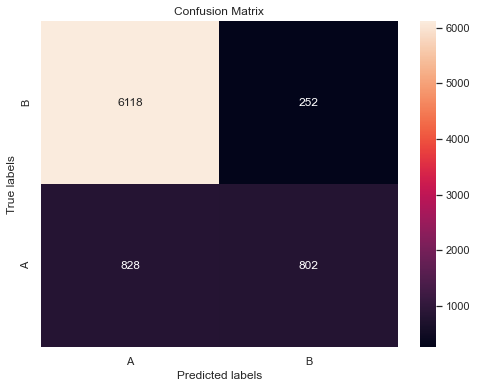

In [133]:
y_pred_cat_cv_imbal = cross_val_predict(cat2, X_train_selected_2, y_train_imb, cv=10)
cm = confusion_matrix(y_train_imb, y_pred_cat_cv_imbal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

In [134]:
result=pd.concat([bl_results,knn_results,lg_results,xgb_results,svm_results,rf_results,cat_results])
result

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
Baseline            0.503000           0.503000   0.497000 0.500000 0.503000 0.006000
K Nearest Neighbors 0.878000           0.878000   0.879000 0.878000 0.878000 0.756000
Logistic Regression 0.804000           0.809000   0.797000 0.803000 0.804000 0.608000
XGB                 0.929000           0.931000   0.926000 0.929000 0.929000 0.858000
SVM                 0.838000           0.851000   0.818000 0.835000 0.838000 0.676000
Random Forest       0.999000           0.999000   0.999000 0.999000 0.999000 0.999000
CatBoost            0.892000           0.896000   0.888000 0.892000 0.892000 0.785000

In [135]:
result=pd.concat([bl_results2,knn_results2,lg_results2,xgb_results2,svm_results2,rf_results2,cat_results2])
result

Balanced Accuracy  Precision   Recall       F1  ROC_AUC     Kappa
Baseline            0.499000           0.202000   0.208000 0.205000 0.499000 -0.002000
K Nearest Neighbors 0.757000           0.797000   0.549000 0.650000 0.757000 0.580000 
Logistic Regression 0.587000           0.615000   0.207000 0.310000 0.587000 0.231000 
XGB                 0.865000           0.946000   0.740000 0.831000 0.865000 0.794000 
SVM                 0.740000           0.516000   0.631000 0.568000 0.740000 0.443000 
Random Forest       0.999000           1.000000   0.998000 0.999000 0.999000 0.999000 
cat                 0.792000           0.583000   0.715000 0.642000 0.792000 0.539000

In [136]:
# performance comparison data frame
performance_comp = pd.concat([bl_cv_bal, lr_cv_bal, knn_cv_bal, svm_cv_bal, xgb_cv_bal, rf_cv_bal, cat_cv_bal])
performance_comp.columns = ['test_accuracy','train_accuracy','test_precision','train_precision','test_recall','train_recall','test_f1_score','train_f1_score','test_roc_auc_score','train_roc_auc_score','test_mcc','train_mcc']
performance_comp['model'] = ['Baseline', 'Linear Regression', 'KNN', 'SVM', 'XGB', 'Random Forest', 'Cat']
performance_comp = performance_comp[['model', 'test_accuracy','train_accuracy','test_precision','train_precision','test_recall','train_recall','test_f1_score','train_f1_score','test_roc_auc_score','train_roc_auc_score','test_mcc','train_mcc']]
performance_comp.set_index('model')

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
model                                                                                                                                                                                                    
Baseline          0.501587       0.502389        0.501705        0.502380         0.502824     0.502428      0.501994       0.502393        0.501588            0.502389             0.003180  0.004779  
Linear Regression 0.802706       0.804606        0.804109        0.809269         0.793012     0.797048      0.793294       0.803110        0.802749            0.804606             0.610694  0.609283  
KNN               0.830991       0.877443        0.831441        0.877558         0.827353     0.877277      0.826846       0.877408        0.831023            0.877443             0.665252  0.754902  
SVM               0.830462       0.836927        0.842056        0.850110         0.809560     0.818118      0.822043       0.833802        0.830497            0.836927             0.664959  0.674339  
XGB               0.854341       0.936602        0.853607        0.937474         0.853076     0.935593      0.851176       0.936528        0.854369            0.936602             0.711596  0.873214  
Random Forest     0.851257       0.999481        0.855938        0.999706         0.842332     0.999256      0.846727       0.999481        0.851287            0.999481             0.705607  0.998962  
Cat               0.857425       0.894274        0.858403        0.897753         0.853777     0.889888      0.854360       0.893798        0.857450            0.894274             0.717175  0.788588

In [137]:
# performance comparison data frame
performance_comp = pd.concat([bl_cv_imb, lr_cv_imb, knn_cv_imb, svm_cv_imb, xgb_cv_imb, rf_cv_imb, cat_cv_imb])
performance_comp.columns = ['test_accuracy','train_accuracy','test_precision','train_precision','test_recall','train_recall','test_f1_score','train_f1_score','test_roc_auc_score','train_roc_auc_score','test_mcc','train_mcc']
performance_comp['model'] = ['Baseline', 'Linear Regression', 'KNN', 'SVM', 'XGB', 'Random Forest', 'Cat']
performance_comp = performance_comp[['model', 'test_accuracy','train_accuracy','test_precision','train_precision','test_recall','train_recall','test_f1_score','train_f1_score','test_roc_auc_score','train_roc_auc_score','test_mcc','train_mcc']]
performance_comp.set_index('model')

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
model                                                                                                                                                                                                    
Baseline          0.673500       0.676069        0.201432        0.206242         0.202454     0.206953      0.201577       0.206555        0.498244            0.501532             -0.003280 0.003088  
Linear Regression 0.811625       0.812250        0.613970        0.616525         0.205521     0.207839      0.307454       0.310858        0.586120            0.587375             0.275092  0.278292  
KNN               0.832375       0.878583        0.636681        0.795275         0.413497     0.544240      0.500230       0.646190        0.676529            0.754189             0.419401  0.591123  
SVM               0.845750       0.850264        0.798635        0.814045         0.325767     0.343626      0.461766       0.483202        0.652287            0.661766             0.444078  0.464764  
XGB               0.851250       0.939667        0.696809        0.944016         0.479141     0.748262      0.567057       0.834775        0.712804            0.868453             0.493783  0.806571  
Random Forest     0.856750       0.999597        0.721354        0.999591         0.487117     0.998432      0.580294       0.999011        0.719225            0.999164             0.512600  0.998759  
Cat               0.865000       0.897972        0.762566        0.873494         0.492025     0.583776      0.597242       0.699818        0.726232            0.781074             0.539263  0.660180

# 10 Hyperparameter Tunning

## 10.1 Random Forest

### 10.1.1 RF Imbalanced

In [138]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1) 
# set hyperparameters values

# n_estimators: number of trees in the random forest (default=100)
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]

# max_depth: maximum number of levels in tree (default = None)
max_depth = [int(x) for x in np.linspace(4, 40, 10)]
max_depth.append(None)

# min_samples_split: minimum number of samples required to split a node (default = 2)
min_samples_split = [2, 5, 10]

# min_samples_leaf: minimum number of samples required at each leadf node (default = 1)
min_samples_leaf = [1, 2, 4]

# create random grid
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

print(param_grid)


{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [139]:
# prepare RandomizedSearchCV object
# 10-fold cross validation
# Search across 50 different combinations (n_iter=50)

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                              scoring='f1', n_iter=50, cv=10, verbose=2,
                              random_state=42, n_jobs=-1)

In [ ]:
# fit the model
rf_random.fit(X_train_selected_2, y_train_imb)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.7s


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [4, 8, 12, 16, 20, 24, 28,
                                                      32, 36, 40, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, scoring='f1', verbose=2)

In [ ]:
rf_random.best_params_ 

In [ ]:
rf_random.best_estimator_ 

In [ ]:
rf_tuned = rf_random.best_estimator_
rf_tuned

In [ ]:
random_forest_tuned_imb, cm = performance_test('Random Forest Tuned Imbal',rf_tuned, X_test_selected, y_test_imb)
random_forest_tuned_imb

### 10.1.2 RF Balanced

In [ ]:
rf_bal_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                              scoring='f1', n_iter=50, cv=10, verbose=2,
                              random_state=42, n_jobs=-1)

In [ ]:
rf_bal_random.fit(X_train_selected, y_smt)

In [ ]:
rf_bal_random.best_params_

In [ ]:
rf_tuned_bal=rf_bal_random.best_estimator_

In [ ]:
random_forest_tuned_bal, cm = performance_test('Random Forest Tuned Bal',rf_tuned_bal, X_test_selected, y_test_smt)
random_forest_tuned_bal

In [ ]:
cm

In [ ]:
random_forest_imbal, cm = performance_test('Random Forest Imbal',rf2, X_test_selected, y_test_imb)
random_forest_imbal

## 10.2 Cat

### 10.2.1 Cat Balanced

In [ ]:
xgb_bal, cm = performance_test('XGB Bal',xgb, X_test_selected, y_test_smt)
xgb_bal

In [ ]:
cat_bal, cm = performance_test('CatBoost Bal',cat, X_test_selected, y_test_smt)
cat_bal

### 10.2.1 Cat Imbalanced

In [ ]:
cat_imbal, cm = performance_test('CatBoost Imbal',cat2, X_test_selected, y_test_imb)
cat_imbal

In [ ]:
xgb_imbal, cm = performance_test('XGB Imbal',xgb2, X_test_selected, y_test_imb)
xgb_imbal

## 10.3 Summary

In [ ]:
perf_comp = pd.concat([random_forest_imbal,random_forest_tuned_bal, random_forest_tuned_imb,cat_imbal,cat_bal])

perf_comp

CHOSEN MODEL: Random Forest Tuned Imbalanced

# 11. Model and Business Performance

## 11.1 Model Performance

### 11.1.1 Precision and Recall

In [ ]:
y_probas = rf_tuned.predict_proba(X_test_selected)
y_pred = rf_tuned.predict(X_test_selected)
y_scores = y_probas[:,1]

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test_imb, y_scores) 

In [ ]:
# model recall
recall_model = random_forest_tuned_imb['recall'][0]

# model precision
precision_model = random_forest_tuned_imb['precision'][0]

In [ ]:
# current precision index
prec_index = np.where(precisions==precision_model)
prec_index

In [ ]:
# model current threshold
threshold_model = thresholds[prec_index]
threshold_model

In [ ]:
# Plot precision and recall versus threshold

# figure size
plt.figure(figsize=(12,12))

plt.plot(thresholds, precisions[:-1], "b--", label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label='Recall', linewidth=2)
plt.legend(loc='center right', fontsize=16)
plt.xlabel("Threshold", fontsize=16)
plt.xticks(np.arange(0, 1.01, step=0.1))
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.grid(True)

# plot current precision and recall from the model
plt.plot([threshold_model, threshold_model], [0.0, precision_model], 'r:')
plt.plot([0.0, threshold_model], [precision_model, precision_model], 'r:')
plt.plot([0.0, threshold_model], [recall_model, recall_model], 'r:')
plt.plot([threshold_model], [precision_model], 'ro')
plt.plot([threshold_model], [recall_model], 'ro')
plt.axis([0, 1, 0, 1])
plt.title('Precision and recall versus the decision threshold', fontsize=16)
plt.show()

In [ ]:
# plot precision versus recall

# figure size
plt.figure(figsize=(12,12))

plt.plot(recalls, precisions, 'b-', linewidth=2)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.axis([0, 1, 0, 1])

# plot current precision and recall from the model
plt.plot([recall_model, recall_model], [0.0, precision_model], 'r:')
plt.plot([0.0, recall_model], [precision_model, precision_model], 'r:')
plt.plot([recall_model], [precision_model], 'ro')
plt.grid(True)
plt.title('Precision versus Recall', fontsize=16)
plt.show()

### 11.1.2 ROC curve

In [ ]:
# compute TPR and FPR
fpr, tpr, thresholds = roc_curve(y_test_imb, y_scores)

# figure size
plt.figure(figsize=(10,10))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.title('ROC Curve', fontsize=16)
plt.grid(True)
plt.show()

### 11.1.3 Lift Curve and Cumulative Gains Curve

The lift curve uses the returned probability of a classification model to assess how the model is performing, and how well it is identifying the positive or negative instances of the dataset. <br>
After ordering the data, sorting by probability, the highest probability appear on the left, usually along with the highest Lift scores. <br>
Provides a quick way to get an estimate of how the algorithm is performing as it shoes how many times better applying the model is than random selection for any percentage of the ranked records.The greater the area between the lift curve and the baseline, the better the model.

In [ ]:
# plot Lift curve
skplt.metrics.plot_lift_curve(y_test_imb, y_probas, figsize=(8,6))
plt.legend(loc='center right', fontsize=12)
plt.show()

 
The Lift curve shows that if 20% of the customers are contacted, using the prediction of the model should reach 60% of customers in churn. 60 / 20 = 3.

In the Cumulative Gains Curve, the left side of the x-axis starts with the observations that have the highest probability of belonging to the class of interest. The x axis tell us what percentage of the observations are being considered. In this case, it is a percentage of the 2,000 clients from the test set. <br>
The y axis (Gain) indicates the percentage of positive responses. In this case, it is the percentage of the positive responses (churn) from the test set.<br>
When the model is applied to the data, and the X% clients most likely are selected, what percentage of the actually churned clients you are expect to find?

In [ ]:
 # plot cumulative gains curve
skplt.metrics.plot_cumulative_gain(y_test_imb, y_probas, figsize=(8,6))
plt.show()

In [ ]:
# copy test_set
lift_df = test_set.copy()

# add predictions and predicted probabilities according the model
lift_df['predictions'] = y_pred
lift_df['probabilities'] = y_scores

# sort lift_df according predicted probabilities
lift_df = lift_df.sort_values('probabilities', ascending=False)

# set percentage of the sample (percentage of clients to contact in order to avoid churn)
sample_pc = 0.2

# calculate the size of the percentage of the sample
top_sample_pc = np.ceil((len(lift_df['exited'])*sample_pc)).astype(int)

# select top rated clients (top predicted probabilities)
clients_top = lift_df.iloc[:top_sample_pc]

# calculate cumulative gain
cumulative_gain = clients_top['exited'].sum() / test_set['exited'].sum()

# calculate lift
lift = cumulative_gain / sample_pc

# print results
print('Sample percentage: {}%'.format(sample_pc*100))
print('Cumulative gain: {:,.2f}'.format(cumulative_gain))
print('Lift: {:,.2f}'.format(lift))



## 11.2. Business Performance

### 11.2.1 Churn Rate

In [ ]:
# calculate current churn rate
churn_rate = test_set['exited'].value_counts(normalize=True)*100
print('The current churn Rate is {:,.2f}%'.format(churn_rate[1]))

In [ ]:
# Churn rate by tenure

In [ ]:
# get tenure values
ten_values = test_set['tenure'].value_counts()
ten_values = np.array(ten_values.index)
churn_list = []

# calculate churn rate per tenure
for ten in ten_values:
    churn_rate_ten = (test_set[test_set['tenure']==ten]['exited'].sum() / len(test_set[test_set['tenure']==ten]))*100
    churn_list.append(churn_rate_ten)
    
churn_ten_df = pd.DataFrame({'churn_rate': churn_list, 'tenure': ten_values})
churn_ten_df = churn_ten_df.sort_values('tenure')
churn_ten_df.round(2)    

### 11.2.2 Model Performance
<br>
The model has a precision of 80%. The model can detect 45.5% of clients in churn (Recall).

### 11.2.3 Bank Revenue

#### a) What's the company's revenue, if the company avoids all customers to get into churn through the developed model?
 
Bank account return per client: <br>
15% for clients with estimated income lower than the average;<br>
20% for clients with estimated income greater than the average.

In [ ]:
# calculate bank account return per client

business_df = test_set.copy()
business_df['return_client'] = business_df.apply(lambda x: x['estimated_salary']*0.15 if x['estimated_salary'] < business_df['estimated_salary'].mean() else x['estimated_salary']*0.2, axis=1)

In [ ]:
# calculate current total return of all clients
return_total = business_df['return_client'].sum()
print('Total current return of all clients: {:,.2f}'.format(return_total))

In [ ]:
# number of clients in churn
clients_churn = business_df['exited'].value_counts()[1]

# calculate total revenue loss
total_loss = business_df[business_df['exited']==1]['return_client'].sum()
print('Total revenue loss if all {} clients in churn leave the bank: {:,.2f}.'.format(clients_churn, total_loss))
print('The total revenue loss represents {:,.2f}% of total current return.'.format((total_loss/return_total)*100))

In [ ]:
# dataframe with predictions and predicted probabilities
business_df['predictions'] = y_pred
business_df['probabilities'] = y_scores

In [ ]:
# Calculate company's revenue if the company avoids all customers to get into churn through the developed model

# filter clients in churn according model and dataset
aux = business_df[(business_df['exited']==1) & (business_df['predictions']==1)]

# number of clients to recover
clients_recover = len(aux)
# clients identified to recover / clients in churn
clients_ratio = (clients_recover / clients_churn)*100

# revenue if clients don't get in churn
revenue = aux['return_client'].sum()
# revenue ratio
revenue_ratio = (revenue / total_loss)*100

print("Company's recovered revenue if {} clients don't get into churn through the model: {:,.2f}".\
      format(clients_recover, revenue))
print('That represents {:,.2f}% of clients labeled as in churn and {:,.2f}% of the total revenue loss'.\
      format(clients_ratio, revenue_ratio))

#### b) Customer Incentive to Maximize ROI - Alternative 1
Top 100 clients with highest churn probability. <br>
Which customers could receive an incentive and at what cost, in order to maximize the ROI (Return on investment)? (the sum of incentives shall not exceed BRL 10,000.00<br>
<br>
b.1) Incentive per client: $100. Profit is the difference between recovered revenue and the incentive per client.

In [ ]:
# sort business_df according predicted probabilities
business_df = business_df.sort_values('probabilities', ascending=False)

In [ ]:
# select top 100 clients with highest churn probability
clients_top_100 = business_df.iloc[:100]

# set incentive per client
clients_top_100['incentive'] = 100

# calculate recovered revenue per client
clients_top_100['rec_revenue'] = clients_top_100.apply(lambda x: x['return_client'] if x['exited']==1 else 0, axis=1)

# calculate profit per client
clients_top_100['profit'] = clients_top_100['rec_revenue'] - clients_top_100['incentive']

# calculate total recovered revenue
revenue = clients_top_100['rec_revenue'].sum()

# calculate revenue loss recovered (%)
loss_recovered = (revenue / total_loss)*100

# calculate the amount of investments (sum of incentives)
investment = clients_top_100['incentive'].sum()

# calculate the profit
profit = clients_top_100['profit'].sum()

# calculate ROI
roi = (profit / investment)*100

# calculate possible churn reduction in %
churn_model = clients_top_100[(clients_top_100['exited']==1) & (clients_top_100['predictions']==1)]
churn_red = (len(churn_model) / len(business_df[business_df['exited']==1]))*100

print('Recovered Revenue: {:,.2f}'.format(revenue))
print('% Recovered from Total Revenue loss: {:,.2f}%'.format(loss_recovered))
print('Investment: {:,.2f}'.format(investment))
print('Profit: {:,.2f}'.format(profit))
print('ROI: {:,.2f}%'.format(roi))
print('Potential clients recovered acc. model: {}'.format(len(churn_model)))
print('Potential churn reduction: {:,.2f}%'.format(churn_red))

#### c) Customer Incentive to Maximize ROI - Alternative 2
Top 200 clients with highest churn probability. <br> 
Which customers could receive an incentive and at what cost, in order to maximize the ROI (Return on investment)? (the sum of incentives shall not exceed BRL 10,000.00<br>
<br>
Incentive per client: $50.

In [ ]:
# select top 200 clients with highest churn probability
clients_top_200 = business_df.iloc[:200]

# set incentive per client
clients_top_200['incentive'] = 50

# calculate recovered revenue per client
clients_top_200['rec_revenue'] = clients_top_200.\
apply(lambda x: x['return_client'] if x['exited']==1 else 0, axis=1)

# calculate profit per client
clients_top_200['profit'] = clients_top_200['rec_revenue'] - clients_top_200['incentive']

# calculate total recovered revenue
revenue = clients_top_200['rec_revenue'].sum()

# calculate revenue loss recovered (%)
loss_recovered = (revenue / total_loss)*100

# calculate the amount of investments (sum of incentives)
investment = clients_top_200['incentive'].sum()

# calculate the profit
profit = clients_top_200['profit'].sum()

# calculate ROI
roi = (profit / investment)*100

# calculate possible churn reduction in %
churn_model = clients_top_200[(clients_top_200['exited']==1) & (clients_top_200['predictions']==1)]
churn_red = (len(churn_model) / len(business_df[business_df['exited']==1]))*100

print('Recovered Revenue: {:,.2f}'.format(revenue))
print('% Recovered from Total Revenue loss: {:,.2f}%'.format(loss_recovered))
print('Investment: {:,.2f}'.format(investment))
print('Profit: {:,.2f}'.format(profit))
print('ROI: {:,.2f}%'.format(roi))
print('Potential clients recovered acc. model: {}'.format(len(churn_model)))
print('Potential churn reduction: {:,.2f}%'.format(churn_red))

# Summary

## What's the company's current churn rate?

The current churn Rate is 20.35%

## How the churn rate varies per tenure?

In [ ]:
churn_ten_df

## What's the model's performance to label the clients as churns?

The model has a precision of 80%. The model can detect 45.5% of clients in churn (Recall).

## What's the company's revenue, if the company avoids the customers to get into churn through the developed model?

Total revenue loss if all 407 clients in churn leave the bank: 7,491,850.97. <br>
The total revenue loss represents 19.67% of total current return.

Scenario A) all customers do not enter in churn
Total current return of all clients: 38,079,850.98
Total revenue loss if all 407 clients in churn leave the bank: 7,491,850.97.
The total revenue loss represents 19.67% of total current return.

Scenario B) identified customers do not enter in churn
Company's recovered revenue if 185 clients don't get into churn through the model: 3,555,818.69
That represents 45.45% of clients labeled as in churn and 47.46% of the total revenue loss

Scenario C) incentive per client: $100. All 100 identified clients that receive voucher do not churn
Recovered Revenue: 1,748,826.50
% Recovered from Total Revenue loss: 23.34%
Investment: 10,000.00
Profit: 1,738,826.50
ROI: 17,388.26%
Potential clients recovered acc. model: 90
Potential churn reduction: 22.11%

Scenario D) Incentive per client: $50. All 200 identified clients that receive voucher do not churn
Recovered Revenue: 3,202,198.62
% Recovered from Total Revenue loss: 42.74%
Investment: 10,000.00
Profit: 3,192,198.62
ROI: 31,921.99%
Potential clients recovered acc. model: 163
Potential churn reduction: 40.05%

## Considerations

An realistic approach would consider that not all clients would continue at TopBank. Also, it would take in account that clients with more probability of churn may need an higher amount of incentives than the clients with less probability of churn. Therefore it would be interesting consider the "0-1 Knapsack-Problem" approach. IF TopBank has data on past promotional initiatives, it could be included in order to improve the selection of customers to contact.

The realistic approach should include the profit each client brings to the company to understand what client is "more important" to avoid churn

Other improvements to this project would be test more models/hyperparameters and evaluate its performance.

The use of SmoteTomek technique seemed to overfit the model.